<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [14]</a>'.</span>

In [1]:
"""
from google.colab import drive
drive.mount('/content/gdrive/')

#!pip install -q condacolab
#import condacolab
#condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision
"""

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive/')\n\n#!pip install -q condacolab\n#import condacolab\n#condacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision\n"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/z/home/sgal/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16

    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction

    # Paths to use
    paths = parser.add_argument_group('Paths')
    #paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta

    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set_60seqs.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_test', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set_60seqs_test.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/WWseeds_aligned_for_pretrained.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta


    #paths.add_argument('--path_orig', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set_20seqs_v2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/WWseeds_aligned_for_pretrained2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta


    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case')
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report')
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization')
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=1750, help='number of tesselation cells') #6 80, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=1750, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps')

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=60, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')


    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_test = std.parserinfo('path_test')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'

'''trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth is the one that works fine'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_37_feb10_2024_debug.pth'

'''this would be with the seeds samples (40 aas)'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_seeds_40aas_nov2023_4.pth'

'''for seeds samples'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug_2000iter.pth'

'''for preprint for 38 residues example on WW'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_21nov2023.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_22nov2023.pth'

''' for preprint for 42 residues example on WW'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_27nov2023.pth'





#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_10feb2024.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_13feb2024.pth'

print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)
dataset_test = seqsDatasetLoader(pathBLAT_data = path_test, alphabet = alphabets, enable_variable_length=True, device=device)


'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=112)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


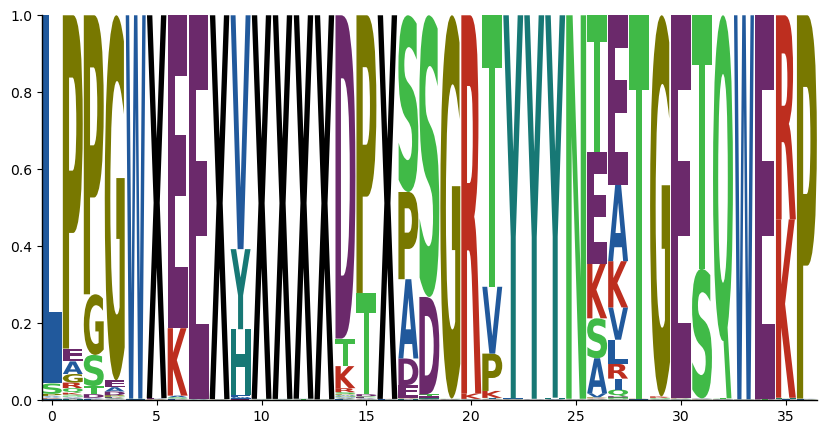

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.01)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 2000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])

    #fig.tight_layout()


def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt

    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize) #; fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet]
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)

        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)

    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')

    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()

def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''

        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))

        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs),
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)

                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]


                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS
                optimizer.step()


                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())

                # Save to tensorboard
                iteration = epoch*len(trainloader) + i

                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()

        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std,
                    latent_dim = args.latent_dim,
                    encoder = get_encoder( args.ed_type.split(",")[0] ),
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-575,575])#[-175,175] [-15,15] ) #[15,15] #if we increase it, major accuracy

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)#, weight_decay=1e-19)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=400, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # initi

Number of training points:  60


Epoch 1/400:   0%|          | 0/60 [00:00<?, ?samples/s]

/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/400:  17%|█▋        | 10/60 [00:00<00:04, 11.23samples/s]

Epoch 1/400:  17%|█▋        | 10/60 [00:00<00:04, 11.23samples/s, loss=1125.42431640625]

Epoch 1/400:  33%|███▎      | 20/60 [00:01<00:03, 13.11samples/s, loss=1125.42431640625]

Epoch 1/400:  33%|███▎      | 20/60 [00:01<00:03, 13.11samples/s, loss=1141.041015625]  

Epoch 1/400:  50%|█████     | 30/60 [00:02<00:02, 14.21samples/s, loss=1141.041015625]

Epoch 1/400:  50%|█████     | 30/60 [00:02<00:02, 14.21samples/s, loss=1130.0914306640625]

Epoch 1/400:  67%|██████▋   | 40/60 [00:02<00:01, 14.79samples/s, loss=1130.0914306640625]

Epoch 1/400:  67%|██████▋   | 40/60 [00:02<00:01, 14.79samples/s, loss=1126.85791015625]  

Epoch 1/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.15samples/s, loss=1126.85791015625]

Epoch 1/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.15samples/s, loss=1121.9964599609375]

Epoch 1/400: 100%|██████████| 60/60 [00:04<00:00, 15.33samples/s, loss=1121.9964599609375]

Epoch 1/400: 100%|██████████| 60/60 [00:04<00:00, 15.33samples/s, loss=1121.03564453125]  

Epoch 1/400: 100%|██████████| 60/60 [00:04<00:00, 14.21samples/s, loss=1121.03564453125]

Epoch 2/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 2/400:  17%|█▋        | 10/60 [00:00<00:02, 19.48samples/s]

Epoch 2/400:  17%|█▋        | 10/60 [00:00<00:02, 19.48samples/s, loss=1122.8968505859375]

Epoch 2/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1122.8968505859375]

Epoch 2/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1136.926025390625] 

Epoch 2/400:  50%|█████     | 30/60 [00:01<00:01, 16.52samples/s, loss=1136.926025390625]

Epoch 2/400:  50%|█████     | 30/60 [00:01<00:01, 16.52samples/s, loss=1129.39453125]    

Epoch 2/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=1129.39453125]

Epoch 2/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=1124.7957763671875]

Epoch 2/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=1124.7957763671875]

Epoch 2/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=1117.435791015625] 

Epoch 2/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1117.435791015625]

Epoch 2/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1117.357421875]   

Epoch 2/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1117.357421875]

Epoch 3/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 3/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s]

Epoch 3/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s, loss=1120.7315673828125]

Epoch 3/400:  33%|███▎      | 20/60 [00:01<00:02, 17.13samples/s, loss=1120.7315673828125]

Epoch 3/400:  33%|███▎      | 20/60 [00:01<00:02, 17.13samples/s, loss=1137.2174072265625]

Epoch 3/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1137.2174072265625]

Epoch 3/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1129.1434326171875]

Epoch 3/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=1129.1434326171875]

Epoch 3/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=1124.774169921875] 

Epoch 3/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=1124.774169921875]

Epoch 3/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=1116.812744140625]

Epoch 3/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1116.812744140625]

Epoch 3/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1115.224365234375]

Epoch 3/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=1115.224365234375]

Epoch 4/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 4/400:  17%|█▋        | 10/60 [00:00<00:02, 19.08samples/s]

Epoch 4/400:  17%|█▋        | 10/60 [00:00<00:02, 19.08samples/s, loss=1120.655029296875]

Epoch 4/400:  33%|███▎      | 20/60 [00:01<00:02, 16.84samples/s, loss=1120.655029296875]

Epoch 4/400:  33%|███▎      | 20/60 [00:01<00:02, 16.84samples/s, loss=1135.0694580078125]

Epoch 4/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1135.0694580078125]

Epoch 4/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1126.6387939453125]

Epoch 4/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.31samples/s, loss=1126.6387939453125]

Epoch 4/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.31samples/s, loss=1121.016357421875] 

Epoch 4/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.23samples/s, loss=1121.016357421875]

Epoch 4/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.23samples/s, loss=1111.677978515625]

Epoch 4/400: 100%|██████████| 60/60 [00:03<00:00, 16.05samples/s, loss=1111.677978515625]

Epoch 4/400: 100%|██████████| 60/60 [00:03<00:00, 16.05samples/s, loss=1109.56201171875] 

Epoch 4/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1109.56201171875]

Epoch 5/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 5/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s]

Epoch 5/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s, loss=1113.0596923828125]

Epoch 5/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=1113.0596923828125]

Epoch 5/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=1126.00537109375]  

Epoch 5/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=1126.00537109375]

Epoch 5/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=1118.410888671875]

Epoch 5/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=1118.410888671875]

Epoch 5/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=1113.58642578125] 

Epoch 5/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=1113.58642578125]

Epoch 5/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=1106.714599609375]

Epoch 5/400: 100%|██████████| 60/60 [00:03<00:00, 16.01samples/s, loss=1106.714599609375]

Epoch 5/400: 100%|██████████| 60/60 [00:03<00:00, 16.01samples/s, loss=1105.4102783203125]

Epoch 5/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1105.4102783203125]

Epoch 6/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 6/400:  17%|█▋        | 10/60 [00:00<00:02, 18.90samples/s]

Epoch 6/400:  17%|█▋        | 10/60 [00:00<00:02, 18.90samples/s, loss=1106.1722412109375]

Epoch 6/400:  33%|███▎      | 20/60 [00:01<00:02, 16.28samples/s, loss=1106.1722412109375]

Epoch 6/400:  33%|███▎      | 20/60 [00:01<00:02, 16.28samples/s, loss=1117.34814453125]  

Epoch 6/400:  50%|█████     | 30/60 [00:01<00:01, 15.55samples/s, loss=1117.34814453125]

Epoch 6/400:  50%|█████     | 30/60 [00:01<00:01, 15.55samples/s, loss=1110.2718505859375]

Epoch 6/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=1110.2718505859375]

Epoch 6/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=1100.6690673828125]

Epoch 6/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.59samples/s, loss=1100.6690673828125]

Epoch 6/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.59samples/s, loss=1098.6505126953125]

Epoch 6/400: 100%|██████████| 60/60 [00:03<00:00, 15.50samples/s, loss=1098.6505126953125]

Epoch 6/400: 100%|██████████| 60/60 [00:03<00:00, 15.50samples/s, loss=1095.310302734375] 

Epoch 6/400: 100%|██████████| 60/60 [00:03<00:00, 15.23samples/s, loss=1095.310302734375]

Epoch 7/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 7/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s]

Epoch 7/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s, loss=1089.3929443359375]

Epoch 7/400:  33%|███▎      | 20/60 [00:01<00:02, 16.80samples/s, loss=1089.3929443359375]

Epoch 7/400:  33%|███▎      | 20/60 [00:01<00:02, 16.80samples/s, loss=1109.4351806640625]

Epoch 7/400:  50%|█████     | 30/60 [00:01<00:01, 15.87samples/s, loss=1109.4351806640625]

Epoch 7/400:  50%|█████     | 30/60 [00:01<00:01, 15.87samples/s, loss=1095.9764404296875]

Epoch 7/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.46samples/s, loss=1095.9764404296875]

Epoch 7/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.46samples/s, loss=1087.2843017578125]

Epoch 7/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.59samples/s, loss=1087.2843017578125]

Epoch 7/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.59samples/s, loss=1075.439697265625] 

Epoch 7/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1075.439697265625]

Epoch 7/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1069.6123046875]  

Epoch 7/400: 100%|██████████| 60/60 [00:03<00:00, 15.38samples/s, loss=1069.6123046875]

Epoch 8/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 8/400:  17%|█▋        | 10/60 [00:00<00:02, 18.67samples/s]

Epoch 8/400:  17%|█▋        | 10/60 [00:00<00:02, 18.67samples/s, loss=1051.3424072265625]

Epoch 8/400:  33%|███▎      | 20/60 [00:01<00:02, 16.44samples/s, loss=1051.3424072265625]

Epoch 8/400:  33%|███▎      | 20/60 [00:01<00:02, 16.44samples/s, loss=1063.33447265625]  

Epoch 8/400:  50%|█████     | 30/60 [00:01<00:01, 15.81samples/s, loss=1063.33447265625]

Epoch 8/400:  50%|█████     | 30/60 [00:01<00:01, 15.81samples/s, loss=1052.1435546875] 

Epoch 8/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.45samples/s, loss=1052.1435546875]

Epoch 8/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.45samples/s, loss=1057.365234375] 

Epoch 8/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.53samples/s, loss=1057.365234375]

Epoch 8/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.53samples/s, loss=1054.787109375]

Epoch 8/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1054.787109375]

Epoch 8/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1067.2545166015625]

Epoch 8/400: 100%|██████████| 60/60 [00:03<00:00, 15.15samples/s, loss=1067.2545166015625]

Epoch 9/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 9/400:  17%|█▋        | 10/60 [00:00<00:02, 19.20samples/s]

Epoch 9/400:  17%|█▋        | 10/60 [00:00<00:02, 19.20samples/s, loss=1053.9166259765625]

Epoch 9/400:  33%|███▎      | 20/60 [00:01<00:02, 16.96samples/s, loss=1053.9166259765625]

Epoch 9/400:  33%|███▎      | 20/60 [00:01<00:02, 16.96samples/s, loss=1072.5113525390625]

Epoch 9/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=1072.5113525390625]

Epoch 9/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=1059.5897216796875]

Epoch 9/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=1059.5897216796875]

Epoch 9/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=1055.7396240234375]

Epoch 9/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=1055.7396240234375]

Epoch 9/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=1046.0986328125]   

Epoch 9/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=1046.0986328125]

Epoch 9/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=1062.550048828125]

Epoch 9/400: 100%|██████████| 60/60 [00:03<00:00, 15.47samples/s, loss=1062.550048828125]

Epoch 10/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 10/400:  17%|█▋        | 10/60 [00:00<00:02, 19.39samples/s]

Epoch 10/400:  17%|█▋        | 10/60 [00:00<00:02, 19.39samples/s, loss=1057.123046875]

Epoch 10/400:  33%|███▎      | 20/60 [00:01<00:02, 16.85samples/s, loss=1057.123046875]

Epoch 10/400:  33%|███▎      | 20/60 [00:01<00:02, 16.85samples/s, loss=1066.428466796875]

Epoch 10/400:  50%|█████     | 30/60 [00:01<00:01, 16.10samples/s, loss=1066.428466796875]

Epoch 10/400:  50%|█████     | 30/60 [00:01<00:01, 16.10samples/s, loss=1057.0115966796875]

Epoch 10/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.76samples/s, loss=1057.0115966796875]

Epoch 10/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.76samples/s, loss=1052.508056640625] 

Epoch 10/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1052.508056640625]

Epoch 10/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1041.27685546875] 

Epoch 10/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1041.27685546875]

Epoch 10/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1063.1038818359375]

Epoch 10/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=1063.1038818359375]

Epoch 11/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 11/400:  17%|█▋        | 10/60 [00:00<00:02, 19.09samples/s]

Epoch 11/400:  17%|█▋        | 10/60 [00:00<00:02, 19.09samples/s, loss=1054.6517333984375]

Epoch 11/400:  33%|███▎      | 20/60 [00:01<00:02, 16.93samples/s, loss=1054.6517333984375]

Epoch 11/400:  33%|███▎      | 20/60 [00:01<00:02, 16.93samples/s, loss=1066.91650390625]  

Epoch 11/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1066.91650390625]

Epoch 11/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1056.8978271484375]

Epoch 11/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=1056.8978271484375]

Epoch 11/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=1054.9578857421875]

Epoch 11/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=1054.9578857421875]

Epoch 11/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=1046.3173828125]   

Epoch 11/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=1046.3173828125]

Epoch 11/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=1061.8153076171875]

Epoch 11/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=1061.8153076171875]

Epoch 12/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 12/400:  17%|█▋        | 10/60 [00:00<00:02, 19.20samples/s]

Epoch 12/400:  17%|█▋        | 10/60 [00:00<00:02, 19.20samples/s, loss=1051.1612548828125]

Epoch 12/400:  33%|███▎      | 20/60 [00:01<00:02, 16.71samples/s, loss=1051.1612548828125]

Epoch 12/400:  33%|███▎      | 20/60 [00:01<00:02, 16.71samples/s, loss=1069.701171875]    

Epoch 12/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=1069.701171875]

Epoch 12/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=1055.999267578125]

Epoch 12/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=1055.999267578125]

Epoch 12/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=1051.0814208984375]

Epoch 12/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=1051.0814208984375]

Epoch 12/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=1044.61962890625]  

Epoch 12/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1044.61962890625]

Epoch 12/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1060.8104248046875]

Epoch 12/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1060.8104248046875]

Epoch 13/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 13/400:  17%|█▋        | 10/60 [00:00<00:02, 18.95samples/s]

Epoch 13/400:  17%|█▋        | 10/60 [00:00<00:02, 18.95samples/s, loss=1051.2171630859375]

Epoch 13/400:  33%|███▎      | 20/60 [00:01<00:02, 16.39samples/s, loss=1051.2171630859375]

Epoch 13/400:  33%|███▎      | 20/60 [00:01<00:02, 16.39samples/s, loss=1069.7158203125]   

Epoch 13/400:  50%|█████     | 30/60 [00:01<00:01, 15.84samples/s, loss=1069.7158203125]

Epoch 13/400:  50%|█████     | 30/60 [00:01<00:01, 15.84samples/s, loss=1052.564208984375]

Epoch 13/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.75samples/s, loss=1052.564208984375]

Epoch 13/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.75samples/s, loss=1060.0611572265625]

Epoch 13/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.73samples/s, loss=1060.0611572265625]

Epoch 13/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.73samples/s, loss=1053.9935302734375]

Epoch 13/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1053.9935302734375]

Epoch 13/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1062.3648681640625]

Epoch 13/400: 100%|██████████| 60/60 [00:03<00:00, 15.43samples/s, loss=1062.3648681640625]

Epoch 14/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 14/400:  17%|█▋        | 10/60 [00:00<00:02, 19.19samples/s]

Epoch 14/400:  17%|█▋        | 10/60 [00:00<00:02, 19.19samples/s, loss=1051.458251953125]

Epoch 14/400:  33%|███▎      | 20/60 [00:01<00:02, 16.92samples/s, loss=1051.458251953125]

Epoch 14/400:  33%|███▎      | 20/60 [00:01<00:02, 16.92samples/s, loss=1066.6094970703125]

Epoch 14/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=1066.6094970703125]

Epoch 14/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=1054.6580810546875]

Epoch 14/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=1054.6580810546875]

Epoch 14/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=1054.596435546875] 

Epoch 14/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=1054.596435546875]

Epoch 14/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=1045.105224609375]

Epoch 14/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1045.105224609375]

Epoch 14/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1067.893310546875]

Epoch 14/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1067.893310546875]

Epoch 15/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 15/400:  17%|█▋        | 10/60 [00:00<00:02, 19.28samples/s]

Epoch 15/400:  17%|█▋        | 10/60 [00:00<00:02, 19.28samples/s, loss=1045.10107421875]

Epoch 15/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=1045.10107421875]

Epoch 15/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=1067.60986328125]

Epoch 15/400:  50%|█████     | 30/60 [00:01<00:01, 16.20samples/s, loss=1067.60986328125]

Epoch 15/400:  50%|█████     | 30/60 [00:01<00:01, 16.20samples/s, loss=1054.1982421875] 

Epoch 15/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=1054.1982421875]

Epoch 15/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=1052.3812255859375]

Epoch 15/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=1052.3812255859375]

Epoch 15/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=1046.853515625]    

Epoch 15/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1046.853515625]

Epoch 15/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1060.129638671875]

Epoch 15/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1060.129638671875]

Epoch 16/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 16/400:  17%|█▋        | 10/60 [00:00<00:02, 19.28samples/s]

Epoch 16/400:  17%|█▋        | 10/60 [00:00<00:02, 19.28samples/s, loss=1052.4078369140625]

Epoch 16/400:  33%|███▎      | 20/60 [00:01<00:02, 16.83samples/s, loss=1052.4078369140625]

Epoch 16/400:  33%|███▎      | 20/60 [00:01<00:02, 16.83samples/s, loss=1072.308349609375] 

Epoch 16/400:  50%|█████     | 30/60 [00:01<00:01, 16.20samples/s, loss=1072.308349609375]

Epoch 16/400:  50%|█████     | 30/60 [00:01<00:01, 16.20samples/s, loss=1050.2642822265625]

Epoch 16/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=1050.2642822265625]

Epoch 16/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=1052.9637451171875]

Epoch 16/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=1052.9637451171875]

Epoch 16/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=1051.4814453125]   

Epoch 16/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1051.4814453125]

Epoch 16/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1059.6484375]   

Epoch 16/400: 100%|██████████| 60/60 [00:03<00:00, 15.51samples/s, loss=1059.6484375]

Epoch 17/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 17/400:  17%|█▋        | 10/60 [00:00<00:02, 18.91samples/s]

Epoch 17/400:  17%|█▋        | 10/60 [00:00<00:02, 18.91samples/s, loss=1051.26806640625]

Epoch 17/400:  33%|███▎      | 20/60 [00:01<00:02, 16.81samples/s, loss=1051.26806640625]

Epoch 17/400:  33%|███▎      | 20/60 [00:01<00:02, 16.81samples/s, loss=1069.4158935546875]

Epoch 17/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1069.4158935546875]

Epoch 17/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1053.1480712890625]

Epoch 17/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=1053.1480712890625]

Epoch 17/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=1053.720947265625] 

Epoch 17/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=1053.720947265625]

Epoch 17/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=1043.99853515625] 

Epoch 17/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1043.99853515625]

Epoch 17/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1061.6585693359375]

Epoch 17/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1061.6585693359375]

Epoch 18/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 18/400:  17%|█▋        | 10/60 [00:00<00:02, 19.39samples/s]

Epoch 18/400:  17%|█▋        | 10/60 [00:00<00:02, 19.39samples/s, loss=1051.7989501953125]

Epoch 18/400:  33%|███▎      | 20/60 [00:01<00:02, 16.74samples/s, loss=1051.7989501953125]

Epoch 18/400:  33%|███▎      | 20/60 [00:01<00:02, 16.74samples/s, loss=1066.25439453125]  

Epoch 18/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1066.25439453125]

Epoch 18/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1051.6839599609375]

Epoch 18/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=1051.6839599609375]

Epoch 18/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=1052.7669677734375]

Epoch 18/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=1052.7669677734375]

Epoch 18/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=1043.51904296875]  

Epoch 18/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1043.51904296875]

Epoch 18/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1061.0357666015625]

Epoch 18/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=1061.0357666015625]

Epoch 19/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 19/400:  17%|█▋        | 10/60 [00:00<00:02, 19.28samples/s]

Epoch 19/400:  17%|█▋        | 10/60 [00:00<00:02, 19.28samples/s, loss=1047.650146484375]

Epoch 19/400:  33%|███▎      | 20/60 [00:01<00:02, 16.78samples/s, loss=1047.650146484375]

Epoch 19/400:  33%|███▎      | 20/60 [00:01<00:02, 16.78samples/s, loss=1068.50146484375] 

Epoch 19/400:  50%|█████     | 30/60 [00:01<00:01, 16.27samples/s, loss=1068.50146484375]

Epoch 19/400:  50%|█████     | 30/60 [00:01<00:01, 16.27samples/s, loss=1049.527099609375]

Epoch 19/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.14samples/s, loss=1049.527099609375]

Epoch 19/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.14samples/s, loss=1055.2188720703125]

Epoch 19/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=1055.2188720703125]

Epoch 19/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=1048.4285888671875]

Epoch 19/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1048.4285888671875]

Epoch 19/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1060.555419921875] 

Epoch 19/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1060.555419921875]

Epoch 20/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 20/400:  17%|█▋        | 10/60 [00:00<00:02, 19.52samples/s]

Epoch 20/400:  17%|█▋        | 10/60 [00:00<00:02, 19.52samples/s, loss=1051.70703125]

Epoch 20/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=1051.70703125]

Epoch 20/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=1066.1988525390625]

Epoch 20/400:  50%|█████     | 30/60 [00:01<00:01, 16.06samples/s, loss=1066.1988525390625]

Epoch 20/400:  50%|█████     | 30/60 [00:01<00:01, 16.06samples/s, loss=1051.6343994140625]

Epoch 20/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.86samples/s, loss=1051.6343994140625]

Epoch 20/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.86samples/s, loss=1054.061767578125] 

Epoch 20/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.71samples/s, loss=1054.061767578125]

Epoch 20/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.71samples/s, loss=1040.4185791015625]

Epoch 20/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=1040.4185791015625]

Epoch 20/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=1059.052490234375] 

Epoch 20/400: 100%|██████████| 60/60 [00:03<00:00, 15.46samples/s, loss=1059.052490234375]

Epoch 21/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 21/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 21/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=1053.7132568359375]

Epoch 21/400:  33%|███▎      | 20/60 [00:01<00:02, 17.12samples/s, loss=1053.7132568359375]

Epoch 21/400:  33%|███▎      | 20/60 [00:01<00:02, 17.12samples/s, loss=1062.6319580078125]

Epoch 21/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=1062.6319580078125]

Epoch 21/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=1049.0557861328125]

Epoch 21/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=1049.0557861328125]

Epoch 21/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=1054.0301513671875]

Epoch 21/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=1054.0301513671875]

Epoch 21/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=1037.8294677734375]

Epoch 21/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1037.8294677734375]

Epoch 21/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1057.198974609375] 

Epoch 21/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1057.198974609375]

Epoch 22/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 22/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s]

Epoch 22/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s, loss=1047.4879150390625]

Epoch 22/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=1047.4879150390625]

Epoch 22/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=1067.9754638671875]

Epoch 22/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=1067.9754638671875]

Epoch 22/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=1046.099853515625] 

Epoch 22/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=1046.099853515625]

Epoch 22/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=1049.291259765625]

Epoch 22/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.14samples/s, loss=1049.291259765625]

Epoch 22/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.14samples/s, loss=1045.2198486328125]

Epoch 22/400: 100%|██████████| 60/60 [00:03<00:00, 15.93samples/s, loss=1045.2198486328125]

Epoch 22/400: 100%|██████████| 60/60 [00:03<00:00, 15.93samples/s, loss=1058.2764892578125]

Epoch 22/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1058.2764892578125]

Epoch 23/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 23/400:  17%|█▋        | 10/60 [00:00<00:02, 19.86samples/s]

Epoch 23/400:  17%|█▋        | 10/60 [00:00<00:02, 19.86samples/s, loss=1045.8731689453125]

Epoch 23/400:  33%|███▎      | 20/60 [00:01<00:02, 17.40samples/s, loss=1045.8731689453125]

Epoch 23/400:  33%|███▎      | 20/60 [00:01<00:02, 17.40samples/s, loss=1064.9783935546875]

Epoch 23/400:  50%|█████     | 30/60 [00:01<00:01, 16.74samples/s, loss=1064.9783935546875]

Epoch 23/400:  50%|█████     | 30/60 [00:01<00:01, 16.74samples/s, loss=1049.477783203125] 

Epoch 23/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=1049.477783203125]

Epoch 23/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=1045.256103515625]

Epoch 23/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.19samples/s, loss=1045.256103515625]

Epoch 23/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.19samples/s, loss=1039.46435546875] 

Epoch 23/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1039.46435546875]

Epoch 23/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1057.8046875]    

Epoch 23/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=1057.8046875]

Epoch 24/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 24/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s]

Epoch 24/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s, loss=1049.9559326171875]

Epoch 24/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=1049.9559326171875]

Epoch 24/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=1061.3604736328125]

Epoch 24/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1061.3604736328125]

Epoch 24/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1053.7838134765625]

Epoch 24/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=1053.7838134765625]

Epoch 24/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=1049.9166259765625]

Epoch 24/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=1049.9166259765625]

Epoch 24/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=1044.2672119140625]

Epoch 24/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1044.2672119140625]

Epoch 24/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1058.653564453125] 

Epoch 24/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1058.653564453125]

Epoch 25/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 25/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s]

Epoch 25/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s, loss=1045.6484375]

Epoch 25/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=1045.6484375]

Epoch 25/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=1061.83642578125]

Epoch 25/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=1061.83642578125]

Epoch 25/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=1048.0133056640625]

Epoch 25/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=1048.0133056640625]

Epoch 25/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=1050.5611572265625]

Epoch 25/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=1050.5611572265625]

Epoch 25/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=1040.973876953125] 

Epoch 25/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1040.973876953125]

Epoch 25/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1056.2421875]     

Epoch 25/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1056.2421875]

Epoch 26/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 26/400:  17%|█▋        | 10/60 [00:00<00:02, 19.68samples/s]

Epoch 26/400:  17%|█▋        | 10/60 [00:00<00:02, 19.68samples/s, loss=1049.722412109375]

Epoch 26/400:  33%|███▎      | 20/60 [00:01<00:02, 17.17samples/s, loss=1049.722412109375]

Epoch 26/400:  33%|███▎      | 20/60 [00:01<00:02, 17.17samples/s, loss=1056.1978759765625]

Epoch 26/400:  50%|█████     | 30/60 [00:01<00:01, 16.60samples/s, loss=1056.1978759765625]

Epoch 26/400:  50%|█████     | 30/60 [00:01<00:01, 16.60samples/s, loss=1045.4520263671875]

Epoch 26/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=1045.4520263671875]

Epoch 26/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=1047.537353515625] 

Epoch 26/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=1047.537353515625]

Epoch 26/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=1039.800048828125]

Epoch 26/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1039.800048828125]

Epoch 26/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1056.9749755859375]

Epoch 26/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1056.9749755859375]

Epoch 27/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 27/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s]

Epoch 27/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s, loss=1042.2021484375]

Epoch 27/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=1042.2021484375]

Epoch 27/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=1054.5548095703125]

Epoch 27/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1054.5548095703125]

Epoch 27/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1048.047607421875] 

Epoch 27/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=1048.047607421875]

Epoch 27/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=1040.7259521484375]

Epoch 27/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=1040.7259521484375]

Epoch 27/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=1034.659912109375] 

Epoch 27/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1034.659912109375]

Epoch 27/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1053.0501708984375]

Epoch 27/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1053.0501708984375]

Epoch 28/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 28/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s]

Epoch 28/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s, loss=1042.919921875]

Epoch 28/400:  33%|███▎      | 20/60 [00:01<00:02, 17.21samples/s, loss=1042.919921875]

Epoch 28/400:  33%|███▎      | 20/60 [00:01<00:02, 17.21samples/s, loss=1049.7562255859375]

Epoch 28/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1049.7562255859375]

Epoch 28/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1041.5113525390625]

Epoch 28/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=1041.5113525390625]

Epoch 28/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=1045.9378662109375]

Epoch 28/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=1045.9378662109375]

Epoch 28/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=1033.4696044921875]

Epoch 28/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1033.4696044921875]

Epoch 28/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1056.5155029296875]

Epoch 28/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1056.5155029296875]

Epoch 29/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 29/400:  17%|█▋        | 10/60 [00:00<00:02, 19.45samples/s]

Epoch 29/400:  17%|█▋        | 10/60 [00:00<00:02, 19.45samples/s, loss=1042.04296875]

Epoch 29/400:  33%|███▎      | 20/60 [00:01<00:02, 16.99samples/s, loss=1042.04296875]

Epoch 29/400:  33%|███▎      | 20/60 [00:01<00:02, 16.99samples/s, loss=1056.6458740234375]

Epoch 29/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=1056.6458740234375]

Epoch 29/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=1039.2159423828125]

Epoch 29/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=1039.2159423828125]

Epoch 29/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=1043.578125]       

Epoch 29/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=1043.578125]

Epoch 29/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=1032.5787353515625]

Epoch 29/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1032.5787353515625]

Epoch 29/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1058.5640869140625]

Epoch 29/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1058.5640869140625]

Epoch 30/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 30/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s]

Epoch 30/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s, loss=1034.2735595703125]

Epoch 30/400:  33%|███▎      | 20/60 [00:01<00:02, 17.19samples/s, loss=1034.2735595703125]

Epoch 30/400:  33%|███▎      | 20/60 [00:01<00:02, 17.19samples/s, loss=1051.4361572265625]

Epoch 30/400:  50%|█████     | 30/60 [00:01<00:01, 16.59samples/s, loss=1051.4361572265625]

Epoch 30/400:  50%|█████     | 30/60 [00:01<00:01, 16.59samples/s, loss=1041.5335693359375]

Epoch 30/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=1041.5335693359375]

Epoch 30/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=1039.6539306640625]

Epoch 30/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=1039.6539306640625]

Epoch 30/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=1026.967529296875] 

Epoch 30/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1026.967529296875]

Epoch 30/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1051.7406005859375]

Epoch 30/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1051.7406005859375]

Epoch 31/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 31/400:  17%|█▋        | 10/60 [00:00<00:02, 19.33samples/s]

Epoch 31/400:  17%|█▋        | 10/60 [00:00<00:02, 19.33samples/s, loss=1034.5291748046875]

Epoch 31/400:  33%|███▎      | 20/60 [00:01<00:02, 17.00samples/s, loss=1034.5291748046875]

Epoch 31/400:  33%|███▎      | 20/60 [00:01<00:02, 17.00samples/s, loss=1054.5618896484375]

Epoch 31/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1054.5618896484375]

Epoch 31/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1046.57666015625]  

Epoch 31/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=1046.57666015625]

Epoch 31/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=1033.658203125]  

Epoch 31/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.02samples/s, loss=1033.658203125]

Epoch 31/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.02samples/s, loss=1017.0704345703125]

Epoch 31/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1017.0704345703125]

Epoch 31/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1054.80517578125]  

Epoch 31/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1054.80517578125]

Epoch 32/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 32/400:  17%|█▋        | 10/60 [00:00<00:02, 18.51samples/s]

Epoch 32/400:  17%|█▋        | 10/60 [00:00<00:02, 18.51samples/s, loss=1023.572509765625]

Epoch 32/400:  33%|███▎      | 20/60 [00:01<00:02, 16.48samples/s, loss=1023.572509765625]

Epoch 32/400:  33%|███▎      | 20/60 [00:01<00:02, 16.48samples/s, loss=1048.3797607421875]

Epoch 32/400:  50%|█████     | 30/60 [00:01<00:01, 16.25samples/s, loss=1048.3797607421875]

Epoch 32/400:  50%|█████     | 30/60 [00:01<00:01, 16.25samples/s, loss=1031.6009521484375]

Epoch 32/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=1031.6009521484375]

Epoch 32/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=1034.3487548828125]

Epoch 32/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=1034.3487548828125]

Epoch 32/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=1026.4166259765625]

Epoch 32/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=1026.4166259765625]

Epoch 32/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=1049.83984375]     

Epoch 32/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1049.83984375]

Epoch 33/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 33/400:  17%|█▋        | 10/60 [00:00<00:02, 19.33samples/s]

Epoch 33/400:  17%|█▋        | 10/60 [00:00<00:02, 19.33samples/s, loss=1022.4766235351562]

Epoch 33/400:  33%|███▎      | 20/60 [00:01<00:02, 16.81samples/s, loss=1022.4766235351562]

Epoch 33/400:  33%|███▎      | 20/60 [00:01<00:02, 16.81samples/s, loss=1043.2236328125]   

Epoch 33/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1043.2236328125]

Epoch 33/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1040.594482421875]

Epoch 33/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=1040.594482421875]

Epoch 33/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=1026.3790283203125]

Epoch 33/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=1026.3790283203125]

Epoch 33/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=1020.660888671875] 

Epoch 33/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=1020.660888671875]

Epoch 33/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=1044.75244140625] 

Epoch 33/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1044.75244140625]

Epoch 34/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 34/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s]

Epoch 34/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s, loss=1013.9202270507812]

Epoch 34/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=1013.9202270507812]

Epoch 34/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=1040.4256591796875]

Epoch 34/400:  50%|█████     | 30/60 [00:01<00:01, 16.24samples/s, loss=1040.4256591796875]

Epoch 34/400:  50%|█████     | 30/60 [00:01<00:01, 16.24samples/s, loss=1032.0980224609375]

Epoch 34/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.09samples/s, loss=1032.0980224609375]

Epoch 34/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.09samples/s, loss=1031.942626953125] 

Epoch 34/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=1031.942626953125]

Epoch 34/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=1003.8624877929688]

Epoch 34/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1003.8624877929688]

Epoch 34/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1048.06982421875]  

Epoch 34/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1048.06982421875]

Epoch 35/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 35/400:  17%|█▋        | 10/60 [00:00<00:02, 19.53samples/s]

Epoch 35/400:  17%|█▋        | 10/60 [00:00<00:02, 19.53samples/s, loss=1022.2334594726562]

Epoch 35/400:  33%|███▎      | 20/60 [00:01<00:02, 17.12samples/s, loss=1022.2334594726562]

Epoch 35/400:  33%|███▎      | 20/60 [00:01<00:02, 17.12samples/s, loss=1040.5419921875]   

Epoch 35/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1040.5419921875]

Epoch 35/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1051.974365234375]

Epoch 35/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=1051.974365234375]

Epoch 35/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=1037.647705078125]

Epoch 35/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=1037.647705078125]

Epoch 35/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=1011.4755859375]  

Epoch 35/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=1011.4755859375]

Epoch 35/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=1051.9803466796875]

Epoch 35/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1051.9803466796875]

Epoch 36/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 36/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s]

Epoch 36/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s, loss=1050.711669921875]

Epoch 36/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=1050.711669921875]

Epoch 36/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=1070.7257080078125]

Epoch 36/400:  50%|█████     | 30/60 [00:01<00:01, 16.06samples/s, loss=1070.7257080078125]

Epoch 36/400:  50%|█████     | 30/60 [00:01<00:01, 16.06samples/s, loss=1025.38330078125]  

Epoch 36/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.91samples/s, loss=1025.38330078125]

Epoch 36/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.91samples/s, loss=1011.7426147460938]

Epoch 36/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=1011.7426147460938]

Epoch 36/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=1018.7604370117188]

Epoch 36/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1018.7604370117188]

Epoch 36/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1036.2579345703125]

Epoch 36/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1036.2579345703125]

Epoch 37/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 37/400:  17%|█▋        | 10/60 [00:00<00:02, 19.58samples/s]

Epoch 37/400:  17%|█▋        | 10/60 [00:00<00:02, 19.58samples/s, loss=1014.9481201171875]

Epoch 37/400:  33%|███▎      | 20/60 [00:01<00:02, 17.21samples/s, loss=1014.9481201171875]

Epoch 37/400:  33%|███▎      | 20/60 [00:01<00:02, 17.21samples/s, loss=1024.4696044921875]

Epoch 37/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1024.4696044921875]

Epoch 37/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1043.2213134765625]

Epoch 37/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=1043.2213134765625]

Epoch 37/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=1013.091552734375] 

Epoch 37/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=1013.091552734375]

Epoch 37/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=1051.375244140625]

Epoch 37/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1051.375244140625]

Epoch 37/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1070.0518798828125]

Epoch 37/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1070.0518798828125]

Epoch 38/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 38/400:  17%|█▋        | 10/60 [00:00<00:02, 19.51samples/s]

Epoch 38/400:  17%|█▋        | 10/60 [00:00<00:02, 19.51samples/s, loss=1051.56201171875]

Epoch 38/400:  33%|███▎      | 20/60 [00:01<00:02, 17.30samples/s, loss=1051.56201171875]

Epoch 38/400:  33%|███▎      | 20/60 [00:01<00:02, 17.30samples/s, loss=1040.6998291015625]

Epoch 38/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1040.6998291015625]

Epoch 38/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1033.403076171875] 

Epoch 38/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=1033.403076171875]

Epoch 38/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=1024.015869140625]

Epoch 38/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=1024.015869140625]

Epoch 38/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=1005.8744506835938]

Epoch 38/400: 100%|██████████| 60/60 [00:03<00:00, 16.03samples/s, loss=1005.8744506835938]

Epoch 38/400: 100%|██████████| 60/60 [00:03<00:00, 16.03samples/s, loss=1039.940673828125] 

Epoch 38/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1039.940673828125]

Epoch 39/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 39/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s]

Epoch 39/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s, loss=1010.6564331054688]

Epoch 39/400:  33%|███▎      | 20/60 [00:01<00:02, 16.92samples/s, loss=1010.6564331054688]

Epoch 39/400:  33%|███▎      | 20/60 [00:01<00:02, 16.92samples/s, loss=1043.483154296875] 

Epoch 39/400:  50%|█████     | 30/60 [00:01<00:01, 16.12samples/s, loss=1043.483154296875]

Epoch 39/400:  50%|█████     | 30/60 [00:01<00:01, 16.12samples/s, loss=1039.6700439453125]

Epoch 39/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=1039.6700439453125]

Epoch 39/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=1017.39013671875]  

Epoch 39/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1017.39013671875]

Epoch 39/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1005.8679809570312]

Epoch 39/400: 100%|██████████| 60/60 [00:03<00:00, 15.34samples/s, loss=1005.8679809570312]

Epoch 39/400: 100%|██████████| 60/60 [00:03<00:00, 15.34samples/s, loss=1039.1678466796875]

Epoch 39/400: 100%|██████████| 60/60 [00:03<00:00, 15.24samples/s, loss=1039.1678466796875]

Epoch 40/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 40/400:  17%|█▋        | 10/60 [00:00<00:02, 19.10samples/s]

Epoch 40/400:  17%|█▋        | 10/60 [00:00<00:02, 19.10samples/s, loss=1031.282470703125]

Epoch 40/400:  33%|███▎      | 20/60 [00:01<00:02, 16.73samples/s, loss=1031.282470703125]

Epoch 40/400:  33%|███▎      | 20/60 [00:01<00:02, 16.73samples/s, loss=1049.534423828125]

Epoch 40/400:  50%|█████     | 30/60 [00:01<00:01, 16.02samples/s, loss=1049.534423828125]

Epoch 40/400:  50%|█████     | 30/60 [00:01<00:01, 16.02samples/s, loss=1031.92578125]    

Epoch 40/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=1031.92578125]

Epoch 40/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=1027.9586181640625]

Epoch 40/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.73samples/s, loss=1027.9586181640625]

Epoch 40/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.73samples/s, loss=1014.6868286132812]

Epoch 40/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1014.6868286132812]

Epoch 40/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1039.6142578125]   

Epoch 40/400: 100%|██████████| 60/60 [00:03<00:00, 15.37samples/s, loss=1039.6142578125]

Epoch 41/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 41/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s]

Epoch 41/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s, loss=1013.4244995117188]

Epoch 41/400:  33%|███▎      | 20/60 [00:01<00:02, 17.00samples/s, loss=1013.4244995117188]

Epoch 41/400:  33%|███▎      | 20/60 [00:01<00:02, 17.00samples/s, loss=1017.4722290039062]

Epoch 41/400:  50%|█████     | 30/60 [00:01<00:01, 16.36samples/s, loss=1017.4722290039062]

Epoch 41/400:  50%|█████     | 30/60 [00:01<00:01, 16.36samples/s, loss=1061.0096435546875]

Epoch 41/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.96samples/s, loss=1061.0096435546875]

Epoch 41/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.96samples/s, loss=1011.82958984375]  

Epoch 41/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=1011.82958984375]

Epoch 41/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=1011.4876098632812]

Epoch 41/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=1011.4876098632812]

Epoch 41/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=1050.26806640625]  

Epoch 41/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=1050.26806640625]

Epoch 42/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 42/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s]

Epoch 42/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s, loss=1022.5650024414062]

Epoch 42/400:  33%|███▎      | 20/60 [00:01<00:02, 16.80samples/s, loss=1022.5650024414062]

Epoch 42/400:  33%|███▎      | 20/60 [00:01<00:02, 16.80samples/s, loss=1042.9263916015625]

Epoch 42/400:  50%|█████     | 30/60 [00:01<00:01, 16.13samples/s, loss=1042.9263916015625]

Epoch 42/400:  50%|█████     | 30/60 [00:01<00:01, 16.13samples/s, loss=1021.894775390625] 

Epoch 42/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=1021.894775390625]

Epoch 42/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=1035.0997314453125]

Epoch 42/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.70samples/s, loss=1035.0997314453125]

Epoch 42/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.70samples/s, loss=1010.7144165039062]

Epoch 42/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1010.7144165039062]

Epoch 42/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1045.8603515625]   

Epoch 42/400: 100%|██████████| 60/60 [00:03<00:00, 15.45samples/s, loss=1045.8603515625]

Epoch 43/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 43/400:  17%|█▋        | 10/60 [00:00<00:02, 19.34samples/s]

Epoch 43/400:  17%|█▋        | 10/60 [00:00<00:02, 19.34samples/s, loss=1011.4434204101562]

Epoch 43/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=1011.4434204101562]

Epoch 43/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=1025.091552734375] 

Epoch 43/400:  50%|█████     | 30/60 [00:01<00:01, 16.36samples/s, loss=1025.091552734375]

Epoch 43/400:  50%|█████     | 30/60 [00:01<00:01, 16.36samples/s, loss=1032.58740234375] 

Epoch 43/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=1032.58740234375]

Epoch 43/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=1010.7088623046875]

Epoch 43/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.08samples/s, loss=1010.7088623046875]

Epoch 43/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.08samples/s, loss=1005.2207641601562]

Epoch 43/400: 100%|██████████| 60/60 [00:03<00:00, 16.03samples/s, loss=1005.2207641601562]

Epoch 43/400: 100%|██████████| 60/60 [00:03<00:00, 16.03samples/s, loss=1050.0751953125]   

Epoch 43/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1050.0751953125]

Epoch 44/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 44/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s]

Epoch 44/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s, loss=1016.4267578125]

Epoch 44/400:  33%|███▎      | 20/60 [00:01<00:02, 17.30samples/s, loss=1016.4267578125]

Epoch 44/400:  33%|███▎      | 20/60 [00:01<00:02, 17.30samples/s, loss=1032.1807861328125]

Epoch 44/400:  50%|█████     | 30/60 [00:01<00:01, 16.62samples/s, loss=1032.1807861328125]

Epoch 44/400:  50%|█████     | 30/60 [00:01<00:01, 16.62samples/s, loss=1042.6300048828125]

Epoch 44/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.21samples/s, loss=1042.6300048828125]

Epoch 44/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.21samples/s, loss=1022.9285888671875]

Epoch 44/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=1022.9285888671875]

Epoch 44/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=998.69580078125]   

Epoch 44/400: 100%|██████████| 60/60 [00:03<00:00, 16.10samples/s, loss=998.69580078125]

Epoch 44/400: 100%|██████████| 60/60 [00:03<00:00, 16.10samples/s, loss=1045.811279296875]

Epoch 44/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1045.811279296875]

Epoch 45/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 45/400:  17%|█▋        | 10/60 [00:00<00:02, 19.46samples/s]

Epoch 45/400:  17%|█▋        | 10/60 [00:00<00:02, 19.46samples/s, loss=1010.4982299804688]

Epoch 45/400:  33%|███▎      | 20/60 [00:01<00:02, 16.86samples/s, loss=1010.4982299804688]

Epoch 45/400:  33%|███▎      | 20/60 [00:01<00:02, 16.86samples/s, loss=1033.0628662109375]

Epoch 45/400:  50%|█████     | 30/60 [00:01<00:01, 16.23samples/s, loss=1033.0628662109375]

Epoch 45/400:  50%|█████     | 30/60 [00:01<00:01, 16.23samples/s, loss=1042.47802734375]  

Epoch 45/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=1042.47802734375]

Epoch 45/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=1023.5679931640625]

Epoch 45/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.68samples/s, loss=1023.5679931640625]

Epoch 45/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.68samples/s, loss=1007.6991577148438]

Epoch 45/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1007.6991577148438]

Epoch 45/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1034.61572265625]  

Epoch 45/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=1034.61572265625]

Epoch 46/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 46/400:  17%|█▋        | 10/60 [00:00<00:02, 19.08samples/s]

Epoch 46/400:  17%|█▋        | 10/60 [00:00<00:02, 19.08samples/s, loss=1011.0751342773438]

Epoch 46/400:  33%|███▎      | 20/60 [00:01<00:02, 16.46samples/s, loss=1011.0751342773438]

Epoch 46/400:  33%|███▎      | 20/60 [00:01<00:02, 16.46samples/s, loss=1051.820556640625] 

Epoch 46/400:  50%|█████     | 30/60 [00:01<00:01, 15.96samples/s, loss=1051.820556640625]

Epoch 46/400:  50%|█████     | 30/60 [00:01<00:01, 15.96samples/s, loss=1019.35302734375] 

Epoch 46/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=1019.35302734375]

Epoch 46/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=1020.88623046875]

Epoch 46/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.41samples/s, loss=1020.88623046875]

Epoch 46/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.41samples/s, loss=996.7759399414062]

Epoch 46/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=996.7759399414062]

Epoch 46/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=1036.3883056640625]

Epoch 46/400: 100%|██████████| 60/60 [00:03<00:00, 15.27samples/s, loss=1036.3883056640625]

Epoch 47/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 47/400:  17%|█▋        | 10/60 [00:00<00:02, 19.09samples/s]

Epoch 47/400:  17%|█▋        | 10/60 [00:00<00:02, 19.09samples/s, loss=996.7207641601562]

Epoch 47/400:  33%|███▎      | 20/60 [00:01<00:02, 16.79samples/s, loss=996.7207641601562]

Epoch 47/400:  33%|███▎      | 20/60 [00:01<00:02, 16.79samples/s, loss=1030.1693115234375]

Epoch 47/400:  50%|█████     | 30/60 [00:01<00:01, 16.31samples/s, loss=1030.1693115234375]

Epoch 47/400:  50%|█████     | 30/60 [00:01<00:01, 16.31samples/s, loss=1031.7489013671875]

Epoch 47/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=1031.7489013671875]

Epoch 47/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=1013.9337158203125]

Epoch 47/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=1013.9337158203125]

Epoch 47/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=1000.635986328125] 

Epoch 47/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1000.635986328125]

Epoch 47/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1035.353759765625]

Epoch 47/400: 100%|██████████| 60/60 [00:03<00:00, 15.51samples/s, loss=1035.353759765625]

Epoch 48/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 48/400:  17%|█▋        | 10/60 [00:00<00:02, 18.84samples/s]

Epoch 48/400:  17%|█▋        | 10/60 [00:00<00:02, 18.84samples/s, loss=1017.07421875]

Epoch 48/400:  33%|███▎      | 20/60 [00:01<00:02, 16.42samples/s, loss=1017.07421875]

Epoch 48/400:  33%|███▎      | 20/60 [00:01<00:02, 16.42samples/s, loss=1029.25341796875]

Epoch 48/400:  50%|█████     | 30/60 [00:01<00:01, 15.66samples/s, loss=1029.25341796875]

Epoch 48/400:  50%|█████     | 30/60 [00:01<00:01, 15.66samples/s, loss=1034.4447021484375]

Epoch 48/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.35samples/s, loss=1034.4447021484375]

Epoch 48/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.35samples/s, loss=1021.6712646484375]

Epoch 48/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.27samples/s, loss=1021.6712646484375]

Epoch 48/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.27samples/s, loss=1006.5087890625]   

Epoch 48/400: 100%|██████████| 60/60 [00:03<00:00, 15.30samples/s, loss=1006.5087890625]

Epoch 48/400: 100%|██████████| 60/60 [00:03<00:00, 15.30samples/s, loss=1035.498046875] 

Epoch 48/400: 100%|██████████| 60/60 [00:03<00:00, 15.09samples/s, loss=1035.498046875]

Epoch 49/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 49/400:  17%|█▋        | 10/60 [00:00<00:02, 18.98samples/s]

Epoch 49/400:  17%|█▋        | 10/60 [00:00<00:02, 18.98samples/s, loss=1021.3571166992188]

Epoch 49/400:  33%|███▎      | 20/60 [00:01<00:02, 16.58samples/s, loss=1021.3571166992188]

Epoch 49/400:  33%|███▎      | 20/60 [00:01<00:02, 16.58samples/s, loss=1025.44091796875]  

Epoch 49/400:  50%|█████     | 30/60 [00:01<00:01, 15.82samples/s, loss=1025.44091796875]

Epoch 49/400:  50%|█████     | 30/60 [00:01<00:01, 15.82samples/s, loss=1043.078369140625]

Epoch 49/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=1043.078369140625]

Epoch 49/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=1022.1334838867188]

Epoch 49/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.42samples/s, loss=1022.1334838867188]

Epoch 49/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.42samples/s, loss=997.6171875]       

Epoch 49/400: 100%|██████████| 60/60 [00:03<00:00, 15.26samples/s, loss=997.6171875]

Epoch 49/400: 100%|██████████| 60/60 [00:03<00:00, 15.26samples/s, loss=1025.9237060546875]

Epoch 49/400: 100%|██████████| 60/60 [00:03<00:00, 15.15samples/s, loss=1025.9237060546875]

Epoch 50/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 50/400:  17%|█▋        | 10/60 [00:00<00:02, 19.12samples/s]

Epoch 50/400:  17%|█▋        | 10/60 [00:00<00:02, 19.12samples/s, loss=1013.4529418945312]

Epoch 50/400:  33%|███▎      | 20/60 [00:01<00:02, 16.66samples/s, loss=1013.4529418945312]

Epoch 50/400:  33%|███▎      | 20/60 [00:01<00:02, 16.66samples/s, loss=1042.14892578125]  

Epoch 50/400:  50%|█████     | 30/60 [00:01<00:01, 15.95samples/s, loss=1042.14892578125]

Epoch 50/400:  50%|█████     | 30/60 [00:01<00:01, 15.95samples/s, loss=1024.6429443359375]

Epoch 50/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.58samples/s, loss=1024.6429443359375]

Epoch 50/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.58samples/s, loss=1008.7324829101562]

Epoch 50/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.40samples/s, loss=1008.7324829101562]

Epoch 50/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.40samples/s, loss=1004.6062622070312]

Epoch 50/400: 100%|██████████| 60/60 [00:03<00:00, 15.32samples/s, loss=1004.6062622070312]

Epoch 50/400: 100%|██████████| 60/60 [00:03<00:00, 15.32samples/s, loss=1024.904541015625] 

Epoch 50/400: 100%|██████████| 60/60 [00:03<00:00, 15.21samples/s, loss=1024.904541015625]

Epoch 51/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 51/400:  17%|█▋        | 10/60 [00:00<00:02, 19.17samples/s]

Epoch 51/400:  17%|█▋        | 10/60 [00:00<00:02, 19.17samples/s, loss=1004.3939819335938]

Epoch 51/400:  33%|███▎      | 20/60 [00:01<00:02, 16.75samples/s, loss=1004.3939819335938]

Epoch 51/400:  33%|███▎      | 20/60 [00:01<00:02, 16.75samples/s, loss=1039.3463134765625]

Epoch 51/400:  50%|█████     | 30/60 [00:01<00:01, 16.08samples/s, loss=1039.3463134765625]

Epoch 51/400:  50%|█████     | 30/60 [00:01<00:01, 16.08samples/s, loss=1014.218994140625] 

Epoch 51/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=1014.218994140625]

Epoch 51/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=1010.7158203125]  

Epoch 51/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1010.7158203125]

Epoch 51/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=992.3917846679688]

Epoch 51/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=992.3917846679688]

Epoch 51/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1027.415771484375]

Epoch 51/400: 100%|██████████| 60/60 [00:03<00:00, 15.31samples/s, loss=1027.415771484375]

Epoch 52/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 52/400:  17%|█▋        | 10/60 [00:00<00:02, 19.41samples/s]

Epoch 52/400:  17%|█▋        | 10/60 [00:00<00:02, 19.41samples/s, loss=1001.8797607421875]

Epoch 52/400:  33%|███▎      | 20/60 [00:01<00:02, 16.71samples/s, loss=1001.8797607421875]

Epoch 52/400:  33%|███▎      | 20/60 [00:01<00:02, 16.71samples/s, loss=1020.988037109375] 

Epoch 52/400:  50%|█████     | 30/60 [00:01<00:01, 15.67samples/s, loss=1020.988037109375]

Epoch 52/400:  50%|█████     | 30/60 [00:01<00:01, 15.67samples/s, loss=1022.3980102539062]

Epoch 52/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.58samples/s, loss=1022.3980102539062]

Epoch 52/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.58samples/s, loss=1023.2801513671875]

Epoch 52/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.45samples/s, loss=1023.2801513671875]

Epoch 52/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.45samples/s, loss=993.5946044921875] 

Epoch 52/400: 100%|██████████| 60/60 [00:03<00:00, 15.43samples/s, loss=993.5946044921875]

Epoch 52/400: 100%|██████████| 60/60 [00:03<00:00, 15.43samples/s, loss=1033.093017578125]

Epoch 52/400: 100%|██████████| 60/60 [00:03<00:00, 15.25samples/s, loss=1033.093017578125]

Epoch 53/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 53/400:  17%|█▋        | 10/60 [00:00<00:02, 19.17samples/s]

Epoch 53/400:  17%|█▋        | 10/60 [00:00<00:02, 19.17samples/s, loss=1002.5150756835938]

Epoch 53/400:  33%|███▎      | 20/60 [00:01<00:02, 16.40samples/s, loss=1002.5150756835938]

Epoch 53/400:  33%|███▎      | 20/60 [00:01<00:02, 16.40samples/s, loss=1022.8960571289062]

Epoch 53/400:  50%|█████     | 30/60 [00:01<00:01, 15.58samples/s, loss=1022.8960571289062]

Epoch 53/400:  50%|█████     | 30/60 [00:01<00:01, 15.58samples/s, loss=1031.6473388671875]

Epoch 53/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.49samples/s, loss=1031.6473388671875]

Epoch 53/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.49samples/s, loss=1008.1106567382812]

Epoch 53/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.33samples/s, loss=1008.1106567382812]

Epoch 53/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.33samples/s, loss=1015.1334838867188]

Epoch 53/400: 100%|██████████| 60/60 [00:03<00:00, 15.24samples/s, loss=1015.1334838867188]

Epoch 53/400: 100%|██████████| 60/60 [00:03<00:00, 15.24samples/s, loss=1034.0684814453125]

Epoch 53/400: 100%|██████████| 60/60 [00:03<00:00, 15.08samples/s, loss=1034.0684814453125]

Epoch 54/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 54/400:  17%|█▋        | 10/60 [00:00<00:02, 19.24samples/s]

Epoch 54/400:  17%|█▋        | 10/60 [00:00<00:02, 19.24samples/s, loss=1013.977294921875]

Epoch 54/400:  33%|███▎      | 20/60 [00:01<00:02, 16.61samples/s, loss=1013.977294921875]

Epoch 54/400:  33%|███▎      | 20/60 [00:01<00:02, 16.61samples/s, loss=1026.1951904296875]

Epoch 54/400:  50%|█████     | 30/60 [00:01<00:01, 15.95samples/s, loss=1026.1951904296875]

Epoch 54/400:  50%|█████     | 30/60 [00:01<00:01, 15.95samples/s, loss=1040.8709716796875]

Epoch 54/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.78samples/s, loss=1040.8709716796875]

Epoch 54/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.78samples/s, loss=1046.1976318359375]

Epoch 54/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1046.1976318359375]

Epoch 54/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1048.8948974609375]

Epoch 54/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=1048.8948974609375]

Epoch 54/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=1040.2159423828125]

Epoch 54/400: 100%|██████████| 60/60 [00:03<00:00, 15.31samples/s, loss=1040.2159423828125]

Epoch 55/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 55/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s]

Epoch 55/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s, loss=1009.9407958984375]

Epoch 55/400:  33%|███▎      | 20/60 [00:01<00:02, 16.80samples/s, loss=1009.9407958984375]

Epoch 55/400:  33%|███▎      | 20/60 [00:01<00:02, 16.80samples/s, loss=1056.6392822265625]

Epoch 55/400:  50%|█████     | 30/60 [00:01<00:01, 16.01samples/s, loss=1056.6392822265625]

Epoch 55/400:  50%|█████     | 30/60 [00:01<00:01, 16.01samples/s, loss=1015.8258056640625]

Epoch 55/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.68samples/s, loss=1015.8258056640625]

Epoch 55/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.68samples/s, loss=1041.7518310546875]

Epoch 55/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=1041.7518310546875]

Epoch 55/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=998.197265625]     

Epoch 55/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=998.197265625]

Epoch 55/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=1033.9874267578125]

Epoch 55/400: 100%|██████████| 60/60 [00:03<00:00, 15.34samples/s, loss=1033.9874267578125]

Epoch 56/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 56/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s]

Epoch 56/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s, loss=1003.9970092773438]

Epoch 56/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=1003.9970092773438]

Epoch 56/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=1025.13330078125]  

Epoch 56/400:  50%|█████     | 30/60 [00:01<00:01, 16.23samples/s, loss=1025.13330078125]

Epoch 56/400:  50%|█████     | 30/60 [00:01<00:01, 16.23samples/s, loss=1032.6287841796875]

Epoch 56/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=1032.6287841796875]

Epoch 56/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=1003.9248046875]   

Epoch 56/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.86samples/s, loss=1003.9248046875]

Epoch 56/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.86samples/s, loss=1004.7234497070312]

Epoch 56/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1004.7234497070312]

Epoch 56/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1038.1875]         

Epoch 56/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1038.1875]

Epoch 57/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 57/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s]

Epoch 57/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s, loss=1015.8327026367188]

Epoch 57/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1015.8327026367188]

Epoch 57/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1021.62841796875]  

Epoch 57/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1021.62841796875]

Epoch 57/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1026.3319091796875]

Epoch 57/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.05samples/s, loss=1026.3319091796875]

Epoch 57/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.05samples/s, loss=1010.8999633789062]

Epoch 57/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.01samples/s, loss=1010.8999633789062]

Epoch 57/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.01samples/s, loss=1004.9317626953125]

Epoch 57/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1004.9317626953125]

Epoch 57/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1026.348388671875] 

Epoch 57/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1026.348388671875]

Epoch 58/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 58/400:  17%|█▋        | 10/60 [00:00<00:02, 19.36samples/s]

Epoch 58/400:  17%|█▋        | 10/60 [00:00<00:02, 19.36samples/s, loss=1008.888671875]

Epoch 58/400:  33%|███▎      | 20/60 [00:01<00:02, 16.34samples/s, loss=1008.888671875]

Epoch 58/400:  33%|███▎      | 20/60 [00:01<00:02, 16.34samples/s, loss=1034.8026123046875]

Epoch 58/400:  50%|█████     | 30/60 [00:01<00:01, 15.98samples/s, loss=1034.8026123046875]

Epoch 58/400:  50%|█████     | 30/60 [00:01<00:01, 15.98samples/s, loss=1009.7903442382812]

Epoch 58/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=1009.7903442382812]

Epoch 58/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=1016.8857421875]   

Epoch 58/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=1016.8857421875]

Epoch 58/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=986.3412475585938]

Epoch 58/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=986.3412475585938]

Epoch 58/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1034.07080078125] 

Epoch 58/400: 100%|██████████| 60/60 [00:03<00:00, 15.49samples/s, loss=1034.07080078125]

Epoch 59/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 59/400:  17%|█▋        | 10/60 [00:00<00:02, 19.87samples/s]

Epoch 59/400:  17%|█▋        | 10/60 [00:00<00:02, 19.87samples/s, loss=1007.2164916992188]

Epoch 59/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=1007.2164916992188]

Epoch 59/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=1025.9794921875]   

Epoch 59/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1025.9794921875]

Epoch 59/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1017.01953125]  

Epoch 59/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=1017.01953125]

Epoch 59/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=1021.3041381835938]

Epoch 59/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.92samples/s, loss=1021.3041381835938]

Epoch 59/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.92samples/s, loss=1005.0286254882812]

Epoch 59/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1005.0286254882812]

Epoch 59/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1033.500732421875] 

Epoch 59/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1033.500732421875]

Epoch 60/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 60/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s]

Epoch 60/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s, loss=995.5641479492188]

Epoch 60/400:  33%|███▎      | 20/60 [00:01<00:02, 17.33samples/s, loss=995.5641479492188]

Epoch 60/400:  33%|███▎      | 20/60 [00:01<00:02, 17.33samples/s, loss=1020.3048095703125]

Epoch 60/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1020.3048095703125]

Epoch 60/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1038.474609375]    

Epoch 60/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=1038.474609375]

Epoch 60/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=1015.026611328125]

Epoch 60/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=1015.026611328125]

Epoch 60/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=988.6527099609375]

Epoch 60/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=988.6527099609375]

Epoch 60/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1035.6390380859375]

Epoch 60/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1035.6390380859375]

Epoch 61/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 61/400:  17%|█▋        | 10/60 [00:00<00:02, 19.67samples/s]

Epoch 61/400:  17%|█▋        | 10/60 [00:00<00:02, 19.67samples/s, loss=1024.1131591796875]

Epoch 61/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=1024.1131591796875]

Epoch 61/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=1035.399169921875] 

Epoch 61/400:  50%|█████     | 30/60 [00:01<00:01, 16.67samples/s, loss=1035.399169921875]

Epoch 61/400:  50%|█████     | 30/60 [00:01<00:01, 16.67samples/s, loss=1021.8516845703125]

Epoch 61/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=1021.8516845703125]

Epoch 61/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=1018.1011962890625]

Epoch 61/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=1018.1011962890625]

Epoch 61/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=1003.7115478515625]

Epoch 61/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=1003.7115478515625]

Epoch 61/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=1028.210205078125] 

Epoch 61/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1028.210205078125]

Epoch 62/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 62/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s]

Epoch 62/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s, loss=1000.4475708007812]

Epoch 62/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=1000.4475708007812]

Epoch 62/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=1039.151123046875] 

Epoch 62/400:  50%|█████     | 30/60 [00:01<00:01, 16.67samples/s, loss=1039.151123046875]

Epoch 62/400:  50%|█████     | 30/60 [00:01<00:01, 16.67samples/s, loss=1003.1974487304688]

Epoch 62/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=1003.1974487304688]

Epoch 62/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=1002.51123046875]  

Epoch 62/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=1002.51123046875]

Epoch 62/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=992.6409301757812]

Epoch 62/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=992.6409301757812]

Epoch 62/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=1026.2647705078125]

Epoch 62/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1026.2647705078125]

Epoch 63/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 63/400:  17%|█▋        | 10/60 [00:00<00:02, 19.50samples/s]

Epoch 63/400:  17%|█▋        | 10/60 [00:00<00:02, 19.50samples/s, loss=991.8163452148438]

Epoch 63/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=991.8163452148438]

Epoch 63/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=1024.920654296875]

Epoch 63/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1024.920654296875]

Epoch 63/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1005.4310913085938]

Epoch 63/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=1005.4310913085938]

Epoch 63/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=1017.3643188476562]

Epoch 63/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=1017.3643188476562]

Epoch 63/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=991.0470581054688] 

Epoch 63/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=991.0470581054688]

Epoch 63/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1027.1644287109375]

Epoch 63/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1027.1644287109375]

Epoch 64/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 64/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s]

Epoch 64/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s, loss=991.2463989257812]

Epoch 64/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=991.2463989257812]

Epoch 64/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=1017.6397094726562]

Epoch 64/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=1017.6397094726562]

Epoch 64/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=1005.8340454101562]

Epoch 64/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=1005.8340454101562]

Epoch 64/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=1012.517822265625] 

Epoch 64/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=1012.517822265625]

Epoch 64/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=992.1334838867188]

Epoch 64/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=992.1334838867188]

Epoch 64/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1024.166748046875]

Epoch 64/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1024.166748046875]

Epoch 65/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 65/400:  17%|█▋        | 10/60 [00:00<00:02, 19.16samples/s]

Epoch 65/400:  17%|█▋        | 10/60 [00:00<00:02, 19.16samples/s, loss=988.3864135742188]

Epoch 65/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=988.3864135742188]

Epoch 65/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=1021.1007690429688]

Epoch 65/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1021.1007690429688]

Epoch 65/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1029.2218017578125]

Epoch 65/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=1029.2218017578125]

Epoch 65/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=999.8578491210938] 

Epoch 65/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.68samples/s, loss=999.8578491210938]

Epoch 65/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.68samples/s, loss=989.9656372070312]

Epoch 65/400: 100%|██████████| 60/60 [00:03<00:00, 15.54samples/s, loss=989.9656372070312]

Epoch 65/400: 100%|██████████| 60/60 [00:03<00:00, 15.54samples/s, loss=1031.84228515625] 

Epoch 65/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1031.84228515625]

Epoch 66/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 66/400:  17%|█▋        | 10/60 [00:00<00:02, 19.10samples/s]

Epoch 66/400:  17%|█▋        | 10/60 [00:00<00:02, 19.10samples/s, loss=1005.4823608398438]

Epoch 66/400:  33%|███▎      | 20/60 [00:01<00:02, 16.56samples/s, loss=1005.4823608398438]

Epoch 66/400:  33%|███▎      | 20/60 [00:01<00:02, 16.56samples/s, loss=1016.5079345703125]

Epoch 66/400:  50%|█████     | 30/60 [00:01<00:01, 16.10samples/s, loss=1016.5079345703125]

Epoch 66/400:  50%|█████     | 30/60 [00:01<00:01, 16.10samples/s, loss=1023.9086303710938]

Epoch 66/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=1023.9086303710938]

Epoch 66/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=1008.3447265625]   

Epoch 66/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=1008.3447265625]

Epoch 66/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=987.8930053710938]

Epoch 66/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=987.8930053710938]

Epoch 66/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1024.112060546875]

Epoch 66/400: 100%|██████████| 60/60 [00:03<00:00, 15.32samples/s, loss=1024.112060546875]

Epoch 67/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 67/400:  17%|█▋        | 10/60 [00:00<00:02, 18.97samples/s]

Epoch 67/400:  17%|█▋        | 10/60 [00:00<00:02, 18.97samples/s, loss=994.7091674804688]

Epoch 67/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=994.7091674804688]

Epoch 67/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=1025.151123046875]

Epoch 67/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1025.151123046875]

Epoch 67/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1002.8294677734375]

Epoch 67/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.78samples/s, loss=1002.8294677734375]

Epoch 67/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.78samples/s, loss=999.4393920898438] 

Epoch 67/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.39samples/s, loss=999.4393920898438]

Epoch 67/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.39samples/s, loss=1005.6390991210938]

Epoch 67/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1005.6390991210938]

Epoch 67/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1026.9337158203125]

Epoch 67/400: 100%|██████████| 60/60 [00:03<00:00, 15.35samples/s, loss=1026.9337158203125]

Epoch 68/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 68/400:  17%|█▋        | 10/60 [00:00<00:02, 18.68samples/s]

Epoch 68/400:  17%|█▋        | 10/60 [00:00<00:02, 18.68samples/s, loss=984.3828125]

Epoch 68/400:  33%|███▎      | 20/60 [00:01<00:02, 16.61samples/s, loss=984.3828125]

Epoch 68/400:  33%|███▎      | 20/60 [00:01<00:02, 16.61samples/s, loss=1045.7969970703125]

Epoch 68/400:  50%|█████     | 30/60 [00:01<00:01, 15.92samples/s, loss=1045.7969970703125]

Epoch 68/400:  50%|█████     | 30/60 [00:01<00:01, 15.92samples/s, loss=1009.9736938476562]

Epoch 68/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.70samples/s, loss=1009.9736938476562]

Epoch 68/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.70samples/s, loss=1000.0059204101562]

Epoch 68/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.42samples/s, loss=1000.0059204101562]

Epoch 68/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.42samples/s, loss=1003.049560546875] 

Epoch 68/400: 100%|██████████| 60/60 [00:03<00:00, 15.28samples/s, loss=1003.049560546875]

Epoch 68/400: 100%|██████████| 60/60 [00:03<00:00, 15.28samples/s, loss=1044.30908203125] 

Epoch 68/400: 100%|██████████| 60/60 [00:03<00:00, 15.12samples/s, loss=1044.30908203125]

Epoch 69/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 69/400:  17%|█▋        | 10/60 [00:00<00:02, 18.82samples/s]

Epoch 69/400:  17%|█▋        | 10/60 [00:00<00:02, 18.82samples/s, loss=1001.6571655273438]

Epoch 69/400:  33%|███▎      | 20/60 [00:01<00:02, 16.44samples/s, loss=1001.6571655273438]

Epoch 69/400:  33%|███▎      | 20/60 [00:01<00:02, 16.44samples/s, loss=1019.5743408203125]

Epoch 69/400:  50%|█████     | 30/60 [00:01<00:01, 16.04samples/s, loss=1019.5743408203125]

Epoch 69/400:  50%|█████     | 30/60 [00:01<00:01, 16.04samples/s, loss=1002.6162719726562]

Epoch 69/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.80samples/s, loss=1002.6162719726562]

Epoch 69/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.80samples/s, loss=1030.6240234375]   

Epoch 69/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.58samples/s, loss=1030.6240234375]

Epoch 69/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.58samples/s, loss=998.7457275390625]

Epoch 69/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=998.7457275390625]

Epoch 69/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1023.2899169921875]

Epoch 69/400: 100%|██████████| 60/60 [00:03<00:00, 15.29samples/s, loss=1023.2899169921875]

Epoch 70/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 70/400:  17%|█▋        | 10/60 [00:00<00:02, 18.90samples/s]

Epoch 70/400:  17%|█▋        | 10/60 [00:00<00:02, 18.90samples/s, loss=1004.6942138671875]

Epoch 70/400:  33%|███▎      | 20/60 [00:01<00:02, 16.59samples/s, loss=1004.6942138671875]

Epoch 70/400:  33%|███▎      | 20/60 [00:01<00:02, 16.59samples/s, loss=1021.8160400390625]

Epoch 70/400:  50%|█████     | 30/60 [00:01<00:01, 16.07samples/s, loss=1021.8160400390625]

Epoch 70/400:  50%|█████     | 30/60 [00:01<00:01, 16.07samples/s, loss=1006.160888671875] 

Epoch 70/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.71samples/s, loss=1006.160888671875]

Epoch 70/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.71samples/s, loss=1002.1386108398438]

Epoch 70/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.59samples/s, loss=1002.1386108398438]

Epoch 70/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.59samples/s, loss=991.4967041015625] 

Epoch 70/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=991.4967041015625]

Epoch 70/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1029.80908203125] 

Epoch 70/400: 100%|██████████| 60/60 [00:03<00:00, 15.32samples/s, loss=1029.80908203125]

Epoch 71/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 71/400:  17%|█▋        | 10/60 [00:00<00:02, 18.84samples/s]

Epoch 71/400:  17%|█▋        | 10/60 [00:00<00:02, 18.84samples/s, loss=989.3805541992188]

Epoch 71/400:  33%|███▎      | 20/60 [00:01<00:02, 16.62samples/s, loss=989.3805541992188]

Epoch 71/400:  33%|███▎      | 20/60 [00:01<00:02, 16.62samples/s, loss=1018.1695556640625]

Epoch 71/400:  50%|█████     | 30/60 [00:01<00:01, 16.00samples/s, loss=1018.1695556640625]

Epoch 71/400:  50%|█████     | 30/60 [00:01<00:01, 16.00samples/s, loss=1007.0305786132812]

Epoch 71/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=1007.0305786132812]

Epoch 71/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=999.404541015625]  

Epoch 71/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.53samples/s, loss=999.404541015625]

Epoch 71/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.53samples/s, loss=988.047119140625]

Epoch 71/400: 100%|██████████| 60/60 [00:03<00:00, 15.37samples/s, loss=988.047119140625]

Epoch 71/400: 100%|██████████| 60/60 [00:03<00:00, 15.37samples/s, loss=1030.3624267578125]

Epoch 71/400: 100%|██████████| 60/60 [00:03<00:00, 15.21samples/s, loss=1030.3624267578125]

Epoch 72/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 72/400:  17%|█▋        | 10/60 [00:00<00:02, 18.83samples/s]

Epoch 72/400:  17%|█▋        | 10/60 [00:00<00:02, 18.83samples/s, loss=992.6900024414062]

Epoch 72/400:  33%|███▎      | 20/60 [00:01<00:02, 16.44samples/s, loss=992.6900024414062]

Epoch 72/400:  33%|███▎      | 20/60 [00:01<00:02, 16.44samples/s, loss=1012.3994750976562]

Epoch 72/400:  50%|█████     | 30/60 [00:01<00:01, 15.88samples/s, loss=1012.3994750976562]

Epoch 72/400:  50%|█████     | 30/60 [00:01<00:01, 15.88samples/s, loss=1017.2117919921875]

Epoch 72/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.70samples/s, loss=1017.2117919921875]

Epoch 72/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.70samples/s, loss=1002.9097900390625]

Epoch 72/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.45samples/s, loss=1002.9097900390625]

Epoch 72/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.45samples/s, loss=986.4418334960938] 

Epoch 72/400: 100%|██████████| 60/60 [00:03<00:00, 15.33samples/s, loss=986.4418334960938]

Epoch 72/400: 100%|██████████| 60/60 [00:03<00:00, 15.33samples/s, loss=1023.0986938476562]

Epoch 72/400: 100%|██████████| 60/60 [00:03<00:00, 15.14samples/s, loss=1023.0986938476562]

Epoch 73/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 73/400:  17%|█▋        | 10/60 [00:00<00:02, 18.94samples/s]

Epoch 73/400:  17%|█▋        | 10/60 [00:00<00:02, 18.94samples/s, loss=998.27294921875]

Epoch 73/400:  33%|███▎      | 20/60 [00:01<00:02, 16.42samples/s, loss=998.27294921875]

Epoch 73/400:  33%|███▎      | 20/60 [00:01<00:02, 16.42samples/s, loss=1026.7396240234375]

Epoch 73/400:  50%|█████     | 30/60 [00:01<00:01, 16.03samples/s, loss=1026.7396240234375]

Epoch 73/400:  50%|█████     | 30/60 [00:01<00:01, 16.03samples/s, loss=995.1032104492188] 

Epoch 73/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=995.1032104492188]

Epoch 73/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=1004.9013061523438]

Epoch 73/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=1004.9013061523438]

Epoch 73/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=1016.4234619140625]

Epoch 73/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1016.4234619140625]

Epoch 73/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1030.520263671875] 

Epoch 73/400: 100%|██████████| 60/60 [00:03<00:00, 15.47samples/s, loss=1030.520263671875]

Epoch 74/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 74/400:  17%|█▋        | 10/60 [00:00<00:02, 19.36samples/s]

Epoch 74/400:  17%|█▋        | 10/60 [00:00<00:02, 19.36samples/s, loss=987.751708984375]

Epoch 74/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=987.751708984375]

Epoch 74/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=1036.006103515625]

Epoch 74/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=1036.006103515625]

Epoch 74/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=1008.01171875]    

Epoch 74/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.21samples/s, loss=1008.01171875]

Epoch 74/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.21samples/s, loss=997.85888671875]

Epoch 74/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=997.85888671875]

Epoch 74/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=995.6580200195312]

Epoch 74/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=995.6580200195312]

Epoch 74/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=1040.3746337890625]

Epoch 74/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1040.3746337890625]

Epoch 75/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 75/400:  17%|█▋        | 10/60 [00:00<00:02, 18.99samples/s]

Epoch 75/400:  17%|█▋        | 10/60 [00:00<00:02, 18.99samples/s, loss=996.16943359375]

Epoch 75/400:  33%|███▎      | 20/60 [00:01<00:02, 16.55samples/s, loss=996.16943359375]

Epoch 75/400:  33%|███▎      | 20/60 [00:01<00:02, 16.55samples/s, loss=1021.6021118164062]

Epoch 75/400:  50%|█████     | 30/60 [00:01<00:01, 16.03samples/s, loss=1021.6021118164062]

Epoch 75/400:  50%|█████     | 30/60 [00:01<00:01, 16.03samples/s, loss=1018.7396240234375]

Epoch 75/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.81samples/s, loss=1018.7396240234375]

Epoch 75/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.81samples/s, loss=1003.6932983398438]

Epoch 75/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.52samples/s, loss=1003.6932983398438]

Epoch 75/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.52samples/s, loss=983.09326171875]   

Epoch 75/400: 100%|██████████| 60/60 [00:03<00:00, 15.36samples/s, loss=983.09326171875]

Epoch 75/400: 100%|██████████| 60/60 [00:03<00:00, 15.36samples/s, loss=1028.89599609375]

Epoch 75/400: 100%|██████████| 60/60 [00:03<00:00, 15.21samples/s, loss=1028.89599609375]

Epoch 76/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 76/400:  17%|█▋        | 10/60 [00:00<00:02, 19.01samples/s]

Epoch 76/400:  17%|█▋        | 10/60 [00:00<00:02, 19.01samples/s, loss=1005.6397094726562]

Epoch 76/400:  33%|███▎      | 20/60 [00:01<00:02, 16.25samples/s, loss=1005.6397094726562]

Epoch 76/400:  33%|███▎      | 20/60 [00:01<00:02, 16.25samples/s, loss=1017.9639282226562]

Epoch 76/400:  50%|█████     | 30/60 [00:01<00:01, 15.71samples/s, loss=1017.9639282226562]

Epoch 76/400:  50%|█████     | 30/60 [00:01<00:01, 15.71samples/s, loss=996.3038330078125] 

Epoch 76/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.50samples/s, loss=996.3038330078125]

Epoch 76/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.50samples/s, loss=1007.3347778320312]

Epoch 76/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.29samples/s, loss=1007.3347778320312]

Epoch 76/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.29samples/s, loss=986.330078125]     

Epoch 76/400: 100%|██████████| 60/60 [00:03<00:00, 15.18samples/s, loss=986.330078125]

Epoch 76/400: 100%|██████████| 60/60 [00:03<00:00, 15.18samples/s, loss=1021.2086791992188]

Epoch 76/400: 100%|██████████| 60/60 [00:03<00:00, 15.00samples/s, loss=1021.2086791992188]

Epoch 77/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 77/400:  17%|█▋        | 10/60 [00:00<00:02, 18.84samples/s]

Epoch 77/400:  17%|█▋        | 10/60 [00:00<00:02, 18.84samples/s, loss=991.603515625]

Epoch 77/400:  33%|███▎      | 20/60 [00:01<00:02, 16.22samples/s, loss=991.603515625]

Epoch 77/400:  33%|███▎      | 20/60 [00:01<00:02, 16.22samples/s, loss=1010.774658203125]

Epoch 77/400:  50%|█████     | 30/60 [00:01<00:01, 15.79samples/s, loss=1010.774658203125]

Epoch 77/400:  50%|█████     | 30/60 [00:01<00:01, 15.79samples/s, loss=1001.0531616210938]

Epoch 77/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.66samples/s, loss=1001.0531616210938]

Epoch 77/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.66samples/s, loss=996.1534423828125] 

Epoch 77/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.59samples/s, loss=996.1534423828125]

Epoch 77/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.59samples/s, loss=987.1531982421875]

Epoch 77/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=987.1531982421875]

Epoch 77/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=1022.6541137695312]

Epoch 77/400: 100%|██████████| 60/60 [00:03<00:00, 15.28samples/s, loss=1022.6541137695312]

Epoch 78/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 78/400:  17%|█▋        | 10/60 [00:00<00:02, 19.13samples/s]

Epoch 78/400:  17%|█▋        | 10/60 [00:00<00:02, 19.13samples/s, loss=984.2196044921875]

Epoch 78/400:  33%|███▎      | 20/60 [00:01<00:02, 16.58samples/s, loss=984.2196044921875]

Epoch 78/400:  33%|███▎      | 20/60 [00:01<00:02, 16.58samples/s, loss=1013.0151977539062]

Epoch 78/400:  50%|█████     | 30/60 [00:01<00:01, 15.86samples/s, loss=1013.0151977539062]

Epoch 78/400:  50%|█████     | 30/60 [00:01<00:01, 15.86samples/s, loss=1000.2924194335938]

Epoch 78/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.73samples/s, loss=1000.2924194335938]

Epoch 78/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.73samples/s, loss=1001.9246215820312]

Epoch 78/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.61samples/s, loss=1001.9246215820312]

Epoch 78/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.61samples/s, loss=982.2124633789062] 

Epoch 78/400: 100%|██████████| 60/60 [00:03<00:00, 15.45samples/s, loss=982.2124633789062]

Epoch 78/400: 100%|██████████| 60/60 [00:03<00:00, 15.45samples/s, loss=1021.452392578125]

Epoch 78/400: 100%|██████████| 60/60 [00:03<00:00, 15.24samples/s, loss=1021.452392578125]

Epoch 79/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 79/400:  17%|█▋        | 10/60 [00:00<00:02, 18.67samples/s]

Epoch 79/400:  17%|█▋        | 10/60 [00:00<00:02, 18.67samples/s, loss=983.9533081054688]

Epoch 79/400:  33%|███▎      | 20/60 [00:01<00:02, 16.44samples/s, loss=983.9533081054688]

Epoch 79/400:  33%|███▎      | 20/60 [00:01<00:02, 16.44samples/s, loss=1011.1292724609375]

Epoch 79/400:  50%|█████     | 30/60 [00:01<00:01, 15.77samples/s, loss=1011.1292724609375]

Epoch 79/400:  50%|█████     | 30/60 [00:01<00:01, 15.77samples/s, loss=996.7221069335938] 

Epoch 79/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.59samples/s, loss=996.7221069335938]

Epoch 79/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.59samples/s, loss=996.9271240234375]

Epoch 79/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.52samples/s, loss=996.9271240234375]

Epoch 79/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.52samples/s, loss=981.8224487304688]

Epoch 79/400: 100%|██████████| 60/60 [00:03<00:00, 15.29samples/s, loss=981.8224487304688]

Epoch 79/400: 100%|██████████| 60/60 [00:03<00:00, 15.29samples/s, loss=1022.1484375]     

Epoch 79/400: 100%|██████████| 60/60 [00:03<00:00, 15.03samples/s, loss=1022.1484375]

Epoch 80/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 80/400:  17%|█▋        | 10/60 [00:00<00:02, 19.24samples/s]

Epoch 80/400:  17%|█▋        | 10/60 [00:00<00:02, 19.24samples/s, loss=983.2772827148438]

Epoch 80/400:  33%|███▎      | 20/60 [00:01<00:02, 16.84samples/s, loss=983.2772827148438]

Epoch 80/400:  33%|███▎      | 20/60 [00:01<00:02, 16.84samples/s, loss=1010.71923828125] 

Epoch 80/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=1010.71923828125]

Epoch 80/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=1002.2215576171875]

Epoch 80/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=1002.2215576171875]

Epoch 80/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=996.0249633789062] 

Epoch 80/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=996.0249633789062]

Epoch 80/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=982.1753540039062]

Epoch 80/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=982.1753540039062]

Epoch 80/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1022.2799072265625]

Epoch 80/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1022.2799072265625]

Epoch 81/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 81/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s]

Epoch 81/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s, loss=983.90283203125]

Epoch 81/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=983.90283203125]

Epoch 81/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=1012.7747192382812]

Epoch 81/400:  50%|█████     | 30/60 [00:01<00:01, 16.05samples/s, loss=1012.7747192382812]

Epoch 81/400:  50%|█████     | 30/60 [00:01<00:01, 16.05samples/s, loss=1002.3116455078125]

Epoch 81/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.75samples/s, loss=1002.3116455078125]

Epoch 81/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.75samples/s, loss=996.1486206054688] 

Epoch 81/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=996.1486206054688]

Epoch 81/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=980.0174560546875]

Epoch 81/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=980.0174560546875]

Epoch 81/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1025.612060546875]

Epoch 81/400: 100%|██████████| 60/60 [00:03<00:00, 15.52samples/s, loss=1025.612060546875]

Epoch 82/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 82/400:  17%|█▋        | 10/60 [00:00<00:02, 18.87samples/s]

Epoch 82/400:  17%|█▋        | 10/60 [00:00<00:02, 18.87samples/s, loss=991.4505004882812]

Epoch 82/400:  33%|███▎      | 20/60 [00:01<00:02, 16.55samples/s, loss=991.4505004882812]

Epoch 82/400:  33%|███▎      | 20/60 [00:01<00:02, 16.55samples/s, loss=1011.5936279296875]

Epoch 82/400:  50%|█████     | 30/60 [00:01<00:01, 15.80samples/s, loss=1011.5936279296875]

Epoch 82/400:  50%|█████     | 30/60 [00:01<00:01, 15.80samples/s, loss=1006.6633911132812]

Epoch 82/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.52samples/s, loss=1006.6633911132812]

Epoch 82/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.52samples/s, loss=1002.8673095703125]

Epoch 82/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.14samples/s, loss=1002.8673095703125]

Epoch 82/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.14samples/s, loss=982.165283203125]  

Epoch 82/400: 100%|██████████| 60/60 [00:03<00:00, 15.24samples/s, loss=982.165283203125]

Epoch 82/400: 100%|██████████| 60/60 [00:03<00:00, 15.24samples/s, loss=1023.7410278320312]

Epoch 82/400: 100%|██████████| 60/60 [00:03<00:00, 15.08samples/s, loss=1023.7410278320312]

Epoch 83/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 83/400:  17%|█▋        | 10/60 [00:00<00:02, 19.77samples/s]

Epoch 83/400:  17%|█▋        | 10/60 [00:00<00:02, 19.77samples/s, loss=995.044921875]

Epoch 83/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=995.044921875]

Epoch 83/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1013.4721069335938]

Epoch 83/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1013.4721069335938]

Epoch 83/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=993.58544921875]   

Epoch 83/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=993.58544921875]

Epoch 83/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=1006.3954467773438]

Epoch 83/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=1006.3954467773438]

Epoch 83/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=987.6236572265625] 

Epoch 83/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=987.6236572265625]

Epoch 83/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1020.6932983398438]

Epoch 83/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1020.6932983398438]

Epoch 84/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 84/400:  17%|█▋        | 10/60 [00:00<00:02, 19.30samples/s]

Epoch 84/400:  17%|█▋        | 10/60 [00:00<00:02, 19.30samples/s, loss=985.3189697265625]

Epoch 84/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=985.3189697265625]

Epoch 84/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=1018.2651977539062]

Epoch 84/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=1018.2651977539062]

Epoch 84/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=994.1382446289062] 

Epoch 84/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.77samples/s, loss=994.1382446289062]

Epoch 84/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.77samples/s, loss=1002.7671508789062]

Epoch 84/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1002.7671508789062]

Epoch 84/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=1000.556396484375] 

Epoch 84/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1000.556396484375]

Epoch 84/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1026.724609375]   

Epoch 84/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1026.724609375]

Epoch 85/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 85/400:  17%|█▋        | 10/60 [00:00<00:02, 18.76samples/s]

Epoch 85/400:  17%|█▋        | 10/60 [00:00<00:02, 18.76samples/s, loss=979.3765869140625]

Epoch 85/400:  33%|███▎      | 20/60 [00:01<00:02, 16.53samples/s, loss=979.3765869140625]

Epoch 85/400:  33%|███▎      | 20/60 [00:01<00:02, 16.53samples/s, loss=1032.1951904296875]

Epoch 85/400:  50%|█████     | 30/60 [00:01<00:01, 15.90samples/s, loss=1032.1951904296875]

Epoch 85/400:  50%|█████     | 30/60 [00:01<00:01, 15.90samples/s, loss=1019.1592407226562]

Epoch 85/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=1019.1592407226562]

Epoch 85/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=993.296875]        

Epoch 85/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.53samples/s, loss=993.296875]

Epoch 85/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.53samples/s, loss=997.6798706054688]

Epoch 85/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=997.6798706054688]

Epoch 85/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1040.608154296875]

Epoch 85/400: 100%|██████████| 60/60 [00:03<00:00, 15.18samples/s, loss=1040.608154296875]

Epoch 86/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 86/400:  17%|█▋        | 10/60 [00:00<00:02, 19.18samples/s]

Epoch 86/400:  17%|█▋        | 10/60 [00:00<00:02, 19.18samples/s, loss=999.4425659179688]

Epoch 86/400:  33%|███▎      | 20/60 [00:01<00:02, 16.95samples/s, loss=999.4425659179688]

Epoch 86/400:  33%|███▎      | 20/60 [00:01<00:02, 16.95samples/s, loss=1012.6910400390625]

Epoch 86/400:  50%|█████     | 30/60 [00:01<00:01, 16.08samples/s, loss=1012.6910400390625]

Epoch 86/400:  50%|█████     | 30/60 [00:01<00:01, 16.08samples/s, loss=1017.2091064453125]

Epoch 86/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.64samples/s, loss=1017.2091064453125]

Epoch 86/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.64samples/s, loss=1006.1897583007812]

Epoch 86/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.40samples/s, loss=1006.1897583007812]

Epoch 86/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.40samples/s, loss=982.7991333007812] 

Epoch 86/400: 100%|██████████| 60/60 [00:03<00:00, 15.39samples/s, loss=982.7991333007812]

Epoch 86/400: 100%|██████████| 60/60 [00:03<00:00, 15.39samples/s, loss=1025.4093017578125]

Epoch 86/400: 100%|██████████| 60/60 [00:03<00:00, 15.22samples/s, loss=1025.4093017578125]

Epoch 87/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 87/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s]

Epoch 87/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s, loss=1009.674560546875]

Epoch 87/400:  33%|███▎      | 20/60 [00:01<00:02, 16.90samples/s, loss=1009.674560546875]

Epoch 87/400:  33%|███▎      | 20/60 [00:01<00:02, 16.90samples/s, loss=1009.1451416015625]

Epoch 87/400:  50%|█████     | 30/60 [00:01<00:01, 16.00samples/s, loss=1009.1451416015625]

Epoch 87/400:  50%|█████     | 30/60 [00:01<00:01, 16.00samples/s, loss=1001.5824584960938]

Epoch 87/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.62samples/s, loss=1001.5824584960938]

Epoch 87/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.62samples/s, loss=1012.0494384765625]

Epoch 87/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=1012.0494384765625]

Epoch 87/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=988.0128173828125] 

Epoch 87/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=988.0128173828125]

Epoch 87/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1024.0208740234375]

Epoch 87/400: 100%|██████████| 60/60 [00:03<00:00, 15.45samples/s, loss=1024.0208740234375]

Epoch 88/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 88/400:  17%|█▋        | 10/60 [00:00<00:02, 19.41samples/s]

Epoch 88/400:  17%|█▋        | 10/60 [00:00<00:02, 19.41samples/s, loss=992.2720947265625]

Epoch 88/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=992.2720947265625]

Epoch 88/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=1006.0369262695312]

Epoch 88/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=1006.0369262695312]

Epoch 88/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=993.0635986328125] 

Epoch 88/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=993.0635986328125]

Epoch 88/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=999.3513793945312]

Epoch 88/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=999.3513793945312]

Epoch 88/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=990.5609130859375]

Epoch 88/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=990.5609130859375]

Epoch 88/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1021.84814453125] 

Epoch 88/400: 100%|██████████| 60/60 [00:03<00:00, 15.52samples/s, loss=1021.84814453125]

Epoch 89/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 89/400:  17%|█▋        | 10/60 [00:00<00:02, 19.45samples/s]

Epoch 89/400:  17%|█▋        | 10/60 [00:00<00:02, 19.45samples/s, loss=983.4441528320312]

Epoch 89/400:  33%|███▎      | 20/60 [00:01<00:02, 16.70samples/s, loss=983.4441528320312]

Epoch 89/400:  33%|███▎      | 20/60 [00:01<00:02, 16.70samples/s, loss=1007.5174560546875]

Epoch 89/400:  50%|█████     | 30/60 [00:01<00:01, 16.13samples/s, loss=1007.5174560546875]

Epoch 89/400:  50%|█████     | 30/60 [00:01<00:01, 16.13samples/s, loss=996.0487060546875] 

Epoch 89/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.71samples/s, loss=996.0487060546875]

Epoch 89/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.71samples/s, loss=995.8028564453125]

Epoch 89/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.58samples/s, loss=995.8028564453125]

Epoch 89/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.58samples/s, loss=989.4782104492188]

Epoch 89/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=989.4782104492188]

Epoch 89/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1020.8369140625]  

Epoch 89/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1020.8369140625]

Epoch 90/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 90/400:  17%|█▋        | 10/60 [00:00<00:02, 19.65samples/s]

Epoch 90/400:  17%|█▋        | 10/60 [00:00<00:02, 19.65samples/s, loss=980.8473510742188]

Epoch 90/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=980.8473510742188]

Epoch 90/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=1008.7135620117188]

Epoch 90/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=1008.7135620117188]

Epoch 90/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=998.3502807617188] 

Epoch 90/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=998.3502807617188]

Epoch 90/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=993.6101684570312]

Epoch 90/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=993.6101684570312]

Epoch 90/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=987.177978515625] 

Epoch 90/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=987.177978515625]

Epoch 90/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=1022.222412109375]

Epoch 90/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1022.222412109375]

Epoch 91/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 91/400:  17%|█▋        | 10/60 [00:00<00:02, 19.58samples/s]

Epoch 91/400:  17%|█▋        | 10/60 [00:00<00:02, 19.58samples/s, loss=980.1080932617188]

Epoch 91/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=980.1080932617188]

Epoch 91/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=1008.6283569335938]

Epoch 91/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=1008.6283569335938]

Epoch 91/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=992.78759765625]   

Epoch 91/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.05samples/s, loss=992.78759765625]

Epoch 91/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.05samples/s, loss=992.0189819335938]

Epoch 91/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=992.0189819335938]

Epoch 91/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=981.7893676757812]

Epoch 91/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=981.7893676757812]

Epoch 91/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1024.1812744140625]

Epoch 91/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1024.1812744140625]

Epoch 92/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 92/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s]

Epoch 92/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s, loss=980.385498046875]

Epoch 92/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=980.385498046875]

Epoch 92/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=1006.983154296875]

Epoch 92/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=1006.983154296875]

Epoch 92/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=1001.1459350585938]

Epoch 92/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=1001.1459350585938]

Epoch 92/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=995.7017211914062] 

Epoch 92/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.08samples/s, loss=995.7017211914062]

Epoch 92/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.08samples/s, loss=979.453857421875] 

Epoch 92/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=979.453857421875]

Epoch 92/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=1026.6104736328125]

Epoch 92/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1026.6104736328125]

Epoch 93/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 93/400:  17%|█▋        | 10/60 [00:00<00:02, 19.77samples/s]

Epoch 93/400:  17%|█▋        | 10/60 [00:00<00:02, 19.77samples/s, loss=987.4959716796875]

Epoch 93/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=987.4959716796875]

Epoch 93/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=1010.1220092773438]

Epoch 93/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=1010.1220092773438]

Epoch 93/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=996.3930053710938] 

Epoch 93/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.77samples/s, loss=996.3930053710938]

Epoch 93/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.77samples/s, loss=999.173583984375] 

Epoch 93/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=999.173583984375]

Epoch 93/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=979.9235229492188]

Epoch 93/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=979.9235229492188]

Epoch 93/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1021.727783203125]

Epoch 93/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1021.727783203125]

Epoch 94/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 94/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s]

Epoch 94/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s, loss=994.7789916992188]

Epoch 94/400:  33%|███▎      | 20/60 [00:01<00:02, 16.97samples/s, loss=994.7789916992188]

Epoch 94/400:  33%|███▎      | 20/60 [00:01<00:02, 16.97samples/s, loss=1016.1992797851562]

Epoch 94/400:  50%|█████     | 30/60 [00:01<00:01, 16.19samples/s, loss=1016.1992797851562]

Epoch 94/400:  50%|█████     | 30/60 [00:01<00:01, 16.19samples/s, loss=992.334228515625]  

Epoch 94/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.87samples/s, loss=992.334228515625]

Epoch 94/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.87samples/s, loss=1004.1231689453125]

Epoch 94/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=1004.1231689453125]

Epoch 94/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=988.47705078125]   

Epoch 94/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=988.47705078125]

Epoch 94/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1020.4400634765625]

Epoch 94/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1020.4400634765625]

Epoch 95/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 95/400:  17%|█▋        | 10/60 [00:00<00:02, 19.57samples/s]

Epoch 95/400:  17%|█▋        | 10/60 [00:00<00:02, 19.57samples/s, loss=987.6703491210938]

Epoch 95/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=987.6703491210938]

Epoch 95/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=1020.5123901367188]

Epoch 95/400:  50%|█████     | 30/60 [00:01<00:01, 16.06samples/s, loss=1020.5123901367188]

Epoch 95/400:  50%|█████     | 30/60 [00:01<00:01, 16.06samples/s, loss=993.9695434570312] 

Epoch 95/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.91samples/s, loss=993.9695434570312]

Epoch 95/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.91samples/s, loss=1000.6337280273438]

Epoch 95/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=1000.6337280273438]

Epoch 95/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=993.2162475585938] 

Epoch 95/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=993.2162475585938]

Epoch 95/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1024.8173828125]  

Epoch 95/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1024.8173828125]

Epoch 96/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 96/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s]

Epoch 96/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s, loss=979.2377319335938]

Epoch 96/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=979.2377319335938]

Epoch 96/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1023.1015625]     

Epoch 96/400:  50%|█████     | 30/60 [00:01<00:01, 16.48samples/s, loss=1023.1015625]

Epoch 96/400:  50%|█████     | 30/60 [00:01<00:01, 16.48samples/s, loss=1003.7662353515625]

Epoch 96/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=1003.7662353515625]

Epoch 96/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=990.6953125]       

Epoch 96/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=990.6953125]

Epoch 96/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=1000.7005004882812]

Epoch 96/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1000.7005004882812]

Epoch 96/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1030.2003173828125]

Epoch 96/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1030.2003173828125]

Epoch 97/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 97/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s]

Epoch 97/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s, loss=992.5947265625]

Epoch 97/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=992.5947265625]

Epoch 97/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=1015.6666870117188]

Epoch 97/400:  50%|█████     | 30/60 [00:01<00:01, 16.25samples/s, loss=1015.6666870117188]

Epoch 97/400:  50%|█████     | 30/60 [00:01<00:01, 16.25samples/s, loss=1019.281005859375] 

Epoch 97/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=1019.281005859375]

Epoch 97/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=1001.6522827148438]

Epoch 97/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=1001.6522827148438]

Epoch 97/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=979.4661865234375] 

Epoch 97/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=979.4661865234375]

Epoch 97/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1029.2589111328125]

Epoch 97/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1029.2589111328125]

Epoch 98/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 98/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s]

Epoch 98/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s, loss=1003.6243896484375]

Epoch 98/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1003.6243896484375]

Epoch 98/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1008.7762451171875]

Epoch 98/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=1008.7762451171875]

Epoch 98/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=994.5033569335938] 

Epoch 98/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=994.5033569335938]

Epoch 98/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=1011.0354614257812]

Epoch 98/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=1011.0354614257812]

Epoch 98/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=986.8050537109375] 

Epoch 98/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=986.8050537109375]

Epoch 98/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1020.12646484375] 

Epoch 98/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1020.12646484375]

Epoch 99/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 99/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s]

Epoch 99/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s, loss=995.9864501953125]

Epoch 99/400:  33%|███▎      | 20/60 [00:01<00:02, 17.37samples/s, loss=995.9864501953125]

Epoch 99/400:  33%|███▎      | 20/60 [00:01<00:02, 17.37samples/s, loss=1012.953857421875]

Epoch 99/400:  50%|█████     | 30/60 [00:01<00:01, 16.58samples/s, loss=1012.953857421875]

Epoch 99/400:  50%|█████     | 30/60 [00:01<00:01, 16.58samples/s, loss=992.0223388671875]

Epoch 99/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.28samples/s, loss=992.0223388671875]

Epoch 99/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.28samples/s, loss=995.1599731445312]

Epoch 99/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=995.1599731445312]

Epoch 99/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=989.9550170898438]

Epoch 99/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=989.9550170898438]

Epoch 99/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=1025.52099609375] 

Epoch 99/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1025.52099609375]

Epoch 100/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 100/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s]

Epoch 100/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s, loss=980.5615844726562]

Epoch 100/400:  33%|███▎      | 20/60 [00:01<00:02, 17.42samples/s, loss=980.5615844726562]

Epoch 100/400:  33%|███▎      | 20/60 [00:01<00:02, 17.42samples/s, loss=1010.3069458007812]

Epoch 100/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=1010.3069458007812]

Epoch 100/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=1002.2415771484375]

Epoch 100/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=1002.2415771484375]

Epoch 100/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=991.902099609375]  

Epoch 100/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.15samples/s, loss=991.902099609375]

Epoch 100/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.15samples/s, loss=983.2587890625]  

Epoch 100/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=983.2587890625]

Epoch 100/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=1027.723876953125]

Epoch 100/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1027.723876953125]

Epoch 101/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 101/400:  17%|█▋        | 10/60 [00:00<00:02, 20.03samples/s]

Epoch 101/400:  17%|█▋        | 10/60 [00:00<00:02, 20.03samples/s, loss=984.20947265625]

Epoch 101/400:  33%|███▎      | 20/60 [00:01<00:02, 17.30samples/s, loss=984.20947265625]

Epoch 101/400:  33%|███▎      | 20/60 [00:01<00:02, 17.30samples/s, loss=1006.4967651367188]

Epoch 101/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=1006.4967651367188]

Epoch 101/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=1006.7359008789062]

Epoch 101/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.23samples/s, loss=1006.7359008789062]

Epoch 101/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.23samples/s, loss=992.7928466796875] 

Epoch 101/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=992.7928466796875]

Epoch 101/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=979.9437866210938]

Epoch 101/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=979.9437866210938]

Epoch 101/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1021.804443359375]

Epoch 101/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1021.804443359375]

Epoch 102/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 102/400:  17%|█▋        | 10/60 [00:00<00:02, 19.69samples/s]

Epoch 102/400:  17%|█▋        | 10/60 [00:00<00:02, 19.69samples/s, loss=983.99658203125]

Epoch 102/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=983.99658203125]

Epoch 102/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=1008.768798828125]

Epoch 102/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=1008.768798828125]

Epoch 102/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=994.26611328125]  

Epoch 102/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=994.26611328125]

Epoch 102/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=992.96630859375]

Epoch 102/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=992.96630859375]

Epoch 102/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=979.7969360351562]

Epoch 102/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=979.7969360351562]

Epoch 102/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1021.596435546875]

Epoch 102/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=1021.596435546875]

Epoch 103/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 103/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s]

Epoch 103/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s, loss=985.8680419921875]

Epoch 103/400:  33%|███▎      | 20/60 [00:01<00:02, 17.44samples/s, loss=985.8680419921875]

Epoch 103/400:  33%|███▎      | 20/60 [00:01<00:02, 17.44samples/s, loss=1011.4664306640625]

Epoch 103/400:  50%|█████     | 30/60 [00:01<00:01, 16.67samples/s, loss=1011.4664306640625]

Epoch 103/400:  50%|█████     | 30/60 [00:01<00:01, 16.67samples/s, loss=996.7070922851562] 

Epoch 103/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.14samples/s, loss=996.7070922851562]

Epoch 103/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.14samples/s, loss=993.6373901367188]

Epoch 103/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.02samples/s, loss=993.6373901367188]

Epoch 103/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.02samples/s, loss=980.7797241210938]

Epoch 103/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=980.7797241210938]

Epoch 103/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1019.9292602539062]

Epoch 103/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1019.9292602539062]

Epoch 104/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 104/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s]

Epoch 104/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s, loss=980.5284423828125]

Epoch 104/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=980.5284423828125]

Epoch 104/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=1009.3699951171875]

Epoch 104/400:  50%|█████     | 30/60 [00:01<00:01, 16.64samples/s, loss=1009.3699951171875]

Epoch 104/400:  50%|█████     | 30/60 [00:01<00:01, 16.64samples/s, loss=992.2472534179688] 

Epoch 104/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=992.2472534179688]

Epoch 104/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=994.9083862304688]

Epoch 104/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=994.9083862304688]

Epoch 104/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=990.0899047851562]

Epoch 104/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=990.0899047851562]

Epoch 104/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1022.245361328125]

Epoch 104/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1022.245361328125]

Epoch 105/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 105/400:  17%|█▋        | 10/60 [00:00<00:02, 19.68samples/s]

Epoch 105/400:  17%|█▋        | 10/60 [00:00<00:02, 19.68samples/s, loss=978.706298828125]

Epoch 105/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=978.706298828125]

Epoch 105/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=1014.5551147460938]

Epoch 105/400:  50%|█████     | 30/60 [00:01<00:01, 16.60samples/s, loss=1014.5551147460938]

Epoch 105/400:  50%|█████     | 30/60 [00:01<00:01, 16.60samples/s, loss=1002.0839233398438]

Epoch 105/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=1002.0839233398438]

Epoch 105/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=992.3745727539062] 

Epoch 105/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.95samples/s, loss=992.3745727539062]

Epoch 105/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.95samples/s, loss=991.0787353515625]

Epoch 105/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=991.0787353515625]

Epoch 105/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1023.6929931640625]

Epoch 105/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1023.6929931640625]

Epoch 106/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 106/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s]

Epoch 106/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s, loss=979.9939575195312]

Epoch 106/400:  33%|███▎      | 20/60 [00:01<00:02, 16.88samples/s, loss=979.9939575195312]

Epoch 106/400:  33%|███▎      | 20/60 [00:01<00:02, 16.88samples/s, loss=1012.7450561523438]

Epoch 106/400:  50%|█████     | 30/60 [00:01<00:01, 16.47samples/s, loss=1012.7450561523438]

Epoch 106/400:  50%|█████     | 30/60 [00:01<00:01, 16.47samples/s, loss=1006.9857788085938]

Epoch 106/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=1006.9857788085938]

Epoch 106/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=990.9114990234375] 

Epoch 106/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=990.9114990234375]

Epoch 106/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=979.2581787109375]

Epoch 106/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=979.2581787109375]

Epoch 106/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1028.59375]       

Epoch 106/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1028.59375]

Epoch 107/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 107/400:  17%|█▋        | 10/60 [00:00<00:02, 19.82samples/s]

Epoch 107/400:  17%|█▋        | 10/60 [00:00<00:02, 19.82samples/s, loss=989.4412841796875]

Epoch 107/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=989.4412841796875]

Epoch 107/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=1005.1014404296875]

Epoch 107/400:  50%|█████     | 30/60 [00:01<00:01, 16.61samples/s, loss=1005.1014404296875]

Epoch 107/400:  50%|█████     | 30/60 [00:01<00:01, 16.61samples/s, loss=995.9718627929688] 

Epoch 107/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.06samples/s, loss=995.9718627929688]

Epoch 107/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.06samples/s, loss=1003.76513671875] 

Epoch 107/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=1003.76513671875]

Epoch 107/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=981.2659912109375]

Epoch 107/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=981.2659912109375]

Epoch 107/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1021.2721557617188]

Epoch 107/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=1021.2721557617188]

Epoch 108/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 108/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s]

Epoch 108/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s, loss=1001.7047119140625]

Epoch 108/400:  33%|███▎      | 20/60 [00:01<00:02, 17.44samples/s, loss=1001.7047119140625]

Epoch 108/400:  33%|███▎      | 20/60 [00:01<00:02, 17.44samples/s, loss=1009.7252807617188]

Epoch 108/400:  50%|█████     | 30/60 [00:01<00:01, 16.81samples/s, loss=1009.7252807617188]

Epoch 108/400:  50%|█████     | 30/60 [00:01<00:01, 16.81samples/s, loss=990.2785034179688] 

Epoch 108/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=990.2785034179688]

Epoch 108/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=997.4837036132812]

Epoch 108/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=997.4837036132812]

Epoch 108/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=983.3825073242188]

Epoch 108/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=983.3825073242188]

Epoch 108/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=1020.530029296875]

Epoch 108/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1020.530029296875]

Epoch 109/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 109/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s]

Epoch 109/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s, loss=979.09619140625]

Epoch 109/400:  33%|███▎      | 20/60 [00:01<00:02, 17.45samples/s, loss=979.09619140625]

Epoch 109/400:  33%|███▎      | 20/60 [00:01<00:02, 17.45samples/s, loss=1008.547119140625]

Epoch 109/400:  50%|█████     | 30/60 [00:01<00:01, 16.75samples/s, loss=1008.547119140625]

Epoch 109/400:  50%|█████     | 30/60 [00:01<00:01, 16.75samples/s, loss=998.2266235351562]

Epoch 109/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=998.2266235351562]

Epoch 109/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=990.6620483398438]

Epoch 109/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.02samples/s, loss=990.6620483398438]

Epoch 109/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.02samples/s, loss=984.1468505859375]

Epoch 109/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=984.1468505859375]

Epoch 109/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1021.339599609375]

Epoch 109/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1021.339599609375]

Epoch 110/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 110/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 110/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=979.5870971679688]

Epoch 110/400:  33%|███▎      | 20/60 [00:01<00:02, 17.27samples/s, loss=979.5870971679688]

Epoch 110/400:  33%|███▎      | 20/60 [00:01<00:02, 17.27samples/s, loss=1008.7285766601562]

Epoch 110/400:  50%|█████     | 30/60 [00:01<00:01, 16.69samples/s, loss=1008.7285766601562]

Epoch 110/400:  50%|█████     | 30/60 [00:01<00:01, 16.69samples/s, loss=996.394775390625]  

Epoch 110/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=996.394775390625]

Epoch 110/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=991.8388061523438]

Epoch 110/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=991.8388061523438]

Epoch 110/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=978.9388427734375]

Epoch 110/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=978.9388427734375]

Epoch 110/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=1020.9088745117188]

Epoch 110/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1020.9088745117188]

Epoch 111/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 111/400:  17%|█▋        | 10/60 [00:00<00:02, 19.72samples/s]

Epoch 111/400:  17%|█▋        | 10/60 [00:00<00:02, 19.72samples/s, loss=981.5691528320312]

Epoch 111/400:  33%|███▎      | 20/60 [00:01<00:02, 17.46samples/s, loss=981.5691528320312]

Epoch 111/400:  33%|███▎      | 20/60 [00:01<00:02, 17.46samples/s, loss=1006.0955810546875]

Epoch 111/400:  50%|█████     | 30/60 [00:01<00:01, 16.79samples/s, loss=1006.0955810546875]

Epoch 111/400:  50%|█████     | 30/60 [00:01<00:01, 16.79samples/s, loss=992.3682861328125] 

Epoch 111/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.55samples/s, loss=992.3682861328125]

Epoch 111/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.55samples/s, loss=990.2316284179688]

Epoch 111/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.32samples/s, loss=990.2316284179688]

Epoch 111/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.32samples/s, loss=977.8375854492188]

Epoch 111/400: 100%|██████████| 60/60 [00:03<00:00, 16.26samples/s, loss=977.8375854492188]

Epoch 111/400: 100%|██████████| 60/60 [00:03<00:00, 16.26samples/s, loss=1020.1692504882812]

Epoch 111/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=1020.1692504882812]

Epoch 112/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 112/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s]

Epoch 112/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s, loss=978.1639404296875]

Epoch 112/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=978.1639404296875]

Epoch 112/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=1008.525390625]   

Epoch 112/400:  50%|█████     | 30/60 [00:01<00:01, 16.75samples/s, loss=1008.525390625]

Epoch 112/400:  50%|█████     | 30/60 [00:01<00:01, 16.75samples/s, loss=991.5551147460938]

Epoch 112/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.49samples/s, loss=991.5551147460938]

Epoch 112/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.49samples/s, loss=991.5388793945312]

Epoch 112/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.33samples/s, loss=991.5388793945312]

Epoch 112/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.33samples/s, loss=979.531005859375] 

Epoch 112/400: 100%|██████████| 60/60 [00:03<00:00, 16.16samples/s, loss=979.531005859375]

Epoch 112/400: 100%|██████████| 60/60 [00:03<00:00, 16.16samples/s, loss=1020.3535766601562]

Epoch 112/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=1020.3535766601562]

Epoch 113/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 113/400:  17%|█▋        | 10/60 [00:00<00:02, 19.77samples/s]

Epoch 113/400:  17%|█▋        | 10/60 [00:00<00:02, 19.77samples/s, loss=978.6737060546875]

Epoch 113/400:  33%|███▎      | 20/60 [00:01<00:02, 17.01samples/s, loss=978.6737060546875]

Epoch 113/400:  33%|███▎      | 20/60 [00:01<00:02, 17.01samples/s, loss=1008.0870971679688]

Epoch 113/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=1008.0870971679688]

Epoch 113/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=990.6350708007812] 

Epoch 113/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.30samples/s, loss=990.6350708007812]

Epoch 113/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.30samples/s, loss=989.903564453125] 

Epoch 113/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=989.903564453125]

Epoch 113/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=982.4261474609375]

Epoch 113/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=982.4261474609375]

Epoch 113/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=1020.3453979492188]

Epoch 113/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1020.3453979492188]

Epoch 114/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 114/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s]

Epoch 114/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s, loss=978.9356689453125]

Epoch 114/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=978.9356689453125]

Epoch 114/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=1009.3444213867188]

Epoch 114/400:  50%|█████     | 30/60 [00:01<00:01, 16.66samples/s, loss=1009.3444213867188]

Epoch 114/400:  50%|█████     | 30/60 [00:01<00:01, 16.66samples/s, loss=993.9407958984375] 

Epoch 114/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.37samples/s, loss=993.9407958984375]

Epoch 114/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.37samples/s, loss=990.4097290039062]

Epoch 114/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.32samples/s, loss=990.4097290039062]

Epoch 114/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.32samples/s, loss=980.23974609375]  

Epoch 114/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=980.23974609375]

Epoch 114/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=1019.8605346679688]

Epoch 114/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1019.8605346679688]

Epoch 115/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 115/400:  17%|█▋        | 10/60 [00:00<00:02, 20.01samples/s]

Epoch 115/400:  17%|█▋        | 10/60 [00:00<00:02, 20.01samples/s, loss=978.8333129882812]

Epoch 115/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=978.8333129882812]

Epoch 115/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=1008.39208984375] 

Epoch 115/400:  50%|█████     | 30/60 [00:01<00:01, 16.72samples/s, loss=1008.39208984375]

Epoch 115/400:  50%|█████     | 30/60 [00:01<00:01, 16.72samples/s, loss=994.339111328125]

Epoch 115/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.41samples/s, loss=994.339111328125]

Epoch 115/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.41samples/s, loss=991.4544067382812]

Epoch 115/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.24samples/s, loss=991.4544067382812]

Epoch 115/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.24samples/s, loss=979.2830810546875]

Epoch 115/400: 100%|██████████| 60/60 [00:03<00:00, 16.11samples/s, loss=979.2830810546875]

Epoch 115/400: 100%|██████████| 60/60 [00:03<00:00, 16.11samples/s, loss=1020.7453002929688]

Epoch 115/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1020.7453002929688]

Epoch 116/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 116/400:  17%|█▋        | 10/60 [00:00<00:02, 19.74samples/s]

Epoch 116/400:  17%|█▋        | 10/60 [00:00<00:02, 19.74samples/s, loss=982.6453247070312]

Epoch 116/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=982.6453247070312]

Epoch 116/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1004.0552368164062]

Epoch 116/400:  50%|█████     | 30/60 [00:01<00:01, 16.64samples/s, loss=1004.0552368164062]

Epoch 116/400:  50%|█████     | 30/60 [00:01<00:01, 16.64samples/s, loss=993.4141845703125] 

Epoch 116/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.46samples/s, loss=993.4141845703125]

Epoch 116/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.46samples/s, loss=991.7899169921875]

Epoch 116/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.30samples/s, loss=991.7899169921875]

Epoch 116/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.30samples/s, loss=977.7552490234375]

Epoch 116/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=977.7552490234375]

Epoch 116/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=1019.4542236328125]

Epoch 116/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1019.4542236328125]

Epoch 117/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 117/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s]

Epoch 117/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s, loss=987.9861450195312]

Epoch 117/400:  33%|███▎      | 20/60 [00:01<00:02, 17.01samples/s, loss=987.9861450195312]

Epoch 117/400:  33%|███▎      | 20/60 [00:01<00:02, 17.01samples/s, loss=1006.612548828125]

Epoch 117/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=1006.612548828125]

Epoch 117/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=990.1471557617188]

Epoch 117/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=990.1471557617188]

Epoch 117/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=993.4310302734375]

Epoch 117/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=993.4310302734375]

Epoch 117/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=982.0540771484375]

Epoch 117/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=982.0540771484375]

Epoch 117/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=1019.5162963867188]

Epoch 117/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1019.5162963867188]

Epoch 118/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 118/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s]

Epoch 118/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s, loss=984.4073486328125]

Epoch 118/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=984.4073486328125]

Epoch 118/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1008.0560302734375]

Epoch 118/400:  50%|█████     | 30/60 [00:01<00:01, 16.50samples/s, loss=1008.0560302734375]

Epoch 118/400:  50%|█████     | 30/60 [00:01<00:01, 16.50samples/s, loss=989.8805541992188] 

Epoch 118/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=989.8805541992188]

Epoch 118/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=991.053466796875] 

Epoch 118/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=991.053466796875]

Epoch 118/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=983.2312622070312]

Epoch 118/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=983.2312622070312]

Epoch 118/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=1022.774169921875]

Epoch 118/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1022.774169921875]

Epoch 119/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 119/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s]

Epoch 119/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s, loss=977.5559692382812]

Epoch 119/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=977.5559692382812]

Epoch 119/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1009.015380859375]

Epoch 119/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=1009.015380859375]

Epoch 119/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=999.3446044921875]

Epoch 119/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.28samples/s, loss=999.3446044921875]

Epoch 119/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.28samples/s, loss=989.7950439453125]

Epoch 119/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=989.7950439453125]

Epoch 119/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=985.8970947265625]

Epoch 119/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=985.8970947265625]

Epoch 119/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=1025.8388671875]  

Epoch 119/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1025.8388671875]

Epoch 120/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 120/400:  17%|█▋        | 10/60 [00:00<00:02, 19.74samples/s]

Epoch 120/400:  17%|█▋        | 10/60 [00:00<00:02, 19.74samples/s, loss=983.1013793945312]

Epoch 120/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=983.1013793945312]

Epoch 120/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=1007.8609619140625]

Epoch 120/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1007.8609619140625]

Epoch 120/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1005.4176635742188]

Epoch 120/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.17samples/s, loss=1005.4176635742188]

Epoch 120/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.17samples/s, loss=995.7700805664062] 

Epoch 120/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=995.7700805664062]

Epoch 120/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=978.08740234375]  

Epoch 120/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=978.08740234375]

Epoch 120/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1024.6942138671875]

Epoch 120/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1024.6942138671875]

Epoch 121/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 121/400:  17%|█▋        | 10/60 [00:00<00:02, 19.60samples/s]

Epoch 121/400:  17%|█▋        | 10/60 [00:00<00:02, 19.60samples/s, loss=991.7427368164062]

Epoch 121/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=991.7427368164062]

Epoch 121/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=1006.8346557617188]

Epoch 121/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=1006.8346557617188]

Epoch 121/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=994.9967651367188] 

Epoch 121/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=994.9967651367188]

Epoch 121/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=1007.01513671875] 

Epoch 121/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=1007.01513671875]

Epoch 121/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=980.3097534179688]

Epoch 121/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=980.3097534179688]

Epoch 121/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1021.886474609375]

Epoch 121/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1021.886474609375]

Epoch 122/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 122/400:  17%|█▋        | 10/60 [00:00<00:02, 18.96samples/s]

Epoch 122/400:  17%|█▋        | 10/60 [00:00<00:02, 18.96samples/s, loss=996.0933227539062]

Epoch 122/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=996.0933227539062]

Epoch 122/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=1009.6405029296875]

Epoch 122/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=1009.6405029296875]

Epoch 122/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=990.2640380859375] 

Epoch 122/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.06samples/s, loss=990.2640380859375]

Epoch 122/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.06samples/s, loss=1002.6876220703125]

Epoch 122/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=1002.6876220703125]

Epoch 122/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=990.09619140625]   

Epoch 122/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=990.09619140625]

Epoch 122/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1020.1043701171875]

Epoch 122/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1020.1043701171875]

Epoch 123/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 123/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s]

Epoch 123/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s, loss=985.2761840820312]

Epoch 123/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=985.2761840820312]

Epoch 123/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=1014.5617065429688]

Epoch 123/400:  50%|█████     | 30/60 [00:01<00:01, 16.20samples/s, loss=1014.5617065429688]

Epoch 123/400:  50%|█████     | 30/60 [00:01<00:01, 16.20samples/s, loss=1006.3236083984375]

Epoch 123/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=1006.3236083984375]

Epoch 123/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=992.1674194335938] 

Epoch 123/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=992.1674194335938]

Epoch 123/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=993.254638671875] 

Epoch 123/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=993.254638671875]

Epoch 123/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1032.5146484375] 

Epoch 123/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1032.5146484375]

Epoch 124/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 124/400:  17%|█▋        | 10/60 [00:00<00:02, 19.53samples/s]

Epoch 124/400:  17%|█▋        | 10/60 [00:00<00:02, 19.53samples/s, loss=986.371337890625]

Epoch 124/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=986.371337890625]

Epoch 124/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=1009.9893798828125]

Epoch 124/400:  50%|█████     | 30/60 [00:01<00:01, 16.15samples/s, loss=1009.9893798828125]

Epoch 124/400:  50%|█████     | 30/60 [00:01<00:01, 16.15samples/s, loss=1011.7750244140625]

Epoch 124/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.80samples/s, loss=1011.7750244140625]

Epoch 124/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.80samples/s, loss=1003.127197265625] 

Epoch 124/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=1003.127197265625]

Epoch 124/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=977.1867065429688]

Epoch 124/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=977.1867065429688]

Epoch 124/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1026.028564453125]

Epoch 124/400: 100%|██████████| 60/60 [00:03<00:00, 15.47samples/s, loss=1026.028564453125]

Epoch 125/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 125/400:  17%|█▋        | 10/60 [00:00<00:02, 19.32samples/s]

Epoch 125/400:  17%|█▋        | 10/60 [00:00<00:02, 19.32samples/s, loss=1007.2473754882812]

Epoch 125/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=1007.2473754882812]

Epoch 125/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=1011.1831665039062]

Epoch 125/400:  50%|█████     | 30/60 [00:01<00:01, 16.25samples/s, loss=1011.1831665039062]

Epoch 125/400:  50%|█████     | 30/60 [00:01<00:01, 16.25samples/s, loss=992.63818359375]   

Epoch 125/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=992.63818359375]

Epoch 125/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=998.43017578125]

Epoch 125/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=998.43017578125]

Epoch 125/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=985.968994140625]

Epoch 125/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=985.968994140625]

Epoch 125/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1021.2916259765625]

Epoch 125/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1021.2916259765625]

Epoch 126/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 126/400:  17%|█▋        | 10/60 [00:00<00:02, 19.39samples/s]

Epoch 126/400:  17%|█▋        | 10/60 [00:00<00:02, 19.39samples/s, loss=981.7340087890625]

Epoch 126/400:  33%|███▎      | 20/60 [00:01<00:02, 16.85samples/s, loss=981.7340087890625]

Epoch 126/400:  33%|███▎      | 20/60 [00:01<00:02, 16.85samples/s, loss=1007.0797729492188]

Epoch 126/400:  50%|█████     | 30/60 [00:01<00:01, 16.14samples/s, loss=1007.0797729492188]

Epoch 126/400:  50%|█████     | 30/60 [00:01<00:01, 16.14samples/s, loss=994.798828125]     

Epoch 126/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=994.798828125]

Epoch 126/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=990.9560546875]

Epoch 126/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.87samples/s, loss=990.9560546875]

Epoch 126/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.87samples/s, loss=984.7952880859375]

Epoch 126/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=984.7952880859375]

Epoch 126/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=1021.9403076171875]

Epoch 126/400: 100%|██████████| 60/60 [00:03<00:00, 15.54samples/s, loss=1021.9403076171875]

Epoch 127/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 127/400:  17%|█▋        | 10/60 [00:00<00:02, 19.35samples/s]

Epoch 127/400:  17%|█▋        | 10/60 [00:00<00:02, 19.35samples/s, loss=977.4942626953125]

Epoch 127/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=977.4942626953125]

Epoch 127/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=1005.6049194335938]

Epoch 127/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=1005.6049194335938]

Epoch 127/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=997.0140380859375] 

Epoch 127/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=997.0140380859375]

Epoch 127/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=990.6841430664062]

Epoch 127/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=990.6841430664062]

Epoch 127/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=977.9019165039062]

Epoch 127/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=977.9019165039062]

Epoch 127/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1021.9527587890625]

Epoch 127/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1021.9527587890625]

Epoch 128/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 128/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s]

Epoch 128/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s, loss=980.4368896484375]

Epoch 128/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=980.4368896484375]

Epoch 128/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=1004.5540771484375]

Epoch 128/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=1004.5540771484375]

Epoch 128/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=997.6948852539062] 

Epoch 128/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=997.6948852539062]

Epoch 128/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=989.8886108398438]

Epoch 128/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=989.8886108398438]

Epoch 128/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=976.6751708984375]

Epoch 128/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=976.6751708984375]

Epoch 128/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1019.5401611328125]

Epoch 128/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1019.5401611328125]

Epoch 129/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 129/400:  17%|█▋        | 10/60 [00:00<00:02, 19.45samples/s]

Epoch 129/400:  17%|█▋        | 10/60 [00:00<00:02, 19.45samples/s, loss=979.8137817382812]

Epoch 129/400:  33%|███▎      | 20/60 [00:01<00:02, 16.74samples/s, loss=979.8137817382812]

Epoch 129/400:  33%|███▎      | 20/60 [00:01<00:02, 16.74samples/s, loss=1005.9044189453125]

Epoch 129/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=1005.9044189453125]

Epoch 129/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=989.6820678710938] 

Epoch 129/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=989.6820678710938]

Epoch 129/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=990.47802734375]  

Epoch 129/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=990.47802734375]

Epoch 129/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=981.6044311523438]

Epoch 129/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=981.6044311523438]

Epoch 129/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1021.81103515625] 

Epoch 129/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1021.81103515625]

Epoch 130/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 130/400:  17%|█▋        | 10/60 [00:00<00:02, 19.30samples/s]

Epoch 130/400:  17%|█▋        | 10/60 [00:00<00:02, 19.30samples/s, loss=977.8848876953125]

Epoch 130/400:  33%|███▎      | 20/60 [00:01<00:02, 16.82samples/s, loss=977.8848876953125]

Epoch 130/400:  33%|███▎      | 20/60 [00:01<00:02, 16.82samples/s, loss=1007.907958984375]

Epoch 130/400:  50%|█████     | 30/60 [00:01<00:01, 16.22samples/s, loss=1007.907958984375]

Epoch 130/400:  50%|█████     | 30/60 [00:01<00:01, 16.22samples/s, loss=992.2318725585938]

Epoch 130/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.87samples/s, loss=992.2318725585938]

Epoch 130/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.87samples/s, loss=989.136474609375] 

Epoch 130/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=989.136474609375]

Epoch 130/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=983.627685546875]

Epoch 130/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=983.627685546875]

Epoch 130/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1022.0127563476562]

Epoch 130/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1022.0127563476562]

Epoch 131/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 131/400:  17%|█▋        | 10/60 [00:00<00:02, 19.37samples/s]

Epoch 131/400:  17%|█▋        | 10/60 [00:00<00:02, 19.37samples/s, loss=981.6395263671875]

Epoch 131/400:  33%|███▎      | 20/60 [00:01<00:02, 16.95samples/s, loss=981.6395263671875]

Epoch 131/400:  33%|███▎      | 20/60 [00:01<00:02, 16.95samples/s, loss=1007.1471557617188]

Epoch 131/400:  50%|█████     | 30/60 [00:01<00:01, 16.23samples/s, loss=1007.1471557617188]

Epoch 131/400:  50%|█████     | 30/60 [00:01<00:01, 16.23samples/s, loss=1003.6797485351562]

Epoch 131/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.00samples/s, loss=1003.6797485351562]

Epoch 131/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.00samples/s, loss=991.6333618164062] 

Epoch 131/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=991.6333618164062]

Epoch 131/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.81samples/s, loss=980.0299682617188]

Epoch 131/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=980.0299682617188]

Epoch 131/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1023.539794921875]

Epoch 131/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1023.539794921875]

Epoch 132/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 132/400:  17%|█▋        | 10/60 [00:00<00:02, 19.57samples/s]

Epoch 132/400:  17%|█▋        | 10/60 [00:00<00:02, 19.57samples/s, loss=993.9430541992188]

Epoch 132/400:  33%|███▎      | 20/60 [00:01<00:02, 16.96samples/s, loss=993.9430541992188]

Epoch 132/400:  33%|███▎      | 20/60 [00:01<00:02, 16.96samples/s, loss=1003.6358642578125]

Epoch 132/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=1003.6358642578125]

Epoch 132/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=994.4606323242188] 

Epoch 132/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=994.4606323242188]

Epoch 132/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=1005.0595092773438]

Epoch 132/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=1005.0595092773438]

Epoch 132/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=982.6625366210938] 

Epoch 132/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=982.6625366210938]

Epoch 132/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1019.1998901367188]

Epoch 132/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1019.1998901367188]

Epoch 133/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 133/400:  17%|█▋        | 10/60 [00:00<00:02, 19.69samples/s]

Epoch 133/400:  17%|█▋        | 10/60 [00:00<00:02, 19.69samples/s, loss=994.6881713867188]

Epoch 133/400:  33%|███▎      | 20/60 [00:01<00:02, 16.93samples/s, loss=994.6881713867188]

Epoch 133/400:  33%|███▎      | 20/60 [00:01<00:02, 16.93samples/s, loss=1010.9544677734375]

Epoch 133/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=1010.9544677734375]

Epoch 133/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=992.5657958984375] 

Epoch 133/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=992.5657958984375]

Epoch 133/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=993.4974365234375]

Epoch 133/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=993.4974365234375]

Epoch 133/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=987.7022094726562]

Epoch 133/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=987.7022094726562]

Epoch 133/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=1021.038818359375]

Epoch 133/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1021.038818359375]

Epoch 134/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 134/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s]

Epoch 134/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s, loss=978.4754638671875]

Epoch 134/400:  33%|███▎      | 20/60 [00:01<00:02, 16.50samples/s, loss=978.4754638671875]

Epoch 134/400:  33%|███▎      | 20/60 [00:01<00:02, 16.50samples/s, loss=1005.9833984375]  

Epoch 134/400:  50%|█████     | 30/60 [00:01<00:01, 16.18samples/s, loss=1005.9833984375]

Epoch 134/400:  50%|█████     | 30/60 [00:01<00:01, 16.18samples/s, loss=992.6485595703125]

Epoch 134/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.04samples/s, loss=992.6485595703125]

Epoch 134/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.04samples/s, loss=990.0225219726562]

Epoch 134/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=990.0225219726562]

Epoch 134/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=980.543701171875] 

Epoch 134/400: 100%|██████████| 60/60 [00:03<00:00, 15.93samples/s, loss=980.543701171875]

Epoch 134/400: 100%|██████████| 60/60 [00:03<00:00, 15.93samples/s, loss=1020.6583862304688]

Epoch 134/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1020.6583862304688]

Epoch 135/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 135/400:  17%|█▋        | 10/60 [00:00<00:02, 19.72samples/s]

Epoch 135/400:  17%|█▋        | 10/60 [00:00<00:02, 19.72samples/s, loss=978.4910278320312]

Epoch 135/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=978.4910278320312]

Epoch 135/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=1002.6741333007812]

Epoch 135/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=1002.6741333007812]

Epoch 135/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=994.7826538085938] 

Epoch 135/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=994.7826538085938]

Epoch 135/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=989.3480834960938]

Epoch 135/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=989.3480834960938]

Epoch 135/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=977.90185546875]  

Epoch 135/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=977.90185546875]

Epoch 135/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1019.52001953125]

Epoch 135/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1019.52001953125]

Epoch 136/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 136/400:  17%|█▋        | 10/60 [00:00<00:02, 18.85samples/s]

Epoch 136/400:  17%|█▋        | 10/60 [00:00<00:02, 18.85samples/s, loss=977.8463134765625]

Epoch 136/400:  33%|███▎      | 20/60 [00:01<00:02, 16.16samples/s, loss=977.8463134765625]

Epoch 136/400:  33%|███▎      | 20/60 [00:01<00:02, 16.16samples/s, loss=1003.7478637695312]

Epoch 136/400:  50%|█████     | 30/60 [00:01<00:01, 15.55samples/s, loss=1003.7478637695312]

Epoch 136/400:  50%|█████     | 30/60 [00:01<00:01, 15.55samples/s, loss=989.5872802734375] 

Epoch 136/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.44samples/s, loss=989.5872802734375]

Epoch 136/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.44samples/s, loss=993.4078369140625]

Epoch 136/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.40samples/s, loss=993.4078369140625]

Epoch 136/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.40samples/s, loss=978.9738159179688]

Epoch 136/400: 100%|██████████| 60/60 [00:03<00:00, 15.46samples/s, loss=978.9738159179688]

Epoch 136/400: 100%|██████████| 60/60 [00:03<00:00, 15.46samples/s, loss=1020.5061645507812]

Epoch 136/400: 100%|██████████| 60/60 [00:03<00:00, 15.12samples/s, loss=1020.5061645507812]

Epoch 137/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 137/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s]

Epoch 137/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s, loss=980.8289794921875]

Epoch 137/400:  33%|███▎      | 20/60 [00:01<00:02, 16.40samples/s, loss=980.8289794921875]

Epoch 137/400:  33%|███▎      | 20/60 [00:01<00:02, 16.40samples/s, loss=1005.721923828125]

Epoch 137/400:  50%|█████     | 30/60 [00:01<00:01, 15.94samples/s, loss=1005.721923828125]

Epoch 137/400:  50%|█████     | 30/60 [00:01<00:01, 15.94samples/s, loss=989.9156494140625]

Epoch 137/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=989.9156494140625]

Epoch 137/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=993.1255493164062]

Epoch 137/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.87samples/s, loss=993.1255493164062]

Epoch 137/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.87samples/s, loss=978.2680053710938]

Epoch 137/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=978.2680053710938]

Epoch 137/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1020.3885498046875]

Epoch 137/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=1020.3885498046875]

Epoch 138/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 138/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s]

Epoch 138/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s, loss=979.1485595703125]

Epoch 138/400:  33%|███▎      | 20/60 [00:01<00:02, 17.00samples/s, loss=979.1485595703125]

Epoch 138/400:  33%|███▎      | 20/60 [00:01<00:02, 17.00samples/s, loss=1006.404296875]   

Epoch 138/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=1006.404296875]

Epoch 138/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=990.4423828125]

Epoch 138/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=990.4423828125]

Epoch 138/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=991.87158203125]

Epoch 138/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=991.87158203125]

Epoch 138/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=979.0089721679688]

Epoch 138/400: 100%|██████████| 60/60 [00:03<00:00, 15.93samples/s, loss=979.0089721679688]

Epoch 138/400: 100%|██████████| 60/60 [00:03<00:00, 15.93samples/s, loss=1019.1922607421875]

Epoch 138/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1019.1922607421875]

Epoch 139/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 139/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s]

Epoch 139/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s, loss=979.0552978515625]

Epoch 139/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=979.0552978515625]

Epoch 139/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=1004.856201171875]

Epoch 139/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1004.856201171875]

Epoch 139/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=993.1047973632812]

Epoch 139/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.90samples/s, loss=993.1047973632812]

Epoch 139/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.90samples/s, loss=988.7034912109375]

Epoch 139/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=988.7034912109375]

Epoch 139/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=976.7951049804688]

Epoch 139/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=976.7951049804688]

Epoch 139/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=1020.0836791992188]

Epoch 139/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1020.0836791992188]

Epoch 140/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 140/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s]

Epoch 140/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s, loss=976.9364624023438]

Epoch 140/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=976.9364624023438]

Epoch 140/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=1003.5728759765625]

Epoch 140/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1003.5728759765625]

Epoch 140/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=991.401611328125]  

Epoch 140/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.01samples/s, loss=991.401611328125]

Epoch 140/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.01samples/s, loss=989.2960205078125]

Epoch 140/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=989.2960205078125]

Epoch 140/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=977.4823608398438]

Epoch 140/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=977.4823608398438]

Epoch 140/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1019.2960205078125]

Epoch 140/400: 100%|██████████| 60/60 [00:03<00:00, 15.50samples/s, loss=1019.2960205078125]

Epoch 141/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 141/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s]

Epoch 141/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s, loss=977.07421875]

Epoch 141/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=977.07421875]

Epoch 141/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=1005.7662353515625]

Epoch 141/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1005.7662353515625]

Epoch 141/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=990.58544921875]   

Epoch 141/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=990.58544921875]

Epoch 141/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=989.615966796875]

Epoch 141/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.14samples/s, loss=989.615966796875]

Epoch 141/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.14samples/s, loss=978.3147583007812]

Epoch 141/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=978.3147583007812]

Epoch 141/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1019.4077758789062]

Epoch 141/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=1019.4077758789062]

Epoch 142/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 142/400:  17%|█▋        | 10/60 [00:00<00:02, 19.92samples/s]

Epoch 142/400:  17%|█▋        | 10/60 [00:00<00:02, 19.92samples/s, loss=981.2225341796875]

Epoch 142/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=981.2225341796875]

Epoch 142/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=1001.7532958984375]

Epoch 142/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=1001.7532958984375]

Epoch 142/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=990.9367065429688] 

Epoch 142/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=990.9367065429688]

Epoch 142/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=989.2230224609375]

Epoch 142/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=989.2230224609375]

Epoch 142/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=976.7478637695312]

Epoch 142/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=976.7478637695312]

Epoch 142/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1019.2443237304688]

Epoch 142/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1019.2443237304688]

Epoch 143/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 143/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s]

Epoch 143/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s, loss=980.7560424804688]

Epoch 143/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=980.7560424804688]

Epoch 143/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=1003.5511474609375]

Epoch 143/400:  50%|█████     | 30/60 [00:01<00:01, 16.56samples/s, loss=1003.5511474609375]

Epoch 143/400:  50%|█████     | 30/60 [00:01<00:01, 16.56samples/s, loss=992.0261840820312] 

Epoch 143/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=992.0261840820312]

Epoch 143/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=990.940673828125] 

Epoch 143/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=990.940673828125]

Epoch 143/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=978.8494262695312]

Epoch 143/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=978.8494262695312]

Epoch 143/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1018.929443359375]

Epoch 143/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=1018.929443359375]

Epoch 144/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 144/400:  17%|█▋        | 10/60 [00:00<00:02, 20.02samples/s]

Epoch 144/400:  17%|█▋        | 10/60 [00:00<00:02, 20.02samples/s, loss=981.603271484375]

Epoch 144/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=981.603271484375]

Epoch 144/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=1001.2749633789062]

Epoch 144/400:  50%|█████     | 30/60 [00:01<00:01, 16.69samples/s, loss=1001.2749633789062]

Epoch 144/400:  50%|█████     | 30/60 [00:01<00:01, 16.69samples/s, loss=990.8861083984375] 

Epoch 144/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=990.8861083984375]

Epoch 144/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=991.3212280273438]

Epoch 144/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.19samples/s, loss=991.3212280273438]

Epoch 144/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.19samples/s, loss=979.7758178710938]

Epoch 144/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=979.7758178710938]

Epoch 144/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=1019.7689819335938]

Epoch 144/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1019.7689819335938]

Epoch 145/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 145/400:  17%|█▋        | 10/60 [00:00<00:02, 19.53samples/s]

Epoch 145/400:  17%|█▋        | 10/60 [00:00<00:02, 19.53samples/s, loss=978.6671142578125]

Epoch 145/400:  33%|███▎      | 20/60 [00:01<00:02, 17.24samples/s, loss=978.6671142578125]

Epoch 145/400:  33%|███▎      | 20/60 [00:01<00:02, 17.24samples/s, loss=1001.927978515625]

Epoch 145/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=1001.927978515625]

Epoch 145/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=991.222412109375] 

Epoch 145/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=991.222412109375]

Epoch 145/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=988.765380859375]

Epoch 145/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.09samples/s, loss=988.765380859375]

Epoch 145/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.09samples/s, loss=979.1721801757812]

Epoch 145/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=979.1721801757812]

Epoch 145/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1020.1553955078125]

Epoch 145/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1020.1553955078125]

Epoch 146/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 146/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s]

Epoch 146/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s, loss=977.7073364257812]

Epoch 146/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=977.7073364257812]

Epoch 146/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=1002.3837280273438]

Epoch 146/400:  50%|█████     | 30/60 [00:01<00:01, 16.75samples/s, loss=1002.3837280273438]

Epoch 146/400:  50%|█████     | 30/60 [00:01<00:01, 16.75samples/s, loss=991.0079956054688] 

Epoch 146/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=991.0079956054688]

Epoch 146/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=989.6502685546875]

Epoch 146/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=989.6502685546875]

Epoch 146/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=978.720947265625] 

Epoch 146/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=978.720947265625]

Epoch 146/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1020.5775756835938]

Epoch 146/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1020.5775756835938]

Epoch 147/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 147/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s]

Epoch 147/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s, loss=979.3299560546875]

Epoch 147/400:  33%|███▎      | 20/60 [00:01<00:02, 17.44samples/s, loss=979.3299560546875]

Epoch 147/400:  33%|███▎      | 20/60 [00:01<00:02, 17.44samples/s, loss=1001.18994140625] 

Epoch 147/400:  50%|█████     | 30/60 [00:01<00:01, 16.69samples/s, loss=1001.18994140625]

Epoch 147/400:  50%|█████     | 30/60 [00:01<00:01, 16.69samples/s, loss=994.1968383789062]

Epoch 147/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=994.1968383789062]

Epoch 147/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=991.4728393554688]

Epoch 147/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.82samples/s, loss=991.4728393554688]

Epoch 147/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.82samples/s, loss=977.4694213867188]

Epoch 147/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=977.4694213867188]

Epoch 147/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=1020.7319946289062]

Epoch 147/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1020.7319946289062]

Epoch 148/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 148/400:  17%|█▋        | 10/60 [00:00<00:02, 19.78samples/s]

Epoch 148/400:  17%|█▋        | 10/60 [00:00<00:02, 19.78samples/s, loss=980.921875]

Epoch 148/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=980.921875]

Epoch 148/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=1003.5059814453125]

Epoch 148/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=1003.5059814453125]

Epoch 148/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=989.8040161132812] 

Epoch 148/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=989.8040161132812]

Epoch 148/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=992.6345825195312]

Epoch 148/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=992.6345825195312]

Epoch 148/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=980.9527587890625]

Epoch 148/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=980.9527587890625]

Epoch 148/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1018.9896240234375]

Epoch 148/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1018.9896240234375]

Epoch 149/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 149/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 149/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=980.4129638671875]

Epoch 149/400:  33%|███▎      | 20/60 [00:01<00:02, 17.27samples/s, loss=980.4129638671875]

Epoch 149/400:  33%|███▎      | 20/60 [00:01<00:02, 17.27samples/s, loss=1005.0255126953125]

Epoch 149/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=1005.0255126953125]

Epoch 149/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=989.4953002929688] 

Epoch 149/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=989.4953002929688]

Epoch 149/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=991.9661865234375]

Epoch 149/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.95samples/s, loss=991.9661865234375]

Epoch 149/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.95samples/s, loss=979.3353271484375]

Epoch 149/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=979.3353271484375]

Epoch 149/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=1019.5253295898438]

Epoch 149/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=1019.5253295898438]

Epoch 150/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 150/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s]

Epoch 150/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s, loss=978.5491333007812]

Epoch 150/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=978.5491333007812]

Epoch 150/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=1004.76708984375] 

Epoch 150/400:  50%|█████     | 30/60 [00:01<00:01, 16.60samples/s, loss=1004.76708984375]

Epoch 150/400:  50%|█████     | 30/60 [00:01<00:01, 16.60samples/s, loss=992.537109375]   

Epoch 150/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.32samples/s, loss=992.537109375]

Epoch 150/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.32samples/s, loss=990.1018676757812]

Epoch 150/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=990.1018676757812]

Epoch 150/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=980.7976684570312]

Epoch 150/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=980.7976684570312]

Epoch 150/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1019.8626708984375]

Epoch 150/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1019.8626708984375]

Epoch 151/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 151/400:  17%|█▋        | 10/60 [00:00<00:02, 19.57samples/s]

Epoch 151/400:  17%|█▋        | 10/60 [00:00<00:02, 19.57samples/s, loss=978.5611572265625]

Epoch 151/400:  33%|███▎      | 20/60 [00:01<00:02, 16.85samples/s, loss=978.5611572265625]

Epoch 151/400:  33%|███▎      | 20/60 [00:01<00:02, 16.85samples/s, loss=1003.5667724609375]

Epoch 151/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=1003.5667724609375]

Epoch 151/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=996.8424682617188] 

Epoch 151/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.01samples/s, loss=996.8424682617188]

Epoch 151/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.01samples/s, loss=988.9852294921875]

Epoch 151/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=988.9852294921875]

Epoch 151/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=983.6179809570312]

Epoch 151/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=983.6179809570312]

Epoch 151/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1022.1326904296875]

Epoch 151/400: 100%|██████████| 60/60 [00:03<00:00, 15.52samples/s, loss=1022.1326904296875]

Epoch 152/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 152/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s]

Epoch 152/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s, loss=978.5784301757812]

Epoch 152/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=978.5784301757812]

Epoch 152/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=1002.0717163085938]

Epoch 152/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1002.0717163085938]

Epoch 152/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=993.4935302734375] 

Epoch 152/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=993.4935302734375]

Epoch 152/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=990.3046264648438]

Epoch 152/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.61samples/s, loss=990.3046264648438]

Epoch 152/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.61samples/s, loss=977.0833129882812]

Epoch 152/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=977.0833129882812]

Epoch 152/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1020.736328125]   

Epoch 152/400: 100%|██████████| 60/60 [00:03<00:00, 15.47samples/s, loss=1020.736328125]

Epoch 153/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 153/400:  17%|█▋        | 10/60 [00:00<00:02, 19.34samples/s]

Epoch 153/400:  17%|█▋        | 10/60 [00:00<00:02, 19.34samples/s, loss=981.8839111328125]

Epoch 153/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=981.8839111328125]

Epoch 153/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1002.0015869140625]

Epoch 153/400:  50%|█████     | 30/60 [00:01<00:01, 16.50samples/s, loss=1002.0015869140625]

Epoch 153/400:  50%|█████     | 30/60 [00:01<00:01, 16.50samples/s, loss=991.2875366210938] 

Epoch 153/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.36samples/s, loss=991.2875366210938]

Epoch 153/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.36samples/s, loss=993.9681396484375]

Epoch 153/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=993.9681396484375]

Epoch 153/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=978.9273681640625]

Epoch 153/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=978.9273681640625]

Epoch 153/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1019.317626953125]

Epoch 153/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1019.317626953125]

Epoch 154/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 154/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s]

Epoch 154/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s, loss=988.9442749023438]

Epoch 154/400:  33%|███▎      | 20/60 [00:01<00:02, 16.95samples/s, loss=988.9442749023438]

Epoch 154/400:  33%|███▎      | 20/60 [00:01<00:02, 16.95samples/s, loss=1001.2785034179688]

Epoch 154/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1001.2785034179688]

Epoch 154/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=991.001708984375]  

Epoch 154/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=991.001708984375]

Epoch 154/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=992.3407592773438]

Epoch 154/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=992.3407592773438]

Epoch 154/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=985.7041015625]   

Epoch 154/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=985.7041015625]

Epoch 154/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1018.7752685546875]

Epoch 154/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1018.7752685546875]

Epoch 155/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 155/400:  17%|█▋        | 10/60 [00:00<00:02, 19.58samples/s]

Epoch 155/400:  17%|█▋        | 10/60 [00:00<00:02, 19.58samples/s, loss=984.8656005859375]

Epoch 155/400:  33%|███▎      | 20/60 [00:01<00:02, 17.05samples/s, loss=984.8656005859375]

Epoch 155/400:  33%|███▎      | 20/60 [00:01<00:02, 17.05samples/s, loss=1010.6210327148438]

Epoch 155/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=1010.6210327148438]

Epoch 155/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=994.4744262695312] 

Epoch 155/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=994.4744262695312]

Epoch 155/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=998.7415771484375]

Epoch 155/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=998.7415771484375]

Epoch 155/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=992.71875]        

Epoch 155/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=992.71875]

Epoch 155/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1021.1563720703125]

Epoch 155/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1021.1563720703125]

Epoch 156/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 156/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s]

Epoch 156/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s, loss=978.8926391601562]

Epoch 156/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=978.8926391601562]

Epoch 156/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=1009.8373413085938]

Epoch 156/400:  50%|█████     | 30/60 [00:01<00:01, 16.01samples/s, loss=1009.8373413085938]

Epoch 156/400:  50%|█████     | 30/60 [00:01<00:01, 16.01samples/s, loss=1006.431884765625] 

Epoch 156/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=1006.431884765625]

Epoch 156/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=990.9611206054688]

Epoch 156/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.71samples/s, loss=990.9611206054688]

Epoch 156/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.71samples/s, loss=992.3985595703125]

Epoch 156/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=992.3985595703125]

Epoch 156/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1025.602294921875]

Epoch 156/400: 100%|██████████| 60/60 [00:03<00:00, 15.43samples/s, loss=1025.602294921875]

Epoch 157/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 157/400:  17%|█▋        | 10/60 [00:00<00:02, 19.37samples/s]

Epoch 157/400:  17%|█▋        | 10/60 [00:00<00:02, 19.37samples/s, loss=981.1599731445312]

Epoch 157/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=981.1599731445312]

Epoch 157/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=1007.57666015625] 

Epoch 157/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=1007.57666015625]

Epoch 157/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=1008.800537109375]

Epoch 157/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=1008.800537109375]

Epoch 157/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=993.978271484375] 

Epoch 157/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=993.978271484375]

Epoch 157/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=982.0852661132812]

Epoch 157/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=982.0852661132812]

Epoch 157/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1028.5009765625]  

Epoch 157/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1028.5009765625]

Epoch 158/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 158/400:  17%|█▋        | 10/60 [00:00<00:02, 19.83samples/s]

Epoch 158/400:  17%|█▋        | 10/60 [00:00<00:02, 19.83samples/s, loss=992.2406005859375]

Epoch 158/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=992.2406005859375]

Epoch 158/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=1001.2416381835938]

Epoch 158/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=1001.2416381835938]

Epoch 158/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=999.9347534179688] 

Epoch 158/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=999.9347534179688]

Epoch 158/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=1000.1258544921875]

Epoch 158/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=1000.1258544921875]

Epoch 158/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=977.4772338867188] 

Epoch 158/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=977.4772338867188]

Epoch 158/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1022.18359375]    

Epoch 158/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=1022.18359375]

Epoch 159/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 159/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s]

Epoch 159/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s, loss=993.7930297851562]

Epoch 159/400:  33%|███▎      | 20/60 [00:01<00:02, 17.21samples/s, loss=993.7930297851562]

Epoch 159/400:  33%|███▎      | 20/60 [00:01<00:02, 17.21samples/s, loss=1008.12939453125] 

Epoch 159/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=1008.12939453125]

Epoch 159/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=990.1524658203125]

Epoch 159/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=990.1524658203125]

Epoch 159/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=1000.7501220703125]

Epoch 159/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=1000.7501220703125]

Epoch 159/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=989.690185546875]  

Epoch 159/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=989.690185546875]

Epoch 159/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1019.93310546875]

Epoch 159/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1019.93310546875]

Epoch 160/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 160/400:  17%|█▋        | 10/60 [00:00<00:02, 19.53samples/s]

Epoch 160/400:  17%|█▋        | 10/60 [00:00<00:02, 19.53samples/s, loss=984.9172973632812]

Epoch 160/400:  33%|███▎      | 20/60 [00:01<00:02, 16.75samples/s, loss=984.9172973632812]

Epoch 160/400:  33%|███▎      | 20/60 [00:01<00:02, 16.75samples/s, loss=1018.1345825195312]

Epoch 160/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=1018.1345825195312]

Epoch 160/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=996.470458984375]  

Epoch 160/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=996.470458984375]

Epoch 160/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.79samples/s, loss=994.5599975585938]

Epoch 160/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.75samples/s, loss=994.5599975585938]

Epoch 160/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.75samples/s, loss=998.6777954101562]

Epoch 160/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=998.6777954101562]

Epoch 160/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1026.85986328125] 

Epoch 160/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1026.85986328125]

Epoch 161/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 161/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s]

Epoch 161/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s, loss=976.8765869140625]

Epoch 161/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=976.8765869140625]

Epoch 161/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=1005.7994384765625]

Epoch 161/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1005.7994384765625]

Epoch 161/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1004.3643188476562]

Epoch 161/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=1004.3643188476562]

Epoch 161/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=991.5115356445312] 

Epoch 161/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.68samples/s, loss=991.5115356445312]

Epoch 161/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.68samples/s, loss=981.9685668945312]

Epoch 161/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=981.9685668945312]

Epoch 161/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1025.340576171875]

Epoch 161/400: 100%|██████████| 60/60 [00:03<00:00, 15.52samples/s, loss=1025.340576171875]

Epoch 162/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 162/400:  17%|█▋        | 10/60 [00:00<00:02, 19.09samples/s]

Epoch 162/400:  17%|█▋        | 10/60 [00:00<00:02, 19.09samples/s, loss=989.2755737304688]

Epoch 162/400:  33%|███▎      | 20/60 [00:01<00:02, 16.59samples/s, loss=989.2755737304688]

Epoch 162/400:  33%|███▎      | 20/60 [00:01<00:02, 16.59samples/s, loss=1001.6737670898438]

Epoch 162/400:  50%|█████     | 30/60 [00:01<00:01, 16.09samples/s, loss=1001.6737670898438]

Epoch 162/400:  50%|█████     | 30/60 [00:01<00:01, 16.09samples/s, loss=994.3021240234375] 

Epoch 162/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=994.3021240234375]

Epoch 162/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=996.17822265625]  

Epoch 162/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.86samples/s, loss=996.17822265625]

Epoch 162/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.86samples/s, loss=977.2979125976562]

Epoch 162/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=977.2979125976562]

Epoch 162/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=1021.1494140625]  

Epoch 162/400: 100%|██████████| 60/60 [00:03<00:00, 15.41samples/s, loss=1021.1494140625]

Epoch 163/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 163/400:  17%|█▋        | 10/60 [00:00<00:02, 19.34samples/s]

Epoch 163/400:  17%|█▋        | 10/60 [00:00<00:02, 19.34samples/s, loss=982.3344116210938]

Epoch 163/400:  33%|███▎      | 20/60 [00:01<00:02, 16.96samples/s, loss=982.3344116210938]

Epoch 163/400:  33%|███▎      | 20/60 [00:01<00:02, 16.96samples/s, loss=1000.7462158203125]

Epoch 163/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=1000.7462158203125]

Epoch 163/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=989.5970458984375] 

Epoch 163/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=989.5970458984375]

Epoch 163/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=993.4413452148438]

Epoch 163/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=993.4413452148438]

Epoch 163/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=978.60986328125]  

Epoch 163/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=978.60986328125]

Epoch 163/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1019.49755859375]

Epoch 163/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1019.49755859375]

Epoch 164/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 164/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s]

Epoch 164/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s, loss=980.335205078125]

Epoch 164/400:  33%|███▎      | 20/60 [00:01<00:02, 16.81samples/s, loss=980.335205078125]

Epoch 164/400:  33%|███▎      | 20/60 [00:01<00:02, 16.81samples/s, loss=1002.5245361328125]

Epoch 164/400:  50%|█████     | 30/60 [00:01<00:01, 16.11samples/s, loss=1002.5245361328125]

Epoch 164/400:  50%|█████     | 30/60 [00:01<00:01, 16.11samples/s, loss=989.201416015625]  

Epoch 164/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.80samples/s, loss=989.201416015625]

Epoch 164/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.80samples/s, loss=989.5980834960938]

Epoch 164/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=989.5980834960938]

Epoch 164/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=979.0001220703125]

Epoch 164/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=979.0001220703125]

Epoch 164/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1019.63330078125] 

Epoch 164/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1019.63330078125]

Epoch 165/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 165/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 165/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=978.0582275390625]

Epoch 165/400:  33%|███▎      | 20/60 [00:01<00:02, 16.82samples/s, loss=978.0582275390625]

Epoch 165/400:  33%|███▎      | 20/60 [00:01<00:02, 16.82samples/s, loss=1001.6338500976562]

Epoch 165/400:  50%|█████     | 30/60 [00:01<00:01, 16.18samples/s, loss=1001.6338500976562]

Epoch 165/400:  50%|█████     | 30/60 [00:01<00:01, 16.18samples/s, loss=990.00830078125]   

Epoch 165/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=990.00830078125]

Epoch 165/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=990.0848999023438]

Epoch 165/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=990.0848999023438]

Epoch 165/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=977.8560791015625]

Epoch 165/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=977.8560791015625]

Epoch 165/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1019.8507080078125]

Epoch 165/400: 100%|██████████| 60/60 [00:03<00:00, 15.52samples/s, loss=1019.8507080078125]

Epoch 166/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 166/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s]

Epoch 166/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s, loss=977.5057983398438]

Epoch 166/400:  33%|███▎      | 20/60 [00:01<00:02, 17.17samples/s, loss=977.5057983398438]

Epoch 166/400:  33%|███▎      | 20/60 [00:01<00:02, 17.17samples/s, loss=1000.8477783203125]

Epoch 166/400:  50%|█████     | 30/60 [00:01<00:01, 16.15samples/s, loss=1000.8477783203125]

Epoch 166/400:  50%|█████     | 30/60 [00:01<00:01, 16.15samples/s, loss=989.6950073242188] 

Epoch 166/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=989.6950073242188]

Epoch 166/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=989.8764038085938]

Epoch 166/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=989.8764038085938]

Epoch 166/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=979.1009521484375]

Epoch 166/400: 100%|██████████| 60/60 [00:03<00:00, 15.47samples/s, loss=979.1009521484375]

Epoch 166/400: 100%|██████████| 60/60 [00:03<00:00, 15.47samples/s, loss=1019.0949096679688]

Epoch 166/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1019.0949096679688]

Epoch 167/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 167/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s]

Epoch 167/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s, loss=978.2549438476562]

Epoch 167/400:  33%|███▎      | 20/60 [00:01<00:02, 17.21samples/s, loss=978.2549438476562]

Epoch 167/400:  33%|███▎      | 20/60 [00:01<00:02, 17.21samples/s, loss=1001.62255859375] 

Epoch 167/400:  50%|█████     | 30/60 [00:01<00:01, 16.66samples/s, loss=1001.62255859375]

Epoch 167/400:  50%|█████     | 30/60 [00:01<00:01, 16.66samples/s, loss=989.3909912109375]

Epoch 167/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.44samples/s, loss=989.3909912109375]

Epoch 167/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.44samples/s, loss=989.3487548828125]

Epoch 167/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=989.3487548828125]

Epoch 167/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=977.5576171875]   

Epoch 167/400: 100%|██████████| 60/60 [00:03<00:00, 16.07samples/s, loss=977.5576171875]

Epoch 167/400: 100%|██████████| 60/60 [00:03<00:00, 16.07samples/s, loss=1019.6993408203125]

Epoch 167/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1019.6993408203125]

Epoch 168/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 168/400:  17%|█▋        | 10/60 [00:00<00:02, 19.06samples/s]

Epoch 168/400:  17%|█▋        | 10/60 [00:00<00:02, 19.06samples/s, loss=977.019287109375]

Epoch 168/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=977.019287109375]

Epoch 168/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=1003.0576782226562]

Epoch 168/400:  50%|█████     | 30/60 [00:01<00:01, 16.62samples/s, loss=1003.0576782226562]

Epoch 168/400:  50%|█████     | 30/60 [00:01<00:01, 16.62samples/s, loss=995.0993041992188] 

Epoch 168/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.23samples/s, loss=995.0993041992188]

Epoch 168/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.23samples/s, loss=989.6797485351562]

Epoch 168/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=989.6797485351562]

Epoch 168/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=981.0265502929688]

Epoch 168/400: 100%|██████████| 60/60 [00:03<00:00, 16.07samples/s, loss=981.0265502929688]

Epoch 168/400: 100%|██████████| 60/60 [00:03<00:00, 16.07samples/s, loss=1022.832275390625]

Epoch 168/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1022.832275390625]

Epoch 169/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 169/400:  17%|█▋        | 10/60 [00:00<00:02, 19.44samples/s]

Epoch 169/400:  17%|█▋        | 10/60 [00:00<00:02, 19.44samples/s, loss=978.0018920898438]

Epoch 169/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=978.0018920898438]

Epoch 169/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1001.3758544921875]

Epoch 169/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=1001.3758544921875]

Epoch 169/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=993.4555053710938] 

Epoch 169/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.28samples/s, loss=993.4555053710938]

Epoch 169/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.28samples/s, loss=989.7427368164062]

Epoch 169/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=989.7427368164062]

Epoch 169/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=976.7791137695312]

Epoch 169/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=976.7791137695312]

Epoch 169/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1021.2239379882812]

Epoch 169/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1021.2239379882812]

Epoch 170/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 170/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s]

Epoch 170/400:  17%|█▋        | 10/60 [00:00<00:02, 19.47samples/s, loss=982.0216064453125]

Epoch 170/400:  33%|███▎      | 20/60 [00:01<00:02, 17.19samples/s, loss=982.0216064453125]

Epoch 170/400:  33%|███▎      | 20/60 [00:01<00:02, 17.19samples/s, loss=999.6167602539062]

Epoch 170/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=999.6167602539062]

Epoch 170/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=993.5267944335938]

Epoch 170/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=993.5267944335938]

Epoch 170/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=991.8631591796875]

Epoch 170/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.19samples/s, loss=991.8631591796875]

Epoch 170/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.19samples/s, loss=977.659912109375] 

Epoch 170/400: 100%|██████████| 60/60 [00:03<00:00, 16.12samples/s, loss=977.659912109375]

Epoch 170/400: 100%|██████████| 60/60 [00:03<00:00, 16.12samples/s, loss=1020.3013916015625]

Epoch 170/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1020.3013916015625]

Epoch 171/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 171/400:  17%|█▋        | 10/60 [00:00<00:02, 19.51samples/s]

Epoch 171/400:  17%|█▋        | 10/60 [00:00<00:02, 19.51samples/s, loss=986.2923583984375]

Epoch 171/400:  33%|███▎      | 20/60 [00:01<00:02, 17.11samples/s, loss=986.2923583984375]

Epoch 171/400:  33%|███▎      | 20/60 [00:01<00:02, 17.11samples/s, loss=1002.8650512695312]

Epoch 171/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=1002.8650512695312]

Epoch 171/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=989.4341430664062] 

Epoch 171/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=989.4341430664062]

Epoch 171/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=995.7646484375]   

Epoch 171/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=995.7646484375]

Epoch 171/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=981.566650390625]

Epoch 171/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=981.566650390625]

Epoch 171/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=1019.8467407226562]

Epoch 171/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=1019.8467407226562]

Epoch 172/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 172/400:  17%|█▋        | 10/60 [00:00<00:02, 19.20samples/s]

Epoch 172/400:  17%|█▋        | 10/60 [00:00<00:02, 19.20samples/s, loss=981.958984375]

Epoch 172/400:  33%|███▎      | 20/60 [00:01<00:02, 16.84samples/s, loss=981.958984375]

Epoch 172/400:  33%|███▎      | 20/60 [00:01<00:02, 16.84samples/s, loss=1001.893798828125]

Epoch 172/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=1001.893798828125]

Epoch 172/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=990.3340454101562]

Epoch 172/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.96samples/s, loss=990.3340454101562]

Epoch 172/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.96samples/s, loss=997.1622924804688]

Epoch 172/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=997.1622924804688]

Epoch 172/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=984.1805419921875]

Epoch 172/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=984.1805419921875]

Epoch 172/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1019.48876953125] 

Epoch 172/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1019.48876953125]

Epoch 173/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 173/400:  17%|█▋        | 10/60 [00:00<00:02, 19.24samples/s]

Epoch 173/400:  17%|█▋        | 10/60 [00:00<00:02, 19.24samples/s, loss=981.05078125]

Epoch 173/400:  33%|███▎      | 20/60 [00:01<00:02, 16.64samples/s, loss=981.05078125]

Epoch 173/400:  33%|███▎      | 20/60 [00:01<00:02, 16.64samples/s, loss=1008.0167236328125]

Epoch 173/400:  50%|█████     | 30/60 [00:01<00:01, 15.95samples/s, loss=1008.0167236328125]

Epoch 173/400:  50%|█████     | 30/60 [00:01<00:01, 15.95samples/s, loss=993.2779541015625] 

Epoch 173/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.86samples/s, loss=993.2779541015625]

Epoch 173/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.86samples/s, loss=989.9620971679688]

Epoch 173/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=989.9620971679688]

Epoch 173/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=992.2083740234375]

Epoch 173/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=992.2083740234375]

Epoch 173/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1022.5680541992188]

Epoch 173/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1022.5680541992188]

Epoch 174/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 174/400:  17%|█▋        | 10/60 [00:00<00:02, 19.28samples/s]

Epoch 174/400:  17%|█▋        | 10/60 [00:00<00:02, 19.28samples/s, loss=978.25146484375]

Epoch 174/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=978.25146484375]

Epoch 174/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=1009.5850830078125]

Epoch 174/400:  50%|█████     | 30/60 [00:01<00:01, 16.14samples/s, loss=1009.5850830078125]

Epoch 174/400:  50%|█████     | 30/60 [00:01<00:01, 16.14samples/s, loss=1009.1426391601562]

Epoch 174/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.73samples/s, loss=1009.1426391601562]

Epoch 174/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.73samples/s, loss=991.101318359375]  

Epoch 174/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.62samples/s, loss=991.101318359375]

Epoch 174/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.62samples/s, loss=984.2276000976562]

Epoch 174/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=984.2276000976562]

Epoch 174/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1026.4451904296875]

Epoch 174/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1026.4451904296875]

Epoch 175/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 175/400:  17%|█▋        | 10/60 [00:00<00:02, 19.37samples/s]

Epoch 175/400:  17%|█▋        | 10/60 [00:00<00:02, 19.37samples/s, loss=990.241943359375]

Epoch 175/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=990.241943359375]

Epoch 175/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=1001.7401123046875]

Epoch 175/400:  50%|█████     | 30/60 [00:01<00:01, 16.23samples/s, loss=1001.7401123046875]

Epoch 175/400:  50%|█████     | 30/60 [00:01<00:01, 16.23samples/s, loss=1003.5347900390625]

Epoch 175/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.86samples/s, loss=1003.5347900390625]

Epoch 175/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.86samples/s, loss=1007.0006713867188]

Epoch 175/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=1007.0006713867188]

Epoch 175/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=978.4112548828125] 

Epoch 175/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=978.4112548828125]

Epoch 175/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1020.1141967773438]

Epoch 175/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1020.1141967773438]

Epoch 176/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 176/400:  17%|█▋        | 10/60 [00:00<00:02, 19.37samples/s]

Epoch 176/400:  17%|█▋        | 10/60 [00:00<00:02, 19.37samples/s, loss=997.6499633789062]

Epoch 176/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=997.6499633789062]

Epoch 176/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=1005.6372680664062]

Epoch 176/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=1005.6372680664062]

Epoch 176/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=989.2647094726562] 

Epoch 176/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.96samples/s, loss=989.2647094726562]

Epoch 176/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.96samples/s, loss=994.5505981445312]

Epoch 176/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=994.5505981445312]

Epoch 176/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=988.91748046875]  

Epoch 176/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=988.91748046875]

Epoch 176/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1020.182373046875]

Epoch 176/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=1020.182373046875]

Epoch 177/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 177/400:  17%|█▋        | 10/60 [00:00<00:02, 19.56samples/s]

Epoch 177/400:  17%|█▋        | 10/60 [00:00<00:02, 19.56samples/s, loss=979.3212280273438]

Epoch 177/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=979.3212280273438]

Epoch 177/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1004.2089233398438]

Epoch 177/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=1004.2089233398438]

Epoch 177/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=995.2573852539062] 

Epoch 177/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=995.2573852539062]

Epoch 177/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=989.4055786132812]

Epoch 177/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=989.4055786132812]

Epoch 177/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=987.160888671875] 

Epoch 177/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=987.160888671875]

Epoch 177/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1022.7315063476562]

Epoch 177/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1022.7315063476562]

Epoch 178/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 178/400:  17%|█▋        | 10/60 [00:00<00:02, 19.51samples/s]

Epoch 178/400:  17%|█▋        | 10/60 [00:00<00:02, 19.51samples/s, loss=978.0888671875]

Epoch 178/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=978.0888671875]

Epoch 178/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=1004.1793823242188]

Epoch 178/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1004.1793823242188]

Epoch 178/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=994.8169555664062] 

Epoch 178/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=994.8169555664062]

Epoch 178/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=991.9678344726562]

Epoch 178/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=991.9678344726562]

Epoch 178/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=981.7708129882812]

Epoch 178/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=981.7708129882812]

Epoch 178/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1024.1075439453125]

Epoch 178/400: 100%|██████████| 60/60 [00:03<00:00, 15.52samples/s, loss=1024.1075439453125]

Epoch 179/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 179/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s]

Epoch 179/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s, loss=983.4786987304688]

Epoch 179/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=983.4786987304688]

Epoch 179/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=999.8571166992188]

Epoch 179/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=999.8571166992188]

Epoch 179/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=999.3342895507812]

Epoch 179/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.17samples/s, loss=999.3342895507812]

Epoch 179/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.17samples/s, loss=998.026611328125] 

Epoch 179/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=998.026611328125]

Epoch 179/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=977.7711181640625]

Epoch 179/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=977.7711181640625]

Epoch 179/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1021.5944213867188]

Epoch 179/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1021.5944213867188]

Epoch 180/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 180/400:  17%|█▋        | 10/60 [00:00<00:02, 20.09samples/s]

Epoch 180/400:  17%|█▋        | 10/60 [00:00<00:02, 20.09samples/s, loss=992.6006469726562]

Epoch 180/400:  33%|███▎      | 20/60 [00:01<00:02, 17.05samples/s, loss=992.6006469726562]

Epoch 180/400:  33%|███▎      | 20/60 [00:01<00:02, 17.05samples/s, loss=1006.5392456054688]

Epoch 180/400:  50%|█████     | 30/60 [00:01<00:01, 16.22samples/s, loss=1006.5392456054688]

Epoch 180/400:  50%|█████     | 30/60 [00:01<00:01, 16.22samples/s, loss=991.6096801757812] 

Epoch 180/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=991.6096801757812]

Epoch 180/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=998.3325805664062]

Epoch 180/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=998.3325805664062]

Epoch 180/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=982.8759155273438]

Epoch 180/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=982.8759155273438]

Epoch 180/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1018.9689331054688]

Epoch 180/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1018.9689331054688]

Epoch 181/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 181/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s]

Epoch 181/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s, loss=982.0158081054688]

Epoch 181/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=982.0158081054688]

Epoch 181/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=1009.4393310546875]

Epoch 181/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=1009.4393310546875]

Epoch 181/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=990.389404296875]  

Epoch 181/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.90samples/s, loss=990.389404296875]

Epoch 181/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.90samples/s, loss=990.468505859375]

Epoch 181/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=990.468505859375]

Epoch 181/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=984.6419677734375]

Epoch 181/400: 100%|██████████| 60/60 [00:03<00:00, 15.54samples/s, loss=984.6419677734375]

Epoch 181/400: 100%|██████████| 60/60 [00:03<00:00, 15.54samples/s, loss=1021.8067016601562]

Epoch 181/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1021.8067016601562]

Epoch 182/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 182/400:  17%|█▋        | 10/60 [00:00<00:02, 19.77samples/s]

Epoch 182/400:  17%|█▋        | 10/60 [00:00<00:02, 19.77samples/s, loss=977.1753540039062]

Epoch 182/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=977.1753540039062]

Epoch 182/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=1007.6873168945312]

Epoch 182/400:  50%|█████     | 30/60 [00:01<00:01, 16.48samples/s, loss=1007.6873168945312]

Epoch 182/400:  50%|█████     | 30/60 [00:01<00:01, 16.48samples/s, loss=999.32275390625]   

Epoch 182/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=999.32275390625]

Epoch 182/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=988.5156860351562]

Epoch 182/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=988.5156860351562]

Epoch 182/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=982.3146362304688]

Epoch 182/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=982.3146362304688]

Epoch 182/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1022.09033203125] 

Epoch 182/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1022.09033203125]

Epoch 183/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 183/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s]

Epoch 183/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s, loss=983.9304809570312]

Epoch 183/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=983.9304809570312]

Epoch 183/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=1000.849365234375]

Epoch 183/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=1000.849365234375]

Epoch 183/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=1000.1937255859375]

Epoch 183/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=1000.1937255859375]

Epoch 183/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=996.5322875976562] 

Epoch 183/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=996.5322875976562]

Epoch 183/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=977.10546875]     

Epoch 183/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=977.10546875]

Epoch 183/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1021.2233276367188]

Epoch 183/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1021.2233276367188]

Epoch 184/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 184/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s]

Epoch 184/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s, loss=989.7518920898438]

Epoch 184/400:  33%|███▎      | 20/60 [00:01<00:02, 17.14samples/s, loss=989.7518920898438]

Epoch 184/400:  33%|███▎      | 20/60 [00:01<00:02, 17.14samples/s, loss=1002.5257568359375]

Epoch 184/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=1002.5257568359375]

Epoch 184/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=992.689453125]     

Epoch 184/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=992.689453125]

Epoch 184/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=995.6222534179688]

Epoch 184/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=995.6222534179688]

Epoch 184/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=985.6376342773438]

Epoch 184/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=985.6376342773438]

Epoch 184/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=1020.3029174804688]

Epoch 184/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1020.3029174804688]

Epoch 185/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 185/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s]

Epoch 185/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s, loss=978.800537109375]

Epoch 185/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=978.800537109375]

Epoch 185/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=1003.1604614257812]

Epoch 185/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=1003.1604614257812]

Epoch 185/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=995.1033935546875] 

Epoch 185/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=995.1033935546875]

Epoch 185/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=991.6272583007812]

Epoch 185/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=991.6272583007812]

Epoch 185/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=979.5435791015625]

Epoch 185/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=979.5435791015625]

Epoch 185/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=1021.8072509765625]

Epoch 185/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1021.8072509765625]

Epoch 186/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 186/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s]

Epoch 186/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s, loss=977.7159423828125]

Epoch 186/400:  33%|███▎      | 20/60 [00:01<00:02, 17.24samples/s, loss=977.7159423828125]

Epoch 186/400:  33%|███▎      | 20/60 [00:01<00:02, 17.24samples/s, loss=1000.2283325195312]

Epoch 186/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1000.2283325195312]

Epoch 186/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=996.012451171875]  

Epoch 186/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=996.012451171875]

Epoch 186/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=990.1965942382812]

Epoch 186/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=990.1965942382812]

Epoch 186/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=977.5960693359375]

Epoch 186/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=977.5960693359375]

Epoch 186/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=1022.7755126953125]

Epoch 186/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1022.7755126953125]

Epoch 187/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 187/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s]

Epoch 187/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s, loss=980.4757690429688]

Epoch 187/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=980.4757690429688]

Epoch 187/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=999.0309448242188]

Epoch 187/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=999.0309448242188]

Epoch 187/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=993.6474609375]   

Epoch 187/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=993.6474609375]

Epoch 187/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=991.53857421875]

Epoch 187/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=991.53857421875]

Epoch 187/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=976.864501953125]

Epoch 187/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=976.864501953125]

Epoch 187/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1019.5645751953125]

Epoch 187/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=1019.5645751953125]

Epoch 188/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 188/400:  17%|█▋        | 10/60 [00:00<00:02, 19.86samples/s]

Epoch 188/400:  17%|█▋        | 10/60 [00:00<00:02, 19.86samples/s, loss=979.2369384765625]

Epoch 188/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=979.2369384765625]

Epoch 188/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=1001.2179565429688]

Epoch 188/400:  50%|█████     | 30/60 [00:01<00:01, 16.48samples/s, loss=1001.2179565429688]

Epoch 188/400:  50%|█████     | 30/60 [00:01<00:01, 16.48samples/s, loss=989.2242431640625] 

Epoch 188/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=989.2242431640625]

Epoch 188/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=989.8441162109375]

Epoch 188/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=989.8441162109375]

Epoch 188/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=976.7943725585938]

Epoch 188/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=976.7943725585938]

Epoch 188/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1018.5872802734375]

Epoch 188/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1018.5872802734375]

Epoch 189/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 189/400:  17%|█▋        | 10/60 [00:00<00:02, 19.82samples/s]

Epoch 189/400:  17%|█▋        | 10/60 [00:00<00:02, 19.82samples/s, loss=978.193115234375]

Epoch 189/400:  33%|███▎      | 20/60 [00:01<00:02, 17.38samples/s, loss=978.193115234375]

Epoch 189/400:  33%|███▎      | 20/60 [00:01<00:02, 17.38samples/s, loss=1000.1854248046875]

Epoch 189/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1000.1854248046875]

Epoch 189/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=988.9118041992188] 

Epoch 189/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=988.9118041992188]

Epoch 189/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=989.5003051757812]

Epoch 189/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.87samples/s, loss=989.5003051757812]

Epoch 189/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.87samples/s, loss=977.44482421875]  

Epoch 189/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=977.44482421875]

Epoch 189/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1018.5518798828125]

Epoch 189/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1018.5518798828125]

Epoch 190/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 190/400:  17%|█▋        | 10/60 [00:00<00:02, 20.13samples/s]

Epoch 190/400:  17%|█▋        | 10/60 [00:00<00:02, 20.13samples/s, loss=976.8033447265625]

Epoch 190/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=976.8033447265625]

Epoch 190/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=1000.2784423828125]

Epoch 190/400:  50%|█████     | 30/60 [00:01<00:01, 16.61samples/s, loss=1000.2784423828125]

Epoch 190/400:  50%|█████     | 30/60 [00:01<00:01, 16.61samples/s, loss=989.4912719726562] 

Epoch 190/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=989.4912719726562]

Epoch 190/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=989.0162353515625]

Epoch 190/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=989.0162353515625]

Epoch 190/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=978.280029296875] 

Epoch 190/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=978.280029296875]

Epoch 190/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1020.0037231445312]

Epoch 190/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1020.0037231445312]

Epoch 191/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 191/400:  17%|█▋        | 10/60 [00:00<00:02, 19.78samples/s]

Epoch 191/400:  17%|█▋        | 10/60 [00:00<00:02, 19.78samples/s, loss=977.326171875]

Epoch 191/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=977.326171875]

Epoch 191/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=1003.3446044921875]

Epoch 191/400:  50%|█████     | 30/60 [00:01<00:01, 16.33samples/s, loss=1003.3446044921875]

Epoch 191/400:  50%|█████     | 30/60 [00:01<00:01, 16.33samples/s, loss=989.54248046875]   

Epoch 191/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.94samples/s, loss=989.54248046875]

Epoch 191/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.94samples/s, loss=989.5147094726562]

Epoch 191/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=989.5147094726562]

Epoch 191/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=980.5040893554688]

Epoch 191/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=980.5040893554688]

Epoch 191/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1019.603515625]   

Epoch 191/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1019.603515625]

Epoch 192/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 192/400:  17%|█▋        | 10/60 [00:00<00:02, 19.67samples/s]

Epoch 192/400:  17%|█▋        | 10/60 [00:00<00:02, 19.67samples/s, loss=976.8802490234375]

Epoch 192/400:  33%|███▎      | 20/60 [00:01<00:02, 17.35samples/s, loss=976.8802490234375]

Epoch 192/400:  33%|███▎      | 20/60 [00:01<00:02, 17.35samples/s, loss=1003.0475463867188]

Epoch 192/400:  50%|█████     | 30/60 [00:01<00:01, 16.67samples/s, loss=1003.0475463867188]

Epoch 192/400:  50%|█████     | 30/60 [00:01<00:01, 16.67samples/s, loss=991.44384765625]   

Epoch 192/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=991.44384765625]

Epoch 192/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=988.95947265625]

Epoch 192/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=988.95947265625]

Epoch 192/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=978.9705200195312]

Epoch 192/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=978.9705200195312]

Epoch 192/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1019.24951171875] 

Epoch 192/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1019.24951171875]

Epoch 193/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 193/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s]

Epoch 193/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s, loss=977.7418212890625]

Epoch 193/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=977.7418212890625]

Epoch 193/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=1000.285888671875]

Epoch 193/400:  50%|█████     | 30/60 [00:01<00:01, 16.36samples/s, loss=1000.285888671875]

Epoch 193/400:  50%|█████     | 30/60 [00:01<00:01, 16.36samples/s, loss=991.9573364257812]

Epoch 193/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=991.9573364257812]

Epoch 193/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.85samples/s, loss=989.9099731445312]

Epoch 193/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=989.9099731445312]

Epoch 193/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=977.0146484375]   

Epoch 193/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=977.0146484375]

Epoch 193/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1023.1189575195312]

Epoch 193/400: 100%|██████████| 60/60 [00:03<00:00, 15.45samples/s, loss=1023.1189575195312]

Epoch 194/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 194/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s]

Epoch 194/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s, loss=978.3153076171875]

Epoch 194/400:  33%|███▎      | 20/60 [00:01<00:02, 17.05samples/s, loss=978.3153076171875]

Epoch 194/400:  33%|███▎      | 20/60 [00:01<00:02, 17.05samples/s, loss=999.7413940429688]

Epoch 194/400:  50%|█████     | 30/60 [00:01<00:01, 16.24samples/s, loss=999.7413940429688]

Epoch 194/400:  50%|█████     | 30/60 [00:01<00:01, 16.24samples/s, loss=989.8494873046875]

Epoch 194/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.83samples/s, loss=989.8494873046875]

Epoch 194/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.83samples/s, loss=989.6791381835938]

Epoch 194/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=989.6791381835938]

Epoch 194/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.66samples/s, loss=977.38134765625]  

Epoch 194/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=977.38134765625]

Epoch 194/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=1018.9087524414062]

Epoch 194/400: 100%|██████████| 60/60 [00:03<00:00, 15.46samples/s, loss=1018.9087524414062]

Epoch 195/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 195/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s]

Epoch 195/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s, loss=979.2819213867188]

Epoch 195/400:  33%|███▎      | 20/60 [00:01<00:02, 17.35samples/s, loss=979.2819213867188]

Epoch 195/400:  33%|███▎      | 20/60 [00:01<00:02, 17.35samples/s, loss=1000.54345703125] 

Epoch 195/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1000.54345703125]

Epoch 195/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=990.7256469726562]

Epoch 195/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.75samples/s, loss=990.7256469726562]

Epoch 195/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.75samples/s, loss=991.9788818359375]

Epoch 195/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=991.9788818359375]

Epoch 195/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=980.7728881835938]

Epoch 195/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=980.7728881835938]

Epoch 195/400: 100%|██████████| 60/60 [00:03<00:00, 15.57samples/s, loss=1018.786376953125]

Epoch 195/400: 100%|██████████| 60/60 [00:03<00:00, 15.45samples/s, loss=1018.786376953125]

Epoch 196/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 196/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s]

Epoch 196/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s, loss=978.98095703125]

Epoch 196/400:  33%|███▎      | 20/60 [00:01<00:02, 16.97samples/s, loss=978.98095703125]

Epoch 196/400:  33%|███▎      | 20/60 [00:01<00:02, 16.97samples/s, loss=1002.4315795898438]

Epoch 196/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1002.4315795898438]

Epoch 196/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=989.9736938476562] 

Epoch 196/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=989.9736938476562]

Epoch 196/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=989.4564208984375]

Epoch 196/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=989.4564208984375]

Epoch 196/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=980.3482666015625]

Epoch 196/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=980.3482666015625]

Epoch 196/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1020.1514892578125]

Epoch 196/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=1020.1514892578125]

Epoch 197/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 197/400:  17%|█▋        | 10/60 [00:00<00:02, 20.02samples/s]

Epoch 197/400:  17%|█▋        | 10/60 [00:00<00:02, 20.02samples/s, loss=977.3239135742188]

Epoch 197/400:  33%|███▎      | 20/60 [00:01<00:02, 17.52samples/s, loss=977.3239135742188]

Epoch 197/400:  33%|███▎      | 20/60 [00:01<00:02, 17.52samples/s, loss=1000.2922973632812]

Epoch 197/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=1000.2922973632812]

Epoch 197/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=991.286865234375]  

Epoch 197/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=991.286865234375]

Epoch 197/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=988.5849609375]  

Epoch 197/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=988.5849609375]

Epoch 197/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=977.5715942382812]

Epoch 197/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=977.5715942382812]

Epoch 197/400: 100%|██████████| 60/60 [00:03<00:00, 15.92samples/s, loss=1020.7008056640625]

Epoch 197/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1020.7008056640625]

Epoch 198/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 198/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s]

Epoch 198/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s, loss=981.1876831054688]

Epoch 198/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=981.1876831054688]

Epoch 198/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=999.751708984375] 

Epoch 198/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=999.751708984375]

Epoch 198/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=993.9547729492188]

Epoch 198/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=993.9547729492188]

Epoch 198/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=992.0618286132812]

Epoch 198/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=992.0618286132812]

Epoch 198/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=976.6893920898438]

Epoch 198/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=976.6893920898438]

Epoch 198/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=1022.2501220703125]

Epoch 198/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1022.2501220703125]

Epoch 199/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 199/400:  17%|█▋        | 10/60 [00:00<00:02, 19.52samples/s]

Epoch 199/400:  17%|█▋        | 10/60 [00:00<00:02, 19.52samples/s, loss=987.981689453125]

Epoch 199/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=987.981689453125]

Epoch 199/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=1001.048095703125]

Epoch 199/400:  50%|█████     | 30/60 [00:01<00:01, 16.58samples/s, loss=1001.048095703125]

Epoch 199/400:  50%|█████     | 30/60 [00:01<00:01, 16.58samples/s, loss=990.0408935546875]

Epoch 199/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=990.0408935546875]

Epoch 199/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=998.8143920898438]

Epoch 199/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=998.8143920898438]

Epoch 199/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=982.737060546875] 

Epoch 199/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=982.737060546875]

Epoch 199/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1018.9891357421875]

Epoch 199/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1018.9891357421875]

Epoch 200/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 200/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s]

Epoch 200/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s, loss=985.3402099609375]

Epoch 200/400:  33%|███▎      | 20/60 [00:01<00:02, 17.35samples/s, loss=985.3402099609375]

Epoch 200/400:  33%|███▎      | 20/60 [00:01<00:02, 17.35samples/s, loss=1005.6548461914062]

Epoch 200/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=1005.6548461914062]

Epoch 200/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=993.37353515625]   

Epoch 200/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.00samples/s, loss=993.37353515625]

Epoch 200/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.00samples/s, loss=992.908203125]  

Epoch 200/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.72samples/s, loss=992.908203125]

Epoch 200/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.72samples/s, loss=989.5162353515625]

Epoch 200/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=989.5162353515625]

Epoch 200/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1021.40185546875] 

Epoch 200/400: 100%|██████████| 60/60 [00:03<00:00, 15.50samples/s, loss=1021.40185546875]

Epoch 201/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 201/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s]

Epoch 201/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s, loss=976.9887084960938]

Epoch 201/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=976.9887084960938]

Epoch 201/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=1005.2135620117188]

Epoch 201/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=1005.2135620117188]

Epoch 201/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=1001.0669555664062]

Epoch 201/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=1001.0669555664062]

Epoch 201/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=990.01513671875]   

Epoch 201/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=990.01513671875]

Epoch 201/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=981.177490234375]

Epoch 201/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=981.177490234375]

Epoch 201/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=1024.4754638671875]

Epoch 201/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=1024.4754638671875]

Epoch 202/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 202/400:  17%|█▋        | 10/60 [00:00<00:02, 19.52samples/s]

Epoch 202/400:  17%|█▋        | 10/60 [00:00<00:02, 19.52samples/s, loss=986.649658203125]

Epoch 202/400:  33%|███▎      | 20/60 [00:01<00:02, 17.29samples/s, loss=986.649658203125]

Epoch 202/400:  33%|███▎      | 20/60 [00:01<00:02, 17.29samples/s, loss=999.6233520507812]

Epoch 202/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=999.6233520507812]

Epoch 202/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=999.2259521484375]

Epoch 202/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=999.2259521484375]

Epoch 202/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=998.21435546875]  

Epoch 202/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=998.21435546875]

Epoch 202/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=976.931396484375]

Epoch 202/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=976.931396484375]

Epoch 202/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1023.1362915039062]

Epoch 202/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1023.1362915039062]

Epoch 203/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 203/400:  17%|█▋        | 10/60 [00:00<00:02, 19.56samples/s]

Epoch 203/400:  17%|█▋        | 10/60 [00:00<00:02, 19.56samples/s, loss=993.8036499023438]

Epoch 203/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=993.8036499023438]

Epoch 203/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=1003.4037475585938]

Epoch 203/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1003.4037475585938]

Epoch 203/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=990.6714477539062] 

Epoch 203/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.21samples/s, loss=990.6714477539062]

Epoch 203/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.21samples/s, loss=999.3450317382812]

Epoch 203/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=999.3450317382812]

Epoch 203/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=983.6281127929688]

Epoch 203/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=983.6281127929688]

Epoch 203/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1019.562255859375]

Epoch 203/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1019.562255859375]

Epoch 204/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 204/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s]

Epoch 204/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s, loss=986.7117309570312]

Epoch 204/400:  33%|███▎      | 20/60 [00:01<00:02, 16.99samples/s, loss=986.7117309570312]

Epoch 204/400:  33%|███▎      | 20/60 [00:01<00:02, 16.99samples/s, loss=1005.8737182617188]

Epoch 204/400:  50%|█████     | 30/60 [00:01<00:01, 16.36samples/s, loss=1005.8737182617188]

Epoch 204/400:  50%|█████     | 30/60 [00:01<00:01, 16.36samples/s, loss=989.4691772460938] 

Epoch 204/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=989.4691772460938]

Epoch 204/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=992.2193603515625]

Epoch 204/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=992.2193603515625]

Epoch 204/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=982.2657470703125]

Epoch 204/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=982.2657470703125]

Epoch 204/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1021.444580078125]

Epoch 204/400: 100%|██████████| 60/60 [00:03<00:00, 15.59samples/s, loss=1021.444580078125]

Epoch 205/400:   0%|          | 0/60 [00:00<?, ?samples/s]

From Here


Epoch 205/400:  17%|█▋        | 10/60 [00:00<00:02, 19.68samples/s]

Epoch 205/400:  17%|█▋        | 10/60 [00:00<00:02, 19.68samples/s, loss=977.2409057617188]

Epoch 205/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=977.2409057617188]

Epoch 205/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=1003.2289428710938]

Epoch 205/400:  50%|█████     | 30/60 [00:01<00:01, 16.86samples/s, loss=1003.2289428710938]

Epoch 205/400:  50%|█████     | 30/60 [00:01<00:01, 16.86samples/s, loss=999.1076049804688] 

Epoch 205/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.55samples/s, loss=999.1076049804688]

Epoch 205/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.55samples/s, loss=990.376953125]    

Epoch 205/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.32samples/s, loss=990.376953125]

Epoch 205/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.32samples/s, loss=985.3351440429688]

Epoch 205/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=985.3351440429688]

Epoch 205/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=1027.656982421875]

Epoch 205/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=1027.656982421875]

Epoch 206/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 206/400:  17%|█▋        | 10/60 [00:00<00:02, 19.65samples/s]

Epoch 206/400:  17%|█▋        | 10/60 [00:00<00:02, 19.65samples/s, loss=985.3351440429688]

Epoch 206/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=985.3351440429688]

Epoch 206/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=999.4505004882812]

Epoch 206/400:  50%|█████     | 30/60 [00:01<00:01, 16.56samples/s, loss=999.4505004882812]

Epoch 206/400:  50%|█████     | 30/60 [00:01<00:01, 16.56samples/s, loss=1005.11279296875] 

Epoch 206/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=1005.11279296875]

Epoch 206/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=1001.2923583984375]

Epoch 206/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=1001.2923583984375]

Epoch 206/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=978.0936279296875] 

Epoch 206/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=978.0936279296875]

Epoch 206/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1026.58544921875] 

Epoch 206/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1026.58544921875]

Epoch 207/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 207/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s]

Epoch 207/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s, loss=990.8344116210938]

Epoch 207/400:  33%|███▎      | 20/60 [00:01<00:02, 16.83samples/s, loss=990.8344116210938]

Epoch 207/400:  33%|███▎      | 20/60 [00:01<00:02, 16.83samples/s, loss=1000.5152587890625]

Epoch 207/400:  50%|█████     | 30/60 [00:01<00:01, 16.16samples/s, loss=1000.5152587890625]

Epoch 207/400:  50%|█████     | 30/60 [00:01<00:01, 16.16samples/s, loss=993.3945922851562] 

Epoch 207/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=993.3945922851562]

Epoch 207/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=998.6355590820312]

Epoch 207/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=998.6355590820312]

Epoch 207/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=980.177490234375] 

Epoch 207/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=980.177490234375]

Epoch 207/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1019.9528198242188]

Epoch 207/400: 100%|██████████| 60/60 [00:03<00:00, 15.46samples/s, loss=1019.9528198242188]

Epoch 208/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 208/400:  17%|█▋        | 10/60 [00:00<00:02, 19.50samples/s]

Epoch 208/400:  17%|█▋        | 10/60 [00:00<00:02, 19.50samples/s, loss=984.2313842773438]

Epoch 208/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=984.2313842773438]

Epoch 208/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=1006.544677734375]

Epoch 208/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=1006.544677734375]

Epoch 208/400:  50%|█████     | 30/60 [00:01<00:01, 16.29samples/s, loss=990.5062866210938]

Epoch 208/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=990.5062866210938]

Epoch 208/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=993.2921142578125]

Epoch 208/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=993.2921142578125]

Epoch 208/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=982.3909912109375]

Epoch 208/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=982.3909912109375]

Epoch 208/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1020.4248657226562]

Epoch 208/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=1020.4248657226562]

Epoch 209/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 209/400:  17%|█▋        | 10/60 [00:00<00:02, 19.84samples/s]

Epoch 209/400:  17%|█▋        | 10/60 [00:00<00:02, 19.84samples/s, loss=977.5834350585938]

Epoch 209/400:  33%|███▎      | 20/60 [00:01<00:02, 16.90samples/s, loss=977.5834350585938]

Epoch 209/400:  33%|███▎      | 20/60 [00:01<00:02, 16.90samples/s, loss=1003.663330078125]

Epoch 209/400:  50%|█████     | 30/60 [00:01<00:01, 16.28samples/s, loss=1003.663330078125]

Epoch 209/400:  50%|█████     | 30/60 [00:01<00:01, 16.28samples/s, loss=1001.3424072265625]

Epoch 209/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=1001.3424072265625]

Epoch 209/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=989.985595703125]  

Epoch 209/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=989.985595703125]

Epoch 209/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.80samples/s, loss=982.41015625]    

Epoch 209/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=982.41015625]

Epoch 209/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1022.502685546875]

Epoch 209/400: 100%|██████████| 60/60 [00:03<00:00, 15.45samples/s, loss=1022.502685546875]

Epoch 210/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 210/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s]

Epoch 210/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s, loss=980.5333862304688]

Epoch 210/400:  33%|███▎      | 20/60 [00:01<00:02, 16.83samples/s, loss=980.5333862304688]

Epoch 210/400:  33%|███▎      | 20/60 [00:01<00:02, 16.83samples/s, loss=998.9037475585938]

Epoch 210/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=998.9037475585938]

Epoch 210/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=996.0690307617188]

Epoch 210/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.17samples/s, loss=996.0690307617188]

Epoch 210/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.17samples/s, loss=992.7109985351562]

Epoch 210/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=992.7109985351562]

Epoch 210/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=976.7205200195312]

Epoch 210/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=976.7205200195312]

Epoch 210/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1020.14697265625] 

Epoch 210/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1020.14697265625]

Epoch 211/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 211/400:  17%|█▋        | 10/60 [00:00<00:02, 19.52samples/s]

Epoch 211/400:  17%|█▋        | 10/60 [00:00<00:02, 19.52samples/s, loss=985.0296630859375]

Epoch 211/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=985.0296630859375]

Epoch 211/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=1000.3905639648438]

Epoch 211/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=1000.3905639648438]

Epoch 211/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=992.126220703125]  

Epoch 211/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=992.126220703125]

Epoch 211/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=992.1609497070312]

Epoch 211/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=992.1609497070312]

Epoch 211/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=978.2164916992188]

Epoch 211/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=978.2164916992188]

Epoch 211/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1019.0122680664062]

Epoch 211/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1019.0122680664062]

Epoch 212/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 212/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s]

Epoch 212/400:  17%|█▋        | 10/60 [00:00<00:02, 19.54samples/s, loss=978.805908203125]

Epoch 212/400:  33%|███▎      | 20/60 [00:01<00:02, 16.88samples/s, loss=978.805908203125]

Epoch 212/400:  33%|███▎      | 20/60 [00:01<00:02, 16.88samples/s, loss=1000.9752197265625]

Epoch 212/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=1000.9752197265625]

Epoch 212/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=991.5238037109375] 

Epoch 212/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=991.5238037109375]

Epoch 212/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=989.3229370117188]

Epoch 212/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=989.3229370117188]

Epoch 212/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=980.6823120117188]

Epoch 212/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=980.6823120117188]

Epoch 212/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1021.0562744140625]

Epoch 212/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1021.0562744140625]

Epoch 213/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 213/400:  17%|█▋        | 10/60 [00:00<00:02, 19.65samples/s]

Epoch 213/400:  17%|█▋        | 10/60 [00:00<00:02, 19.65samples/s, loss=977.571533203125]

Epoch 213/400:  33%|███▎      | 20/60 [00:01<00:02, 16.76samples/s, loss=977.571533203125]

Epoch 213/400:  33%|███▎      | 20/60 [00:01<00:02, 16.76samples/s, loss=999.2374877929688]

Epoch 213/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=999.2374877929688]

Epoch 213/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=994.859619140625] 

Epoch 213/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=994.859619140625]

Epoch 213/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=991.283203125]   

Epoch 213/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=991.283203125]

Epoch 213/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.77samples/s, loss=977.2313232421875]

Epoch 213/400: 100%|██████████| 60/60 [00:03<00:00, 15.40samples/s, loss=977.2313232421875]

Epoch 213/400: 100%|██████████| 60/60 [00:03<00:00, 15.40samples/s, loss=1020.2431030273438]

Epoch 213/400: 100%|██████████| 60/60 [00:03<00:00, 15.41samples/s, loss=1020.2431030273438]

Epoch 214/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 214/400:  17%|█▋        | 10/60 [00:00<00:02, 17.79samples/s]

Epoch 214/400:  17%|█▋        | 10/60 [00:00<00:02, 17.79samples/s, loss=980.5221557617188]

Epoch 214/400:  33%|███▎      | 20/60 [00:01<00:02, 16.01samples/s, loss=980.5221557617188]

Epoch 214/400:  33%|███▎      | 20/60 [00:01<00:02, 16.01samples/s, loss=999.6452026367188]

Epoch 214/400:  50%|█████     | 30/60 [00:01<00:01, 15.82samples/s, loss=999.6452026367188]

Epoch 214/400:  50%|█████     | 30/60 [00:01<00:01, 15.82samples/s, loss=990.1441650390625]

Epoch 214/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.68samples/s, loss=990.1441650390625]

Epoch 214/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.68samples/s, loss=990.56787109375]  

Epoch 214/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=990.56787109375]

Epoch 214/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.84samples/s, loss=976.6939086914062]

Epoch 214/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=976.6939086914062]

Epoch 214/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1019.3463745117188]

Epoch 214/400: 100%|██████████| 60/60 [00:03<00:00, 15.43samples/s, loss=1019.3463745117188]

Epoch 215/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 215/400:  17%|█▋        | 10/60 [00:00<00:02, 19.70samples/s]

Epoch 215/400:  17%|█▋        | 10/60 [00:00<00:02, 19.70samples/s, loss=978.5691528320312]

Epoch 215/400:  33%|███▎      | 20/60 [00:01<00:02, 17.05samples/s, loss=978.5691528320312]

Epoch 215/400:  33%|███▎      | 20/60 [00:01<00:02, 17.05samples/s, loss=999.0388793945312]

Epoch 215/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=999.0388793945312]

Epoch 215/400:  50%|█████     | 30/60 [00:01<00:01, 16.55samples/s, loss=992.4786376953125]

Epoch 215/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.33samples/s, loss=992.4786376953125]

Epoch 215/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.33samples/s, loss=989.626220703125] 

Epoch 215/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=989.626220703125]

Epoch 215/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=976.4285888671875]

Epoch 215/400: 100%|██████████| 60/60 [00:03<00:00, 16.08samples/s, loss=976.4285888671875]

Epoch 215/400: 100%|██████████| 60/60 [00:03<00:00, 16.08samples/s, loss=1019.2938842773438]

Epoch 215/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1019.2938842773438]

Epoch 216/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 216/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s]

Epoch 216/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s, loss=977.419921875]

Epoch 216/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=977.419921875]

Epoch 216/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=1000.06005859375]

Epoch 216/400:  50%|█████     | 30/60 [00:01<00:01, 16.59samples/s, loss=1000.06005859375]

Epoch 216/400:  50%|█████     | 30/60 [00:01<00:01, 16.59samples/s, loss=988.7848510742188]

Epoch 216/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.38samples/s, loss=988.7848510742188]

Epoch 216/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.38samples/s, loss=989.7417602539062]

Epoch 216/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.28samples/s, loss=989.7417602539062]

Epoch 216/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.28samples/s, loss=977.5020751953125]

Epoch 216/400: 100%|██████████| 60/60 [00:03<00:00, 16.15samples/s, loss=977.5020751953125]

Epoch 216/400: 100%|██████████| 60/60 [00:03<00:00, 16.15samples/s, loss=1019.150390625]   

Epoch 216/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1019.150390625]

Epoch 217/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 217/400:  17%|█▋        | 10/60 [00:00<00:02, 19.98samples/s]

Epoch 217/400:  17%|█▋        | 10/60 [00:00<00:02, 19.98samples/s, loss=977.3286743164062]

Epoch 217/400:  33%|███▎      | 20/60 [00:01<00:02, 17.17samples/s, loss=977.3286743164062]

Epoch 217/400:  33%|███▎      | 20/60 [00:01<00:02, 17.17samples/s, loss=1000.4453125]     

Epoch 217/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=1000.4453125]

Epoch 217/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=988.96337890625]

Epoch 217/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=988.96337890625]

Epoch 217/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=988.526611328125]

Epoch 217/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=988.526611328125]

Epoch 217/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=979.1722412109375]

Epoch 217/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=979.1722412109375]

Epoch 217/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1020.238525390625]

Epoch 217/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1020.238525390625]

Epoch 218/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 218/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s]

Epoch 218/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s, loss=977.078857421875]

Epoch 218/400:  33%|███▎      | 20/60 [00:01<00:02, 17.11samples/s, loss=977.078857421875]

Epoch 218/400:  33%|███▎      | 20/60 [00:01<00:02, 17.11samples/s, loss=1000.157958984375]

Epoch 218/400:  50%|█████     | 30/60 [00:01<00:01, 16.50samples/s, loss=1000.157958984375]

Epoch 218/400:  50%|█████     | 30/60 [00:01<00:01, 16.50samples/s, loss=993.7791748046875]

Epoch 218/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=993.7791748046875]

Epoch 218/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=988.947509765625] 

Epoch 218/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=988.947509765625]

Epoch 218/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=979.928466796875]

Epoch 218/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=979.928466796875]

Epoch 218/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1020.94677734375]

Epoch 218/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1020.94677734375]

Epoch 219/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 219/400:  17%|█▋        | 10/60 [00:00<00:02, 19.97samples/s]

Epoch 219/400:  17%|█▋        | 10/60 [00:00<00:02, 19.97samples/s, loss=977.4345092773438]

Epoch 219/400:  33%|███▎      | 20/60 [00:01<00:02, 17.14samples/s, loss=977.4345092773438]

Epoch 219/400:  33%|███▎      | 20/60 [00:01<00:02, 17.14samples/s, loss=998.9569091796875]

Epoch 219/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=998.9569091796875]

Epoch 219/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=989.175537109375] 

Epoch 219/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=989.175537109375]

Epoch 219/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=988.8517456054688]

Epoch 219/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=988.8517456054688]

Epoch 219/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=976.6126098632812]

Epoch 219/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=976.6126098632812]

Epoch 219/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=1018.782470703125]

Epoch 219/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1018.782470703125]

Epoch 220/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 220/400:  17%|█▋        | 10/60 [00:00<00:02, 19.51samples/s]

Epoch 220/400:  17%|█▋        | 10/60 [00:00<00:02, 19.51samples/s, loss=979.177978515625]

Epoch 220/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=979.177978515625]

Epoch 220/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=999.2201538085938]

Epoch 220/400:  50%|█████     | 30/60 [00:01<00:01, 16.50samples/s, loss=999.2201538085938]

Epoch 220/400:  50%|█████     | 30/60 [00:01<00:01, 16.50samples/s, loss=989.5047607421875]

Epoch 220/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=989.5047607421875]

Epoch 220/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=990.4729614257812]

Epoch 220/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=990.4729614257812]

Epoch 220/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=977.3927612304688]

Epoch 220/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=977.3927612304688]

Epoch 220/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1019.3739624023438]

Epoch 220/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1019.3739624023438]

Epoch 221/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 221/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s]

Epoch 221/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s, loss=979.6223754882812]

Epoch 221/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=979.6223754882812]

Epoch 221/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=999.367431640625] 

Epoch 221/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=999.367431640625]

Epoch 221/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=989.1096801757812]

Epoch 221/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.96samples/s, loss=989.1096801757812]

Epoch 221/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.96samples/s, loss=991.6796264648438]

Epoch 221/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.86samples/s, loss=991.6796264648438]

Epoch 221/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.86samples/s, loss=976.5368041992188]

Epoch 221/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=976.5368041992188]

Epoch 221/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=1019.7171020507812]

Epoch 221/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1019.7171020507812]

Epoch 222/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 222/400:  17%|█▋        | 10/60 [00:00<00:02, 19.39samples/s]

Epoch 222/400:  17%|█▋        | 10/60 [00:00<00:02, 19.39samples/s, loss=980.0918579101562]

Epoch 222/400:  33%|███▎      | 20/60 [00:01<00:02, 16.75samples/s, loss=980.0918579101562]

Epoch 222/400:  33%|███▎      | 20/60 [00:01<00:02, 16.75samples/s, loss=1000.1686401367188]

Epoch 222/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=1000.1686401367188]

Epoch 222/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=989.0322875976562] 

Epoch 222/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.81samples/s, loss=989.0322875976562]

Epoch 222/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.81samples/s, loss=990.8273315429688]

Epoch 222/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=990.8273315429688]

Epoch 222/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.74samples/s, loss=979.0577392578125]

Epoch 222/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=979.0577392578125]

Epoch 222/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1019.0056762695312]

Epoch 222/400: 100%|██████████| 60/60 [00:03<00:00, 15.39samples/s, loss=1019.0056762695312]

Epoch 223/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 223/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 223/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=978.77978515625]

Epoch 223/400:  33%|███▎      | 20/60 [00:01<00:02, 16.90samples/s, loss=978.77978515625]

Epoch 223/400:  33%|███▎      | 20/60 [00:01<00:02, 16.90samples/s, loss=1000.1497192382812]

Epoch 223/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1000.1497192382812]

Epoch 223/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=990.6154174804688] 

Epoch 223/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=990.6154174804688]

Epoch 223/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=989.5511474609375]

Epoch 223/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=989.5511474609375]

Epoch 223/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=982.048583984375] 

Epoch 223/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=982.048583984375]

Epoch 223/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1020.0094604492188]

Epoch 223/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1020.0094604492188]

Epoch 224/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 224/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 224/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=979.8616943359375]

Epoch 224/400:  33%|███▎      | 20/60 [00:01<00:02, 17.01samples/s, loss=979.8616943359375]

Epoch 224/400:  33%|███▎      | 20/60 [00:01<00:02, 17.01samples/s, loss=1000.034912109375]

Epoch 224/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=1000.034912109375]

Epoch 224/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=989.4462280273438]

Epoch 224/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.87samples/s, loss=989.4462280273438]

Epoch 224/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.87samples/s, loss=988.69287109375]  

Epoch 224/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=988.69287109375]

Epoch 224/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=979.0028076171875]

Epoch 224/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=979.0028076171875]

Epoch 224/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=1019.8926391601562]

Epoch 224/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1019.8926391601562]

Epoch 225/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 225/400:  17%|█▋        | 10/60 [00:00<00:02, 19.38samples/s]

Epoch 225/400:  17%|█▋        | 10/60 [00:00<00:02, 19.38samples/s, loss=977.8135375976562]

Epoch 225/400:  33%|███▎      | 20/60 [00:01<00:02, 17.12samples/s, loss=977.8135375976562]

Epoch 225/400:  33%|███▎      | 20/60 [00:01<00:02, 17.12samples/s, loss=1000.1312866210938]

Epoch 225/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=1000.1312866210938]

Epoch 225/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=993.1655883789062] 

Epoch 225/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=993.1655883789062]

Epoch 225/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.19samples/s, loss=988.3160400390625]

Epoch 225/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=988.3160400390625]

Epoch 225/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=977.2689208984375]

Epoch 225/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=977.2689208984375]

Epoch 225/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1021.585693359375]

Epoch 225/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1021.585693359375]

Epoch 226/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 226/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s]

Epoch 226/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s, loss=980.3963012695312]

Epoch 226/400:  33%|███▎      | 20/60 [00:01<00:02, 16.90samples/s, loss=980.3963012695312]

Epoch 226/400:  33%|███▎      | 20/60 [00:01<00:02, 16.90samples/s, loss=999.0648193359375]

Epoch 226/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=999.0648193359375]

Epoch 226/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=994.6883544921875]

Epoch 226/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=994.6883544921875]

Epoch 226/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=993.7913208007812]

Epoch 226/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.73samples/s, loss=993.7913208007812]

Epoch 226/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.73samples/s, loss=976.9984741210938]

Epoch 226/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=976.9984741210938]

Epoch 226/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=1023.3973388671875]

Epoch 226/400: 100%|██████████| 60/60 [00:03<00:00, 15.50samples/s, loss=1023.3973388671875]

Epoch 227/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 227/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s]

Epoch 227/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s, loss=989.5509643554688]

Epoch 227/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=989.5509643554688]

Epoch 227/400:  33%|███▎      | 20/60 [00:01<00:02, 16.94samples/s, loss=1000.7865600585938]

Epoch 227/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=1000.7865600585938]

Epoch 227/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=991.3346557617188] 

Epoch 227/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.09samples/s, loss=991.3346557617188]

Epoch 227/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.09samples/s, loss=997.85791015625]  

Epoch 227/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=997.85791015625]

Epoch 227/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=981.7539672851562]

Epoch 227/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=981.7539672851562]

Epoch 227/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=1019.3302612304688]

Epoch 227/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1019.3302612304688]

Epoch 228/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 228/400:  17%|█▋        | 10/60 [00:00<00:02, 19.97samples/s]

Epoch 228/400:  17%|█▋        | 10/60 [00:00<00:02, 19.97samples/s, loss=986.2435302734375]

Epoch 228/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=986.2435302734375]

Epoch 228/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=1007.5106201171875]

Epoch 228/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=1007.5106201171875]

Epoch 228/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=989.3749389648438] 

Epoch 228/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.00samples/s, loss=989.3749389648438]

Epoch 228/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.00samples/s, loss=999.2691650390625]

Epoch 228/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=999.2691650390625]

Epoch 228/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.78samples/s, loss=992.8329467773438]

Epoch 228/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=992.8329467773438]

Epoch 228/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1020.8422241210938]

Epoch 228/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1020.8422241210938]

Epoch 229/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 229/400:  17%|█▋        | 10/60 [00:00<00:02, 20.06samples/s]

Epoch 229/400:  17%|█▋        | 10/60 [00:00<00:02, 20.06samples/s, loss=978.8304443359375]

Epoch 229/400:  33%|███▎      | 20/60 [00:01<00:02, 17.36samples/s, loss=978.8304443359375]

Epoch 229/400:  33%|███▎      | 20/60 [00:01<00:02, 17.36samples/s, loss=1010.4772338867188]

Epoch 229/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1010.4772338867188]

Epoch 229/400:  50%|█████     | 30/60 [00:01<00:01, 16.44samples/s, loss=1000.8072509765625]

Epoch 229/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=1000.8072509765625]

Epoch 229/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.97samples/s, loss=989.2122802734375] 

Epoch 229/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.82samples/s, loss=989.2122802734375]

Epoch 229/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.82samples/s, loss=994.1182861328125]

Epoch 229/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=994.1182861328125]

Epoch 229/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1028.8582763671875]

Epoch 229/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1028.8582763671875]

Epoch 230/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 230/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s]

Epoch 230/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s, loss=985.636474609375]

Epoch 230/400:  33%|███▎      | 20/60 [00:01<00:02, 16.81samples/s, loss=985.636474609375]

Epoch 230/400:  33%|███▎      | 20/60 [00:01<00:02, 16.81samples/s, loss=1004.2989501953125]

Epoch 230/400:  50%|█████     | 30/60 [00:01<00:01, 16.09samples/s, loss=1004.2989501953125]

Epoch 230/400:  50%|█████     | 30/60 [00:01<00:01, 16.09samples/s, loss=1007.9421997070312]

Epoch 230/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.78samples/s, loss=1007.9421997070312]

Epoch 230/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.78samples/s, loss=1001.0945434570312]

Epoch 230/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.63samples/s, loss=1001.0945434570312]

Epoch 230/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.63samples/s, loss=976.7567749023438] 

Epoch 230/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=976.7567749023438]

Epoch 230/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1024.9219970703125]

Epoch 230/400: 100%|██████████| 60/60 [00:03<00:00, 15.39samples/s, loss=1024.9219970703125]

Epoch 231/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 231/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s]

Epoch 231/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s, loss=1000.9774780273438]

Epoch 231/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=1000.9774780273438]

Epoch 231/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=1005.3534545898438]

Epoch 231/400:  50%|█████     | 30/60 [00:01<00:01, 16.19samples/s, loss=1005.3534545898438]

Epoch 231/400:  50%|█████     | 30/60 [00:01<00:01, 16.19samples/s, loss=991.7481689453125] 

Epoch 231/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=991.7481689453125]

Epoch 231/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=1002.0647583007812]

Epoch 231/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=1002.0647583007812]

Epoch 231/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=984.0634155273438] 

Epoch 231/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=984.0634155273438]

Epoch 231/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1020.156005859375]

Epoch 231/400: 100%|██████████| 60/60 [00:03<00:00, 15.51samples/s, loss=1020.156005859375]

Epoch 232/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 232/400:  17%|█▋        | 10/60 [00:00<00:02, 19.60samples/s]

Epoch 232/400:  17%|█▋        | 10/60 [00:00<00:02, 19.60samples/s, loss=983.1871337890625]

Epoch 232/400:  33%|███▎      | 20/60 [00:01<00:02, 17.28samples/s, loss=983.1871337890625]

Epoch 232/400:  33%|███▎      | 20/60 [00:01<00:02, 17.28samples/s, loss=1009.73876953125] 

Epoch 232/400:  50%|█████     | 30/60 [00:01<00:01, 16.14samples/s, loss=1009.73876953125]

Epoch 232/400:  50%|█████     | 30/60 [00:01<00:01, 16.14samples/s, loss=991.1160278320312]

Epoch 232/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=991.1160278320312]

Epoch 232/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=994.4649047851562]

Epoch 232/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.67samples/s, loss=994.4649047851562]

Epoch 232/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.67samples/s, loss=984.8084716796875]

Epoch 232/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=984.8084716796875]

Epoch 232/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=1021.9663696289062]

Epoch 232/400: 100%|██████████| 60/60 [00:03<00:00, 15.37samples/s, loss=1021.9663696289062]

Epoch 233/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 233/400:  17%|█▋        | 10/60 [00:00<00:02, 19.21samples/s]

Epoch 233/400:  17%|█▋        | 10/60 [00:00<00:02, 19.21samples/s, loss=976.8203735351562]

Epoch 233/400:  33%|███▎      | 20/60 [00:01<00:02, 16.67samples/s, loss=976.8203735351562]

Epoch 233/400:  33%|███▎      | 20/60 [00:01<00:02, 16.67samples/s, loss=1001.483154296875]

Epoch 233/400:  50%|█████     | 30/60 [00:01<00:01, 16.20samples/s, loss=1001.483154296875]

Epoch 233/400:  50%|█████     | 30/60 [00:01<00:01, 16.20samples/s, loss=998.0819702148438]

Epoch 233/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=998.0819702148438]

Epoch 233/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=988.7359619140625]

Epoch 233/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=988.7359619140625]

Epoch 233/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=979.812255859375] 

Epoch 233/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=979.812255859375]

Epoch 233/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1021.4322509765625]

Epoch 233/400: 100%|██████████| 60/60 [00:03<00:00, 15.42samples/s, loss=1021.4322509765625]

Epoch 234/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 234/400:  17%|█▋        | 10/60 [00:00<00:02, 20.13samples/s]

Epoch 234/400:  17%|█▋        | 10/60 [00:00<00:02, 20.13samples/s, loss=981.9678344726562]

Epoch 234/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=981.9678344726562]

Epoch 234/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=998.6629638671875]

Epoch 234/400:  50%|█████     | 30/60 [00:01<00:01, 16.31samples/s, loss=998.6629638671875]

Epoch 234/400:  50%|█████     | 30/60 [00:01<00:01, 16.31samples/s, loss=996.3519897460938]

Epoch 234/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.91samples/s, loss=996.3519897460938]

Epoch 234/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.91samples/s, loss=991.377685546875] 

Epoch 234/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.71samples/s, loss=991.377685546875]

Epoch 234/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.71samples/s, loss=976.7267456054688]

Epoch 234/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=976.7267456054688]

Epoch 234/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1018.852783203125]

Epoch 234/400: 100%|██████████| 60/60 [00:03<00:00, 15.40samples/s, loss=1018.852783203125]

Epoch 235/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 235/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s]

Epoch 235/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s, loss=981.9686279296875]

Epoch 235/400:  33%|███▎      | 20/60 [00:01<00:02, 17.39samples/s, loss=981.9686279296875]

Epoch 235/400:  33%|███▎      | 20/60 [00:01<00:02, 17.39samples/s, loss=1001.2456665039062]

Epoch 235/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1001.2456665039062]

Epoch 235/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=989.5186157226562] 

Epoch 235/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=989.5186157226562]

Epoch 235/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=993.8839111328125]

Epoch 235/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=993.8839111328125]

Epoch 235/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=977.5119018554688]

Epoch 235/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=977.5119018554688]

Epoch 235/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1018.9445190429688]

Epoch 235/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1018.9445190429688]

Epoch 236/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 236/400:  17%|█▋        | 10/60 [00:00<00:02, 20.06samples/s]

Epoch 236/400:  17%|█▋        | 10/60 [00:00<00:02, 20.06samples/s, loss=978.8005981445312]

Epoch 236/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=978.8005981445312]

Epoch 236/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=1001.6187744140625]

Epoch 236/400:  50%|█████     | 30/60 [00:01<00:01, 16.60samples/s, loss=1001.6187744140625]

Epoch 236/400:  50%|█████     | 30/60 [00:01<00:01, 16.60samples/s, loss=992.2327270507812] 

Epoch 236/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.28samples/s, loss=992.2327270507812]

Epoch 236/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.28samples/s, loss=988.4772338867188]

Epoch 236/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.09samples/s, loss=988.4772338867188]

Epoch 236/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.09samples/s, loss=978.25732421875]  

Epoch 236/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=978.25732421875]

Epoch 236/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=1019.3546752929688]

Epoch 236/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=1019.3546752929688]

Epoch 237/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 237/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s]

Epoch 237/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s, loss=976.6500854492188]

Epoch 237/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=976.6500854492188]

Epoch 237/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=1000.0958251953125]

Epoch 237/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=1000.0958251953125]

Epoch 237/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=990.907958984375]  

Epoch 237/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=990.907958984375]

Epoch 237/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.88samples/s, loss=989.0911865234375]

Epoch 237/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=989.0911865234375]

Epoch 237/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=982.3246459960938]

Epoch 237/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=982.3246459960938]

Epoch 237/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1020.44921875]    

Epoch 237/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1020.44921875]

Epoch 238/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 238/400:  17%|█▋        | 10/60 [00:00<00:02, 19.45samples/s]

Epoch 238/400:  17%|█▋        | 10/60 [00:00<00:02, 19.45samples/s, loss=976.9252319335938]

Epoch 238/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=976.9252319335938]

Epoch 238/400:  33%|███▎      | 20/60 [00:01<00:02, 16.77samples/s, loss=999.385009765625] 

Epoch 238/400:  50%|█████     | 30/60 [00:01<00:01, 16.16samples/s, loss=999.385009765625]

Epoch 238/400:  50%|█████     | 30/60 [00:01<00:01, 16.16samples/s, loss=992.72119140625] 

Epoch 238/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.68samples/s, loss=992.72119140625]

Epoch 238/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.68samples/s, loss=988.9777221679688]

Epoch 238/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=988.9777221679688]

Epoch 238/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.65samples/s, loss=978.7616577148438]

Epoch 238/400: 100%|██████████| 60/60 [00:03<00:00, 15.35samples/s, loss=978.7616577148438]

Epoch 238/400: 100%|██████████| 60/60 [00:03<00:00, 15.35samples/s, loss=1019.7401123046875]

Epoch 238/400: 100%|██████████| 60/60 [00:03<00:00, 15.27samples/s, loss=1019.7401123046875]

Epoch 239/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 239/400:  17%|█▋        | 10/60 [00:00<00:02, 19.35samples/s]

Epoch 239/400:  17%|█▋        | 10/60 [00:00<00:02, 19.35samples/s, loss=977.0144653320312]

Epoch 239/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=977.0144653320312]

Epoch 239/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=999.4768676757812]

Epoch 239/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=999.4768676757812]

Epoch 239/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=992.0138549804688]

Epoch 239/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=992.0138549804688]

Epoch 239/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=989.3343505859375]

Epoch 239/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=989.3343505859375]

Epoch 239/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=976.5180053710938]

Epoch 239/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=976.5180053710938]

Epoch 239/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1019.4752197265625]

Epoch 239/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1019.4752197265625]

Epoch 240/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 240/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s]

Epoch 240/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s, loss=980.8632202148438]

Epoch 240/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=980.8632202148438]

Epoch 240/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1001.0598754882812]

Epoch 240/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=1001.0598754882812]

Epoch 240/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=989.7090454101562] 

Epoch 240/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=989.7090454101562]

Epoch 240/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=990.494384765625] 

Epoch 240/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=990.494384765625]

Epoch 240/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=978.7711181640625]

Epoch 240/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=978.7711181640625]

Epoch 240/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1019.9442749023438]

Epoch 240/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1019.9442749023438]

Epoch 241/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 241/400:  17%|█▋        | 10/60 [00:00<00:02, 19.88samples/s]

Epoch 241/400:  17%|█▋        | 10/60 [00:00<00:02, 19.88samples/s, loss=982.8577880859375]

Epoch 241/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=982.8577880859375]

Epoch 241/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=1000.9798583984375]

Epoch 241/400:  50%|█████     | 30/60 [00:01<00:01, 16.33samples/s, loss=1000.9798583984375]

Epoch 241/400:  50%|█████     | 30/60 [00:01<00:01, 16.33samples/s, loss=989.030029296875]  

Epoch 241/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=989.030029296875]

Epoch 241/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=990.96435546875] 

Epoch 241/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.70samples/s, loss=990.96435546875]

Epoch 241/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.70samples/s, loss=981.3395385742188]

Epoch 241/400: 100%|██████████| 60/60 [00:03<00:00, 15.40samples/s, loss=981.3395385742188]

Epoch 241/400: 100%|██████████| 60/60 [00:03<00:00, 15.40samples/s, loss=1018.9469604492188]

Epoch 241/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1018.9469604492188]

Epoch 242/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 242/400:  17%|█▋        | 10/60 [00:00<00:02, 18.78samples/s]

Epoch 242/400:  17%|█▋        | 10/60 [00:00<00:02, 18.78samples/s, loss=977.3026733398438]

Epoch 242/400:  33%|███▎      | 20/60 [00:01<00:02, 16.75samples/s, loss=977.3026733398438]

Epoch 242/400:  33%|███▎      | 20/60 [00:01<00:02, 16.75samples/s, loss=1004.1890869140625]

Epoch 242/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=1004.1890869140625]

Epoch 242/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=991.0747680664062] 

Epoch 242/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.81samples/s, loss=991.0747680664062]

Epoch 242/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.81samples/s, loss=989.3427124023438]

Epoch 242/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.69samples/s, loss=989.3427124023438]

Epoch 242/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.69samples/s, loss=981.9618530273438]

Epoch 242/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=981.9618530273438]

Epoch 242/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1021.1309204101562]

Epoch 242/400: 100%|██████████| 60/60 [00:03<00:00, 15.50samples/s, loss=1021.1309204101562]

Epoch 243/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 243/400:  17%|█▋        | 10/60 [00:00<00:02, 19.92samples/s]

Epoch 243/400:  17%|█▋        | 10/60 [00:00<00:02, 19.92samples/s, loss=978.6171875]

Epoch 243/400:  33%|███▎      | 20/60 [00:01<00:02, 17.37samples/s, loss=978.6171875]

Epoch 243/400:  33%|███▎      | 20/60 [00:01<00:02, 17.37samples/s, loss=1000.5513916015625]

Epoch 243/400:  50%|█████     | 30/60 [00:01<00:01, 16.68samples/s, loss=1000.5513916015625]

Epoch 243/400:  50%|█████     | 30/60 [00:01<00:01, 16.68samples/s, loss=994.6553955078125] 

Epoch 243/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=994.6553955078125]

Epoch 243/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=990.5478515625]   

Epoch 243/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.46samples/s, loss=990.5478515625]

Epoch 243/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.46samples/s, loss=977.9299926757812]

Epoch 243/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=977.9299926757812]

Epoch 243/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1020.8389282226562]

Epoch 243/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1020.8389282226562]

Epoch 244/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 244/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s]

Epoch 244/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s, loss=985.7213745117188]

Epoch 244/400:  33%|███▎      | 20/60 [00:01<00:02, 16.56samples/s, loss=985.7213745117188]

Epoch 244/400:  33%|███▎      | 20/60 [00:01<00:02, 16.56samples/s, loss=998.8440551757812]

Epoch 244/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=998.8440551757812]

Epoch 244/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=997.6209716796875]

Epoch 244/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=997.6209716796875]

Epoch 244/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=992.9738159179688]

Epoch 244/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=992.9738159179688]

Epoch 244/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=977.260009765625] 

Epoch 244/400: 100%|██████████| 60/60 [00:03<00:00, 15.93samples/s, loss=977.260009765625]

Epoch 244/400: 100%|██████████| 60/60 [00:03<00:00, 15.93samples/s, loss=1020.0425415039062]

Epoch 244/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1020.0425415039062]

Epoch 245/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 245/400:  17%|█▋        | 10/60 [00:00<00:02, 19.69samples/s]

Epoch 245/400:  17%|█▋        | 10/60 [00:00<00:02, 19.69samples/s, loss=982.2015380859375]

Epoch 245/400:  33%|███▎      | 20/60 [00:01<00:02, 16.92samples/s, loss=982.2015380859375]

Epoch 245/400:  33%|███▎      | 20/60 [00:01<00:02, 16.92samples/s, loss=999.951171875]    

Epoch 245/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=999.951171875]

Epoch 245/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=990.2861938476562]

Epoch 245/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=990.2861938476562]

Epoch 245/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=989.0137939453125]

Epoch 245/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=989.0137939453125]

Epoch 245/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=977.598388671875] 

Epoch 245/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=977.598388671875]

Epoch 245/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1018.8943481445312]

Epoch 245/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1018.8943481445312]

Epoch 246/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 246/400:  17%|█▋        | 10/60 [00:00<00:02, 19.44samples/s]

Epoch 246/400:  17%|█▋        | 10/60 [00:00<00:02, 19.44samples/s, loss=977.9683227539062]

Epoch 246/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=977.9683227539062]

Epoch 246/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=999.6260375976562]

Epoch 246/400:  50%|█████     | 30/60 [00:01<00:01, 16.31samples/s, loss=999.6260375976562]

Epoch 246/400:  50%|█████     | 30/60 [00:01<00:01, 16.31samples/s, loss=989.8828735351562]

Epoch 246/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=989.8828735351562]

Epoch 246/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=988.6707153320312]

Epoch 246/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=988.6707153320312]

Epoch 246/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.00samples/s, loss=978.7564697265625]

Epoch 246/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=978.7564697265625]

Epoch 246/400: 100%|██████████| 60/60 [00:03<00:00, 15.96samples/s, loss=1019.40185546875] 

Epoch 246/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1019.40185546875]

Epoch 247/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 247/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s]

Epoch 247/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s, loss=976.7293090820312]

Epoch 247/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=976.7293090820312]

Epoch 247/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=999.1956787109375]

Epoch 247/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=999.1956787109375]

Epoch 247/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=989.293212890625] 

Epoch 247/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=989.293212890625]

Epoch 247/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.02samples/s, loss=989.380859375]   

Epoch 247/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=989.380859375]

Epoch 247/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=977.1720581054688]

Epoch 247/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=977.1720581054688]

Epoch 247/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1019.3298950195312]

Epoch 247/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1019.3298950195312]

Epoch 248/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 248/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s]

Epoch 248/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s, loss=978.2711181640625]

Epoch 248/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=978.2711181640625]

Epoch 248/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=998.4480590820312]

Epoch 248/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=998.4480590820312]

Epoch 248/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=991.659423828125] 

Epoch 248/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.06samples/s, loss=991.659423828125]

Epoch 248/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.06samples/s, loss=989.4661254882812]

Epoch 248/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.95samples/s, loss=989.4661254882812]

Epoch 248/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.95samples/s, loss=977.4874267578125]

Epoch 248/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=977.4874267578125]

Epoch 248/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1022.568359375]   

Epoch 248/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1022.568359375]

Epoch 249/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 249/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s]

Epoch 249/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s, loss=982.1083374023438]

Epoch 249/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=982.1083374023438]

Epoch 249/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=999.961181640625] 

Epoch 249/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=999.961181640625]

Epoch 249/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=993.9111938476562]

Epoch 249/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=993.9111938476562]

Epoch 249/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=989.9889526367188]

Epoch 249/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=989.9889526367188]

Epoch 249/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=976.3602905273438]

Epoch 249/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=976.3602905273438]

Epoch 249/400: 100%|██████████| 60/60 [00:03<00:00, 15.97samples/s, loss=1019.2501220703125]

Epoch 249/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1019.2501220703125]

Epoch 250/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 250/400:  17%|█▋        | 10/60 [00:00<00:02, 19.02samples/s]

Epoch 250/400:  17%|█▋        | 10/60 [00:00<00:02, 19.02samples/s, loss=983.709228515625]

Epoch 250/400:  33%|███▎      | 20/60 [00:01<00:02, 16.92samples/s, loss=983.709228515625]

Epoch 250/400:  33%|███▎      | 20/60 [00:01<00:02, 16.92samples/s, loss=998.5560302734375]

Epoch 250/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=998.5560302734375]

Epoch 250/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=989.7266235351562]

Epoch 250/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=989.7266235351562]

Epoch 250/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.27samples/s, loss=990.6675415039062]

Epoch 250/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=990.6675415039062]

Epoch 250/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=977.2760009765625]

Epoch 250/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=977.2760009765625]

Epoch 250/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1019.3820190429688]

Epoch 250/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1019.3820190429688]

Epoch 251/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 251/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s]

Epoch 251/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s, loss=982.1209106445312]

Epoch 251/400:  33%|███▎      | 20/60 [00:01<00:02, 16.95samples/s, loss=982.1209106445312]

Epoch 251/400:  33%|███▎      | 20/60 [00:01<00:02, 16.95samples/s, loss=998.3720092773438]

Epoch 251/400:  50%|█████     | 30/60 [00:01<00:01, 16.19samples/s, loss=998.3720092773438]

Epoch 251/400:  50%|█████     | 30/60 [00:01<00:01, 16.19samples/s, loss=989.653564453125] 

Epoch 251/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=989.653564453125]

Epoch 251/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=989.13134765625] 

Epoch 251/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=989.13134765625]

Epoch 251/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=978.097900390625]

Epoch 251/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=978.097900390625]

Epoch 251/400: 100%|██████████| 60/60 [00:03<00:00, 15.76samples/s, loss=1018.9580688476562]

Epoch 251/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1018.9580688476562]

Epoch 252/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 252/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s]

Epoch 252/400:  17%|█▋        | 10/60 [00:00<00:02, 19.79samples/s, loss=978.0520629882812]

Epoch 252/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=978.0520629882812]

Epoch 252/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=1001.580078125]   

Epoch 252/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=1001.580078125]

Epoch 252/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=993.4691162109375]

Epoch 252/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=993.4691162109375]

Epoch 252/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=990.3143310546875]

Epoch 252/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.08samples/s, loss=990.3143310546875]

Epoch 252/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.08samples/s, loss=985.6241455078125]

Epoch 252/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=985.6241455078125]

Epoch 252/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1021.1051635742188]

Epoch 252/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1021.1051635742188]

Epoch 253/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 253/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s]

Epoch 253/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s, loss=976.7863159179688]

Epoch 253/400:  33%|███▎      | 20/60 [00:01<00:02, 16.93samples/s, loss=976.7863159179688]

Epoch 253/400:  33%|███▎      | 20/60 [00:01<00:02, 16.93samples/s, loss=1001.3582763671875]

Epoch 253/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1001.3582763671875]

Epoch 253/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=997.9933471679688] 

Epoch 253/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=997.9933471679688]

Epoch 253/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=990.2708129882812]

Epoch 253/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=990.2708129882812]

Epoch 253/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=981.1122436523438]

Epoch 253/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=981.1122436523438]

Epoch 253/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1027.273681640625]

Epoch 253/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1027.273681640625]

Epoch 254/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 254/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s]

Epoch 254/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s, loss=980.9411010742188]

Epoch 254/400:  33%|███▎      | 20/60 [00:01<00:02, 17.01samples/s, loss=980.9411010742188]

Epoch 254/400:  33%|███▎      | 20/60 [00:01<00:02, 17.01samples/s, loss=999.3560180664062]

Epoch 254/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=999.3560180664062]

Epoch 254/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=994.06201171875]  

Epoch 254/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=994.06201171875]

Epoch 254/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=992.7362670898438]

Epoch 254/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.09samples/s, loss=992.7362670898438]

Epoch 254/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.09samples/s, loss=977.1757202148438]

Epoch 254/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=977.1757202148438]

Epoch 254/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1021.05078125]    

Epoch 254/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1021.05078125]

Epoch 255/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 255/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s]

Epoch 255/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s, loss=985.9222412109375]

Epoch 255/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=985.9222412109375]

Epoch 255/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=1000.3656616210938]

Epoch 255/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=1000.3656616210938]

Epoch 255/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=989.077392578125]  

Epoch 255/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.09samples/s, loss=989.077392578125]

Epoch 255/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.09samples/s, loss=994.7578735351562]

Epoch 255/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=994.7578735351562]

Epoch 255/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=979.4862060546875]

Epoch 255/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=979.4862060546875]

Epoch 255/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=1018.833740234375]

Epoch 255/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1018.833740234375]

Epoch 256/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 256/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s]

Epoch 256/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s, loss=982.9519653320312]

Epoch 256/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=982.9519653320312]

Epoch 256/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=1000.9285278320312]

Epoch 256/400:  50%|█████     | 30/60 [00:01<00:01, 16.28samples/s, loss=1000.9285278320312]

Epoch 256/400:  50%|█████     | 30/60 [00:01<00:01, 16.28samples/s, loss=991.2203979492188] 

Epoch 256/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=991.2203979492188]

Epoch 256/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=989.2603149414062]

Epoch 256/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.12samples/s, loss=989.2603149414062]

Epoch 256/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.12samples/s, loss=977.4351806640625]

Epoch 256/400: 100%|██████████| 60/60 [00:03<00:00, 16.05samples/s, loss=977.4351806640625]

Epoch 256/400: 100%|██████████| 60/60 [00:03<00:00, 16.05samples/s, loss=1019.0886840820312]

Epoch 256/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1019.0886840820312]

Epoch 257/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 257/400:  17%|█▋        | 10/60 [00:00<00:02, 19.95samples/s]

Epoch 257/400:  17%|█▋        | 10/60 [00:00<00:02, 19.95samples/s, loss=978.8870849609375]

Epoch 257/400:  33%|███▎      | 20/60 [00:01<00:02, 17.43samples/s, loss=978.8870849609375]

Epoch 257/400:  33%|███▎      | 20/60 [00:01<00:02, 17.43samples/s, loss=1000.5064086914062]

Epoch 257/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=1000.5064086914062]

Epoch 257/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=989.9869384765625] 

Epoch 257/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=989.9869384765625]

Epoch 257/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.25samples/s, loss=990.5083618164062]

Epoch 257/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.12samples/s, loss=990.5083618164062]

Epoch 257/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.12samples/s, loss=982.4122924804688]

Epoch 257/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=982.4122924804688]

Epoch 257/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1019.5914306640625]

Epoch 257/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1019.5914306640625]

Epoch 258/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 258/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s]

Epoch 258/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s, loss=977.7235107421875]

Epoch 258/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=977.7235107421875]

Epoch 258/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=1003.7631225585938]

Epoch 258/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=1003.7631225585938]

Epoch 258/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=990.5335693359375] 

Epoch 258/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=990.5335693359375]

Epoch 258/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=989.050048828125] 

Epoch 258/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.92samples/s, loss=989.050048828125]

Epoch 258/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.92samples/s, loss=982.184814453125]

Epoch 258/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=982.184814453125]

Epoch 258/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1019.666748046875]

Epoch 258/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1019.666748046875]

Epoch 259/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 259/400:  17%|█▋        | 10/60 [00:00<00:02, 19.41samples/s]

Epoch 259/400:  17%|█▋        | 10/60 [00:00<00:02, 19.41samples/s, loss=977.5200805664062]

Epoch 259/400:  33%|███▎      | 20/60 [00:01<00:02, 16.71samples/s, loss=977.5200805664062]

Epoch 259/400:  33%|███▎      | 20/60 [00:01<00:02, 16.71samples/s, loss=999.2110595703125]

Epoch 259/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=999.2110595703125]

Epoch 259/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=992.7135620117188]

Epoch 259/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.06samples/s, loss=992.7135620117188]

Epoch 259/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.06samples/s, loss=989.9533081054688]

Epoch 259/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=989.9533081054688]

Epoch 259/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.10samples/s, loss=976.9102172851562]

Epoch 259/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=976.9102172851562]

Epoch 259/400: 100%|██████████| 60/60 [00:03<00:00, 15.95samples/s, loss=1019.5112915039062]

Epoch 259/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1019.5112915039062]

Epoch 260/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 260/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s]

Epoch 260/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s, loss=981.1134643554688]

Epoch 260/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=981.1134643554688]

Epoch 260/400:  33%|███▎      | 20/60 [00:01<00:02, 16.91samples/s, loss=1000.2212524414062]

Epoch 260/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=1000.2212524414062]

Epoch 260/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=991.2049560546875] 

Epoch 260/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.94samples/s, loss=991.2049560546875]

Epoch 260/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.94samples/s, loss=994.6419677734375]

Epoch 260/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=994.6419677734375]

Epoch 260/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=976.767333984375] 

Epoch 260/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=976.767333984375]

Epoch 260/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=1018.8834228515625]

Epoch 260/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1018.8834228515625]

Epoch 261/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 261/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s]

Epoch 261/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s, loss=984.9541015625]

Epoch 261/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=984.9541015625]

Epoch 261/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=1000.4598999023438]

Epoch 261/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=1000.4598999023438]

Epoch 261/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=991.4332885742188] 

Epoch 261/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=991.4332885742188]

Epoch 261/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=993.1220703125]   

Epoch 261/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=993.1220703125]

Epoch 261/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=978.0904541015625]

Epoch 261/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=978.0904541015625]

Epoch 261/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1019.1953125]     

Epoch 261/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1019.1953125]

Epoch 262/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 262/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s]

Epoch 262/400:  17%|█▋        | 10/60 [00:00<00:02, 19.66samples/s, loss=982.7907104492188]

Epoch 262/400:  33%|███▎      | 20/60 [00:01<00:02, 16.78samples/s, loss=982.7907104492188]

Epoch 262/400:  33%|███▎      | 20/60 [00:01<00:02, 16.78samples/s, loss=1000.3746948242188]

Epoch 262/400:  50%|█████     | 30/60 [00:01<00:01, 16.19samples/s, loss=1000.3746948242188]

Epoch 262/400:  50%|█████     | 30/60 [00:01<00:01, 16.19samples/s, loss=989.5108032226562] 

Epoch 262/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=989.5108032226562]

Epoch 262/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.98samples/s, loss=991.8038330078125]

Epoch 262/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=991.8038330078125]

Epoch 262/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=983.498779296875] 

Epoch 262/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=983.498779296875]

Epoch 262/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1019.373779296875]

Epoch 262/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=1019.373779296875]

Epoch 263/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 263/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s]

Epoch 263/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s, loss=979.3982543945312]

Epoch 263/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=979.3982543945312]

Epoch 263/400:  33%|███▎      | 20/60 [00:01<00:02, 17.34samples/s, loss=1001.7094116210938]

Epoch 263/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=1001.7094116210938]

Epoch 263/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=991.0861206054688] 

Epoch 263/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=991.0861206054688]

Epoch 263/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=989.4241943359375]

Epoch 263/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=989.4241943359375]

Epoch 263/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=984.4788208007812]

Epoch 263/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=984.4788208007812]

Epoch 263/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1020.9706420898438]

Epoch 263/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1020.9706420898438]

Epoch 264/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 264/400:  17%|█▋        | 10/60 [00:00<00:02, 19.84samples/s]

Epoch 264/400:  17%|█▋        | 10/60 [00:00<00:02, 19.84samples/s, loss=977.8041381835938]

Epoch 264/400:  33%|███▎      | 20/60 [00:01<00:02, 17.19samples/s, loss=977.8041381835938]

Epoch 264/400:  33%|███▎      | 20/60 [00:01<00:02, 17.19samples/s, loss=1002.7362060546875]

Epoch 264/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=1002.7362060546875]

Epoch 264/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=994.7816162109375] 

Epoch 264/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=994.7816162109375]

Epoch 264/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=989.435302734375] 

Epoch 264/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=989.435302734375]

Epoch 264/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=979.0604248046875]

Epoch 264/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=979.0604248046875]

Epoch 264/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1022.668701171875]

Epoch 264/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1022.668701171875]

Epoch 265/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 265/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s]

Epoch 265/400:  17%|█▋        | 10/60 [00:00<00:02, 19.49samples/s, loss=985.8347778320312]

Epoch 265/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=985.8347778320312]

Epoch 265/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=998.9911499023438]

Epoch 265/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=998.9911499023438]

Epoch 265/400:  50%|█████     | 30/60 [00:01<00:01, 16.43samples/s, loss=1002.1634521484375]

Epoch 265/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=1002.1634521484375]

Epoch 265/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.22samples/s, loss=999.5423583984375] 

Epoch 265/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.14samples/s, loss=999.5423583984375]

Epoch 265/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.14samples/s, loss=976.8161010742188]

Epoch 265/400: 100%|██████████| 60/60 [00:03<00:00, 16.01samples/s, loss=976.8161010742188]

Epoch 265/400: 100%|██████████| 60/60 [00:03<00:00, 16.01samples/s, loss=1024.4337158203125]

Epoch 265/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1024.4337158203125]

Epoch 266/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 266/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s]

Epoch 266/400:  17%|█▋        | 10/60 [00:00<00:02, 19.99samples/s, loss=990.7509765625]

Epoch 266/400:  33%|███▎      | 20/60 [00:01<00:02, 17.11samples/s, loss=990.7509765625]

Epoch 266/400:  33%|███▎      | 20/60 [00:01<00:02, 17.11samples/s, loss=1002.087646484375]

Epoch 266/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=1002.087646484375]

Epoch 266/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=994.0769653320312]

Epoch 266/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=994.0769653320312]

Epoch 266/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.12samples/s, loss=1000.8942260742188]

Epoch 266/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=1000.8942260742188]

Epoch 266/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.07samples/s, loss=978.6516723632812] 

Epoch 266/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=978.6516723632812]

Epoch 266/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=1019.518310546875]

Epoch 266/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=1019.518310546875]

Epoch 267/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 267/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s]

Epoch 267/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s, loss=988.6875]

Epoch 267/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=988.6875]

Epoch 267/400:  33%|███▎      | 20/60 [00:01<00:02, 17.08samples/s, loss=1003.6693725585938]

Epoch 267/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=1003.6693725585938]

Epoch 267/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=989.5274658203125] 

Epoch 267/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=989.5274658203125]

Epoch 267/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=992.70068359375]  

Epoch 267/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=992.70068359375]

Epoch 267/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=984.4742431640625]

Epoch 267/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=984.4742431640625]

Epoch 267/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=1021.0996704101562]

Epoch 267/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1021.0996704101562]

Epoch 268/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 268/400:  17%|█▋        | 10/60 [00:00<00:02, 20.11samples/s]

Epoch 268/400:  17%|█▋        | 10/60 [00:00<00:02, 20.11samples/s, loss=977.1558227539062]

Epoch 268/400:  33%|███▎      | 20/60 [00:01<00:02, 17.42samples/s, loss=977.1558227539062]

Epoch 268/400:  33%|███▎      | 20/60 [00:01<00:02, 17.42samples/s, loss=1006.7479858398438]

Epoch 268/400:  50%|█████     | 30/60 [00:01<00:01, 16.52samples/s, loss=1006.7479858398438]

Epoch 268/400:  50%|█████     | 30/60 [00:01<00:01, 16.52samples/s, loss=994.3475952148438] 

Epoch 268/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=994.3475952148438]

Epoch 268/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=989.3622436523438]

Epoch 268/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=989.3622436523438]

Epoch 268/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.06samples/s, loss=981.3501586914062]

Epoch 268/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=981.3501586914062]

Epoch 268/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1023.2919311523438]

Epoch 268/400: 100%|██████████| 60/60 [00:03<00:00, 15.78samples/s, loss=1023.2919311523438]

Epoch 269/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 269/400:  17%|█▋        | 10/60 [00:00<00:02, 20.21samples/s]

Epoch 269/400:  17%|█▋        | 10/60 [00:00<00:02, 20.21samples/s, loss=982.3309936523438]

Epoch 269/400:  33%|███▎      | 20/60 [00:01<00:02, 17.11samples/s, loss=982.3309936523438]

Epoch 269/400:  33%|███▎      | 20/60 [00:01<00:02, 17.11samples/s, loss=999.2158813476562]

Epoch 269/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=999.2158813476562]

Epoch 269/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=1000.7794799804688]

Epoch 269/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=1000.7794799804688]

Epoch 269/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.11samples/s, loss=994.3243408203125] 

Epoch 269/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=994.3243408203125]

Epoch 269/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=976.4852294921875]

Epoch 269/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=976.4852294921875]

Epoch 269/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1020.482666015625]

Epoch 269/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1020.482666015625]

Epoch 270/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 270/400:  17%|█▋        | 10/60 [00:00<00:02, 19.98samples/s]

Epoch 270/400:  17%|█▋        | 10/60 [00:00<00:02, 19.98samples/s, loss=985.7662353515625]

Epoch 270/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=985.7662353515625]

Epoch 270/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=1001.8501586914062]

Epoch 270/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=1001.8501586914062]

Epoch 270/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=991.9266357421875] 

Epoch 270/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.31samples/s, loss=991.9266357421875]

Epoch 270/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.31samples/s, loss=994.7503051757812]

Epoch 270/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=994.7503051757812]

Epoch 270/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=977.8197021484375]

Epoch 270/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=977.8197021484375]

Epoch 270/400: 100%|██████████| 60/60 [00:03<00:00, 15.83samples/s, loss=1018.7509765625]  

Epoch 270/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1018.7509765625]

Epoch 271/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 271/400:  17%|█▋        | 10/60 [00:00<00:02, 20.24samples/s]

Epoch 271/400:  17%|█▋        | 10/60 [00:00<00:02, 20.24samples/s, loss=978.6761474609375]

Epoch 271/400:  33%|███▎      | 20/60 [00:01<00:02, 17.45samples/s, loss=978.6761474609375]

Epoch 271/400:  33%|███▎      | 20/60 [00:01<00:02, 17.45samples/s, loss=1003.5192260742188]

Epoch 271/400:  50%|█████     | 30/60 [00:01<00:01, 16.78samples/s, loss=1003.5192260742188]

Epoch 271/400:  50%|█████     | 30/60 [00:01<00:01, 16.78samples/s, loss=989.3599243164062] 

Epoch 271/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.35samples/s, loss=989.3599243164062]

Epoch 271/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.35samples/s, loss=991.2137451171875]

Epoch 271/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=991.2137451171875]

Epoch 271/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.13samples/s, loss=978.3505859375]   

Epoch 271/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=978.3505859375]

Epoch 271/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1018.8803100585938]

Epoch 271/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1018.8803100585938]

Epoch 272/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 272/400:  17%|█▋        | 10/60 [00:00<00:02, 20.07samples/s]

Epoch 272/400:  17%|█▋        | 10/60 [00:00<00:02, 20.07samples/s, loss=976.715087890625]

Epoch 272/400:  33%|███▎      | 20/60 [00:01<00:02, 17.28samples/s, loss=976.715087890625]

Epoch 272/400:  33%|███▎      | 20/60 [00:01<00:02, 17.28samples/s, loss=999.0643310546875]

Epoch 272/400:  50%|█████     | 30/60 [00:01<00:01, 16.61samples/s, loss=999.0643310546875]

Epoch 272/400:  50%|█████     | 30/60 [00:01<00:01, 16.61samples/s, loss=988.6500854492188]

Epoch 272/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=988.6500854492188]

Epoch 272/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=988.6300659179688]

Epoch 272/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=988.6300659179688]

Epoch 272/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=977.6665649414062]

Epoch 272/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=977.6665649414062]

Epoch 272/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1019.0468139648438]

Epoch 272/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1019.0468139648438]

Epoch 273/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 273/400:  17%|█▋        | 10/60 [00:00<00:02, 19.95samples/s]

Epoch 273/400:  17%|█▋        | 10/60 [00:00<00:02, 19.95samples/s, loss=977.61279296875]

Epoch 273/400:  33%|███▎      | 20/60 [00:01<00:02, 17.42samples/s, loss=977.61279296875]

Epoch 273/400:  33%|███▎      | 20/60 [00:01<00:02, 17.42samples/s, loss=998.8590087890625]

Epoch 273/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=998.8590087890625]

Epoch 273/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=988.9039916992188]

Epoch 273/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=988.9039916992188]

Epoch 273/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.03samples/s, loss=988.7769165039062]

Epoch 273/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=988.7769165039062]

Epoch 273/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=976.5133666992188]

Epoch 273/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=976.5133666992188]

Epoch 273/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1018.9410400390625]

Epoch 273/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1018.9410400390625]

Epoch 274/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 274/400:  17%|█▋        | 10/60 [00:00<00:02, 20.01samples/s]

Epoch 274/400:  17%|█▋        | 10/60 [00:00<00:02, 20.01samples/s, loss=977.7588500976562]

Epoch 274/400:  33%|███▎      | 20/60 [00:01<00:02, 17.42samples/s, loss=977.7588500976562]

Epoch 274/400:  33%|███▎      | 20/60 [00:01<00:02, 17.42samples/s, loss=998.4434814453125]

Epoch 274/400:  50%|█████     | 30/60 [00:01<00:01, 16.47samples/s, loss=998.4434814453125]

Epoch 274/400:  50%|█████     | 30/60 [00:01<00:01, 16.47samples/s, loss=991.631103515625] 

Epoch 274/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=991.631103515625]

Epoch 274/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=989.9876708984375]

Epoch 274/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.19samples/s, loss=989.9876708984375]

Epoch 274/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.19samples/s, loss=977.0870971679688]

Epoch 274/400: 100%|██████████| 60/60 [00:03<00:00, 16.06samples/s, loss=977.0870971679688]

Epoch 274/400: 100%|██████████| 60/60 [00:03<00:00, 16.06samples/s, loss=1019.994873046875]

Epoch 274/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1019.994873046875]

Epoch 275/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 275/400:  17%|█▋        | 10/60 [00:00<00:02, 20.24samples/s]

Epoch 275/400:  17%|█▋        | 10/60 [00:00<00:02, 20.24samples/s, loss=981.108154296875]

Epoch 275/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=981.108154296875]

Epoch 275/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=998.940185546875]

Epoch 275/400:  50%|█████     | 30/60 [00:01<00:01, 16.64samples/s, loss=998.940185546875]

Epoch 275/400:  50%|█████     | 30/60 [00:01<00:01, 16.64samples/s, loss=991.0108032226562]

Epoch 275/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.38samples/s, loss=991.0108032226562]

Epoch 275/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.38samples/s, loss=990.5571899414062]

Epoch 275/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.02samples/s, loss=990.5571899414062]

Epoch 275/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.02samples/s, loss=976.3992919921875]

Epoch 275/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=976.3992919921875]

Epoch 275/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1019.5521240234375]

Epoch 275/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1019.5521240234375]

Epoch 276/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 276/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s]

Epoch 276/400:  17%|█▋        | 10/60 [00:00<00:02, 19.90samples/s, loss=979.6630859375]

Epoch 276/400:  33%|███▎      | 20/60 [00:01<00:02, 17.49samples/s, loss=979.6630859375]

Epoch 276/400:  33%|███▎      | 20/60 [00:01<00:02, 17.49samples/s, loss=999.2905883789062]

Epoch 276/400:  50%|█████     | 30/60 [00:01<00:01, 16.59samples/s, loss=999.2905883789062]

Epoch 276/400:  50%|█████     | 30/60 [00:01<00:01, 16.59samples/s, loss=989.8606567382812]

Epoch 276/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.17samples/s, loss=989.8606567382812]

Epoch 276/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.17samples/s, loss=990.4750366210938]

Epoch 276/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=990.4750366210938]

Epoch 276/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.93samples/s, loss=976.5093383789062]

Epoch 276/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=976.5093383789062]

Epoch 276/400: 100%|██████████| 60/60 [00:03<00:00, 15.86samples/s, loss=1019.2770385742188]

Epoch 276/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1019.2770385742188]

Epoch 277/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 277/400:  17%|█▋        | 10/60 [00:00<00:02, 19.72samples/s]

Epoch 277/400:  17%|█▋        | 10/60 [00:00<00:02, 19.72samples/s, loss=978.951171875]

Epoch 277/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=978.951171875]

Epoch 277/400:  33%|███▎      | 20/60 [00:01<00:02, 17.07samples/s, loss=999.1397705078125]

Epoch 277/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=999.1397705078125]

Epoch 277/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=988.5804443359375]

Epoch 277/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=988.5804443359375]

Epoch 277/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=989.111572265625] 

Epoch 277/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=989.111572265625]

Epoch 277/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.04samples/s, loss=978.2330322265625]

Epoch 277/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=978.2330322265625]

Epoch 277/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=1018.8768920898438]

Epoch 277/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1018.8768920898438]

Epoch 278/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 278/400:  17%|█▋        | 10/60 [00:00<00:02, 19.88samples/s]

Epoch 278/400:  17%|█▋        | 10/60 [00:00<00:02, 19.88samples/s, loss=976.6709594726562]

Epoch 278/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=976.6709594726562]

Epoch 278/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=1000.0704956054688]

Epoch 278/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=1000.0704956054688]

Epoch 278/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=989.0850830078125] 

Epoch 278/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.14samples/s, loss=989.0850830078125]

Epoch 278/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.14samples/s, loss=988.79443359375]  

Epoch 278/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.08samples/s, loss=988.79443359375]

Epoch 278/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.08samples/s, loss=981.2783203125] 

Epoch 278/400: 100%|██████████| 60/60 [00:03<00:00, 16.03samples/s, loss=981.2783203125]

Epoch 278/400: 100%|██████████| 60/60 [00:03<00:00, 16.03samples/s, loss=1020.8148193359375]

Epoch 278/400: 100%|██████████| 60/60 [00:03<00:00, 15.82samples/s, loss=1020.8148193359375]

Epoch 279/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 279/400:  17%|█▋        | 10/60 [00:00<00:02, 19.98samples/s]

Epoch 279/400:  17%|█▋        | 10/60 [00:00<00:02, 19.98samples/s, loss=977.6529541015625]

Epoch 279/400:  33%|███▎      | 20/60 [00:01<00:02, 17.48samples/s, loss=977.6529541015625]

Epoch 279/400:  33%|███▎      | 20/60 [00:01<00:02, 17.48samples/s, loss=1003.9356689453125]

Epoch 279/400:  50%|█████     | 30/60 [00:01<00:01, 16.81samples/s, loss=1003.9356689453125]

Epoch 279/400:  50%|█████     | 30/60 [00:01<00:01, 16.81samples/s, loss=995.5770874023438] 

Epoch 279/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.39samples/s, loss=995.5770874023438]

Epoch 279/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.39samples/s, loss=988.78271484375]  

Epoch 279/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.23samples/s, loss=988.78271484375]

Epoch 279/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.23samples/s, loss=982.4688720703125]

Epoch 279/400: 100%|██████████| 60/60 [00:03<00:00, 16.17samples/s, loss=982.4688720703125]

Epoch 279/400: 100%|██████████| 60/60 [00:03<00:00, 16.17samples/s, loss=1022.0106811523438]

Epoch 279/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=1022.0106811523438]

Epoch 280/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 280/400:  17%|█▋        | 10/60 [00:00<00:02, 19.92samples/s]

Epoch 280/400:  17%|█▋        | 10/60 [00:00<00:02, 19.92samples/s, loss=985.775634765625]

Epoch 280/400:  33%|███▎      | 20/60 [00:01<00:02, 17.49samples/s, loss=985.775634765625]

Epoch 280/400:  33%|███▎      | 20/60 [00:01<00:02, 17.49samples/s, loss=999.8589477539062]

Epoch 280/400:  50%|█████     | 30/60 [00:01<00:01, 16.71samples/s, loss=999.8589477539062]

Epoch 280/400:  50%|█████     | 30/60 [00:01<00:01, 16.71samples/s, loss=1003.7431640625]  

Epoch 280/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.48samples/s, loss=1003.7431640625]

Epoch 280/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.48samples/s, loss=994.7734985351562]

Epoch 280/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.35samples/s, loss=994.7734985351562]

Epoch 280/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.35samples/s, loss=976.7398071289062]

Epoch 280/400: 100%|██████████| 60/60 [00:03<00:00, 16.19samples/s, loss=976.7398071289062]

Epoch 280/400: 100%|██████████| 60/60 [00:03<00:00, 16.19samples/s, loss=1021.0762939453125]

Epoch 280/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=1021.0762939453125]

Epoch 281/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 281/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s]

Epoch 281/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s, loss=994.2615356445312]

Epoch 281/400:  33%|███▎      | 20/60 [00:01<00:02, 17.37samples/s, loss=994.2615356445312]

Epoch 281/400:  33%|███▎      | 20/60 [00:01<00:02, 17.37samples/s, loss=1000.9258422851562]

Epoch 281/400:  50%|█████     | 30/60 [00:01<00:01, 16.80samples/s, loss=1000.9258422851562]

Epoch 281/400:  50%|█████     | 30/60 [00:01<00:01, 16.80samples/s, loss=990.9609375]       

Epoch 281/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.54samples/s, loss=990.9609375]

Epoch 281/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.54samples/s, loss=993.1084594726562]

Epoch 281/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.28samples/s, loss=993.1084594726562]

Epoch 281/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.28samples/s, loss=981.5746459960938]

Epoch 281/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=981.5746459960938]

Epoch 281/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=1019.819091796875]

Epoch 281/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=1019.819091796875]

Epoch 282/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 282/400:  17%|█▋        | 10/60 [00:00<00:02, 19.44samples/s]

Epoch 282/400:  17%|█▋        | 10/60 [00:00<00:02, 19.44samples/s, loss=981.7902221679688]

Epoch 282/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=981.7902221679688]

Epoch 282/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=1003.4216918945312]

Epoch 282/400:  50%|█████     | 30/60 [00:01<00:01, 16.77samples/s, loss=1003.4216918945312]

Epoch 282/400:  50%|█████     | 30/60 [00:01<00:01, 16.77samples/s, loss=991.6688232421875] 

Epoch 282/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.51samples/s, loss=991.6688232421875]

Epoch 282/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.51samples/s, loss=989.883056640625] 

Epoch 282/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.37samples/s, loss=989.883056640625]

Epoch 282/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.37samples/s, loss=984.8134765625]  

Epoch 282/400: 100%|██████████| 60/60 [00:03<00:00, 16.23samples/s, loss=984.8134765625]

Epoch 282/400: 100%|██████████| 60/60 [00:03<00:00, 16.23samples/s, loss=1023.4203491210938]

Epoch 282/400: 100%|██████████| 60/60 [00:03<00:00, 16.00samples/s, loss=1023.4203491210938]

Epoch 283/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 283/400:  17%|█▋        | 10/60 [00:00<00:02, 20.04samples/s]

Epoch 283/400:  17%|█▋        | 10/60 [00:00<00:02, 20.04samples/s, loss=978.9140014648438]

Epoch 283/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=978.9140014648438]

Epoch 283/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=1002.2388916015625]

Epoch 283/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1002.2388916015625]

Epoch 283/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1000.8316040039062]

Epoch 283/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=1000.8316040039062]

Epoch 283/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=992.2981567382812] 

Epoch 283/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.01samples/s, loss=992.2981567382812]

Epoch 283/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.01samples/s, loss=980.5399169921875]

Epoch 283/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=980.5399169921875]

Epoch 283/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1023.9396362304688]

Epoch 283/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1023.9396362304688]

Epoch 284/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 284/400:  17%|█▋        | 10/60 [00:00<00:02, 19.74samples/s]

Epoch 284/400:  17%|█▋        | 10/60 [00:00<00:02, 19.74samples/s, loss=987.7391967773438]

Epoch 284/400:  33%|███▎      | 20/60 [00:01<00:02, 17.00samples/s, loss=987.7391967773438]

Epoch 284/400:  33%|███▎      | 20/60 [00:01<00:02, 17.00samples/s, loss=998.6768798828125]

Epoch 284/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=998.6768798828125]

Epoch 284/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=1001.2554321289062]

Epoch 284/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=1001.2554321289062]

Epoch 284/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.26samples/s, loss=995.0407104492188] 

Epoch 284/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=995.0407104492188]

Epoch 284/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=977.3565673828125]

Epoch 284/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=977.3565673828125]

Epoch 284/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1021.4806518554688]

Epoch 284/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1021.4806518554688]

Epoch 285/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 285/400:  17%|█▋        | 10/60 [00:00<00:02, 20.29samples/s]

Epoch 285/400:  17%|█▋        | 10/60 [00:00<00:02, 20.29samples/s, loss=988.97021484375]

Epoch 285/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=988.97021484375]

Epoch 285/400:  33%|███▎      | 20/60 [00:01<00:02, 17.09samples/s, loss=999.9633178710938]

Epoch 285/400:  50%|█████     | 30/60 [00:01<00:01, 16.25samples/s, loss=999.9633178710938]

Epoch 285/400:  50%|█████     | 30/60 [00:01<00:01, 16.25samples/s, loss=989.62255859375]  

Epoch 285/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=989.62255859375]

Epoch 285/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=991.9337768554688]

Epoch 285/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=991.9337768554688]

Epoch 285/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=980.5458374023438]

Epoch 285/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=980.5458374023438]

Epoch 285/400: 100%|██████████| 60/60 [00:03<00:00, 15.75samples/s, loss=1018.9110107421875]

Epoch 285/400: 100%|██████████| 60/60 [00:03<00:00, 15.58samples/s, loss=1018.9110107421875]

Epoch 286/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 286/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s]

Epoch 286/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s, loss=979.666015625]

Epoch 286/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=979.666015625]

Epoch 286/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1002.1995239257812]

Epoch 286/400:  50%|█████     | 30/60 [00:01<00:01, 16.63samples/s, loss=1002.1995239257812]

Epoch 286/400:  50%|█████     | 30/60 [00:01<00:01, 16.63samples/s, loss=989.681884765625]  

Epoch 286/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.33samples/s, loss=989.681884765625]

Epoch 286/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.33samples/s, loss=989.4826049804688]

Epoch 286/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.12samples/s, loss=989.4826049804688]

Epoch 286/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.12samples/s, loss=981.3181762695312]

Epoch 286/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=981.3181762695312]

Epoch 286/400: 100%|██████████| 60/60 [00:03<00:00, 16.14samples/s, loss=1021.3564453125]  

Epoch 286/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1021.3564453125]

Epoch 287/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 287/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s]

Epoch 287/400:  17%|█▋        | 10/60 [00:00<00:02, 19.80samples/s, loss=977.0469360351562]

Epoch 287/400:  33%|███▎      | 20/60 [00:01<00:02, 17.39samples/s, loss=977.0469360351562]

Epoch 287/400:  33%|███▎      | 20/60 [00:01<00:02, 17.39samples/s, loss=1002.8722534179688]

Epoch 287/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=1002.8722534179688]

Epoch 287/400:  50%|█████     | 30/60 [00:01<00:01, 16.45samples/s, loss=995.0863037109375] 

Epoch 287/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.01samples/s, loss=995.0863037109375]

Epoch 287/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.01samples/s, loss=988.2420654296875]

Epoch 287/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.92samples/s, loss=988.2420654296875]

Epoch 287/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.92samples/s, loss=979.1566162109375]

Epoch 287/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=979.1566162109375]

Epoch 287/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1023.9390258789062]

Epoch 287/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1023.9390258789062]

Epoch 288/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 288/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s]

Epoch 288/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s, loss=984.251220703125]

Epoch 288/400:  33%|███▎      | 20/60 [00:01<00:02, 17.31samples/s, loss=984.251220703125]

Epoch 288/400:  33%|███▎      | 20/60 [00:01<00:02, 17.31samples/s, loss=999.3102416992188]

Epoch 288/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=999.3102416992188]

Epoch 288/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=995.7357177734375]

Epoch 288/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=995.7357177734375]

Epoch 288/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.20samples/s, loss=993.3261108398438]

Epoch 288/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.20samples/s, loss=993.3261108398438]

Epoch 288/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.20samples/s, loss=977.3228759765625]

Epoch 288/400: 100%|██████████| 60/60 [00:03<00:00, 16.08samples/s, loss=977.3228759765625]

Epoch 288/400: 100%|██████████| 60/60 [00:03<00:00, 16.08samples/s, loss=1019.6533203125]  

Epoch 288/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1019.6533203125]

Epoch 289/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 289/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s]

Epoch 289/400:  17%|█▋        | 10/60 [00:00<00:02, 19.73samples/s, loss=984.1635131835938]

Epoch 289/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=984.1635131835938]

Epoch 289/400:  33%|███▎      | 20/60 [00:01<00:02, 17.20samples/s, loss=1002.035888671875]

Epoch 289/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=1002.035888671875]

Epoch 289/400:  50%|█████     | 30/60 [00:01<00:01, 16.42samples/s, loss=988.4385375976562]

Epoch 289/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=988.4385375976562]

Epoch 289/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=994.076904296875] 

Epoch 289/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=994.076904296875]

Epoch 289/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.03samples/s, loss=980.8177490234375]

Epoch 289/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=980.8177490234375]

Epoch 289/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=1019.2131958007812]

Epoch 289/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1019.2131958007812]

Epoch 290/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 290/400:  17%|█▋        | 10/60 [00:00<00:02, 19.50samples/s]

Epoch 290/400:  17%|█▋        | 10/60 [00:00<00:02, 19.50samples/s, loss=978.3862915039062]

Epoch 290/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=978.3862915039062]

Epoch 290/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=1002.6458740234375]

Epoch 290/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=1002.6458740234375]

Epoch 290/400:  50%|█████     | 30/60 [00:01<00:01, 16.53samples/s, loss=989.6168823242188] 

Epoch 290/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=989.6168823242188]

Epoch 290/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=988.9554443359375]

Epoch 290/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.16samples/s, loss=988.9554443359375]

Epoch 290/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.16samples/s, loss=978.8949584960938]

Epoch 290/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=978.8949584960938]

Epoch 290/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=1021.7958374023438]

Epoch 290/400: 100%|██████████| 60/60 [00:03<00:00, 15.79samples/s, loss=1021.7958374023438]

Epoch 291/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 291/400:  17%|█▋        | 10/60 [00:00<00:02, 19.87samples/s]

Epoch 291/400:  17%|█▋        | 10/60 [00:00<00:02, 19.87samples/s, loss=976.99365234375]

Epoch 291/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=976.99365234375]

Epoch 291/400:  33%|███▎      | 20/60 [00:01<00:02, 17.18samples/s, loss=999.9451293945312]

Epoch 291/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=999.9451293945312]

Epoch 291/400:  50%|█████     | 30/60 [00:01<00:01, 16.46samples/s, loss=993.9780883789062]

Epoch 291/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.23samples/s, loss=993.9780883789062]

Epoch 291/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.23samples/s, loss=989.2725219726562]

Epoch 291/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=989.2725219726562]

Epoch 291/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.11samples/s, loss=978.0118408203125]

Epoch 291/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=978.0118408203125]

Epoch 291/400: 100%|██████████| 60/60 [00:03<00:00, 16.04samples/s, loss=1019.0137329101562]

Epoch 291/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1019.0137329101562]

Epoch 292/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 292/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s]

Epoch 292/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s, loss=979.4437255859375]

Epoch 292/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=979.4437255859375]

Epoch 292/400:  33%|███▎      | 20/60 [00:01<00:02, 17.10samples/s, loss=999.3633422851562]

Epoch 292/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=999.3633422851562]

Epoch 292/400:  50%|█████     | 30/60 [00:01<00:01, 16.17samples/s, loss=991.44921875]     

Epoch 292/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.73samples/s, loss=991.44921875]

Epoch 292/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.73samples/s, loss=993.6500854492188]

Epoch 292/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.61samples/s, loss=993.6500854492188]

Epoch 292/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.61samples/s, loss=976.5923461914062]

Epoch 292/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=976.5923461914062]

Epoch 292/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1019.4381103515625]

Epoch 292/400: 100%|██████████| 60/60 [00:03<00:00, 15.38samples/s, loss=1019.4381103515625]

Epoch 293/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 293/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s]

Epoch 293/400:  17%|█▋        | 10/60 [00:00<00:02, 19.61samples/s, loss=981.7147827148438]

Epoch 293/400:  33%|███▎      | 20/60 [00:01<00:02, 16.58samples/s, loss=981.7147827148438]

Epoch 293/400:  33%|███▎      | 20/60 [00:01<00:02, 16.58samples/s, loss=1001.3365478515625]

Epoch 293/400:  50%|█████     | 30/60 [00:01<00:01, 15.96samples/s, loss=1001.3365478515625]

Epoch 293/400:  50%|█████     | 30/60 [00:01<00:01, 15.96samples/s, loss=989.4423828125]    

Epoch 293/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.62samples/s, loss=989.4423828125]

Epoch 293/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.62samples/s, loss=991.2733764648438]

Epoch 293/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.58samples/s, loss=991.2733764648438]

Epoch 293/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.58samples/s, loss=977.519287109375] 

Epoch 293/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=977.519287109375]

Epoch 293/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1018.7633666992188]

Epoch 293/400: 100%|██████████| 60/60 [00:03<00:00, 15.30samples/s, loss=1018.7633666992188]

Epoch 294/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 294/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s]

Epoch 294/400:  17%|█▋        | 10/60 [00:00<00:02, 19.64samples/s, loss=977.3086547851562]

Epoch 294/400:  33%|███▎      | 20/60 [00:01<00:02, 16.80samples/s, loss=977.3086547851562]

Epoch 294/400:  33%|███▎      | 20/60 [00:01<00:02, 16.80samples/s, loss=998.9036865234375]

Epoch 294/400:  50%|█████     | 30/60 [00:01<00:01, 16.01samples/s, loss=998.9036865234375]

Epoch 294/400:  50%|█████     | 30/60 [00:01<00:01, 16.01samples/s, loss=989.5103759765625]

Epoch 294/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.90samples/s, loss=989.5103759765625]

Epoch 294/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.90samples/s, loss=988.8824462890625]

Epoch 294/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.82samples/s, loss=988.8824462890625]

Epoch 294/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.82samples/s, loss=977.77490234375]  

Epoch 294/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=977.77490234375]

Epoch 294/400: 100%|██████████| 60/60 [00:03<00:00, 15.85samples/s, loss=1019.9534912109375]

Epoch 294/400: 100%|██████████| 60/60 [00:03<00:00, 15.52samples/s, loss=1019.9534912109375]

Epoch 295/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 295/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s]

Epoch 295/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s, loss=976.8768310546875]

Epoch 295/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=976.8768310546875]

Epoch 295/400:  33%|███▎      | 20/60 [00:01<00:02, 17.02samples/s, loss=999.5206909179688]

Epoch 295/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=999.5206909179688]

Epoch 295/400:  50%|█████     | 30/60 [00:01<00:01, 16.37samples/s, loss=988.7904663085938]

Epoch 295/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.94samples/s, loss=988.7904663085938]

Epoch 295/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.94samples/s, loss=988.7012329101562]

Epoch 295/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=988.7012329101562]

Epoch 295/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.98samples/s, loss=978.4140014648438]

Epoch 295/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=978.4140014648438]

Epoch 295/400: 100%|██████████| 60/60 [00:03<00:00, 15.84samples/s, loss=1018.7721557617188]

Epoch 295/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=1018.7721557617188]

Epoch 296/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 296/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 296/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=977.9979858398438]

Epoch 296/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=977.9979858398438]

Epoch 296/400:  33%|███▎      | 20/60 [00:01<00:02, 16.89samples/s, loss=1000.9462280273438]

Epoch 296/400:  50%|█████     | 30/60 [00:01<00:01, 16.18samples/s, loss=1000.9462280273438]

Epoch 296/400:  50%|█████     | 30/60 [00:01<00:01, 16.18samples/s, loss=990.35107421875]   

Epoch 296/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.86samples/s, loss=990.35107421875]

Epoch 296/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.86samples/s, loss=988.4512939453125]

Epoch 296/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.63samples/s, loss=988.4512939453125]

Epoch 296/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.63samples/s, loss=977.2717895507812]

Epoch 296/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=977.2717895507812]

Epoch 296/400: 100%|██████████| 60/60 [00:03<00:00, 15.70samples/s, loss=1018.9710693359375]

Epoch 296/400: 100%|██████████| 60/60 [00:03<00:00, 15.44samples/s, loss=1018.9710693359375]

Epoch 297/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 297/400:  17%|█▋        | 10/60 [00:00<00:02, 19.86samples/s]

Epoch 297/400:  17%|█▋        | 10/60 [00:00<00:02, 19.86samples/s, loss=979.226806640625]

Epoch 297/400:  33%|███▎      | 20/60 [00:01<00:02, 16.66samples/s, loss=979.226806640625]

Epoch 297/400:  33%|███▎      | 20/60 [00:01<00:02, 16.66samples/s, loss=998.5399169921875]

Epoch 297/400:  50%|█████     | 30/60 [00:01<00:01, 16.09samples/s, loss=998.5399169921875]

Epoch 297/400:  50%|█████     | 30/60 [00:01<00:01, 16.09samples/s, loss=989.3263549804688]

Epoch 297/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.81samples/s, loss=989.3263549804688]

Epoch 297/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.81samples/s, loss=989.4178466796875]

Epoch 297/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=989.4178466796875]

Epoch 297/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.76samples/s, loss=976.58642578125]  

Epoch 297/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=976.58642578125]

Epoch 297/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1018.686767578125]

Epoch 297/400: 100%|██████████| 60/60 [00:03<00:00, 15.48samples/s, loss=1018.686767578125]

Epoch 298/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 298/400:  17%|█▋        | 10/60 [00:00<00:02, 19.65samples/s]

Epoch 298/400:  17%|█▋        | 10/60 [00:00<00:02, 19.65samples/s, loss=978.2267456054688]

Epoch 298/400:  33%|███▎      | 20/60 [00:01<00:02, 16.88samples/s, loss=978.2267456054688]

Epoch 298/400:  33%|███▎      | 20/60 [00:01<00:02, 16.88samples/s, loss=998.9456176757812]

Epoch 298/400:  50%|█████     | 30/60 [00:01<00:01, 16.28samples/s, loss=998.9456176757812]

Epoch 298/400:  50%|█████     | 30/60 [00:01<00:01, 16.28samples/s, loss=989.5463256835938]

Epoch 298/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.05samples/s, loss=989.5463256835938]

Epoch 298/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.05samples/s, loss=990.1672973632812]

Epoch 298/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.95samples/s, loss=990.1672973632812]

Epoch 298/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.95samples/s, loss=977.4535522460938]

Epoch 298/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=977.4535522460938]

Epoch 298/400: 100%|██████████| 60/60 [00:03<00:00, 15.88samples/s, loss=1018.8070678710938]

Epoch 298/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1018.8070678710938]

Epoch 299/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 299/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s]

Epoch 299/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s, loss=977.8209838867188]

Epoch 299/400:  33%|███▎      | 20/60 [00:01<00:02, 16.60samples/s, loss=977.8209838867188]

Epoch 299/400:  33%|███▎      | 20/60 [00:01<00:02, 16.60samples/s, loss=998.8947143554688]

Epoch 299/400:  50%|█████     | 30/60 [00:01<00:01, 15.92samples/s, loss=998.8947143554688]

Epoch 299/400:  50%|█████     | 30/60 [00:01<00:01, 15.92samples/s, loss=988.4470825195312]

Epoch 299/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.76samples/s, loss=988.4470825195312]

Epoch 299/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.76samples/s, loss=988.1251831054688]

Epoch 299/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.73samples/s, loss=988.1251831054688]

Epoch 299/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.73samples/s, loss=977.6807250976562]

Epoch 299/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=977.6807250976562]

Epoch 299/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1019.0433959960938]

Epoch 299/400: 100%|██████████| 60/60 [00:03<00:00, 15.41samples/s, loss=1019.0433959960938]

Epoch 300/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 300/400:  17%|█▋        | 10/60 [00:00<00:02, 19.14samples/s]

Epoch 300/400:  17%|█▋        | 10/60 [00:00<00:02, 19.14samples/s, loss=977.0848388671875]

Epoch 300/400:  33%|███▎      | 20/60 [00:01<00:02, 16.84samples/s, loss=977.0848388671875]

Epoch 300/400:  33%|███▎      | 20/60 [00:01<00:02, 16.84samples/s, loss=998.4072265625]   

Epoch 300/400:  50%|█████     | 30/60 [00:01<00:01, 16.27samples/s, loss=998.4072265625]

Epoch 300/400:  50%|█████     | 30/60 [00:01<00:01, 16.27samples/s, loss=991.2994384765625]

Epoch 300/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=991.2994384765625]

Epoch 300/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=988.0888061523438]

Epoch 300/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=988.0888061523438]

Epoch 300/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=977.374267578125] 

Epoch 300/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=977.374267578125]

Epoch 300/400: 100%|██████████| 60/60 [00:03<00:00, 15.87samples/s, loss=1019.3524780273438]

Epoch 300/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1019.3524780273438]

Epoch 301/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 301/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s]

Epoch 301/400:  17%|█▋        | 10/60 [00:00<00:02, 19.55samples/s, loss=976.8268432617188]

Epoch 301/400:  33%|███▎      | 20/60 [00:01<00:02, 16.74samples/s, loss=976.8268432617188]

Epoch 301/400:  33%|███▎      | 20/60 [00:01<00:02, 16.74samples/s, loss=999.32177734375]  

Epoch 301/400:  50%|█████     | 30/60 [00:01<00:01, 16.21samples/s, loss=999.32177734375]

Epoch 301/400:  50%|█████     | 30/60 [00:01<00:01, 16.21samples/s, loss=988.3736572265625]

Epoch 301/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=988.3736572265625]

Epoch 301/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.95samples/s, loss=988.4201049804688]

Epoch 301/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=988.4201049804688]

Epoch 301/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=976.6473999023438]

Epoch 301/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=976.6473999023438]

Epoch 301/400: 100%|██████████| 60/60 [00:03<00:00, 15.71samples/s, loss=1019.1893310546875]

Epoch 301/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1019.1893310546875]

Epoch 302/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 302/400:  17%|█▋        | 10/60 [00:00<00:02, 19.88samples/s]

Epoch 302/400:  17%|█▋        | 10/60 [00:00<00:02, 19.88samples/s, loss=976.3583374023438]

Epoch 302/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=976.3583374023438]

Epoch 302/400:  33%|███▎      | 20/60 [00:01<00:02, 17.23samples/s, loss=999.0462036132812]

Epoch 302/400:  50%|█████     | 30/60 [00:01<00:01, 16.47samples/s, loss=999.0462036132812]

Epoch 302/400:  50%|█████     | 30/60 [00:01<00:01, 16.47samples/s, loss=988.2434692382812]

Epoch 302/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=988.2434692382812]

Epoch 302/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=988.9324340820312]

Epoch 302/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=988.9324340820312]

Epoch 302/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=976.9842529296875]

Epoch 302/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=976.9842529296875]

Epoch 302/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1018.60205078125] 

Epoch 302/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1018.60205078125]

Epoch 303/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 303/400:  17%|█▋        | 10/60 [00:00<00:02, 19.86samples/s]

Epoch 303/400:  17%|█▋        | 10/60 [00:00<00:02, 19.86samples/s, loss=977.18505859375]

Epoch 303/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=977.18505859375]

Epoch 303/400:  33%|███▎      | 20/60 [00:01<00:02, 17.06samples/s, loss=998.3404541015625]

Epoch 303/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=998.3404541015625]

Epoch 303/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=993.292724609375] 

Epoch 303/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=993.292724609375]

Epoch 303/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=990.3442993164062]

Epoch 303/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.54samples/s, loss=990.3442993164062]

Epoch 303/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.54samples/s, loss=979.0663452148438]

Epoch 303/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=979.0663452148438]

Epoch 303/400: 100%|██████████| 60/60 [00:03<00:00, 15.53samples/s, loss=1019.5493774414062]

Epoch 303/400: 100%|██████████| 60/60 [00:03<00:00, 15.41samples/s, loss=1019.5493774414062]

Epoch 304/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 304/400:  17%|█▋        | 10/60 [00:00<00:02, 20.24samples/s]

Epoch 304/400:  17%|█▋        | 10/60 [00:00<00:02, 20.24samples/s, loss=976.7195434570312]

Epoch 304/400:  33%|███▎      | 20/60 [00:01<00:02, 17.13samples/s, loss=976.7195434570312]

Epoch 304/400:  33%|███▎      | 20/60 [00:01<00:02, 17.13samples/s, loss=1001.3780517578125]

Epoch 304/400:  50%|█████     | 30/60 [00:01<00:01, 16.27samples/s, loss=1001.3780517578125]

Epoch 304/400:  50%|█████     | 30/60 [00:01<00:01, 16.27samples/s, loss=993.80126953125]   

Epoch 304/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=993.80126953125]

Epoch 304/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=988.939453125]  

Epoch 304/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.92samples/s, loss=988.939453125]

Epoch 304/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.92samples/s, loss=977.7767944335938]

Epoch 304/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=977.7767944335938]

Epoch 304/400: 100%|██████████| 60/60 [00:03<00:00, 15.72samples/s, loss=1022.3455810546875]

Epoch 304/400: 100%|██████████| 60/60 [00:03<00:00, 15.63samples/s, loss=1022.3455810546875]

Epoch 305/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 305/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s]

Epoch 305/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s, loss=977.5889892578125]

Epoch 305/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=977.5889892578125]

Epoch 305/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=998.261474609375] 

Epoch 305/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=998.261474609375]

Epoch 305/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=991.9202270507812]

Epoch 305/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=991.9202270507812]

Epoch 305/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.08samples/s, loss=993.5040893554688]

Epoch 305/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=993.5040893554688]

Epoch 305/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=976.65478515625]  

Epoch 305/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=976.65478515625]

Epoch 305/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1021.0797729492188]

Epoch 305/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1021.0797729492188]

Epoch 306/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 306/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s]

Epoch 306/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s, loss=985.3807983398438]

Epoch 306/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=985.3807983398438]

Epoch 306/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1001.1563720703125]

Epoch 306/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=1001.1563720703125]

Epoch 306/400:  50%|█████     | 30/60 [00:01<00:01, 16.54samples/s, loss=989.96533203125]   

Epoch 306/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=989.96533203125]

Epoch 306/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.10samples/s, loss=996.2138061523438]

Epoch 306/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=996.2138061523438]

Epoch 306/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.91samples/s, loss=984.3900756835938]

Epoch 306/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=984.3900756835938]

Epoch 306/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1018.712158203125]

Epoch 306/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1018.712158203125]

Epoch 307/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 307/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s]

Epoch 307/400:  17%|█▋        | 10/60 [00:00<00:02, 19.91samples/s, loss=980.83154296875]

Epoch 307/400:  33%|███▎      | 20/60 [00:01<00:02, 17.35samples/s, loss=980.83154296875]

Epoch 307/400:  33%|███▎      | 20/60 [00:01<00:02, 17.35samples/s, loss=1003.6083374023438]

Epoch 307/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=1003.6083374023438]

Epoch 307/400:  50%|█████     | 30/60 [00:01<00:01, 16.41samples/s, loss=993.5592651367188] 

Epoch 307/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=993.5592651367188]

Epoch 307/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=989.556396484375] 

Epoch 307/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=989.556396484375]

Epoch 307/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.90samples/s, loss=987.0777587890625]

Epoch 307/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=987.0777587890625]

Epoch 307/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1022.7952270507812]

Epoch 307/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1022.7952270507812]

Epoch 308/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 308/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s]

Epoch 308/400:  17%|█▋        | 10/60 [00:00<00:02, 19.93samples/s, loss=977.769287109375]

Epoch 308/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=977.769287109375]

Epoch 308/400:  33%|███▎      | 20/60 [00:01<00:02, 17.22samples/s, loss=1001.0072021484375]

Epoch 308/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=1001.0072021484375]

Epoch 308/400:  50%|█████     | 30/60 [00:01<00:01, 16.35samples/s, loss=998.6924438476562] 

Epoch 308/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.94samples/s, loss=998.6924438476562]

Epoch 308/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.94samples/s, loss=991.6567993164062]

Epoch 308/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=991.6567993164062]

Epoch 308/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=980.0572509765625]

Epoch 308/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=980.0572509765625]

Epoch 308/400: 100%|██████████| 60/60 [00:03<00:00, 15.60samples/s, loss=1024.26904296875] 

Epoch 308/400: 100%|██████████| 60/60 [00:03<00:00, 15.49samples/s, loss=1024.26904296875]

Epoch 309/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 309/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s]

Epoch 309/400:  17%|█▋        | 10/60 [00:00<00:02, 19.43samples/s, loss=988.3004150390625]

Epoch 309/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=988.3004150390625]

Epoch 309/400:  33%|███▎      | 20/60 [00:01<00:02, 17.04samples/s, loss=998.7844848632812]

Epoch 309/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=998.7844848632812]

Epoch 309/400:  50%|█████     | 30/60 [00:01<00:01, 16.39samples/s, loss=997.1886596679688]

Epoch 309/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=997.1886596679688]

Epoch 309/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.99samples/s, loss=997.9949951171875]

Epoch 309/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.75samples/s, loss=997.9949951171875]

Epoch 309/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.75samples/s, loss=977.2333984375]   

Epoch 309/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=977.2333984375]

Epoch 309/400: 100%|██████████| 60/60 [00:03<00:00, 15.68samples/s, loss=1019.0594482421875]

Epoch 309/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1019.0594482421875]

Epoch 310/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 310/400:  17%|█▋        | 10/60 [00:00<00:02, 19.82samples/s]

Epoch 310/400:  17%|█▋        | 10/60 [00:00<00:02, 19.82samples/s, loss=987.9412231445312]

Epoch 310/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=987.9412231445312]

Epoch 310/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1005.863037109375]

Epoch 310/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=1005.863037109375]

Epoch 310/400:  50%|█████     | 30/60 [00:01<00:01, 16.40samples/s, loss=989.45361328125]  

Epoch 310/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=989.45361328125]

Epoch 310/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.07samples/s, loss=993.3370361328125]

Epoch 310/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=993.3370361328125]

Epoch 310/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.83samples/s, loss=985.6859130859375]

Epoch 310/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=985.6859130859375]

Epoch 310/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1020.2037353515625]

Epoch 310/400: 100%|██████████| 60/60 [00:03<00:00, 15.62samples/s, loss=1020.2037353515625]

Epoch 311/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 311/400:  17%|█▋        | 10/60 [00:00<00:02, 19.82samples/s]

Epoch 311/400:  17%|█▋        | 10/60 [00:00<00:02, 19.82samples/s, loss=977.9619750976562]

Epoch 311/400:  33%|███▎      | 20/60 [00:01<00:02, 17.24samples/s, loss=977.9619750976562]

Epoch 311/400:  33%|███▎      | 20/60 [00:01<00:02, 17.24samples/s, loss=1001.9115600585938]

Epoch 311/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=1001.9115600585938]

Epoch 311/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=993.2523193359375] 

Epoch 311/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=993.2523193359375]

Epoch 311/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.13samples/s, loss=989.48779296875]  

Epoch 311/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=989.48779296875]

Epoch 311/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.96samples/s, loss=980.8099365234375]

Epoch 311/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=980.8099365234375]

Epoch 311/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1021.3756713867188]

Epoch 311/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1021.3756713867188]

Epoch 312/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 312/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s]

Epoch 312/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s, loss=976.969482421875]

Epoch 312/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=976.969482421875]

Epoch 312/400:  33%|███▎      | 20/60 [00:01<00:02, 17.25samples/s, loss=1001.5526123046875]

Epoch 312/400:  50%|█████     | 30/60 [00:01<00:01, 16.56samples/s, loss=1001.5526123046875]

Epoch 312/400:  50%|█████     | 30/60 [00:01<00:01, 16.56samples/s, loss=989.1856689453125] 

Epoch 312/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=989.1856689453125]

Epoch 312/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.16samples/s, loss=988.5437622070312]

Epoch 312/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=988.5437622070312]

Epoch 312/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.88samples/s, loss=977.2545776367188]

Epoch 312/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=977.2545776367188]

Epoch 312/400: 100%|██████████| 60/60 [00:03<00:00, 15.74samples/s, loss=1020.316650390625]

Epoch 312/400: 100%|██████████| 60/60 [00:03<00:00, 15.64samples/s, loss=1020.316650390625]

Epoch 313/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 313/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 313/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=977.111328125]

Epoch 313/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=977.111328125]

Epoch 313/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=999.1759033203125]

Epoch 313/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=999.1759033203125]

Epoch 313/400:  50%|█████     | 30/60 [00:01<00:01, 16.51samples/s, loss=989.7282104492188]

Epoch 313/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=989.7282104492188]

Epoch 313/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.18samples/s, loss=989.237548828125] 

Epoch 313/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=989.237548828125]

Epoch 313/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.94samples/s, loss=976.1761474609375]

Epoch 313/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=976.1761474609375]

Epoch 313/400: 100%|██████████| 60/60 [00:03<00:00, 15.80samples/s, loss=1022.3016967773438]

Epoch 313/400: 100%|██████████| 60/60 [00:03<00:00, 15.69samples/s, loss=1022.3016967773438]

Epoch 314/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 314/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s]

Epoch 314/400:  17%|█▋        | 10/60 [00:00<00:02, 19.76samples/s, loss=983.3743896484375]

Epoch 314/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=983.3743896484375]

Epoch 314/400:  33%|███▎      | 20/60 [00:01<00:02, 17.03samples/s, loss=998.2736206054688]

Epoch 314/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=998.2736206054688]

Epoch 314/400:  50%|█████     | 30/60 [00:01<00:01, 16.34samples/s, loss=998.3192749023438]

Epoch 314/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=998.3192749023438]

Epoch 314/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.93samples/s, loss=990.8482666015625]

Epoch 314/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.71samples/s, loss=990.8482666015625]

Epoch 314/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.71samples/s, loss=976.537109375]    

Epoch 314/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=976.537109375]

Epoch 314/400: 100%|██████████| 60/60 [00:03<00:00, 15.67samples/s, loss=1020.2514038085938]

Epoch 314/400: 100%|██████████| 60/60 [00:03<00:00, 15.50samples/s, loss=1020.2514038085938]

Epoch 315/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 315/400:  17%|█▋        | 10/60 [00:00<00:02, 19.83samples/s]

Epoch 315/400:  17%|█▋        | 10/60 [00:00<00:02, 19.83samples/s, loss=987.6607055664062]

Epoch 315/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=987.6607055664062]

Epoch 315/400:  33%|███▎      | 20/60 [00:01<00:02, 16.98samples/s, loss=1000.5767211914062]

Epoch 315/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=1000.5767211914062]

Epoch 315/400:  50%|█████     | 30/60 [00:01<00:01, 16.26samples/s, loss=992.289794921875]  

Epoch 315/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=992.289794921875]

Epoch 315/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.15samples/s, loss=999.0350341796875]

Epoch 315/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=999.0350341796875]

Epoch 315/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.89samples/s, loss=978.7852172851562]

Epoch 315/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=978.7852172851562]

Epoch 315/400: 100%|██████████| 60/60 [00:03<00:00, 15.73samples/s, loss=1019.2333984375]  

Epoch 315/400: 100%|██████████| 60/60 [00:03<00:00, 15.55samples/s, loss=1019.2333984375]

Epoch 316/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 316/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s]

Epoch 316/400:  17%|█▋        | 10/60 [00:00<00:02, 19.63samples/s, loss=988.4501342773438]

Epoch 316/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=988.4501342773438]

Epoch 316/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=1003.625732421875]

Epoch 316/400:  50%|█████     | 30/60 [00:01<00:01, 16.58samples/s, loss=1003.625732421875]

Epoch 316/400:  50%|█████     | 30/60 [00:01<00:01, 16.58samples/s, loss=990.081298828125] 

Epoch 316/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.34samples/s, loss=990.081298828125]

Epoch 316/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.34samples/s, loss=993.6267700195312]

Epoch 316/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.15samples/s, loss=993.6267700195312]

Epoch 316/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.15samples/s, loss=981.7894897460938]

Epoch 316/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=981.7894897460938]

Epoch 316/400: 100%|██████████| 60/60 [00:03<00:00, 15.89samples/s, loss=1018.8384399414062]

Epoch 316/400: 100%|██████████| 60/60 [00:03<00:00, 15.66samples/s, loss=1018.8384399414062]

Epoch 317/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 317/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s]

Epoch 317/400:  17%|█▋        | 10/60 [00:00<00:02, 19.75samples/s, loss=978.30859375]

Epoch 317/400:  33%|███▎      | 20/60 [00:01<00:02, 17.17samples/s, loss=978.30859375]

Epoch 317/400:  33%|███▎      | 20/60 [00:01<00:02, 17.17samples/s, loss=1001.6258544921875]

Epoch 317/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=1001.6258544921875]

Epoch 317/400:  50%|█████     | 30/60 [00:01<00:01, 16.49samples/s, loss=994.7735595703125] 

Epoch 317/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=994.7735595703125]

Epoch 317/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.29samples/s, loss=988.2882690429688]

Epoch 317/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=988.2882690429688]

Epoch 317/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.99samples/s, loss=988.4228515625]   

Epoch 317/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=988.4228515625]

Epoch 317/400: 100%|██████████| 60/60 [00:03<00:00, 15.65samples/s, loss=1023.5324096679688]

Epoch 317/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1023.5324096679688]

Epoch 318/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 318/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s]

Epoch 318/400:  17%|█▋        | 10/60 [00:00<00:02, 19.71samples/s, loss=981.0105590820312]

Epoch 318/400:  33%|███▎      | 20/60 [00:01<00:02, 16.83samples/s, loss=981.0105590820312]

Epoch 318/400:  33%|███▎      | 20/60 [00:01<00:02, 16.83samples/s, loss=1001.6561889648438]

Epoch 318/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=1001.6561889648438]

Epoch 318/400:  50%|█████     | 30/60 [00:01<00:01, 16.38samples/s, loss=1002.5999145507812]

Epoch 318/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=1002.5999145507812]

Epoch 318/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=992.7854614257812] 

Epoch 318/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.68samples/s, loss=992.7854614257812]

Epoch 318/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.68samples/s, loss=976.515869140625] 

Epoch 318/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=976.515869140625]

Epoch 318/400: 100%|██████████| 60/60 [00:03<00:00, 15.56samples/s, loss=1023.1792602539062]

Epoch 318/400: 100%|██████████| 60/60 [00:03<00:00, 15.39samples/s, loss=1023.1792602539062]

Epoch 319/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 319/400:  17%|█▋        | 10/60 [00:00<00:02, 19.32samples/s]

Epoch 319/400:  17%|█▋        | 10/60 [00:00<00:02, 19.32samples/s, loss=991.5367431640625]

Epoch 319/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=991.5367431640625]

Epoch 319/400:  33%|███▎      | 20/60 [00:01<00:02, 17.15samples/s, loss=999.5313720703125]

Epoch 319/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=999.5313720703125]

Epoch 319/400:  50%|█████     | 30/60 [00:01<00:01, 16.30samples/s, loss=991.625732421875] 

Epoch 319/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.14samples/s, loss=991.625732421875]

Epoch 319/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.14samples/s, loss=998.554931640625]

Epoch 319/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=998.554931640625]

Epoch 319/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=982.1497802734375]

Epoch 319/400: 100%|██████████| 60/60 [00:03<00:00, 16.20samples/s, loss=982.1497802734375]

Epoch 319/400: 100%|██████████| 60/60 [00:03<00:00, 16.20samples/s, loss=1019.0914916992188]

Epoch 319/400: 100%|██████████| 60/60 [00:03<00:00, 15.90samples/s, loss=1019.0914916992188]

Epoch 320/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 320/400:  17%|█▋        | 10/60 [00:00<00:02, 20.37samples/s]

Epoch 320/400:  17%|█▋        | 10/60 [00:00<00:02, 20.37samples/s, loss=991.2444458007812]

Epoch 320/400:  33%|███▎      | 20/60 [00:01<00:02, 17.80samples/s, loss=991.2444458007812]

Epoch 320/400:  33%|███▎      | 20/60 [00:01<00:02, 17.80samples/s, loss=1004.5521240234375]

Epoch 320/400:  50%|█████     | 30/60 [00:01<00:01, 17.06samples/s, loss=1004.5521240234375]

Epoch 320/400:  50%|█████     | 30/60 [00:01<00:01, 17.06samples/s, loss=990.1417236328125] 

Epoch 320/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.63samples/s, loss=990.1417236328125]

Epoch 320/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.63samples/s, loss=995.95068359375]  

Epoch 320/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.46samples/s, loss=995.95068359375]

Epoch 320/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.46samples/s, loss=988.1963500976562]

Epoch 320/400: 100%|██████████| 60/60 [00:03<00:00, 16.53samples/s, loss=988.1963500976562]

Epoch 320/400: 100%|██████████| 60/60 [00:03<00:00, 16.53samples/s, loss=1019.6145629882812]

Epoch 320/400: 100%|██████████| 60/60 [00:03<00:00, 16.30samples/s, loss=1019.6145629882812]

Epoch 321/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 321/400:  17%|█▋        | 10/60 [00:00<00:02, 20.32samples/s]

Epoch 321/400:  17%|█▋        | 10/60 [00:00<00:02, 20.32samples/s, loss=979.6539916992188]

Epoch 321/400:  33%|███▎      | 20/60 [00:01<00:02, 18.15samples/s, loss=979.6539916992188]

Epoch 321/400:  33%|███▎      | 20/60 [00:01<00:02, 18.15samples/s, loss=1003.6168823242188]

Epoch 321/400:  50%|█████     | 30/60 [00:01<00:01, 17.53samples/s, loss=1003.6168823242188]

Epoch 321/400:  50%|█████     | 30/60 [00:01<00:01, 17.53samples/s, loss=992.8619995117188] 

Epoch 321/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.28samples/s, loss=992.8619995117188]

Epoch 321/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.28samples/s, loss=989.1141967773438]

Epoch 321/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.24samples/s, loss=989.1141967773438]

Epoch 321/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.24samples/s, loss=982.857177734375] 

Epoch 321/400: 100%|██████████| 60/60 [00:03<00:00, 17.19samples/s, loss=982.857177734375]

Epoch 321/400: 100%|██████████| 60/60 [00:03<00:00, 17.19samples/s, loss=1020.98681640625]

Epoch 321/400: 100%|██████████| 60/60 [00:03<00:00, 16.92samples/s, loss=1020.98681640625]

Epoch 322/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 322/400:  17%|█▋        | 10/60 [00:00<00:02, 21.08samples/s]

Epoch 322/400:  17%|█▋        | 10/60 [00:00<00:02, 21.08samples/s, loss=978.9345703125]

Epoch 322/400:  33%|███▎      | 20/60 [00:01<00:02, 18.13samples/s, loss=978.9345703125]

Epoch 322/400:  33%|███▎      | 20/60 [00:01<00:02, 18.13samples/s, loss=998.5217895507812]

Epoch 322/400:  50%|█████     | 30/60 [00:01<00:01, 17.24samples/s, loss=998.5217895507812]

Epoch 322/400:  50%|█████     | 30/60 [00:01<00:01, 17.24samples/s, loss=993.9083251953125]

Epoch 322/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.08samples/s, loss=993.9083251953125]

Epoch 322/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.08samples/s, loss=990.9467163085938]

Epoch 322/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.10samples/s, loss=990.9467163085938]

Epoch 322/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.10samples/s, loss=977.3319091796875]

Epoch 322/400: 100%|██████████| 60/60 [00:03<00:00, 17.01samples/s, loss=977.3319091796875]

Epoch 322/400: 100%|██████████| 60/60 [00:03<00:00, 17.01samples/s, loss=1020.375244140625]

Epoch 322/400: 100%|██████████| 60/60 [00:03<00:00, 16.77samples/s, loss=1020.375244140625]

Epoch 323/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 323/400:  17%|█▋        | 10/60 [00:00<00:02, 20.71samples/s]

Epoch 323/400:  17%|█▋        | 10/60 [00:00<00:02, 20.71samples/s, loss=984.013916015625]

Epoch 323/400:  33%|███▎      | 20/60 [00:01<00:02, 17.79samples/s, loss=984.013916015625]

Epoch 323/400:  33%|███▎      | 20/60 [00:01<00:02, 17.79samples/s, loss=998.7333984375]  

Epoch 323/400:  50%|█████     | 30/60 [00:01<00:01, 16.96samples/s, loss=998.7333984375]

Epoch 323/400:  50%|█████     | 30/60 [00:01<00:01, 16.96samples/s, loss=990.9061279296875]

Epoch 323/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.72samples/s, loss=990.9061279296875]

Epoch 323/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.72samples/s, loss=990.117431640625] 

Epoch 323/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.93samples/s, loss=990.117431640625]

Epoch 323/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.93samples/s, loss=976.941162109375]

Epoch 323/400: 100%|██████████| 60/60 [00:03<00:00, 16.92samples/s, loss=976.941162109375]

Epoch 323/400: 100%|██████████| 60/60 [00:03<00:00, 16.92samples/s, loss=1019.2596435546875]

Epoch 323/400: 100%|██████████| 60/60 [00:03<00:00, 16.61samples/s, loss=1019.2596435546875]

Epoch 324/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 324/400:  17%|█▋        | 10/60 [00:00<00:02, 20.41samples/s]

Epoch 324/400:  17%|█▋        | 10/60 [00:00<00:02, 20.41samples/s, loss=981.1785888671875]

Epoch 324/400:  33%|███▎      | 20/60 [00:01<00:02, 17.63samples/s, loss=981.1785888671875]

Epoch 324/400:  33%|███▎      | 20/60 [00:01<00:02, 17.63samples/s, loss=999.5448608398438]

Epoch 324/400:  50%|█████     | 30/60 [00:01<00:01, 17.07samples/s, loss=999.5448608398438]

Epoch 324/400:  50%|█████     | 30/60 [00:01<00:01, 17.07samples/s, loss=988.3931274414062]

Epoch 324/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.66samples/s, loss=988.3931274414062]

Epoch 324/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.66samples/s, loss=990.62451171875]  

Epoch 324/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.54samples/s, loss=990.62451171875]

Epoch 324/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.54samples/s, loss=978.8656616210938]

Epoch 324/400: 100%|██████████| 60/60 [00:03<00:00, 16.25samples/s, loss=978.8656616210938]

Epoch 324/400: 100%|██████████| 60/60 [00:03<00:00, 16.25samples/s, loss=1019.3068237304688]

Epoch 324/400: 100%|██████████| 60/60 [00:03<00:00, 16.22samples/s, loss=1019.3068237304688]

Epoch 325/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 325/400:  17%|█▋        | 10/60 [00:00<00:02, 20.05samples/s]

Epoch 325/400:  17%|█▋        | 10/60 [00:00<00:02, 20.05samples/s, loss=980.9472045898438]

Epoch 325/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=980.9472045898438]

Epoch 325/400:  33%|███▎      | 20/60 [00:01<00:02, 17.32samples/s, loss=999.373779296875] 

Epoch 325/400:  50%|█████     | 30/60 [00:01<00:01, 16.63samples/s, loss=999.373779296875]

Epoch 325/400:  50%|█████     | 30/60 [00:01<00:01, 16.63samples/s, loss=988.5333251953125]

Epoch 325/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=988.5333251953125]

Epoch 325/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=991.5574340820312]

Epoch 325/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=991.5574340820312]

Epoch 325/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.17samples/s, loss=979.2698364257812]

Epoch 325/400: 100%|██████████| 60/60 [00:03<00:00, 16.17samples/s, loss=979.2698364257812]

Epoch 325/400: 100%|██████████| 60/60 [00:03<00:00, 16.17samples/s, loss=1019.3328857421875]

Epoch 325/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=1019.3328857421875]

Epoch 326/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 326/400:  17%|█▋        | 10/60 [00:00<00:02, 20.19samples/s]

Epoch 326/400:  17%|█▋        | 10/60 [00:00<00:02, 20.19samples/s, loss=979.4338989257812]

Epoch 326/400:  33%|███▎      | 20/60 [00:01<00:02, 17.59samples/s, loss=979.4338989257812]

Epoch 326/400:  33%|███▎      | 20/60 [00:01<00:02, 17.59samples/s, loss=1002.7861328125]  

Epoch 326/400:  50%|█████     | 30/60 [00:01<00:01, 17.08samples/s, loss=1002.7861328125]

Epoch 326/400:  50%|█████     | 30/60 [00:01<00:01, 17.08samples/s, loss=989.4306640625] 

Epoch 326/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.84samples/s, loss=989.4306640625]

Epoch 326/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.84samples/s, loss=992.907958984375]

Epoch 326/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.66samples/s, loss=992.907958984375]

Epoch 326/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.66samples/s, loss=981.6290283203125]

Epoch 326/400: 100%|██████████| 60/60 [00:03<00:00, 16.44samples/s, loss=981.6290283203125]

Epoch 326/400: 100%|██████████| 60/60 [00:03<00:00, 16.44samples/s, loss=1020.1490478515625]

Epoch 326/400: 100%|██████████| 60/60 [00:03<00:00, 16.25samples/s, loss=1020.1490478515625]

Epoch 327/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 327/400:  17%|█▋        | 10/60 [00:00<00:02, 20.60samples/s]

Epoch 327/400:  17%|█▋        | 10/60 [00:00<00:02, 20.60samples/s, loss=978.1539306640625]

Epoch 327/400:  33%|███▎      | 20/60 [00:01<00:02, 18.35samples/s, loss=978.1539306640625]

Epoch 327/400:  33%|███▎      | 20/60 [00:01<00:02, 18.35samples/s, loss=1002.23291015625] 

Epoch 327/400:  50%|█████     | 30/60 [00:01<00:01, 17.66samples/s, loss=1002.23291015625]

Epoch 327/400:  50%|█████     | 30/60 [00:01<00:01, 17.66samples/s, loss=990.4212646484375]

Epoch 327/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.37samples/s, loss=990.4212646484375]

Epoch 327/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.37samples/s, loss=989.29296875]     

Epoch 327/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.20samples/s, loss=989.29296875]

Epoch 327/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.20samples/s, loss=980.1910400390625]

Epoch 327/400: 100%|██████████| 60/60 [00:03<00:00, 17.15samples/s, loss=980.1910400390625]

Epoch 327/400: 100%|██████████| 60/60 [00:03<00:00, 17.15samples/s, loss=1020.5059204101562]

Epoch 327/400: 100%|██████████| 60/60 [00:03<00:00, 16.96samples/s, loss=1020.5059204101562]

Epoch 328/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 328/400:  17%|█▋        | 10/60 [00:00<00:02, 20.83samples/s]

Epoch 328/400:  17%|█▋        | 10/60 [00:00<00:02, 20.83samples/s, loss=980.6702880859375]

Epoch 328/400:  33%|███▎      | 20/60 [00:01<00:02, 18.20samples/s, loss=980.6702880859375]

Epoch 328/400:  33%|███▎      | 20/60 [00:01<00:02, 18.20samples/s, loss=999.2538452148438]

Epoch 328/400:  50%|█████     | 30/60 [00:01<00:01, 17.60samples/s, loss=999.2538452148438]

Epoch 328/400:  50%|█████     | 30/60 [00:01<00:01, 17.60samples/s, loss=998.1564331054688]

Epoch 328/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.33samples/s, loss=998.1564331054688]

Epoch 328/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.33samples/s, loss=990.8397216796875]

Epoch 328/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.05samples/s, loss=990.8397216796875]

Epoch 328/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.05samples/s, loss=977.07470703125]  

Epoch 328/400: 100%|██████████| 60/60 [00:03<00:00, 16.78samples/s, loss=977.07470703125]

Epoch 328/400: 100%|██████████| 60/60 [00:03<00:00, 16.78samples/s, loss=1020.5438232421875]

Epoch 328/400: 100%|██████████| 60/60 [00:03<00:00, 16.72samples/s, loss=1020.5438232421875]

Epoch 329/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 329/400:  17%|█▋        | 10/60 [00:00<00:02, 20.72samples/s]

Epoch 329/400:  17%|█▋        | 10/60 [00:00<00:02, 20.72samples/s, loss=985.8126220703125]

Epoch 329/400:  33%|███▎      | 20/60 [00:01<00:02, 18.33samples/s, loss=985.8126220703125]

Epoch 329/400:  33%|███▎      | 20/60 [00:01<00:02, 18.33samples/s, loss=999.0426025390625]

Epoch 329/400:  50%|█████     | 30/60 [00:01<00:01, 17.64samples/s, loss=999.0426025390625]

Epoch 329/400:  50%|█████     | 30/60 [00:01<00:01, 17.64samples/s, loss=993.319091796875] 

Epoch 329/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.38samples/s, loss=993.319091796875]

Epoch 329/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.38samples/s, loss=992.7838745117188]

Epoch 329/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.18samples/s, loss=992.7838745117188]

Epoch 329/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.18samples/s, loss=980.2117309570312]

Epoch 329/400: 100%|██████████| 60/60 [00:03<00:00, 17.09samples/s, loss=980.2117309570312]

Epoch 329/400: 100%|██████████| 60/60 [00:03<00:00, 17.09samples/s, loss=1019.94140625]    

Epoch 329/400: 100%|██████████| 60/60 [00:03<00:00, 16.90samples/s, loss=1019.94140625]

Epoch 330/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 330/400:  17%|█▋        | 10/60 [00:00<00:02, 20.71samples/s]

Epoch 330/400:  17%|█▋        | 10/60 [00:00<00:02, 20.71samples/s, loss=982.7706909179688]

Epoch 330/400:  33%|███▎      | 20/60 [00:01<00:02, 18.19samples/s, loss=982.7706909179688]

Epoch 330/400:  33%|███▎      | 20/60 [00:01<00:02, 18.19samples/s, loss=1002.2244873046875]

Epoch 330/400:  50%|█████     | 30/60 [00:01<00:01, 17.48samples/s, loss=1002.2244873046875]

Epoch 330/400:  50%|█████     | 30/60 [00:01<00:01, 17.48samples/s, loss=989.1563720703125] 

Epoch 330/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.13samples/s, loss=989.1563720703125]

Epoch 330/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.13samples/s, loss=992.1258544921875]

Epoch 330/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.05samples/s, loss=992.1258544921875]

Epoch 330/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.05samples/s, loss=980.3743896484375]

Epoch 330/400: 100%|██████████| 60/60 [00:03<00:00, 17.01samples/s, loss=980.3743896484375]

Epoch 330/400: 100%|██████████| 60/60 [00:03<00:00, 17.01samples/s, loss=1019.107421875]   

Epoch 330/400: 100%|██████████| 60/60 [00:03<00:00, 16.75samples/s, loss=1019.107421875]

Epoch 331/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 331/400:  17%|█▋        | 10/60 [00:00<00:02, 20.69samples/s]

Epoch 331/400:  17%|█▋        | 10/60 [00:00<00:02, 20.69samples/s, loss=979.3526611328125]

Epoch 331/400:  33%|███▎      | 20/60 [00:01<00:02, 18.10samples/s, loss=979.3526611328125]

Epoch 331/400:  33%|███▎      | 20/60 [00:01<00:02, 18.10samples/s, loss=999.3404541015625]

Epoch 331/400:  50%|█████     | 30/60 [00:01<00:01, 17.30samples/s, loss=999.3404541015625]

Epoch 331/400:  50%|█████     | 30/60 [00:01<00:01, 17.30samples/s, loss=990.0413208007812]

Epoch 331/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.08samples/s, loss=990.0413208007812]

Epoch 331/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.08samples/s, loss=988.9321899414062]

Epoch 331/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.99samples/s, loss=988.9321899414062]

Epoch 331/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.99samples/s, loss=977.825439453125] 

Epoch 331/400: 100%|██████████| 60/60 [00:03<00:00, 16.89samples/s, loss=977.825439453125]

Epoch 331/400: 100%|██████████| 60/60 [00:03<00:00, 16.89samples/s, loss=1020.483154296875]

Epoch 331/400: 100%|██████████| 60/60 [00:03<00:00, 16.69samples/s, loss=1020.483154296875]

Epoch 332/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 332/400:  17%|█▋        | 10/60 [00:00<00:02, 20.77samples/s]

Epoch 332/400:  17%|█▋        | 10/60 [00:00<00:02, 20.77samples/s, loss=977.3718872070312]

Epoch 332/400:  33%|███▎      | 20/60 [00:01<00:02, 18.45samples/s, loss=977.3718872070312]

Epoch 332/400:  33%|███▎      | 20/60 [00:01<00:02, 18.45samples/s, loss=999.5265502929688]

Epoch 332/400:  50%|█████     | 30/60 [00:01<00:01, 17.64samples/s, loss=999.5265502929688]

Epoch 332/400:  50%|█████     | 30/60 [00:01<00:01, 17.64samples/s, loss=995.429443359375] 

Epoch 332/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.23samples/s, loss=995.429443359375]

Epoch 332/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.23samples/s, loss=988.7904052734375]

Epoch 332/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.18samples/s, loss=988.7904052734375]

Epoch 332/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.18samples/s, loss=981.5032958984375]

Epoch 332/400: 100%|██████████| 60/60 [00:03<00:00, 17.07samples/s, loss=981.5032958984375]

Epoch 332/400: 100%|██████████| 60/60 [00:03<00:00, 17.07samples/s, loss=1020.6876831054688]

Epoch 332/400: 100%|██████████| 60/60 [00:03<00:00, 16.87samples/s, loss=1020.6876831054688]

Epoch 333/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 333/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s]

Epoch 333/400:  17%|█▋        | 10/60 [00:00<00:02, 19.81samples/s, loss=978.5517578125]

Epoch 333/400:  33%|███▎      | 20/60 [00:01<00:02, 17.92samples/s, loss=978.5517578125]

Epoch 333/400:  33%|███▎      | 20/60 [00:01<00:02, 17.92samples/s, loss=998.6527709960938]

Epoch 333/400:  50%|█████     | 30/60 [00:01<00:01, 17.29samples/s, loss=998.6527709960938]

Epoch 333/400:  50%|█████     | 30/60 [00:01<00:01, 17.29samples/s, loss=993.924072265625] 

Epoch 333/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.11samples/s, loss=993.924072265625]

Epoch 333/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.11samples/s, loss=989.3793334960938]

Epoch 333/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.01samples/s, loss=989.3793334960938]

Epoch 333/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.01samples/s, loss=976.7144775390625]

Epoch 333/400: 100%|██████████| 60/60 [00:03<00:00, 16.95samples/s, loss=976.7144775390625]

Epoch 333/400: 100%|██████████| 60/60 [00:03<00:00, 16.95samples/s, loss=1020.3862915039062]

Epoch 333/400: 100%|██████████| 60/60 [00:03<00:00, 16.73samples/s, loss=1020.3862915039062]

Epoch 334/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 334/400:  17%|█▋        | 10/60 [00:00<00:02, 21.14samples/s]

Epoch 334/400:  17%|█▋        | 10/60 [00:00<00:02, 21.14samples/s, loss=980.9883422851562]

Epoch 334/400:  33%|███▎      | 20/60 [00:01<00:02, 18.57samples/s, loss=980.9883422851562]

Epoch 334/400:  33%|███▎      | 20/60 [00:01<00:02, 18.57samples/s, loss=998.5452270507812]

Epoch 334/400:  50%|█████     | 30/60 [00:01<00:01, 17.77samples/s, loss=998.5452270507812]

Epoch 334/400:  50%|█████     | 30/60 [00:01<00:01, 17.77samples/s, loss=989.5775146484375]

Epoch 334/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.46samples/s, loss=989.5775146484375]

Epoch 334/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.46samples/s, loss=989.4983520507812]

Epoch 334/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.27samples/s, loss=989.4983520507812]

Epoch 334/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.27samples/s, loss=976.5966186523438]

Epoch 334/400: 100%|██████████| 60/60 [00:03<00:00, 17.12samples/s, loss=976.5966186523438]

Epoch 334/400: 100%|██████████| 60/60 [00:03<00:00, 17.12samples/s, loss=1019.4942016601562]

Epoch 334/400: 100%|██████████| 60/60 [00:03<00:00, 16.97samples/s, loss=1019.4942016601562]

Epoch 335/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 335/400:  17%|█▋        | 10/60 [00:00<00:02, 20.77samples/s]

Epoch 335/400:  17%|█▋        | 10/60 [00:00<00:02, 20.77samples/s, loss=978.2470092773438]

Epoch 335/400:  33%|███▎      | 20/60 [00:01<00:02, 18.31samples/s, loss=978.2470092773438]

Epoch 335/400:  33%|███▎      | 20/60 [00:01<00:02, 18.31samples/s, loss=999.2091674804688]

Epoch 335/400:  50%|█████     | 30/60 [00:01<00:01, 17.59samples/s, loss=999.2091674804688]

Epoch 335/400:  50%|█████     | 30/60 [00:01<00:01, 17.59samples/s, loss=988.5943603515625]

Epoch 335/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.13samples/s, loss=988.5943603515625]

Epoch 335/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.13samples/s, loss=989.81884765625]  

Epoch 335/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.88samples/s, loss=989.81884765625]

Epoch 335/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.88samples/s, loss=980.90869140625]

Epoch 335/400: 100%|██████████| 60/60 [00:03<00:00, 16.81samples/s, loss=980.90869140625]

Epoch 335/400: 100%|██████████| 60/60 [00:03<00:00, 16.81samples/s, loss=1019.0494995117188]

Epoch 335/400: 100%|██████████| 60/60 [00:03<00:00, 16.72samples/s, loss=1019.0494995117188]

Epoch 336/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 336/400:  17%|█▋        | 10/60 [00:00<00:02, 20.72samples/s]

Epoch 336/400:  17%|█▋        | 10/60 [00:00<00:02, 20.72samples/s, loss=976.7853393554688]

Epoch 336/400:  33%|███▎      | 20/60 [00:01<00:02, 18.22samples/s, loss=976.7853393554688]

Epoch 336/400:  33%|███▎      | 20/60 [00:01<00:02, 18.22samples/s, loss=999.9337158203125]

Epoch 336/400:  50%|█████     | 30/60 [00:01<00:01, 17.56samples/s, loss=999.9337158203125]

Epoch 336/400:  50%|█████     | 30/60 [00:01<00:01, 17.56samples/s, loss=990.9642944335938]

Epoch 336/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.22samples/s, loss=990.9642944335938]

Epoch 336/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.22samples/s, loss=989.6560668945312]

Epoch 336/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.20samples/s, loss=989.6560668945312]

Epoch 336/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.20samples/s, loss=978.0270385742188]

Epoch 336/400: 100%|██████████| 60/60 [00:03<00:00, 17.19samples/s, loss=978.0270385742188]

Epoch 336/400: 100%|██████████| 60/60 [00:03<00:00, 17.19samples/s, loss=1020.332275390625]

Epoch 336/400: 100%|██████████| 60/60 [00:03<00:00, 16.93samples/s, loss=1020.332275390625]

Epoch 337/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 337/400:  17%|█▋        | 10/60 [00:00<00:02, 21.10samples/s]

Epoch 337/400:  17%|█▋        | 10/60 [00:00<00:02, 21.10samples/s, loss=978.280029296875]

Epoch 337/400:  33%|███▎      | 20/60 [00:01<00:02, 18.11samples/s, loss=978.280029296875]

Epoch 337/400:  33%|███▎      | 20/60 [00:01<00:02, 18.11samples/s, loss=998.9285278320312]

Epoch 337/400:  50%|█████     | 30/60 [00:01<00:01, 17.65samples/s, loss=998.9285278320312]

Epoch 337/400:  50%|█████     | 30/60 [00:01<00:01, 17.65samples/s, loss=989.2686767578125]

Epoch 337/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.30samples/s, loss=989.2686767578125]

Epoch 337/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.30samples/s, loss=988.8513793945312]

Epoch 337/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.98samples/s, loss=988.8513793945312]

Epoch 337/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.98samples/s, loss=976.4888916015625]

Epoch 337/400: 100%|██████████| 60/60 [00:03<00:00, 16.87samples/s, loss=976.4888916015625]

Epoch 337/400: 100%|██████████| 60/60 [00:03<00:00, 16.87samples/s, loss=1019.171875]      

Epoch 337/400: 100%|██████████| 60/60 [00:03<00:00, 16.75samples/s, loss=1019.171875]

Epoch 338/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 338/400:  17%|█▋        | 10/60 [00:00<00:02, 20.53samples/s]

Epoch 338/400:  17%|█▋        | 10/60 [00:00<00:02, 20.53samples/s, loss=978.2413330078125]

Epoch 338/400:  33%|███▎      | 20/60 [00:01<00:02, 18.04samples/s, loss=978.2413330078125]

Epoch 338/400:  33%|███▎      | 20/60 [00:01<00:02, 18.04samples/s, loss=998.8743896484375]

Epoch 338/400:  50%|█████     | 30/60 [00:01<00:01, 17.39samples/s, loss=998.8743896484375]

Epoch 338/400:  50%|█████     | 30/60 [00:01<00:01, 17.39samples/s, loss=989.5628051757812]

Epoch 338/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.10samples/s, loss=989.5628051757812]

Epoch 338/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.10samples/s, loss=991.2868041992188]

Epoch 338/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.00samples/s, loss=991.2868041992188]

Epoch 338/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.00samples/s, loss=977.0079345703125]

Epoch 338/400: 100%|██████████| 60/60 [00:03<00:00, 16.75samples/s, loss=977.0079345703125]

Epoch 338/400: 100%|██████████| 60/60 [00:03<00:00, 16.75samples/s, loss=1018.7586669921875]

Epoch 338/400: 100%|██████████| 60/60 [00:03<00:00, 16.63samples/s, loss=1018.7586669921875]

Epoch 339/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 339/400:  17%|█▋        | 10/60 [00:00<00:02, 20.60samples/s]

Epoch 339/400:  17%|█▋        | 10/60 [00:00<00:02, 20.60samples/s, loss=981.8770141601562]

Epoch 339/400:  33%|███▎      | 20/60 [00:01<00:02, 18.36samples/s, loss=981.8770141601562]

Epoch 339/400:  33%|███▎      | 20/60 [00:01<00:02, 18.36samples/s, loss=999.7357788085938]

Epoch 339/400:  50%|█████     | 30/60 [00:01<00:01, 17.64samples/s, loss=999.7357788085938]

Epoch 339/400:  50%|█████     | 30/60 [00:01<00:01, 17.64samples/s, loss=989.2539672851562]

Epoch 339/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.33samples/s, loss=989.2539672851562]

Epoch 339/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.33samples/s, loss=993.6878051757812]

Epoch 339/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.11samples/s, loss=993.6878051757812]

Epoch 339/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.11samples/s, loss=980.8904418945312]

Epoch 339/400: 100%|██████████| 60/60 [00:03<00:00, 17.01samples/s, loss=980.8904418945312]

Epoch 339/400: 100%|██████████| 60/60 [00:03<00:00, 17.01samples/s, loss=1018.5792846679688]

Epoch 339/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=1018.5792846679688]

Epoch 340/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 340/400:  17%|█▋        | 10/60 [00:00<00:02, 20.73samples/s]

Epoch 340/400:  17%|█▋        | 10/60 [00:00<00:02, 20.73samples/s, loss=980.7813110351562]

Epoch 340/400:  33%|███▎      | 20/60 [00:01<00:02, 18.10samples/s, loss=980.7813110351562]

Epoch 340/400:  33%|███▎      | 20/60 [00:01<00:02, 18.10samples/s, loss=1001.8729858398438]

Epoch 340/400:  50%|█████     | 30/60 [00:01<00:01, 17.45samples/s, loss=1001.8729858398438]

Epoch 340/400:  50%|█████     | 30/60 [00:01<00:01, 17.45samples/s, loss=988.7628784179688] 

Epoch 340/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.20samples/s, loss=988.7628784179688]

Epoch 340/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.20samples/s, loss=989.4044799804688]

Epoch 340/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.09samples/s, loss=989.4044799804688]

Epoch 340/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.09samples/s, loss=978.3775634765625]

Epoch 340/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=978.3775634765625]

Epoch 340/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=1019.3475341796875]

Epoch 340/400: 100%|██████████| 60/60 [00:03<00:00, 16.74samples/s, loss=1019.3475341796875]

Epoch 341/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 341/400:  17%|█▋        | 10/60 [00:00<00:02, 20.72samples/s]

Epoch 341/400:  17%|█▋        | 10/60 [00:00<00:02, 20.72samples/s, loss=977.2567749023438]

Epoch 341/400:  33%|███▎      | 20/60 [00:01<00:02, 18.07samples/s, loss=977.2567749023438]

Epoch 341/400:  33%|███▎      | 20/60 [00:01<00:02, 18.07samples/s, loss=999.6614379882812]

Epoch 341/400:  50%|█████     | 30/60 [00:01<00:01, 17.54samples/s, loss=999.6614379882812]

Epoch 341/400:  50%|█████     | 30/60 [00:01<00:01, 17.54samples/s, loss=989.2061767578125]

Epoch 341/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.35samples/s, loss=989.2061767578125]

Epoch 341/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.35samples/s, loss=988.71240234375]  

Epoch 341/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.26samples/s, loss=988.71240234375]

Epoch 341/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.26samples/s, loss=978.0247802734375]

Epoch 341/400: 100%|██████████| 60/60 [00:03<00:00, 17.13samples/s, loss=978.0247802734375]

Epoch 341/400: 100%|██████████| 60/60 [00:03<00:00, 17.13samples/s, loss=1021.5679931640625]

Epoch 341/400: 100%|██████████| 60/60 [00:03<00:00, 16.90samples/s, loss=1021.5679931640625]

Epoch 342/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 342/400:  17%|█▋        | 10/60 [00:00<00:02, 20.55samples/s]

Epoch 342/400:  17%|█▋        | 10/60 [00:00<00:02, 20.55samples/s, loss=978.5113525390625]

Epoch 342/400:  33%|███▎      | 20/60 [00:01<00:02, 18.14samples/s, loss=978.5113525390625]

Epoch 342/400:  33%|███▎      | 20/60 [00:01<00:02, 18.14samples/s, loss=998.5718383789062]

Epoch 342/400:  50%|█████     | 30/60 [00:01<00:01, 17.49samples/s, loss=998.5718383789062]

Epoch 342/400:  50%|█████     | 30/60 [00:01<00:01, 17.49samples/s, loss=991.5194702148438]

Epoch 342/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.29samples/s, loss=991.5194702148438]

Epoch 342/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.29samples/s, loss=989.546142578125] 

Epoch 342/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.16samples/s, loss=989.546142578125]

Epoch 342/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.16samples/s, loss=976.8800659179688]

Epoch 342/400: 100%|██████████| 60/60 [00:03<00:00, 16.97samples/s, loss=976.8800659179688]

Epoch 342/400: 100%|██████████| 60/60 [00:03<00:00, 16.97samples/s, loss=1020.2589721679688]

Epoch 342/400: 100%|██████████| 60/60 [00:03<00:00, 16.78samples/s, loss=1020.2589721679688]

Epoch 343/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 343/400:  17%|█▋        | 10/60 [00:00<00:02, 20.53samples/s]

Epoch 343/400:  17%|█▋        | 10/60 [00:00<00:02, 20.53samples/s, loss=982.7843627929688]

Epoch 343/400:  33%|███▎      | 20/60 [00:01<00:02, 18.33samples/s, loss=982.7843627929688]

Epoch 343/400:  33%|███▎      | 20/60 [00:01<00:02, 18.33samples/s, loss=1000.5498046875]  

Epoch 343/400:  50%|█████     | 30/60 [00:01<00:01, 17.75samples/s, loss=1000.5498046875]

Epoch 343/400:  50%|█████     | 30/60 [00:01<00:01, 17.75samples/s, loss=992.2897338867188]

Epoch 343/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.32samples/s, loss=992.2897338867188]

Epoch 343/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.32samples/s, loss=991.5501708984375]

Epoch 343/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.13samples/s, loss=991.5501708984375]

Epoch 343/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.13samples/s, loss=977.12255859375]  

Epoch 343/400: 100%|██████████| 60/60 [00:03<00:00, 17.16samples/s, loss=977.12255859375]

Epoch 343/400: 100%|██████████| 60/60 [00:03<00:00, 17.16samples/s, loss=1019.2982177734375]

Epoch 343/400: 100%|██████████| 60/60 [00:03<00:00, 16.93samples/s, loss=1019.2982177734375]

Epoch 344/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 344/400:  17%|█▋        | 10/60 [00:00<00:02, 20.63samples/s]

Epoch 344/400:  17%|█▋        | 10/60 [00:00<00:02, 20.63samples/s, loss=980.1077270507812]

Epoch 344/400:  33%|███▎      | 20/60 [00:01<00:02, 18.17samples/s, loss=980.1077270507812]

Epoch 344/400:  33%|███▎      | 20/60 [00:01<00:02, 18.17samples/s, loss=999.7554321289062]

Epoch 344/400:  50%|█████     | 30/60 [00:01<00:01, 17.59samples/s, loss=999.7554321289062]

Epoch 344/400:  50%|█████     | 30/60 [00:01<00:01, 17.59samples/s, loss=989.794189453125] 

Epoch 344/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.29samples/s, loss=989.794189453125]

Epoch 344/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.29samples/s, loss=989.5473022460938]

Epoch 344/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.09samples/s, loss=989.5473022460938]

Epoch 344/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.09samples/s, loss=976.9140625]      

Epoch 344/400: 100%|██████████| 60/60 [00:03<00:00, 16.98samples/s, loss=976.9140625]

Epoch 344/400: 100%|██████████| 60/60 [00:03<00:00, 16.98samples/s, loss=1019.2399291992188]

Epoch 344/400: 100%|██████████| 60/60 [00:03<00:00, 16.78samples/s, loss=1019.2399291992188]

Epoch 345/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 345/400:  17%|█▋        | 10/60 [00:00<00:02, 20.77samples/s]

Epoch 345/400:  17%|█▋        | 10/60 [00:00<00:02, 20.77samples/s, loss=977.2843627929688]

Epoch 345/400:  33%|███▎      | 20/60 [00:01<00:02, 18.48samples/s, loss=977.2843627929688]

Epoch 345/400:  33%|███▎      | 20/60 [00:01<00:02, 18.48samples/s, loss=1000.8947143554688]

Epoch 345/400:  50%|█████     | 30/60 [00:01<00:01, 17.87samples/s, loss=1000.8947143554688]

Epoch 345/400:  50%|█████     | 30/60 [00:01<00:01, 17.87samples/s, loss=990.3399047851562] 

Epoch 345/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.42samples/s, loss=990.3399047851562]

Epoch 345/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.42samples/s, loss=990.2461547851562]

Epoch 345/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.23samples/s, loss=990.2461547851562]

Epoch 345/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.23samples/s, loss=976.93212890625]  

Epoch 345/400: 100%|██████████| 60/60 [00:03<00:00, 17.09samples/s, loss=976.93212890625]

Epoch 345/400: 100%|██████████| 60/60 [00:03<00:00, 17.09samples/s, loss=1019.4500732421875]

Epoch 345/400: 100%|██████████| 60/60 [00:03<00:00, 16.96samples/s, loss=1019.4500732421875]

Epoch 346/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 346/400:  17%|█▋        | 10/60 [00:00<00:02, 21.12samples/s]

Epoch 346/400:  17%|█▋        | 10/60 [00:00<00:02, 21.12samples/s, loss=977.0964965820312]

Epoch 346/400:  33%|███▎      | 20/60 [00:01<00:02, 18.42samples/s, loss=977.0964965820312]

Epoch 346/400:  33%|███▎      | 20/60 [00:01<00:02, 18.42samples/s, loss=999.4496459960938]

Epoch 346/400:  50%|█████     | 30/60 [00:01<00:01, 17.60samples/s, loss=999.4496459960938]

Epoch 346/400:  50%|█████     | 30/60 [00:01<00:01, 17.60samples/s, loss=989.7667846679688]

Epoch 346/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.43samples/s, loss=989.7667846679688]

Epoch 346/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.43samples/s, loss=988.8497924804688]

Epoch 346/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.16samples/s, loss=988.8497924804688]

Epoch 346/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.16samples/s, loss=978.5712890625]   

Epoch 346/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=978.5712890625]

Epoch 346/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=1020.7699584960938]

Epoch 346/400: 100%|██████████| 60/60 [00:03<00:00, 16.88samples/s, loss=1020.7699584960938]

Epoch 347/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 347/400:  17%|█▋        | 10/60 [00:00<00:02, 20.52samples/s]

Epoch 347/400:  17%|█▋        | 10/60 [00:00<00:02, 20.52samples/s, loss=978.2744750976562]

Epoch 347/400:  33%|███▎      | 20/60 [00:01<00:02, 18.07samples/s, loss=978.2744750976562]

Epoch 347/400:  33%|███▎      | 20/60 [00:01<00:02, 18.07samples/s, loss=999.9517822265625]

Epoch 347/400:  50%|█████     | 30/60 [00:01<00:01, 17.53samples/s, loss=999.9517822265625]

Epoch 347/400:  50%|█████     | 30/60 [00:01<00:01, 17.53samples/s, loss=989.770263671875] 

Epoch 347/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.22samples/s, loss=989.770263671875]

Epoch 347/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.22samples/s, loss=988.416748046875]

Epoch 347/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.01samples/s, loss=988.416748046875]

Epoch 347/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.01samples/s, loss=977.7901000976562]

Epoch 347/400: 100%|██████████| 60/60 [00:03<00:00, 16.88samples/s, loss=977.7901000976562]

Epoch 347/400: 100%|██████████| 60/60 [00:03<00:00, 16.88samples/s, loss=1020.3115844726562]

Epoch 347/400: 100%|██████████| 60/60 [00:03<00:00, 16.69samples/s, loss=1020.3115844726562]

Epoch 348/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 348/400:  17%|█▋        | 10/60 [00:00<00:02, 20.84samples/s]

Epoch 348/400:  17%|█▋        | 10/60 [00:00<00:02, 20.84samples/s, loss=978.9317016601562]

Epoch 348/400:  33%|███▎      | 20/60 [00:01<00:02, 18.29samples/s, loss=978.9317016601562]

Epoch 348/400:  33%|███▎      | 20/60 [00:01<00:02, 18.29samples/s, loss=998.77001953125]  

Epoch 348/400:  50%|█████     | 30/60 [00:01<00:01, 17.36samples/s, loss=998.77001953125]

Epoch 348/400:  50%|█████     | 30/60 [00:01<00:01, 17.36samples/s, loss=990.496826171875]

Epoch 348/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.05samples/s, loss=990.496826171875]

Epoch 348/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.05samples/s, loss=989.748046875]   

Epoch 348/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.98samples/s, loss=989.748046875]

Epoch 348/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.98samples/s, loss=976.6090087890625]

Epoch 348/400: 100%|██████████| 60/60 [00:03<00:00, 17.07samples/s, loss=976.6090087890625]

Epoch 348/400: 100%|██████████| 60/60 [00:03<00:00, 17.07samples/s, loss=1019.3635864257812]

Epoch 348/400: 100%|██████████| 60/60 [00:03<00:00, 16.83samples/s, loss=1019.3635864257812]

Epoch 349/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 349/400:  17%|█▋        | 10/60 [00:00<00:02, 20.95samples/s]

Epoch 349/400:  17%|█▋        | 10/60 [00:00<00:02, 20.95samples/s, loss=981.6448974609375]

Epoch 349/400:  33%|███▎      | 20/60 [00:01<00:02, 18.25samples/s, loss=981.6448974609375]

Epoch 349/400:  33%|███▎      | 20/60 [00:01<00:02, 18.25samples/s, loss=998.2117309570312]

Epoch 349/400:  50%|█████     | 30/60 [00:01<00:01, 17.66samples/s, loss=998.2117309570312]

Epoch 349/400:  50%|█████     | 30/60 [00:01<00:01, 17.66samples/s, loss=990.4126586914062]

Epoch 349/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.27samples/s, loss=990.4126586914062]

Epoch 349/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.27samples/s, loss=991.2598876953125]

Epoch 349/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.09samples/s, loss=991.2598876953125]

Epoch 349/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.09samples/s, loss=977.4615478515625]

Epoch 349/400: 100%|██████████| 60/60 [00:03<00:00, 16.93samples/s, loss=977.4615478515625]

Epoch 349/400: 100%|██████████| 60/60 [00:03<00:00, 16.93samples/s, loss=1019.7903442382812]

Epoch 349/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=1019.7903442382812]

Epoch 350/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 350/400:  17%|█▋        | 10/60 [00:00<00:02, 20.67samples/s]

Epoch 350/400:  17%|█▋        | 10/60 [00:00<00:02, 20.67samples/s, loss=978.1331176757812]

Epoch 350/400:  33%|███▎      | 20/60 [00:01<00:02, 18.34samples/s, loss=978.1331176757812]

Epoch 350/400:  33%|███▎      | 20/60 [00:01<00:02, 18.34samples/s, loss=1001.0986938476562]

Epoch 350/400:  50%|█████     | 30/60 [00:01<00:01, 17.75samples/s, loss=1001.0986938476562]

Epoch 350/400:  50%|█████     | 30/60 [00:01<00:01, 17.75samples/s, loss=988.9798583984375] 

Epoch 350/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.31samples/s, loss=988.9798583984375]

Epoch 350/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.31samples/s, loss=991.7178344726562]

Epoch 350/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.16samples/s, loss=991.7178344726562]

Epoch 350/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.16samples/s, loss=982.0654907226562]

Epoch 350/400: 100%|██████████| 60/60 [00:03<00:00, 17.00samples/s, loss=982.0654907226562]

Epoch 350/400: 100%|██████████| 60/60 [00:03<00:00, 17.00samples/s, loss=1019.2362670898438]

Epoch 350/400: 100%|██████████| 60/60 [00:03<00:00, 16.85samples/s, loss=1019.2362670898438]

Epoch 351/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 351/400:  17%|█▋        | 10/60 [00:00<00:02, 21.10samples/s]

Epoch 351/400:  17%|█▋        | 10/60 [00:00<00:02, 21.10samples/s, loss=979.4329833984375]

Epoch 351/400:  33%|███▎      | 20/60 [00:01<00:02, 18.16samples/s, loss=979.4329833984375]

Epoch 351/400:  33%|███▎      | 20/60 [00:01<00:02, 18.16samples/s, loss=999.2098388671875]

Epoch 351/400:  50%|█████     | 30/60 [00:01<00:01, 17.43samples/s, loss=999.2098388671875]

Epoch 351/400:  50%|█████     | 30/60 [00:01<00:01, 17.43samples/s, loss=989.6732788085938]

Epoch 351/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.23samples/s, loss=989.6732788085938]

Epoch 351/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.23samples/s, loss=988.0865478515625]

Epoch 351/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.00samples/s, loss=988.0865478515625]

Epoch 351/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.00samples/s, loss=980.4413452148438]

Epoch 351/400: 100%|██████████| 60/60 [00:03<00:00, 16.89samples/s, loss=980.4413452148438]

Epoch 351/400: 100%|██████████| 60/60 [00:03<00:00, 16.89samples/s, loss=1019.5134887695312]

Epoch 351/400: 100%|██████████| 60/60 [00:03<00:00, 16.71samples/s, loss=1019.5134887695312]

Epoch 352/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 352/400:  17%|█▋        | 10/60 [00:00<00:02, 20.54samples/s]

Epoch 352/400:  17%|█▋        | 10/60 [00:00<00:02, 20.54samples/s, loss=977.8579711914062]

Epoch 352/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=977.8579711914062]

Epoch 352/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=999.8903198242188]

Epoch 352/400:  50%|█████     | 30/60 [00:01<00:01, 16.98samples/s, loss=999.8903198242188]

Epoch 352/400:  50%|█████     | 30/60 [00:01<00:01, 16.98samples/s, loss=989.5107421875]   

Epoch 352/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.79samples/s, loss=989.5107421875]

Epoch 352/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.79samples/s, loss=988.361572265625]

Epoch 352/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.91samples/s, loss=988.361572265625]

Epoch 352/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.91samples/s, loss=977.0996704101562]

Epoch 352/400: 100%|██████████| 60/60 [00:03<00:00, 16.86samples/s, loss=977.0996704101562]

Epoch 352/400: 100%|██████████| 60/60 [00:03<00:00, 16.86samples/s, loss=1020.4060668945312]

Epoch 352/400: 100%|██████████| 60/60 [00:03<00:00, 16.51samples/s, loss=1020.4060668945312]

Epoch 353/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 353/400:  17%|█▋        | 10/60 [00:00<00:02, 20.70samples/s]

Epoch 353/400:  17%|█▋        | 10/60 [00:00<00:02, 20.70samples/s, loss=977.4988403320312]

Epoch 353/400:  33%|███▎      | 20/60 [00:01<00:02, 18.03samples/s, loss=977.4988403320312]

Epoch 353/400:  33%|███▎      | 20/60 [00:01<00:02, 18.03samples/s, loss=998.5743408203125]

Epoch 353/400:  50%|█████     | 30/60 [00:01<00:01, 17.32samples/s, loss=998.5743408203125]

Epoch 353/400:  50%|█████     | 30/60 [00:01<00:01, 17.32samples/s, loss=989.2465209960938]

Epoch 353/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.06samples/s, loss=989.2465209960938]

Epoch 353/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.06samples/s, loss=989.5078735351562]

Epoch 353/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.93samples/s, loss=989.5078735351562]

Epoch 353/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.93samples/s, loss=976.744384765625] 

Epoch 353/400: 100%|██████████| 60/60 [00:03<00:00, 16.85samples/s, loss=976.744384765625]

Epoch 353/400: 100%|██████████| 60/60 [00:03<00:00, 16.85samples/s, loss=1019.5382080078125]

Epoch 353/400: 100%|██████████| 60/60 [00:03<00:00, 16.62samples/s, loss=1019.5382080078125]

Epoch 354/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 354/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s]

Epoch 354/400:  17%|█▋        | 10/60 [00:00<00:02, 19.62samples/s, loss=977.646484375]

Epoch 354/400:  33%|███▎      | 20/60 [00:01<00:02, 17.69samples/s, loss=977.646484375]

Epoch 354/400:  33%|███▎      | 20/60 [00:01<00:02, 17.69samples/s, loss=998.94482421875]

Epoch 354/400:  50%|█████     | 30/60 [00:01<00:01, 17.08samples/s, loss=998.94482421875]

Epoch 354/400:  50%|█████     | 30/60 [00:01<00:01, 17.08samples/s, loss=988.2056274414062]

Epoch 354/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.93samples/s, loss=988.2056274414062]

Epoch 354/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.93samples/s, loss=991.2416381835938]

Epoch 354/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.83samples/s, loss=991.2416381835938]

Epoch 354/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.83samples/s, loss=977.1443481445312]

Epoch 354/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=977.1443481445312]

Epoch 354/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=1018.8919067382812]

Epoch 354/400: 100%|██████████| 60/60 [00:03<00:00, 16.50samples/s, loss=1018.8919067382812]

Epoch 355/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 355/400:  17%|█▋        | 10/60 [00:00<00:02, 20.73samples/s]

Epoch 355/400:  17%|█▋        | 10/60 [00:00<00:02, 20.73samples/s, loss=978.6234741210938]

Epoch 355/400:  33%|███▎      | 20/60 [00:01<00:02, 18.10samples/s, loss=978.6234741210938]

Epoch 355/400:  33%|███▎      | 20/60 [00:01<00:02, 18.10samples/s, loss=999.4008178710938]

Epoch 355/400:  50%|█████     | 30/60 [00:01<00:01, 17.48samples/s, loss=999.4008178710938]

Epoch 355/400:  50%|█████     | 30/60 [00:01<00:01, 17.48samples/s, loss=988.252197265625] 

Epoch 355/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.18samples/s, loss=988.252197265625]

Epoch 355/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.18samples/s, loss=989.3572998046875]

Epoch 355/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.15samples/s, loss=989.3572998046875]

Epoch 355/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.15samples/s, loss=977.8975830078125]

Epoch 355/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=977.8975830078125]

Epoch 355/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=1018.7552490234375]

Epoch 355/400: 100%|██████████| 60/60 [00:03<00:00, 16.69samples/s, loss=1018.7552490234375]

Epoch 356/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 356/400:  17%|█▋        | 10/60 [00:00<00:02, 20.53samples/s]

Epoch 356/400:  17%|█▋        | 10/60 [00:00<00:02, 20.53samples/s, loss=977.3390502929688]

Epoch 356/400:  33%|███▎      | 20/60 [00:01<00:02, 18.12samples/s, loss=977.3390502929688]

Epoch 356/400:  33%|███▎      | 20/60 [00:01<00:02, 18.12samples/s, loss=1000.181884765625]

Epoch 356/400:  50%|█████     | 30/60 [00:01<00:01, 17.54samples/s, loss=1000.181884765625]

Epoch 356/400:  50%|█████     | 30/60 [00:01<00:01, 17.54samples/s, loss=988.669189453125] 

Epoch 356/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.20samples/s, loss=988.669189453125]

Epoch 356/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.20samples/s, loss=988.65478515625] 

Epoch 356/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.09samples/s, loss=988.65478515625]

Epoch 356/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.09samples/s, loss=976.4213256835938]

Epoch 356/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=976.4213256835938]

Epoch 356/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=1018.793212890625]

Epoch 356/400: 100%|██████████| 60/60 [00:03<00:00, 16.73samples/s, loss=1018.793212890625]

Epoch 357/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 357/400:  17%|█▋        | 10/60 [00:00<00:02, 20.56samples/s]

Epoch 357/400:  17%|█▋        | 10/60 [00:00<00:02, 20.56samples/s, loss=978.38818359375]

Epoch 357/400:  33%|███▎      | 20/60 [00:01<00:02, 18.13samples/s, loss=978.38818359375]

Epoch 357/400:  33%|███▎      | 20/60 [00:01<00:02, 18.13samples/s, loss=998.6995239257812]

Epoch 357/400:  50%|█████     | 30/60 [00:01<00:01, 17.48samples/s, loss=998.6995239257812]

Epoch 357/400:  50%|█████     | 30/60 [00:01<00:01, 17.48samples/s, loss=991.0413208007812]

Epoch 357/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.94samples/s, loss=991.0413208007812]

Epoch 357/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.94samples/s, loss=990.60107421875]  

Epoch 357/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.63samples/s, loss=990.60107421875]

Epoch 357/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.63samples/s, loss=977.3486328125] 

Epoch 357/400: 100%|██████████| 60/60 [00:03<00:00, 16.58samples/s, loss=977.3486328125]

Epoch 357/400: 100%|██████████| 60/60 [00:03<00:00, 16.58samples/s, loss=1019.69189453125]

Epoch 357/400: 100%|██████████| 60/60 [00:03<00:00, 16.45samples/s, loss=1019.69189453125]

Epoch 358/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 358/400:  17%|█▋        | 10/60 [00:00<00:02, 19.05samples/s]

Epoch 358/400:  17%|█▋        | 10/60 [00:00<00:02, 19.05samples/s, loss=978.6207885742188]

Epoch 358/400:  33%|███▎      | 20/60 [00:01<00:02, 17.41samples/s, loss=978.6207885742188]

Epoch 358/400:  33%|███▎      | 20/60 [00:01<00:02, 17.41samples/s, loss=997.8619384765625]

Epoch 358/400:  50%|█████     | 30/60 [00:01<00:01, 16.92samples/s, loss=997.8619384765625]

Epoch 358/400:  50%|█████     | 30/60 [00:01<00:01, 16.92samples/s, loss=988.6184692382812]

Epoch 358/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.73samples/s, loss=988.6184692382812]

Epoch 358/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.73samples/s, loss=989.3924560546875]

Epoch 358/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.61samples/s, loss=989.3924560546875]

Epoch 358/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.61samples/s, loss=976.4949340820312]

Epoch 358/400: 100%|██████████| 60/60 [00:03<00:00, 16.51samples/s, loss=976.4949340820312]

Epoch 358/400: 100%|██████████| 60/60 [00:03<00:00, 16.51samples/s, loss=1018.6729736328125]

Epoch 358/400: 100%|██████████| 60/60 [00:03<00:00, 16.30samples/s, loss=1018.6729736328125]

Epoch 359/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 359/400:  17%|█▋        | 10/60 [00:00<00:02, 20.54samples/s]

Epoch 359/400:  17%|█▋        | 10/60 [00:00<00:02, 20.54samples/s, loss=978.191650390625]

Epoch 359/400:  33%|███▎      | 20/60 [00:01<00:02, 17.87samples/s, loss=978.191650390625]

Epoch 359/400:  33%|███▎      | 20/60 [00:01<00:02, 17.87samples/s, loss=1000.0421752929688]

Epoch 359/400:  50%|█████     | 30/60 [00:01<00:01, 17.30samples/s, loss=1000.0421752929688]

Epoch 359/400:  50%|█████     | 30/60 [00:01<00:01, 17.30samples/s, loss=988.618408203125]  

Epoch 359/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=988.618408203125]

Epoch 359/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=989.3436279296875]

Epoch 359/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.77samples/s, loss=989.3436279296875]

Epoch 359/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.77samples/s, loss=977.9404907226562]

Epoch 359/400: 100%|██████████| 60/60 [00:03<00:00, 16.67samples/s, loss=977.9404907226562]

Epoch 359/400: 100%|██████████| 60/60 [00:03<00:00, 16.67samples/s, loss=1019.426025390625]

Epoch 359/400: 100%|██████████| 60/60 [00:03<00:00, 16.50samples/s, loss=1019.426025390625]

Epoch 360/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 360/400:  17%|█▋        | 10/60 [00:00<00:02, 20.57samples/s]

Epoch 360/400:  17%|█▋        | 10/60 [00:00<00:02, 20.57samples/s, loss=977.8436889648438]

Epoch 360/400:  33%|███▎      | 20/60 [00:01<00:02, 18.31samples/s, loss=977.8436889648438]

Epoch 360/400:  33%|███▎      | 20/60 [00:01<00:02, 18.31samples/s, loss=998.2957153320312]

Epoch 360/400:  50%|█████     | 30/60 [00:01<00:01, 17.33samples/s, loss=998.2957153320312]

Epoch 360/400:  50%|█████     | 30/60 [00:01<00:01, 17.33samples/s, loss=990.280517578125] 

Epoch 360/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.94samples/s, loss=990.280517578125]

Epoch 360/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.94samples/s, loss=989.0750732421875]

Epoch 360/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.79samples/s, loss=989.0750732421875]

Epoch 360/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.79samples/s, loss=977.5014038085938]

Epoch 360/400: 100%|██████████| 60/60 [00:03<00:00, 16.71samples/s, loss=977.5014038085938]

Epoch 360/400: 100%|██████████| 60/60 [00:03<00:00, 16.71samples/s, loss=1018.927490234375]

Epoch 360/400: 100%|██████████| 60/60 [00:03<00:00, 16.54samples/s, loss=1018.927490234375]

Epoch 361/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 361/400:  17%|█▋        | 10/60 [00:00<00:02, 20.80samples/s]

Epoch 361/400:  17%|█▋        | 10/60 [00:00<00:02, 20.80samples/s, loss=977.515869140625]

Epoch 361/400:  33%|███▎      | 20/60 [00:01<00:02, 18.20samples/s, loss=977.515869140625]

Epoch 361/400:  33%|███▎      | 20/60 [00:01<00:02, 18.20samples/s, loss=999.2494506835938]

Epoch 361/400:  50%|█████     | 30/60 [00:01<00:01, 17.49samples/s, loss=999.2494506835938]

Epoch 361/400:  50%|█████     | 30/60 [00:01<00:01, 17.49samples/s, loss=990.7958374023438]

Epoch 361/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.13samples/s, loss=990.7958374023438]

Epoch 361/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.13samples/s, loss=988.5538330078125]

Epoch 361/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.01samples/s, loss=988.5538330078125]

Epoch 361/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.01samples/s, loss=978.0237426757812]

Epoch 361/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=978.0237426757812]

Epoch 361/400: 100%|██████████| 60/60 [00:03<00:00, 16.94samples/s, loss=1019.0004272460938]

Epoch 361/400: 100%|██████████| 60/60 [00:03<00:00, 16.78samples/s, loss=1019.0004272460938]

Epoch 362/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 362/400:  17%|█▋        | 10/60 [00:00<00:02, 20.72samples/s]

Epoch 362/400:  17%|█▋        | 10/60 [00:00<00:02, 20.72samples/s, loss=978.0614013671875]

Epoch 362/400:  33%|███▎      | 20/60 [00:01<00:02, 18.17samples/s, loss=978.0614013671875]

Epoch 362/400:  33%|███▎      | 20/60 [00:01<00:02, 18.17samples/s, loss=998.4288940429688]

Epoch 362/400:  50%|█████     | 30/60 [00:01<00:01, 17.55samples/s, loss=998.4288940429688]

Epoch 362/400:  50%|█████     | 30/60 [00:01<00:01, 17.55samples/s, loss=989.5720825195312]

Epoch 362/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.18samples/s, loss=989.5720825195312]

Epoch 362/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.18samples/s, loss=989.07275390625]  

Epoch 362/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.07samples/s, loss=989.07275390625]

Epoch 362/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.07samples/s, loss=976.6122436523438]

Epoch 362/400: 100%|██████████| 60/60 [00:03<00:00, 16.96samples/s, loss=976.6122436523438]

Epoch 362/400: 100%|██████████| 60/60 [00:03<00:00, 16.96samples/s, loss=1019.9463500976562]

Epoch 362/400: 100%|██████████| 60/60 [00:03<00:00, 16.80samples/s, loss=1019.9463500976562]

Epoch 363/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 363/400:  17%|█▋        | 10/60 [00:00<00:02, 20.28samples/s]

Epoch 363/400:  17%|█▋        | 10/60 [00:00<00:02, 20.28samples/s, loss=977.6231079101562]

Epoch 363/400:  33%|███▎      | 20/60 [00:01<00:02, 18.07samples/s, loss=977.6231079101562]

Epoch 363/400:  33%|███▎      | 20/60 [00:01<00:02, 18.07samples/s, loss=998.2778930664062]

Epoch 363/400:  50%|█████     | 30/60 [00:01<00:01, 17.43samples/s, loss=998.2778930664062]

Epoch 363/400:  50%|█████     | 30/60 [00:01<00:01, 17.43samples/s, loss=990.2054443359375]

Epoch 363/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.17samples/s, loss=990.2054443359375]

Epoch 363/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.17samples/s, loss=989.4068603515625]

Epoch 363/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.07samples/s, loss=989.4068603515625]

Epoch 363/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.07samples/s, loss=976.6463012695312]

Epoch 363/400: 100%|██████████| 60/60 [00:03<00:00, 16.99samples/s, loss=976.6463012695312]

Epoch 363/400: 100%|██████████| 60/60 [00:03<00:00, 16.99samples/s, loss=1018.9408569335938]

Epoch 363/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=1018.9408569335938]

Epoch 364/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 364/400:  17%|█▋        | 10/60 [00:00<00:02, 20.62samples/s]

Epoch 364/400:  17%|█▋        | 10/60 [00:00<00:02, 20.62samples/s, loss=978.095947265625]

Epoch 364/400:  33%|███▎      | 20/60 [00:01<00:02, 17.92samples/s, loss=978.095947265625]

Epoch 364/400:  33%|███▎      | 20/60 [00:01<00:02, 17.92samples/s, loss=998.1994018554688]

Epoch 364/400:  50%|█████     | 30/60 [00:01<00:01, 17.43samples/s, loss=998.1994018554688]

Epoch 364/400:  50%|█████     | 30/60 [00:01<00:01, 17.43samples/s, loss=988.1018676757812]

Epoch 364/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.09samples/s, loss=988.1018676757812]

Epoch 364/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.09samples/s, loss=989.8990478515625]

Epoch 364/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.97samples/s, loss=989.8990478515625]

Epoch 364/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.97samples/s, loss=977.072998046875] 

Epoch 364/400: 100%|██████████| 60/60 [00:03<00:00, 16.95samples/s, loss=977.072998046875]

Epoch 364/400: 100%|██████████| 60/60 [00:03<00:00, 16.95samples/s, loss=1019.4470825195312]

Epoch 364/400: 100%|██████████| 60/60 [00:03<00:00, 16.75samples/s, loss=1019.4470825195312]

Epoch 365/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 365/400:  17%|█▋        | 10/60 [00:00<00:02, 20.45samples/s]

Epoch 365/400:  17%|█▋        | 10/60 [00:00<00:02, 20.45samples/s, loss=977.0570068359375]

Epoch 365/400:  33%|███▎      | 20/60 [00:01<00:02, 18.19samples/s, loss=977.0570068359375]

Epoch 365/400:  33%|███▎      | 20/60 [00:01<00:02, 18.19samples/s, loss=998.8458251953125]

Epoch 365/400:  50%|█████     | 30/60 [00:01<00:01, 17.41samples/s, loss=998.8458251953125]

Epoch 365/400:  50%|█████     | 30/60 [00:01<00:01, 17.41samples/s, loss=988.6817016601562]

Epoch 365/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.10samples/s, loss=988.6817016601562]

Epoch 365/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.10samples/s, loss=990.9546508789062]

Epoch 365/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.00samples/s, loss=990.9546508789062]

Epoch 365/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.00samples/s, loss=979.0018310546875]

Epoch 365/400: 100%|██████████| 60/60 [00:03<00:00, 16.92samples/s, loss=979.0018310546875]

Epoch 365/400: 100%|██████████| 60/60 [00:03<00:00, 16.92samples/s, loss=1018.7467651367188]

Epoch 365/400: 100%|██████████| 60/60 [00:03<00:00, 16.75samples/s, loss=1018.7467651367188]

Epoch 366/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 366/400:  17%|█▋        | 10/60 [00:00<00:02, 20.50samples/s]

Epoch 366/400:  17%|█▋        | 10/60 [00:00<00:02, 20.50samples/s, loss=977.685791015625]

Epoch 366/400:  33%|███▎      | 20/60 [00:01<00:02, 18.11samples/s, loss=977.685791015625]

Epoch 366/400:  33%|███▎      | 20/60 [00:01<00:02, 18.11samples/s, loss=1000.5744018554688]

Epoch 366/400:  50%|█████     | 30/60 [00:01<00:01, 17.19samples/s, loss=1000.5744018554688]

Epoch 366/400:  50%|█████     | 30/60 [00:01<00:01, 17.19samples/s, loss=990.908935546875]  

Epoch 366/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=990.908935546875]

Epoch 366/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=988.6419067382812]

Epoch 366/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.78samples/s, loss=988.6419067382812]

Epoch 366/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.78samples/s, loss=980.5127563476562]

Epoch 366/400: 100%|██████████| 60/60 [00:03<00:00, 16.78samples/s, loss=980.5127563476562]

Epoch 366/400: 100%|██████████| 60/60 [00:03<00:00, 16.78samples/s, loss=1019.3506469726562]

Epoch 366/400: 100%|██████████| 60/60 [00:03<00:00, 16.60samples/s, loss=1019.3506469726562]

Epoch 367/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 367/400:  17%|█▋        | 10/60 [00:00<00:02, 20.56samples/s]

Epoch 367/400:  17%|█▋        | 10/60 [00:00<00:02, 20.56samples/s, loss=977.1971435546875]

Epoch 367/400:  33%|███▎      | 20/60 [00:01<00:02, 17.95samples/s, loss=977.1971435546875]

Epoch 367/400:  33%|███▎      | 20/60 [00:01<00:02, 17.95samples/s, loss=1000.2984008789062]

Epoch 367/400:  50%|█████     | 30/60 [00:01<00:01, 17.38samples/s, loss=1000.2984008789062]

Epoch 367/400:  50%|█████     | 30/60 [00:01<00:01, 17.38samples/s, loss=991.682373046875]  

Epoch 367/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.06samples/s, loss=991.682373046875]

Epoch 367/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.06samples/s, loss=988.5339965820312]

Epoch 367/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.85samples/s, loss=988.5339965820312]

Epoch 367/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.85samples/s, loss=979.8340454101562]

Epoch 367/400: 100%|██████████| 60/60 [00:03<00:00, 16.80samples/s, loss=979.8340454101562]

Epoch 367/400: 100%|██████████| 60/60 [00:03<00:00, 16.80samples/s, loss=1020.3740234375]  

Epoch 367/400: 100%|██████████| 60/60 [00:03<00:00, 16.64samples/s, loss=1020.3740234375]

Epoch 368/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 368/400:  17%|█▋        | 10/60 [00:00<00:02, 20.24samples/s]

Epoch 368/400:  17%|█▋        | 10/60 [00:00<00:02, 20.24samples/s, loss=978.1002807617188]

Epoch 368/400:  33%|███▎      | 20/60 [00:01<00:02, 17.89samples/s, loss=978.1002807617188]

Epoch 368/400:  33%|███▎      | 20/60 [00:01<00:02, 17.89samples/s, loss=998.3414916992188]

Epoch 368/400:  50%|█████     | 30/60 [00:01<00:01, 17.16samples/s, loss=998.3414916992188]

Epoch 368/400:  50%|█████     | 30/60 [00:01<00:01, 17.16samples/s, loss=990.0880126953125]

Epoch 368/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.69samples/s, loss=990.0880126953125]

Epoch 368/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.69samples/s, loss=993.1725463867188]

Epoch 368/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.32samples/s, loss=993.1725463867188]

Epoch 368/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.32samples/s, loss=977.4381713867188]

Epoch 368/400: 100%|██████████| 60/60 [00:03<00:00, 16.47samples/s, loss=977.4381713867188]

Epoch 368/400: 100%|██████████| 60/60 [00:03<00:00, 16.47samples/s, loss=1019.1672973632812]

Epoch 368/400: 100%|██████████| 60/60 [00:03<00:00, 16.30samples/s, loss=1019.1672973632812]

Epoch 369/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 369/400:  17%|█▋        | 10/60 [00:00<00:02, 20.30samples/s]

Epoch 369/400:  17%|█▋        | 10/60 [00:00<00:02, 20.30samples/s, loss=984.6951293945312]

Epoch 369/400:  33%|███▎      | 20/60 [00:01<00:02, 17.94samples/s, loss=984.6951293945312]

Epoch 369/400:  33%|███▎      | 20/60 [00:01<00:02, 17.94samples/s, loss=998.7149047851562]

Epoch 369/400:  50%|█████     | 30/60 [00:01<00:01, 17.20samples/s, loss=998.7149047851562]

Epoch 369/400:  50%|█████     | 30/60 [00:01<00:01, 17.20samples/s, loss=989.2398681640625]

Epoch 369/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=989.2398681640625]

Epoch 369/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=990.564208984375] 

Epoch 369/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.93samples/s, loss=990.564208984375]

Epoch 369/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.93samples/s, loss=980.438232421875]

Epoch 369/400: 100%|██████████| 60/60 [00:03<00:00, 16.92samples/s, loss=980.438232421875]

Epoch 369/400: 100%|██████████| 60/60 [00:03<00:00, 16.92samples/s, loss=1019.4808349609375]

Epoch 369/400: 100%|██████████| 60/60 [00:03<00:00, 16.69samples/s, loss=1019.4808349609375]

Epoch 370/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 370/400:  17%|█▋        | 10/60 [00:00<00:02, 20.45samples/s]

Epoch 370/400:  17%|█▋        | 10/60 [00:00<00:02, 20.45samples/s, loss=982.0418090820312]

Epoch 370/400:  33%|███▎      | 20/60 [00:01<00:02, 18.19samples/s, loss=982.0418090820312]

Epoch 370/400:  33%|███▎      | 20/60 [00:01<00:02, 18.19samples/s, loss=1002.5185546875]  

Epoch 370/400:  50%|█████     | 30/60 [00:01<00:01, 17.50samples/s, loss=1002.5185546875]

Epoch 370/400:  50%|█████     | 30/60 [00:01<00:01, 17.50samples/s, loss=988.6644897460938]

Epoch 370/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.25samples/s, loss=988.6644897460938]

Epoch 370/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.25samples/s, loss=994.4194946289062]

Epoch 370/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.10samples/s, loss=994.4194946289062]

Epoch 370/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.10samples/s, loss=983.7297973632812]

Epoch 370/400: 100%|██████████| 60/60 [00:03<00:00, 17.00samples/s, loss=983.7297973632812]

Epoch 370/400: 100%|██████████| 60/60 [00:03<00:00, 17.00samples/s, loss=1019.642822265625]

Epoch 370/400: 100%|██████████| 60/60 [00:03<00:00, 16.83samples/s, loss=1019.642822265625]

Epoch 371/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 371/400:  17%|█▋        | 10/60 [00:00<00:02, 20.74samples/s]

Epoch 371/400:  17%|█▋        | 10/60 [00:00<00:02, 20.74samples/s, loss=978.8819580078125]

Epoch 371/400:  33%|███▎      | 20/60 [00:01<00:02, 18.26samples/s, loss=978.8819580078125]

Epoch 371/400:  33%|███▎      | 20/60 [00:01<00:02, 18.26samples/s, loss=1005.0126342773438]

Epoch 371/400:  50%|█████     | 30/60 [00:01<00:01, 17.33samples/s, loss=1005.0126342773438]

Epoch 371/400:  50%|█████     | 30/60 [00:01<00:01, 17.33samples/s, loss=992.7632446289062] 

Epoch 371/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.07samples/s, loss=992.7632446289062]

Epoch 371/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.07samples/s, loss=991.2024536132812]

Epoch 371/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.02samples/s, loss=991.2024536132812]

Epoch 371/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.02samples/s, loss=984.2919921875]   

Epoch 371/400: 100%|██████████| 60/60 [00:03<00:00, 16.77samples/s, loss=984.2919921875]

Epoch 371/400: 100%|██████████| 60/60 [00:03<00:00, 16.77samples/s, loss=1022.3264770507812]

Epoch 371/400: 100%|██████████| 60/60 [00:03<00:00, 16.65samples/s, loss=1022.3264770507812]

Epoch 372/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 372/400:  17%|█▋        | 10/60 [00:00<00:02, 19.17samples/s]

Epoch 372/400:  17%|█▋        | 10/60 [00:00<00:02, 19.17samples/s, loss=977.27734375]

Epoch 372/400:  33%|███▎      | 20/60 [00:01<00:02, 16.97samples/s, loss=977.27734375]

Epoch 372/400:  33%|███▎      | 20/60 [00:01<00:02, 16.97samples/s, loss=1001.0692749023438]

Epoch 372/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=1001.0692749023438]

Epoch 372/400:  50%|█████     | 30/60 [00:01<00:01, 16.32samples/s, loss=1002.3350219726562]

Epoch 372/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.21samples/s, loss=1002.3350219726562]

Epoch 372/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.21samples/s, loss=988.8154907226562] 

Epoch 372/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=988.8154907226562]

Epoch 372/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.97samples/s, loss=982.0021362304688]

Epoch 372/400: 100%|██████████| 60/60 [00:03<00:00, 16.03samples/s, loss=982.0021362304688]

Epoch 372/400: 100%|██████████| 60/60 [00:03<00:00, 16.03samples/s, loss=1023.843505859375]

Epoch 372/400: 100%|██████████| 60/60 [00:03<00:00, 15.77samples/s, loss=1023.843505859375]

Epoch 373/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 373/400:  17%|█▋        | 10/60 [00:00<00:02, 20.13samples/s]

Epoch 373/400:  17%|█▋        | 10/60 [00:00<00:02, 20.13samples/s, loss=987.105224609375]

Epoch 373/400:  33%|███▎      | 20/60 [00:01<00:02, 18.00samples/s, loss=987.105224609375]

Epoch 373/400:  33%|███▎      | 20/60 [00:01<00:02, 18.00samples/s, loss=998.9285278320312]

Epoch 373/400:  50%|█████     | 30/60 [00:01<00:01, 17.36samples/s, loss=998.9285278320312]

Epoch 373/400:  50%|█████     | 30/60 [00:01<00:01, 17.36samples/s, loss=1004.6659545898438]

Epoch 373/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.03samples/s, loss=1004.6659545898438]

Epoch 373/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.03samples/s, loss=996.3074951171875] 

Epoch 373/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.96samples/s, loss=996.3074951171875]

Epoch 373/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.96samples/s, loss=976.8272705078125]

Epoch 373/400: 100%|██████████| 60/60 [00:03<00:00, 16.49samples/s, loss=976.8272705078125]

Epoch 373/400: 100%|██████████| 60/60 [00:03<00:00, 16.49samples/s, loss=1023.1959228515625]

Epoch 373/400: 100%|██████████| 60/60 [00:03<00:00, 16.50samples/s, loss=1023.1959228515625]

Epoch 374/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 374/400:  17%|█▋        | 10/60 [00:00<00:02, 20.44samples/s]

Epoch 374/400:  17%|█▋        | 10/60 [00:00<00:02, 20.44samples/s, loss=996.9911499023438]

Epoch 374/400:  33%|███▎      | 20/60 [00:01<00:02, 18.06samples/s, loss=996.9911499023438]

Epoch 374/400:  33%|███▎      | 20/60 [00:01<00:02, 18.06samples/s, loss=1001.5771484375]  

Epoch 374/400:  50%|█████     | 30/60 [00:01<00:01, 17.41samples/s, loss=1001.5771484375]

Epoch 374/400:  50%|█████     | 30/60 [00:01<00:01, 17.41samples/s, loss=993.412841796875]

Epoch 374/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.11samples/s, loss=993.412841796875]

Epoch 374/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.11samples/s, loss=998.7373657226562]

Epoch 374/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.93samples/s, loss=998.7373657226562]

Epoch 374/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.93samples/s, loss=981.22900390625]  

Epoch 374/400: 100%|██████████| 60/60 [00:03<00:00, 16.69samples/s, loss=981.22900390625]

Epoch 374/400: 100%|██████████| 60/60 [00:03<00:00, 16.69samples/s, loss=1019.1314697265625]

Epoch 374/400: 100%|██████████| 60/60 [00:03<00:00, 16.54samples/s, loss=1019.1314697265625]

Epoch 375/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 375/400:  17%|█▋        | 10/60 [00:00<00:02, 19.83samples/s]

Epoch 375/400:  17%|█▋        | 10/60 [00:00<00:02, 19.83samples/s, loss=987.8086547851562]

Epoch 375/400:  33%|███▎      | 20/60 [00:01<00:02, 17.72samples/s, loss=987.8086547851562]

Epoch 375/400:  33%|███▎      | 20/60 [00:01<00:02, 17.72samples/s, loss=1006.3082885742188]

Epoch 375/400:  50%|█████     | 30/60 [00:01<00:01, 17.24samples/s, loss=1006.3082885742188]

Epoch 375/400:  50%|█████     | 30/60 [00:01<00:01, 17.24samples/s, loss=991.2697143554688] 

Epoch 375/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.01samples/s, loss=991.2697143554688]

Epoch 375/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.01samples/s, loss=996.7802124023438]

Epoch 375/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.90samples/s, loss=996.7802124023438]

Epoch 375/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.90samples/s, loss=991.921630859375] 

Epoch 375/400: 100%|██████████| 60/60 [00:03<00:00, 16.87samples/s, loss=991.921630859375]

Epoch 375/400: 100%|██████████| 60/60 [00:03<00:00, 16.87samples/s, loss=1021.744140625]  

Epoch 375/400: 100%|██████████| 60/60 [00:03<00:00, 16.63samples/s, loss=1021.744140625]

Epoch 376/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 376/400:  17%|█▋        | 10/60 [00:00<00:02, 19.88samples/s]

Epoch 376/400:  17%|█▋        | 10/60 [00:00<00:02, 19.88samples/s, loss=977.6675415039062]

Epoch 376/400:  33%|███▎      | 20/60 [00:01<00:02, 17.87samples/s, loss=977.6675415039062]

Epoch 376/400:  33%|███▎      | 20/60 [00:01<00:02, 17.87samples/s, loss=1007.6846313476562]

Epoch 376/400:  50%|█████     | 30/60 [00:01<00:01, 17.37samples/s, loss=1007.6846313476562]

Epoch 376/400:  50%|█████     | 30/60 [00:01<00:01, 17.37samples/s, loss=1000.5234985351562]

Epoch 376/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.10samples/s, loss=1000.5234985351562]

Epoch 376/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.10samples/s, loss=989.3981323242188] 

Epoch 376/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.84samples/s, loss=989.3981323242188]

Epoch 376/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.84samples/s, loss=985.8516845703125]

Epoch 376/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=985.8516845703125]

Epoch 376/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=1025.6661376953125]

Epoch 376/400: 100%|██████████| 60/60 [00:03<00:00, 16.62samples/s, loss=1025.6661376953125]

Epoch 377/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 377/400:  17%|█▋        | 10/60 [00:00<00:02, 20.44samples/s]

Epoch 377/400:  17%|█▋        | 10/60 [00:00<00:02, 20.44samples/s, loss=980.6781005859375]

Epoch 377/400:  33%|███▎      | 20/60 [00:01<00:02, 18.06samples/s, loss=980.6781005859375]

Epoch 377/400:  33%|███▎      | 20/60 [00:01<00:02, 18.06samples/s, loss=1001.3892822265625]

Epoch 377/400:  50%|█████     | 30/60 [00:01<00:01, 17.13samples/s, loss=1001.3892822265625]

Epoch 377/400:  50%|█████     | 30/60 [00:01<00:01, 17.13samples/s, loss=1007.2357788085938]

Epoch 377/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.01samples/s, loss=1007.2357788085938]

Epoch 377/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.01samples/s, loss=990.553955078125]  

Epoch 377/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.63samples/s, loss=990.553955078125]

Epoch 377/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.63samples/s, loss=977.7338256835938]

Epoch 377/400: 100%|██████████| 60/60 [00:03<00:00, 16.54samples/s, loss=977.7338256835938]

Epoch 377/400: 100%|██████████| 60/60 [00:03<00:00, 16.54samples/s, loss=1023.101806640625]

Epoch 377/400: 100%|██████████| 60/60 [00:03<00:00, 16.40samples/s, loss=1023.101806640625]

Epoch 378/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 378/400:  17%|█▋        | 10/60 [00:00<00:02, 20.56samples/s]

Epoch 378/400:  17%|█▋        | 10/60 [00:00<00:02, 20.56samples/s, loss=988.583251953125]

Epoch 378/400:  33%|███▎      | 20/60 [00:01<00:02, 17.87samples/s, loss=988.583251953125]

Epoch 378/400:  33%|███▎      | 20/60 [00:01<00:02, 17.87samples/s, loss=998.8388671875]  

Epoch 378/400:  50%|█████     | 30/60 [00:01<00:01, 17.27samples/s, loss=998.8388671875]

Epoch 378/400:  50%|█████     | 30/60 [00:01<00:01, 17.27samples/s, loss=994.433837890625]

Epoch 378/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.94samples/s, loss=994.433837890625]

Epoch 378/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.94samples/s, loss=994.4714965820312]

Epoch 378/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.76samples/s, loss=994.4714965820312]

Epoch 378/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.76samples/s, loss=977.9367065429688]

Epoch 378/400: 100%|██████████| 60/60 [00:03<00:00, 16.45samples/s, loss=977.9367065429688]

Epoch 378/400: 100%|██████████| 60/60 [00:03<00:00, 16.45samples/s, loss=1019.3817138671875]

Epoch 378/400: 100%|██████████| 60/60 [00:03<00:00, 16.42samples/s, loss=1019.3817138671875]

Epoch 379/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 379/400:  17%|█▋        | 10/60 [00:00<00:02, 20.37samples/s]

Epoch 379/400:  17%|█▋        | 10/60 [00:00<00:02, 20.37samples/s, loss=984.1144409179688]

Epoch 379/400:  33%|███▎      | 20/60 [00:01<00:02, 17.93samples/s, loss=984.1144409179688]

Epoch 379/400:  33%|███▎      | 20/60 [00:01<00:02, 17.93samples/s, loss=1002.0021362304688]

Epoch 379/400:  50%|█████     | 30/60 [00:01<00:01, 17.17samples/s, loss=1002.0021362304688]

Epoch 379/400:  50%|█████     | 30/60 [00:01<00:01, 17.17samples/s, loss=988.5524291992188] 

Epoch 379/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=988.5524291992188]

Epoch 379/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=993.3145141601562]

Epoch 379/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.90samples/s, loss=993.3145141601562]

Epoch 379/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.90samples/s, loss=980.9683227539062]

Epoch 379/400: 100%|██████████| 60/60 [00:03<00:00, 16.77samples/s, loss=980.9683227539062]

Epoch 379/400: 100%|██████████| 60/60 [00:03<00:00, 16.77samples/s, loss=1019.3323364257812]

Epoch 379/400: 100%|██████████| 60/60 [00:03<00:00, 16.54samples/s, loss=1019.3323364257812]

Epoch 380/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 380/400:  17%|█▋        | 10/60 [00:00<00:02, 20.35samples/s]

Epoch 380/400:  17%|█▋        | 10/60 [00:00<00:02, 20.35samples/s, loss=978.7277221679688]

Epoch 380/400:  33%|███▎      | 20/60 [00:01<00:02, 17.73samples/s, loss=978.7277221679688]

Epoch 380/400:  33%|███▎      | 20/60 [00:01<00:02, 17.73samples/s, loss=1006.1304931640625]

Epoch 380/400:  50%|█████     | 30/60 [00:01<00:01, 16.22samples/s, loss=1006.1304931640625]

Epoch 380/400:  50%|█████     | 30/60 [00:01<00:01, 16.22samples/s, loss=989.1932373046875] 

Epoch 380/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=989.1932373046875]

Epoch 380/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.61samples/s, loss=993.2709350585938]

Epoch 380/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=993.2709350585938]

Epoch 380/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.79samples/s, loss=981.8362426757812]

Epoch 380/400: 100%|██████████| 60/60 [00:03<00:00, 16.06samples/s, loss=981.8362426757812]

Epoch 380/400: 100%|██████████| 60/60 [00:03<00:00, 16.06samples/s, loss=1019.5736083984375]

Epoch 380/400: 100%|██████████| 60/60 [00:03<00:00, 15.81samples/s, loss=1019.5736083984375]

Epoch 381/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 381/400:  17%|█▋        | 10/60 [00:00<00:02, 20.42samples/s]

Epoch 381/400:  17%|█▋        | 10/60 [00:00<00:02, 20.42samples/s, loss=977.8538818359375]

Epoch 381/400:  33%|███▎      | 20/60 [00:01<00:02, 18.08samples/s, loss=977.8538818359375]

Epoch 381/400:  33%|███▎      | 20/60 [00:01<00:02, 18.08samples/s, loss=999.9322509765625]

Epoch 381/400:  50%|█████     | 30/60 [00:01<00:01, 16.78samples/s, loss=999.9322509765625]

Epoch 381/400:  50%|█████     | 30/60 [00:01<00:01, 16.78samples/s, loss=992.6158447265625]

Epoch 381/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=992.6158447265625]

Epoch 381/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.89samples/s, loss=989.3001098632812]

Epoch 381/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=989.3001098632812]

Epoch 381/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.05samples/s, loss=980.9674682617188]

Epoch 381/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=980.9674682617188]

Epoch 381/400: 100%|██████████| 60/60 [00:03<00:00, 15.98samples/s, loss=1020.5968627929688]

Epoch 381/400: 100%|██████████| 60/60 [00:03<00:00, 15.91samples/s, loss=1020.5968627929688]

Epoch 382/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 382/400:  17%|█▋        | 10/60 [00:00<00:02, 19.56samples/s]

Epoch 382/400:  17%|█▋        | 10/60 [00:00<00:02, 19.56samples/s, loss=978.2281494140625]

Epoch 382/400:  33%|███▎      | 20/60 [00:01<00:02, 17.74samples/s, loss=978.2281494140625]

Epoch 382/400:  33%|███▎      | 20/60 [00:01<00:02, 17.74samples/s, loss=999.670654296875] 

Epoch 382/400:  50%|█████     | 30/60 [00:01<00:01, 17.28samples/s, loss=999.670654296875]

Epoch 382/400:  50%|█████     | 30/60 [00:01<00:01, 17.28samples/s, loss=992.4744262695312]

Epoch 382/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.07samples/s, loss=992.4744262695312]

Epoch 382/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.07samples/s, loss=991.273681640625] 

Epoch 382/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.94samples/s, loss=991.273681640625]

Epoch 382/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.94samples/s, loss=978.5408935546875]

Epoch 382/400: 100%|██████████| 60/60 [00:03<00:00, 16.83samples/s, loss=978.5408935546875]

Epoch 382/400: 100%|██████████| 60/60 [00:03<00:00, 16.83samples/s, loss=1023.1213989257812]

Epoch 382/400: 100%|██████████| 60/60 [00:03<00:00, 16.60samples/s, loss=1023.1213989257812]

Epoch 383/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 383/400:  17%|█▋        | 10/60 [00:00<00:02, 20.48samples/s]

Epoch 383/400:  17%|█▋        | 10/60 [00:00<00:02, 20.48samples/s, loss=986.7686157226562]

Epoch 383/400:  33%|███▎      | 20/60 [00:01<00:02, 17.99samples/s, loss=986.7686157226562]

Epoch 383/400:  33%|███▎      | 20/60 [00:01<00:02, 17.99samples/s, loss=998.5072021484375]

Epoch 383/400:  50%|█████     | 30/60 [00:01<00:01, 17.39samples/s, loss=998.5072021484375]

Epoch 383/400:  50%|█████     | 30/60 [00:01<00:01, 17.39samples/s, loss=996.4718627929688]

Epoch 383/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=996.4718627929688]

Epoch 383/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.99samples/s, loss=994.5032348632812]

Epoch 383/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.80samples/s, loss=994.5032348632812]

Epoch 383/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.80samples/s, loss=976.9063720703125]

Epoch 383/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=976.9063720703125]

Epoch 383/400: 100%|██████████| 60/60 [00:03<00:00, 16.79samples/s, loss=1020.467529296875]

Epoch 383/400: 100%|██████████| 60/60 [00:03<00:00, 16.60samples/s, loss=1020.467529296875]

Epoch 384/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 384/400:  17%|█▋        | 10/60 [00:00<00:02, 20.29samples/s]

Epoch 384/400:  17%|█▋        | 10/60 [00:00<00:02, 20.29samples/s, loss=988.8624877929688]

Epoch 384/400:  33%|███▎      | 20/60 [00:01<00:02, 18.00samples/s, loss=988.8624877929688]

Epoch 384/400:  33%|███▎      | 20/60 [00:01<00:02, 18.00samples/s, loss=1001.1433715820312]

Epoch 384/400:  50%|█████     | 30/60 [00:01<00:01, 17.31samples/s, loss=1001.1433715820312]

Epoch 384/400:  50%|█████     | 30/60 [00:01<00:01, 17.31samples/s, loss=989.6456909179688] 

Epoch 384/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.01samples/s, loss=989.6456909179688]

Epoch 384/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.01samples/s, loss=995.7191162109375]

Epoch 384/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.85samples/s, loss=995.7191162109375]

Epoch 384/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.85samples/s, loss=982.4047241210938]

Epoch 384/400: 100%|██████████| 60/60 [00:03<00:00, 16.72samples/s, loss=982.4047241210938]

Epoch 384/400: 100%|██████████| 60/60 [00:03<00:00, 16.72samples/s, loss=1019.4839477539062]

Epoch 384/400: 100%|██████████| 60/60 [00:03<00:00, 16.59samples/s, loss=1019.4839477539062]

Epoch 385/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 385/400:  17%|█▋        | 10/60 [00:00<00:02, 20.47samples/s]

Epoch 385/400:  17%|█▋        | 10/60 [00:00<00:02, 20.47samples/s, loss=980.7846069335938]

Epoch 385/400:  33%|███▎      | 20/60 [00:01<00:02, 18.17samples/s, loss=980.7846069335938]

Epoch 385/400:  33%|███▎      | 20/60 [00:01<00:02, 18.17samples/s, loss=1005.16748046875] 

Epoch 385/400:  50%|█████     | 30/60 [00:01<00:01, 17.45samples/s, loss=1005.16748046875]

Epoch 385/400:  50%|█████     | 30/60 [00:01<00:01, 17.45samples/s, loss=989.6903686523438]

Epoch 385/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.18samples/s, loss=989.6903686523438]

Epoch 385/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.18samples/s, loss=996.3211059570312]

Epoch 385/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.01samples/s, loss=996.3211059570312]

Epoch 385/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.01samples/s, loss=984.9100952148438]

Epoch 385/400: 100%|██████████| 60/60 [00:03<00:00, 16.90samples/s, loss=984.9100952148438]

Epoch 385/400: 100%|██████████| 60/60 [00:03<00:00, 16.90samples/s, loss=1019.3546142578125]

Epoch 385/400: 100%|██████████| 60/60 [00:03<00:00, 16.74samples/s, loss=1019.3546142578125]

Epoch 386/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 386/400:  17%|█▋        | 10/60 [00:00<00:02, 20.43samples/s]

Epoch 386/400:  17%|█▋        | 10/60 [00:00<00:02, 20.43samples/s, loss=976.825439453125]

Epoch 386/400:  33%|███▎      | 20/60 [00:01<00:02, 17.81samples/s, loss=976.825439453125]

Epoch 386/400:  33%|███▎      | 20/60 [00:01<00:02, 17.81samples/s, loss=1006.029296875]  

Epoch 386/400:  50%|█████     | 30/60 [00:01<00:01, 17.16samples/s, loss=1006.029296875]

Epoch 386/400:  50%|█████     | 30/60 [00:01<00:01, 17.16samples/s, loss=994.9234619140625]

Epoch 386/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.05samples/s, loss=994.9234619140625]

Epoch 386/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.05samples/s, loss=988.3875122070312]

Epoch 386/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.95samples/s, loss=988.3875122070312]

Epoch 386/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.95samples/s, loss=982.7250366210938]

Epoch 386/400: 100%|██████████| 60/60 [00:03<00:00, 16.75samples/s, loss=982.7250366210938]

Epoch 386/400: 100%|██████████| 60/60 [00:03<00:00, 16.75samples/s, loss=1024.3663330078125]

Epoch 386/400: 100%|██████████| 60/60 [00:03<00:00, 16.59samples/s, loss=1024.3663330078125]

Epoch 387/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 387/400:  17%|█▋        | 10/60 [00:00<00:02, 20.25samples/s]

Epoch 387/400:  17%|█▋        | 10/60 [00:00<00:02, 20.25samples/s, loss=981.1820678710938]

Epoch 387/400:  33%|███▎      | 20/60 [00:01<00:02, 18.06samples/s, loss=981.1820678710938]

Epoch 387/400:  33%|███▎      | 20/60 [00:01<00:02, 18.06samples/s, loss=999.4922485351562]

Epoch 387/400:  50%|█████     | 30/60 [00:01<00:01, 17.48samples/s, loss=999.4922485351562]

Epoch 387/400:  50%|█████     | 30/60 [00:01<00:01, 17.48samples/s, loss=998.4307250976562]

Epoch 387/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.20samples/s, loss=998.4307250976562]

Epoch 387/400:  67%|██████▋   | 40/60 [00:02<00:01, 17.20samples/s, loss=991.45654296875]  

Epoch 387/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.07samples/s, loss=991.45654296875]

Epoch 387/400:  83%|████████▎ | 50/60 [00:02<00:00, 17.07samples/s, loss=976.6943359375] 

Epoch 387/400: 100%|██████████| 60/60 [00:03<00:00, 16.95samples/s, loss=976.6943359375]

Epoch 387/400: 100%|██████████| 60/60 [00:03<00:00, 16.95samples/s, loss=1020.5286254882812]

Epoch 387/400: 100%|██████████| 60/60 [00:03<00:00, 16.78samples/s, loss=1020.5286254882812]

Epoch 388/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 388/400:  17%|█▋        | 10/60 [00:00<00:02, 20.60samples/s]

Epoch 388/400:  17%|█▋        | 10/60 [00:00<00:02, 20.60samples/s, loss=983.2992553710938]

Epoch 388/400:  33%|███▎      | 20/60 [00:01<00:02, 18.06samples/s, loss=983.2992553710938]

Epoch 388/400:  33%|███▎      | 20/60 [00:01<00:02, 18.06samples/s, loss=999.2587890625]   

Epoch 388/400:  50%|█████     | 30/60 [00:01<00:01, 17.26samples/s, loss=999.2587890625]

Epoch 388/400:  50%|█████     | 30/60 [00:01<00:01, 17.26samples/s, loss=991.5243530273438]

Epoch 388/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.98samples/s, loss=991.5243530273438]

Epoch 388/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.98samples/s, loss=993.5242309570312]

Epoch 388/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.95samples/s, loss=993.5242309570312]

Epoch 388/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.95samples/s, loss=977.6395874023438]

Epoch 388/400: 100%|██████████| 60/60 [00:03<00:00, 16.88samples/s, loss=977.6395874023438]

Epoch 388/400: 100%|██████████| 60/60 [00:03<00:00, 16.88samples/s, loss=1019.4523315429688]

Epoch 388/400: 100%|██████████| 60/60 [00:03<00:00, 16.67samples/s, loss=1019.4523315429688]

Epoch 389/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 389/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s]

Epoch 389/400:  17%|█▋        | 10/60 [00:00<00:02, 19.85samples/s, loss=983.1515502929688]

Epoch 389/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=983.1515502929688]

Epoch 389/400:  33%|███▎      | 20/60 [00:01<00:02, 17.26samples/s, loss=998.71435546875]  

Epoch 389/400:  50%|█████     | 30/60 [00:01<00:01, 17.07samples/s, loss=998.71435546875]

Epoch 389/400:  50%|█████     | 30/60 [00:01<00:01, 17.07samples/s, loss=990.4022216796875]

Epoch 389/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.55samples/s, loss=990.4022216796875]

Epoch 389/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.55samples/s, loss=991.8229370117188]

Epoch 389/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.21samples/s, loss=991.8229370117188]

Epoch 389/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.21samples/s, loss=979.0757446289062]

Epoch 389/400: 100%|██████████| 60/60 [00:03<00:00, 16.13samples/s, loss=979.0757446289062]

Epoch 389/400: 100%|██████████| 60/60 [00:03<00:00, 16.13samples/s, loss=1019.26953125]    

Epoch 389/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=1019.26953125]

Epoch 390/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 390/400:  17%|█▋        | 10/60 [00:00<00:02, 20.03samples/s]

Epoch 390/400:  17%|█▋        | 10/60 [00:00<00:02, 20.03samples/s, loss=977.8214721679688]

Epoch 390/400:  33%|███▎      | 20/60 [00:01<00:02, 17.67samples/s, loss=977.8214721679688]

Epoch 390/400:  33%|███▎      | 20/60 [00:01<00:02, 17.67samples/s, loss=1000.1097412109375]

Epoch 390/400:  50%|█████     | 30/60 [00:01<00:01, 16.85samples/s, loss=1000.1097412109375]

Epoch 390/400:  50%|█████     | 30/60 [00:01<00:01, 16.85samples/s, loss=989.3218994140625] 

Epoch 390/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.39samples/s, loss=989.3218994140625]

Epoch 390/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.39samples/s, loss=989.188720703125] 

Epoch 390/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.22samples/s, loss=989.188720703125]

Epoch 390/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.22samples/s, loss=978.8524169921875]

Epoch 390/400: 100%|██████████| 60/60 [00:03<00:00, 16.22samples/s, loss=978.8524169921875]

Epoch 390/400: 100%|██████████| 60/60 [00:03<00:00, 16.22samples/s, loss=1020.9036865234375]

Epoch 390/400: 100%|██████████| 60/60 [00:03<00:00, 16.08samples/s, loss=1020.9036865234375]

Epoch 391/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 391/400:  17%|█▋        | 10/60 [00:00<00:02, 19.96samples/s]

Epoch 391/400:  17%|█▋        | 10/60 [00:00<00:02, 19.96samples/s, loss=977.5399780273438]

Epoch 391/400:  33%|███▎      | 20/60 [00:01<00:02, 17.50samples/s, loss=977.5399780273438]

Epoch 391/400:  33%|███▎      | 20/60 [00:01<00:02, 17.50samples/s, loss=998.9292602539062]

Epoch 391/400:  50%|█████     | 30/60 [00:01<00:01, 16.87samples/s, loss=998.9292602539062]

Epoch 391/400:  50%|█████     | 30/60 [00:01<00:01, 16.87samples/s, loss=995.2776489257812]

Epoch 391/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.64samples/s, loss=995.2776489257812]

Epoch 391/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.64samples/s, loss=989.1197509765625]

Epoch 391/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.51samples/s, loss=989.1197509765625]

Epoch 391/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.51samples/s, loss=980.8516845703125]

Epoch 391/400: 100%|██████████| 60/60 [00:03<00:00, 16.36samples/s, loss=980.8516845703125]

Epoch 391/400: 100%|██████████| 60/60 [00:03<00:00, 16.36samples/s, loss=1022.3902587890625]

Epoch 391/400: 100%|██████████| 60/60 [00:03<00:00, 16.02samples/s, loss=1022.3902587890625]

Epoch 392/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 392/400:  17%|█▋        | 10/60 [00:00<00:02, 20.16samples/s]

Epoch 392/400:  17%|█▋        | 10/60 [00:00<00:02, 20.16samples/s, loss=978.2376708984375]

Epoch 392/400:  33%|███▎      | 20/60 [00:01<00:02, 17.68samples/s, loss=978.2376708984375]

Epoch 392/400:  33%|███▎      | 20/60 [00:01<00:02, 17.68samples/s, loss=998.65771484375]  

Epoch 392/400:  50%|█████     | 30/60 [00:01<00:01, 17.11samples/s, loss=998.65771484375]

Epoch 392/400:  50%|█████     | 30/60 [00:01<00:01, 17.11samples/s, loss=993.7081298828125]

Epoch 392/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.44samples/s, loss=993.7081298828125]

Epoch 392/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.44samples/s, loss=991.1654052734375]

Epoch 392/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.49samples/s, loss=991.1654052734375]

Epoch 392/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.49samples/s, loss=977.01513671875]  

Epoch 392/400: 100%|██████████| 60/60 [00:03<00:00, 16.41samples/s, loss=977.01513671875]

Epoch 392/400: 100%|██████████| 60/60 [00:03<00:00, 16.41samples/s, loss=1021.0247802734375]

Epoch 392/400: 100%|██████████| 60/60 [00:03<00:00, 16.20samples/s, loss=1021.0247802734375]

Epoch 393/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 393/400:  17%|█▋        | 10/60 [00:00<00:02, 20.10samples/s]

Epoch 393/400:  17%|█▋        | 10/60 [00:00<00:02, 20.10samples/s, loss=980.3694458007812]

Epoch 393/400:  33%|███▎      | 20/60 [00:01<00:02, 17.48samples/s, loss=980.3694458007812]

Epoch 393/400:  33%|███▎      | 20/60 [00:01<00:02, 17.48samples/s, loss=998.7846069335938]

Epoch 393/400:  50%|█████     | 30/60 [00:01<00:01, 16.98samples/s, loss=998.7846069335938]

Epoch 393/400:  50%|█████     | 30/60 [00:01<00:01, 16.98samples/s, loss=989.6317749023438]

Epoch 393/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.61samples/s, loss=989.6317749023438]

Epoch 393/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.61samples/s, loss=992.05419921875]  

Epoch 393/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.51samples/s, loss=992.05419921875]

Epoch 393/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.51samples/s, loss=977.4764404296875]

Epoch 393/400: 100%|██████████| 60/60 [00:03<00:00, 16.31samples/s, loss=977.4764404296875]

Epoch 393/400: 100%|██████████| 60/60 [00:03<00:00, 16.31samples/s, loss=1020.6041870117188]

Epoch 393/400: 100%|██████████| 60/60 [00:03<00:00, 16.18samples/s, loss=1020.6041870117188]

Epoch 394/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 394/400:  17%|█▋        | 10/60 [00:00<00:02, 20.07samples/s]

Epoch 394/400:  17%|█▋        | 10/60 [00:00<00:02, 20.07samples/s, loss=980.893798828125]

Epoch 394/400:  33%|███▎      | 20/60 [00:01<00:02, 17.37samples/s, loss=980.893798828125]

Epoch 394/400:  33%|███▎      | 20/60 [00:01<00:02, 17.37samples/s, loss=999.3659057617188]

Epoch 394/400:  50%|█████     | 30/60 [00:01<00:01, 16.71samples/s, loss=999.3659057617188]

Epoch 394/400:  50%|█████     | 30/60 [00:01<00:01, 16.71samples/s, loss=988.4313354492188]

Epoch 394/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=988.4313354492188]

Epoch 394/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.24samples/s, loss=991.3645629882812]

Epoch 394/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.12samples/s, loss=991.3645629882812]

Epoch 394/400:  83%|████████▎ | 50/60 [00:03<00:00, 16.12samples/s, loss=980.1307373046875]

Epoch 394/400: 100%|██████████| 60/60 [00:03<00:00, 16.19samples/s, loss=980.1307373046875]

Epoch 394/400: 100%|██████████| 60/60 [00:03<00:00, 16.19samples/s, loss=1019.244384765625]

Epoch 394/400: 100%|██████████| 60/60 [00:03<00:00, 15.94samples/s, loss=1019.244384765625]

Epoch 395/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 395/400:  17%|█▋        | 10/60 [00:00<00:02, 20.07samples/s]

Epoch 395/400:  17%|█▋        | 10/60 [00:00<00:02, 20.07samples/s, loss=979.6441040039062]

Epoch 395/400:  33%|███▎      | 20/60 [00:01<00:02, 17.33samples/s, loss=979.6441040039062]

Epoch 395/400:  33%|███▎      | 20/60 [00:01<00:02, 17.33samples/s, loss=1000.8960571289062]

Epoch 395/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=1000.8960571289062]

Epoch 395/400:  50%|█████     | 30/60 [00:01<00:01, 16.57samples/s, loss=990.6752319335938] 

Epoch 395/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.35samples/s, loss=990.6752319335938]

Epoch 395/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.35samples/s, loss=989.630126953125] 

Epoch 395/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.38samples/s, loss=989.630126953125]

Epoch 395/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.38samples/s, loss=981.1576538085938]

Epoch 395/400: 100%|██████████| 60/60 [00:03<00:00, 16.21samples/s, loss=981.1576538085938]

Epoch 395/400: 100%|██████████| 60/60 [00:03<00:00, 16.21samples/s, loss=1020.6294555664062]

Epoch 395/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=1020.6294555664062]

Epoch 396/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 396/400:  17%|█▋        | 10/60 [00:00<00:02, 20.34samples/s]

Epoch 396/400:  17%|█▋        | 10/60 [00:00<00:02, 20.34samples/s, loss=976.687255859375]

Epoch 396/400:  33%|███▎      | 20/60 [00:01<00:02, 17.52samples/s, loss=976.687255859375]

Epoch 396/400:  33%|███▎      | 20/60 [00:01<00:02, 17.52samples/s, loss=999.8130493164062]

Epoch 396/400:  50%|█████     | 30/60 [00:01<00:01, 16.76samples/s, loss=999.8130493164062]

Epoch 396/400:  50%|█████     | 30/60 [00:01<00:01, 16.76samples/s, loss=993.197265625]    

Epoch 396/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.57samples/s, loss=993.197265625]

Epoch 396/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.57samples/s, loss=988.9249877929688]

Epoch 396/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.57samples/s, loss=988.9249877929688]

Epoch 396/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.57samples/s, loss=977.5720825195312]

Epoch 396/400: 100%|██████████| 60/60 [00:03<00:00, 16.43samples/s, loss=977.5720825195312]

Epoch 396/400: 100%|██████████| 60/60 [00:03<00:00, 16.43samples/s, loss=1020.5833129882812]

Epoch 396/400: 100%|██████████| 60/60 [00:03<00:00, 16.16samples/s, loss=1020.5833129882812]

Epoch 397/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 397/400:  17%|█▋        | 10/60 [00:00<00:02, 20.03samples/s]

Epoch 397/400:  17%|█▋        | 10/60 [00:00<00:02, 20.03samples/s, loss=980.4664916992188]

Epoch 397/400:  33%|███▎      | 20/60 [00:01<00:02, 17.82samples/s, loss=980.4664916992188]

Epoch 397/400:  33%|███▎      | 20/60 [00:01<00:02, 17.82samples/s, loss=998.0175170898438]

Epoch 397/400:  50%|█████     | 30/60 [00:01<00:01, 17.20samples/s, loss=998.0175170898438]

Epoch 397/400:  50%|█████     | 30/60 [00:01<00:01, 17.20samples/s, loss=992.396728515625] 

Epoch 397/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.81samples/s, loss=992.396728515625]

Epoch 397/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.81samples/s, loss=990.7526245117188]

Epoch 397/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.66samples/s, loss=990.7526245117188]

Epoch 397/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.66samples/s, loss=976.751220703125] 

Epoch 397/400: 100%|██████████| 60/60 [00:03<00:00, 16.50samples/s, loss=976.751220703125]

Epoch 397/400: 100%|██████████| 60/60 [00:03<00:00, 16.50samples/s, loss=1020.193115234375]

Epoch 397/400: 100%|██████████| 60/60 [00:03<00:00, 16.35samples/s, loss=1020.193115234375]

Epoch 398/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 398/400:  17%|█▋        | 10/60 [00:00<00:02, 20.12samples/s]

Epoch 398/400:  17%|█▋        | 10/60 [00:00<00:02, 20.12samples/s, loss=986.650634765625]

Epoch 398/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=986.650634765625]

Epoch 398/400:  33%|███▎      | 20/60 [00:01<00:02, 17.16samples/s, loss=998.4025268554688]

Epoch 398/400:  50%|█████     | 30/60 [00:01<00:01, 16.61samples/s, loss=998.4025268554688]

Epoch 398/400:  50%|█████     | 30/60 [00:01<00:01, 16.61samples/s, loss=990.3589477539062]

Epoch 398/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.35samples/s, loss=990.3589477539062]

Epoch 398/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.35samples/s, loss=991.3526000976562]

Epoch 398/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.49samples/s, loss=991.3526000976562]

Epoch 398/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.49samples/s, loss=977.5098876953125]

Epoch 398/400: 100%|██████████| 60/60 [00:03<00:00, 16.44samples/s, loss=977.5098876953125]

Epoch 398/400: 100%|██████████| 60/60 [00:03<00:00, 16.44samples/s, loss=1018.623779296875]

Epoch 398/400: 100%|██████████| 60/60 [00:03<00:00, 16.12samples/s, loss=1018.623779296875]

Epoch 399/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 399/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s]

Epoch 399/400:  17%|█▋        | 10/60 [00:00<00:02, 19.59samples/s, loss=978.224609375]

Epoch 399/400:  33%|███▎      | 20/60 [00:01<00:02, 16.48samples/s, loss=978.224609375]

Epoch 399/400:  33%|███▎      | 20/60 [00:01<00:02, 16.48samples/s, loss=999.3934936523438]

Epoch 399/400:  50%|█████     | 30/60 [00:01<00:01, 16.06samples/s, loss=999.3934936523438]

Epoch 399/400:  50%|█████     | 30/60 [00:01<00:01, 16.06samples/s, loss=988.5139770507812]

Epoch 399/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=988.5139770507812]

Epoch 399/400:  67%|██████▋   | 40/60 [00:02<00:01, 15.84samples/s, loss=989.3881225585938]

Epoch 399/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=989.3881225585938]

Epoch 399/400:  83%|████████▎ | 50/60 [00:03<00:00, 15.85samples/s, loss=979.0441284179688]

Epoch 399/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=979.0441284179688]

Epoch 399/400: 100%|██████████| 60/60 [00:03<00:00, 15.99samples/s, loss=1018.9274291992188]

Epoch 399/400: 100%|██████████| 60/60 [00:03<00:00, 15.61samples/s, loss=1018.9274291992188]

Epoch 400/400:   0%|          | 0/60 [00:00<?, ?samples/s]

Epoch 400/400:  17%|█▋        | 10/60 [00:00<00:02, 20.12samples/s]

Epoch 400/400:  17%|█▋        | 10/60 [00:00<00:02, 20.12samples/s, loss=978.1990356445312]

Epoch 400/400:  33%|███▎      | 20/60 [00:01<00:02, 17.43samples/s, loss=978.1990356445312]

Epoch 400/400:  33%|███▎      | 20/60 [00:01<00:02, 17.43samples/s, loss=999.5775146484375]

Epoch 400/400:  50%|█████     | 30/60 [00:01<00:01, 16.93samples/s, loss=999.5775146484375]

Epoch 400/400:  50%|█████     | 30/60 [00:01<00:01, 16.93samples/s, loss=989.2319946289062]

Epoch 400/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.70samples/s, loss=989.2319946289062]

Epoch 400/400:  67%|██████▋   | 40/60 [00:02<00:01, 16.70samples/s, loss=990.3673706054688]

Epoch 400/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.61samples/s, loss=990.3673706054688]

Epoch 400/400:  83%|████████▎ | 50/60 [00:02<00:00, 16.61samples/s, loss=980.714599609375] 

Epoch 400/400: 100%|██████████| 60/60 [00:03<00:00, 16.57samples/s, loss=980.714599609375]

Epoch 400/400: 100%|██████████| 60/60 [00:03<00:00, 16.57samples/s, loss=1019.2533569335938]

Epoch 400/400: 100%|██████████| 60/60 [00:03<00:00, 16.33samples/s, loss=1019.2533569335938]

Total train time 1521.7005171775818


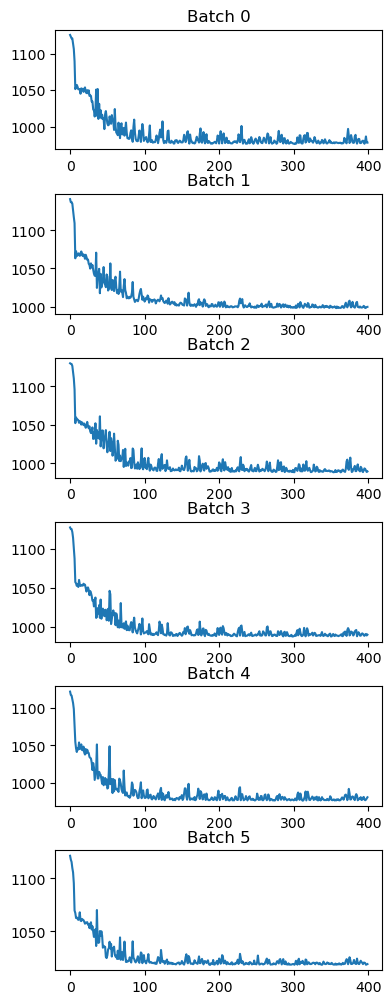

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 2.7715e-02,  0.0000e+00,  0.0000e+00,  ...,  1.8270e-16,
          -1.1012e-04,  1.4702e-05],
         [ 9.5187e-02,  0.0000e+00,  0.0000e+00,  ..., -1.0496e-15,
           8.8387e-04, -1.1890e-04],
         [ 2.9326e-01,  0.0000e+00,  0.0000e+00,  ..., -4.6678e-14,
           3.4215e-02, -4.5928e-03],
         ...,
         [ 7.3653e-02,  0.0000e+00,  0.0000e+00,  ..., -3.1065e-07,
          -5.1484e-02, -1.9174e-11],
         [ 5.9291e-02,  0.0000e+00,  0.0000e+00,  ..., -5.1035e-08,
           4.2911e-03, -9.6917e-14],
         [ 9.9324e-02,  0.0000e+00,  0.0000e+00,  ..., -9.6311e-10,
          -2.2934e-04, -2.9188e-16]],

        [[ 4.0360e-02,  0.0000e+00,  9.2152e-01,  ...,  0.0000e+00,
          -5.2523e-05,  0.0000e+00],
         [ 7.3080e-02,  0.0000e+00, -8.3752e-03,  ...,  0.0000e+00,
           3.9524e-04,  0.0000e+00],
         [ 2.7099e-01,  0.0000e+00, -1.0619e-02,  ...,  0.0000e+00,
           2.7944e-02,  0.0000e+00],
         ...,
         [ 5.9495e-0

"\nprint(f.renderText('INPUT'))\nplot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)\n\nprint(f.renderText('RECONSTRUCTION'))\nplot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)\n\nprint(f.renderText('ALIGNMENT'))\nplot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)\n"

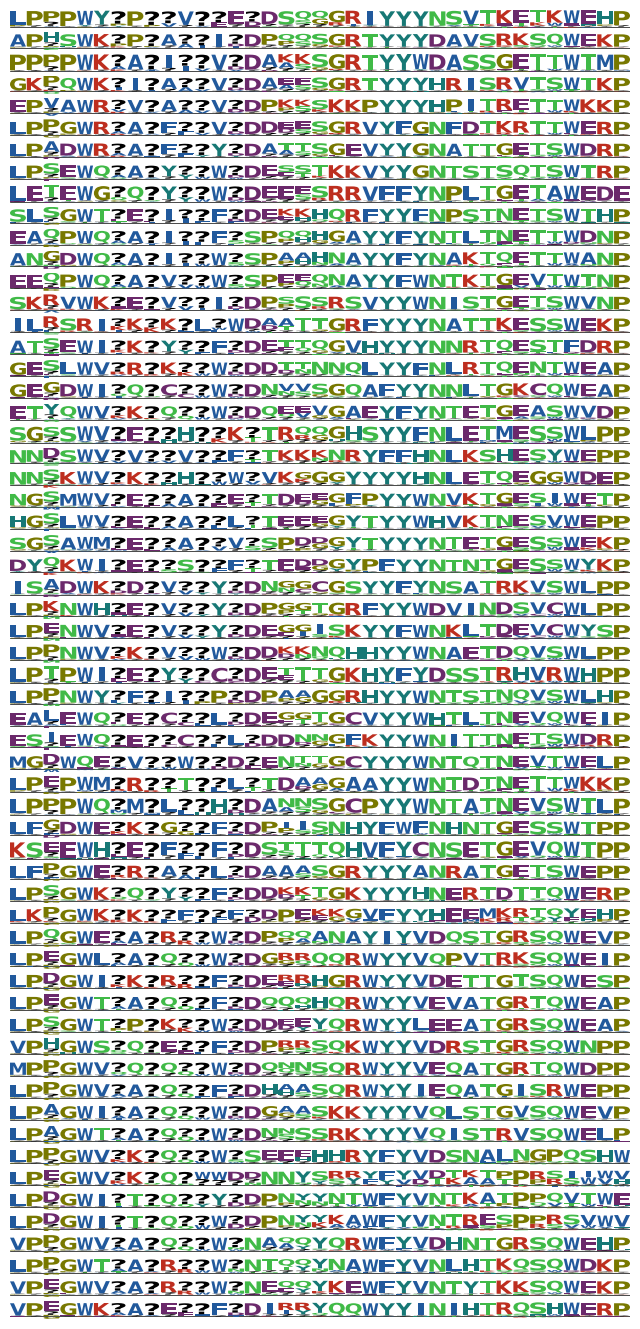

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)

test_set_alignment = model(dataset_test.prot_space, deepseq)



print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)




"""
print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)
"""


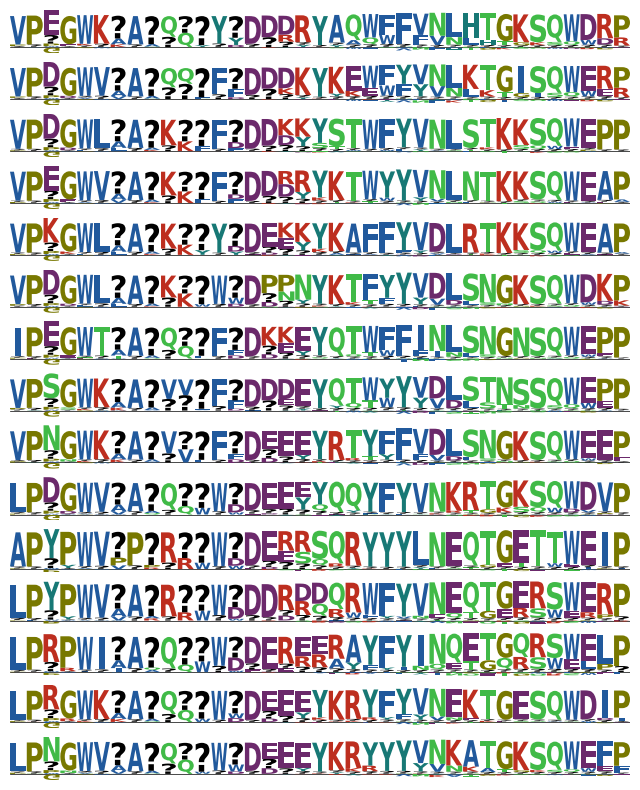

In [12]:
plot_msa_from_preds(test_set_alignment[5].detach().cpu(), alphabets, figsize=(8,10), show_axis=False)


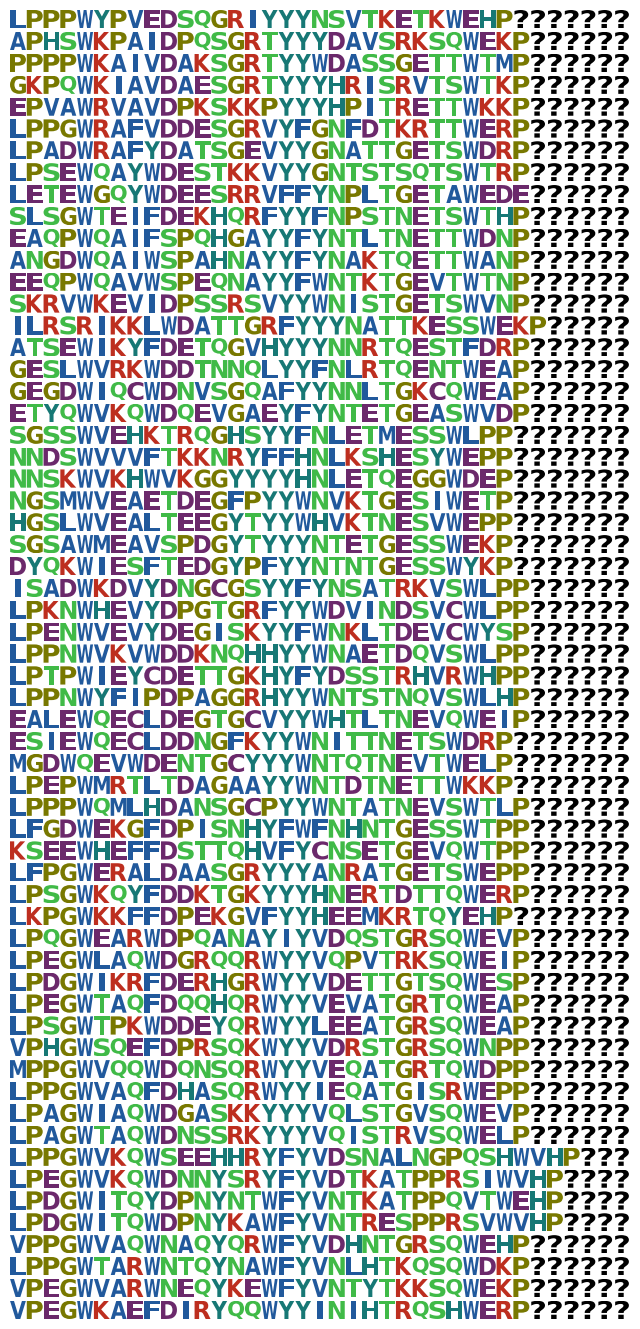

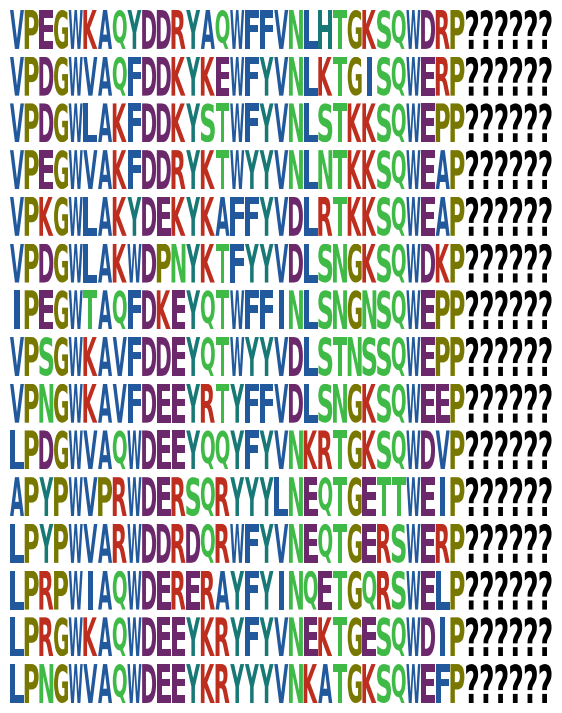

In [13]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)
plot_msa_from_preds(dataset_test.prot_space.detach().cpu(), alphabets, figsize=(7,9), show_axis=False)



<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

IndexError: index 5 is out of bounds for axis 1 with size 5

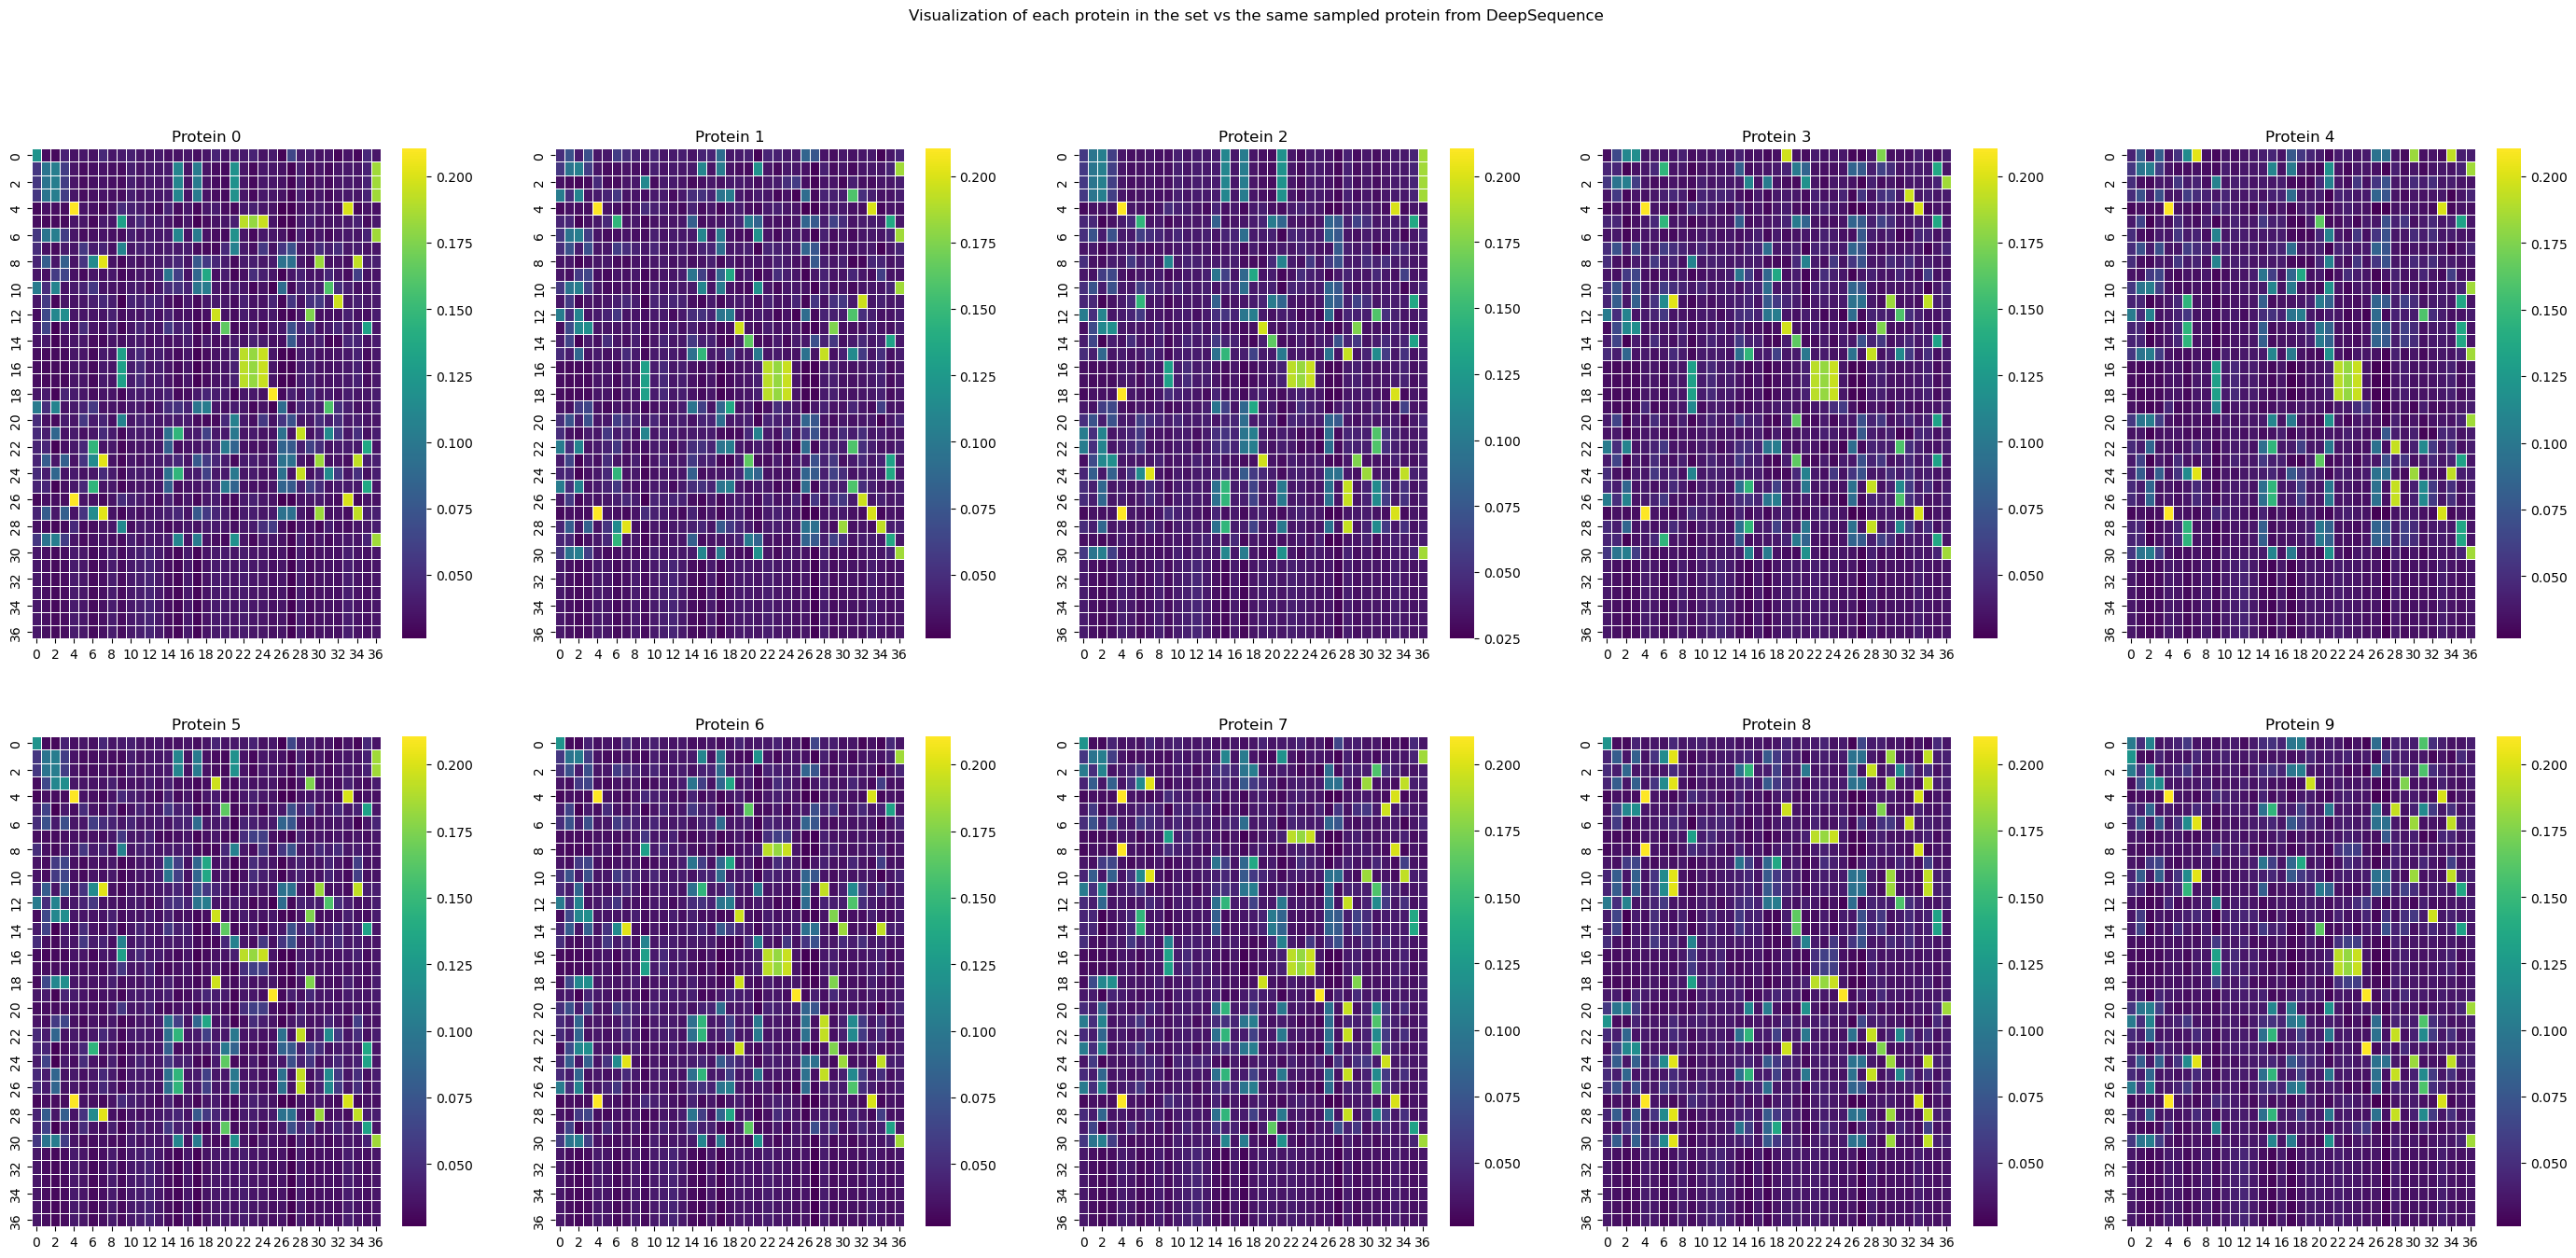

In [14]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])

plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()